In [35]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
import warnings
warnings.filterwarnings('ignore')

## Import BRADY and J-score data

### J-scores

In [37]:
j_2017 = pd.read_csv('hermes_j_2017.csv')
j_2017

Unnamed: 0             Full Name         0         1 Position  \
0             0            Mike Evans  0.189278  0.810722       WR   
1             1       Devonta Freeman  0.234855  0.765145       RB   
2             2       Ezekiel Elliott  0.245903  0.754097       RB   
3             3           Julio Jones  0.280293  0.719707       WR   
4             4         Odell Beckham  0.283363  0.716637       WR   
..          ...                   ...       ...       ...      ...   
470         470          Rex Burkhead  0.993949  0.006051       RB   
471         471  Fitzgerald Toussaint  0.993949  0.006051       RB   
472         472       Fozzy Whittaker  0.993949  0.006051       RB   
473         473         J.D. McKissic  0.993949  0.006051       RB   
474         474            A.J. Derby  0.993949  0.006051       TE   

                     Team  
0    Tampa Bay Buccaneers  
1         Atlanta Falcons  
2          Dallas Cowboys  
3         Atlanta Falcons  
4         New York Giants  
..                    ...  
470                     -  
471                     -  
472                     -  
473                     -  
474                     -  

[475 rows x 6 columns]

In [38]:
j_2017_fixed = pd.read_csv('j_scores_2017_hermes.csv')
j_2017_fixed

Unnamed: 0             Full Name         0         1  fpts_2017
0             0          Le'Veon Bell  0.101645  0.898355      342.0
1             1       Ezekiel Elliott  0.114394  0.885606      203.0
2             2         Antonio Brown  0.125034  0.874966      308.0
3             3         David Johnson  0.139751  0.860249       13.0
4             4          LeSean McCoy  0.182422  0.817578      264.0
..          ...                   ...       ...       ...        ...
468         468         Jeff Heuerman  0.998154  0.001846       35.0
469         469         Orson Charles  0.998154  0.001846        7.2
470         470        Jalston Fowler  0.998154  0.001846        6.3
471         471       Jeff Cumberland  0.998176  0.001824        2.4
472         472  Michael Hoomanawanui  0.998176  0.001824       17.1

[473 rows x 5 columns]

In [39]:
j_2017_df = j_2017_fixed.merge(j_2017[['Full Name','Team','Position']],on='Full Name',how='left')
j_2017_df

Unnamed: 0             Full Name         0         1  fpts_2017  \
0             0          Le'Veon Bell  0.101645  0.898355      342.0   
1             1       Ezekiel Elliott  0.114394  0.885606      203.0   
2             2         Antonio Brown  0.125034  0.874966      308.0   
3             3         David Johnson  0.139751  0.860249       13.0   
4             4          LeSean McCoy  0.182422  0.817578      264.0   
..          ...                   ...       ...       ...        ...   
482         468         Jeff Heuerman  0.998154  0.001846       35.0   
483         469         Orson Charles  0.998154  0.001846        7.2   
484         470        Jalston Fowler  0.998154  0.001846        6.3   
485         471       Jeff Cumberland  0.998176  0.001824        2.4   
486         472  Michael Hoomanawanui  0.998176  0.001824       17.1   

                    Team Position  
0    Pittsburgh Steelers       RB  
1         Dallas Cowboys       RB  
2    Pittsburgh Steelers       WR  
3      Arizona Cardinals       RB  
4          Buffalo Bills       RB  
..                   ...      ...  
482                    -       TE  
483                    -       TE  
484                    -       RB  
485                    -       TE  
486                    -       TE  

[487 rows x 7 columns]

In [50]:
j_2017_group = j_2017_df.groupby(['Team']).agg({'1':'sum'}).drop('-')
j_2017_group

1
Team                           
Arizona Cardinals      1.028204
Atlanta Falcons        1.238300
Baltimore Ravens       0.335370
Buffalo Bills          1.044655
Carolina Panthers      0.571957
Chicago Bears          0.382557
Cincinnati Bengals     1.208344
Cleveland Browns       0.342539
Dallas Cowboys         1.272160
Denver Broncos         0.803322
Detroit Lions          0.425421
Green Bay Packers      1.003515
Houston Texans         0.728726
Indianapolis Colts     0.395317
Jacksonville Jaguars   1.106448
Kansas City Chiefs     1.144170
Las Vegas Raiders      0.348770
Los Angeles Chargers   1.732971
Los Angeles Rams       0.823807
Miami Dolphins         0.719993
Minnesota Vikings      0.933659
New England Patriots   1.052971
New Orleans Saints     1.874284
New York Giants        0.849898
New York Jets          0.266262
Philadelphia Eagles    0.825375
Pittsburgh Steelers    1.979408
San Francisco 49ers    0.094765
Seattle Seahawks       0.277540
Tampa Bay Buccaneers   0.754371
Tennessee Titans       1.149503
Washington Commanders  0.384924

In [51]:
j_2017_rank = j_2017_group.rank(axis=0,ascending=False)
j_2017_rank

1
Team                       
Arizona Cardinals      12.0
Atlanta Falcons         5.0
Baltimore Ravens       29.0
Buffalo Bills          11.0
Carolina Panthers      22.0
Chicago Bears          26.0
Cincinnati Bengals      6.0
Cleveland Browns       28.0
Dallas Cowboys          4.0
Denver Broncos         18.0
Detroit Lions          23.0
Green Bay Packers      13.0
Houston Texans         20.0
Indianapolis Colts     24.0
Jacksonville Jaguars    9.0
Kansas City Chiefs      8.0
Las Vegas Raiders      27.0
Los Angeles Chargers    3.0
Los Angeles Rams       17.0
Miami Dolphins         21.0
Minnesota Vikings      14.0
New England Patriots   10.0
New Orleans Saints      2.0
New York Giants        15.0
New York Jets          31.0
Philadelphia Eagles    16.0
Pittsburgh Steelers     1.0
San Francisco 49ers    32.0
Seattle Seahawks       30.0
Tampa Bay Buccaneers   19.0
Tennessee Titans        7.0
Washington Commanders  25.0

In [52]:
j_2017_merge = j_2017_df.merge(j_2017_group, on='Team',how='left')
j_2017_merge

Unnamed: 0             Full Name         0       1_x  fpts_2017  \
0             0          Le'Veon Bell  0.101645  0.898355      342.0   
1             1       Ezekiel Elliott  0.114394  0.885606      203.0   
2             2         Antonio Brown  0.125034  0.874966      308.0   
3             3         David Johnson  0.139751  0.860249       13.0   
4             4          LeSean McCoy  0.182422  0.817578      264.0   
..          ...                   ...       ...       ...        ...   
482         468         Jeff Heuerman  0.998154  0.001846       35.0   
483         469         Orson Charles  0.998154  0.001846        7.2   
484         470        Jalston Fowler  0.998154  0.001846        6.3   
485         471       Jeff Cumberland  0.998176  0.001824        2.4   
486         472  Michael Hoomanawanui  0.998176  0.001824       17.1   

                    Team Position       1_y  
0    Pittsburgh Steelers       RB  1.979408  
1         Dallas Cowboys       RB  1.272160  
2    Pittsburgh Steelers       WR  1.979408  
3      Arizona Cardinals       RB  1.028204  
4          Buffalo Bills       RB  1.044655  
..                   ...      ...       ...  
482                    -       TE       NaN  
483                    -       TE       NaN  
484                    -       RB       NaN  
485                    -       TE       NaN  
486                    -       TE       NaN  

[487 rows x 8 columns]

In [53]:
j_2017_merge['offense_share'] = j_2017_merge['1_x'] / j_2017_merge['1_y']
j_2017_merge

Unnamed: 0             Full Name         0       1_x  fpts_2017  \
0             0          Le'Veon Bell  0.101645  0.898355      342.0   
1             1       Ezekiel Elliott  0.114394  0.885606      203.0   
2             2         Antonio Brown  0.125034  0.874966      308.0   
3             3         David Johnson  0.139751  0.860249       13.0   
4             4          LeSean McCoy  0.182422  0.817578      264.0   
..          ...                   ...       ...       ...        ...   
482         468         Jeff Heuerman  0.998154  0.001846       35.0   
483         469         Orson Charles  0.998154  0.001846        7.2   
484         470        Jalston Fowler  0.998154  0.001846        6.3   
485         471       Jeff Cumberland  0.998176  0.001824        2.4   
486         472  Michael Hoomanawanui  0.998176  0.001824       17.1   

                    Team Position       1_y  offense_share  
0    Pittsburgh Steelers       RB  1.979408       0.453851  
1         Dallas Cowboys       RB  1.272160       0.696144  
2    Pittsburgh Steelers       WR  1.979408       0.442034  
3      Arizona Cardinals       RB  1.028204       0.836652  
4          Buffalo Bills       RB  1.044655       0.782629  
..                   ...      ...       ...            ...  
482                    -       TE       NaN            NaN  
483                    -       TE       NaN            NaN  
484                    -       RB       NaN            NaN  
485                    -       TE       NaN            NaN  
486                    -       TE       NaN            NaN  

[487 rows x 9 columns]

In [54]:
j_2017_final = j_2017_merge.replace('-',np.nan).dropna(axis=0).drop(columns=['0']).rename(columns={'1_x':'j-score',
                                                                                          '1_y':'team_score'})
j_2017_final

Unnamed: 0        Full Name   j-score  fpts_2017                   Team  \
0             0     Le'Veon Bell  0.898355      342.0    Pittsburgh Steelers   
1             1  Ezekiel Elliott  0.885606      203.0         Dallas Cowboys   
2             2    Antonio Brown  0.874966      308.0    Pittsburgh Steelers   
3             3    David Johnson  0.860249       13.0      Arizona Cardinals   
4             4     LeSean McCoy  0.817578      264.0          Buffalo Bills   
..          ...              ...       ...        ...                    ...   
387         379  Jeremy Sprinkle  0.002309        9.3  Washington Commanders   
401         393    Sammie Coates  0.002118       13.2       Cleveland Browns   
420         406       Jack Doyle  0.001938      169.5     Indianapolis Colts   
472         458    Kyle Juszczyk  0.001846       70.2    San Francisco 49ers   
479         465  Richard Rodgers  0.001846       34.0      Green Bay Packers   

    Position  team_score  offense_share  
0         RB    1.979408       0.453851  
1         RB    1.272160       0.696144  
2         WR    1.979408       0.442034  
3         RB    1.028204       0.836652  
4         RB    1.044655       0.782629  
..       ...         ...            ...  
387       TE    0.384924       0.005998  
401       WR    0.342539       0.006183  
420       TE    0.395317       0.004904  
472       RB    0.094765       0.019478  
479       TE    1.003515       0.001839  

[249 rows x 8 columns]

In [96]:
j_2017_final_df = j_2017_final.merge(j_2017_rank, on='Team',how='left').rename(columns={'fpts_2017':'y'})
j_2017_final_df

Unnamed: 0        Full Name   j-score      y                   Team  \
0             0     Le'Veon Bell  0.898355  342.0    Pittsburgh Steelers   
1             1  Ezekiel Elliott  0.885606  203.0         Dallas Cowboys   
2             2    Antonio Brown  0.874966  308.0    Pittsburgh Steelers   
3             3    David Johnson  0.860249   13.0      Arizona Cardinals   
4             4     LeSean McCoy  0.817578  264.0          Buffalo Bills   
..          ...              ...       ...    ...                    ...   
244         379  Jeremy Sprinkle  0.002309    9.3  Washington Commanders   
245         393    Sammie Coates  0.002118   13.2       Cleveland Browns   
246         406       Jack Doyle  0.001938  169.5     Indianapolis Colts   
247         458    Kyle Juszczyk  0.001846   70.2    San Francisco 49ers   
248         465  Richard Rodgers  0.001846   34.0      Green Bay Packers   

    Position  team_score  offense_share     1  
0         RB    1.979408       0.453851   1.0  
1         RB    1.272160       0.696144   4.0  
2         WR    1.979408       0.442034   1.0  
3         RB    1.028204       0.836652  12.0  
4         RB    1.044655       0.782629  11.0  
..       ...         ...            ...   ...  
244       TE    0.384924       0.005998  25.0  
245       WR    0.342539       0.006183  28.0  
246       TE    0.395317       0.004904  24.0  
247       RB    0.094765       0.019478  32.0  
248       TE    1.003515       0.001839  13.0  

[249 rows x 9 columns]

In [97]:
j_2018 = pd.read_csv('hermes_j_2018.csv')

j_2018_fixed = pd.read_csv('j_scores_2018_hermes.csv')

j_2018_df = j_2018_fixed.merge(j_2018[['Full Name','Team','Position']],on='Full Name',how='left')

j_2018_group = j_2018_df.groupby(['Team']).agg({'1':'sum'}).drop('-')

j_2018_rank = j_2018_group.rank(axis=0,ascending=False)
j_2018_rank

j_2018_merge = j_2018_df.merge(j_2018_group, on='Team',how='left')

j_2018_merge['offense_share'] = j_2018_merge['1_x'] / j_2018_merge['1_y']

j_2018_final = j_2018_merge.replace('-',np.nan).dropna(axis=0).drop(columns=['0']).rename(columns={'1_x':'j-score',
                                                                                 '1_y':'team_score'})

j_2018_final_df = j_2018_final.merge(j_2018_rank, on='Team',how='left').rename(columns={'fpts_2018':'y'})
j_2018_final_df

Unnamed: 0        Full Name   j-score      y                  Team  \
0             0  DeAndre Hopkins  0.889506  332.8        Houston Texans   
1             1   Michael Thomas  0.867382  315.2    New Orleans Saints   
2             2    Antonio Brown  0.863679  324.0   Pittsburgh Steelers   
3             3     Alvin Kamara  0.857246  348.0    New Orleans Saints   
4             4     Keenan Allen  0.845147  258.0  Los Angeles Chargers   
..          ...              ...       ...    ...                   ...   
245         408      Jesse James  0.002209   84.0   Pittsburgh Steelers   
246         415    Durham Smythe  0.002186   10.8        Miami Dolphins   
247         420    Sammie Coates  0.002118    2.2        Houston Texans   
248         482    Kyle Juszczyk  0.001846   67.5   San Francisco 49ers   
249         491  Richard Rodgers  0.001846    1.8     Green Bay Packers   

    Position  team_score  offense_share     1  
0         WR    1.453913       0.611801   6.0  
1         WR    2.463180       0.352139   2.0  
2         WR    1.434748       0.601973   7.0  
3         RB    2.463180       0.348024   2.0  
4         WR    1.730294       0.488441   4.0  
..       ...         ...            ...   ...  
245       TE    1.434748       0.001539   7.0  
246       TE    0.359732       0.006077  23.0  
247       WR    1.453913       0.001457   6.0  
248       RB    0.057215       0.032261  32.0  
249       TE    0.920371       0.002005  16.0  

[250 rows x 9 columns]

In [98]:
j_2019 = pd.read_csv('hermes_j_2019.csv')

j_2019_fixed = pd.read_csv('j_scores_2019_hermes.csv')

j_2019_df = j_2019_fixed.merge(j_2019[['Full Name','Team','Position']],on='Full Name',how='left')

j_2019_group = j_2019_df.groupby(['Team']).agg({'1':'sum'}).drop('-')

j_2019_rank = j_2019_group.rank(axis=0,ascending=False)
j_2019_rank

j_2019_merge = j_2019_df.merge(j_2019_group, on='Team',how='left')

j_2019_merge['offense_share'] = j_2019_merge['1_x'] / j_2019_merge['1_y']

j_2019_final = j_2019_merge.replace('-',np.nan).dropna(axis=0).drop(columns=['0']).rename(columns={'1_x':'j-score',
                                                                               '1_y':'team_score'})

j_2019_final_df = j_2019_final.merge(j_2019_rank, on='Team',how='left').rename(columns={'fpts_2019':'y'})
j_2019_final_df

Unnamed: 0            Full Name   j-score      y                  Team  \
0             0        Davante Adams  0.937216  211.2     Green Bay Packers   
1             1       Michael Thomas  0.929852  374.4    New Orleans Saints   
2             2          Julio Jones  0.910937  274.5       Atlanta Falcons   
3             3        Melvin Gordon  0.881583  181.2  Los Angeles Chargers   
4             4  Christian McCaffrey  0.853630  468.8     Carolina Panthers   
..          ...                  ...       ...    ...                   ...   
245         422          J.J. Nelson  0.002118   13.6     Las Vegas Raiders   
246         424         C.J. Prosise  0.002118   28.8      Seattle Seahawks   
247         427        Wayne Gallman  0.002118   48.6       New York Giants   
248         481        Kyle Juszczyk  0.001846   50.4   San Francisco 49ers   
249         484          C.J. Uzomah  0.001846   63.7    Cincinnati Bengals   

    Position  team_score  offense_share     1  
0         WR    1.665540       0.562710   6.0  
1         WR    1.831178       0.507789   3.0  
2         WR    1.207519       0.754387  12.0  
3         RB    2.454906       0.359111   1.0  
4         RB    0.939520       0.908581  17.0  
..       ...         ...            ...   ...  
245       WR    0.940506       0.002252  16.0  
246       RB    1.329268       0.001593  10.0  
247       RB    1.123115       0.001886  15.0  
248       RB    1.225128       0.001507  11.0  
249       TE    1.149879       0.001605  13.0  

[250 rows x 9 columns]

In [99]:
j_2020 = pd.read_csv('hermes_j_2020.csv')

j_2020_fixed = pd.read_csv('j_scores_2020_hermes.csv')

j_2020_df = j_2020_fixed.merge(j_2020[['Full Name','Team','Position']],on='Full Name',how='left')

j_2020_group = j_2020_df.groupby(['Team']).agg({'1':'sum'}).drop('-')

j_2020_rank = j_2020_group.rank(axis=0,ascending=False)
j_2020_rank

j_2020_merge = j_2020_df.merge(j_2020_group, on='Team',how='left')

j_2020_merge['offense_share'] = j_2020_merge['1_x'] / j_2020_merge['1_y']

j_2020_final = j_2020_merge.replace('-',np.nan).dropna(axis=0).drop(columns=['0']).rename(columns={'1_x':'j-score',
                                                                              '1_y':'team_score'})

j_2020_final_df = j_2020_final.merge(j_2020_rank, on='Team',how='left').rename(columns={'fpts_2020':'y'})
j_2020_final_df

Unnamed: 0            Full Name   j-score         y  \
0             0          Dalvin Cook  0.934821  337.8004   
1             1  Christian McCaffrey  0.879685   90.3999   
2             2          Aaron Jones  0.879520  258.9006   
3             3         Keenan Allen  0.864234  245.0994   
4             4        Austin Ekeler  0.824191  165.3000   
..          ...                  ...       ...       ...   
245         464         Devin Asiasi  0.002186   11.8998   
246         466         C.J. Prosise  0.002118   12.7000   
247         469   DeAndre Washington  0.002118   17.1000   
248         541         Russell Gage  0.001846  181.0608   
249         546      Richard Rodgers  0.001824   70.4998   

                      Team Position  team_score  offense_share     1  
0        Minnesota Vikings       RB    1.674383       0.558308   5.0  
1        Carolina Panthers       RB    1.117030       0.787522  17.0  
2        Green Bay Packers       RB    1.644743       0.534746   6.0  
3     Los Angeles Chargers       WR    2.039502       0.423748   3.0  
4     Los Angeles Chargers       RB    2.039502       0.404114   3.0  
..                     ...      ...         ...            ...   ...  
245   New England Patriots       TE    0.154783       0.014123  32.0  
246         Houston Texans       RB    1.136397       0.001864  16.0  
247     Kansas City Chiefs       RB    1.749288       0.001211   4.0  
248        Atlanta Falcons       WR    1.512119       0.001221   8.0  
249  Washington Commanders       TE    0.197278       0.009248  31.0  

[250 rows x 9 columns]

In [100]:
j_2021 = pd.read_csv('hermes_j_2021.csv')

j_2021_fixed = pd.read_csv('j_scores_2021_hermes.csv')

j_2021_df = j_2021_fixed.merge(j_2021[['Full Name','Team','Position']],on='Full Name',how='left')

j_2021_group = j_2021_df.groupby(['Team']).agg({'1':'sum'}).drop('-')

j_2021_rank = j_2021_group.rank(axis=0,ascending=False)
j_2021_rank

j_2021_merge = j_2021_df.merge(j_2021_group, on='Team',how='left')

j_2021_merge['offense_share'] = j_2021_merge['1_x'] / j_2021_merge['1_y']

j_2021_final = j_2021_merge.replace('-',np.nan).dropna(axis=0).drop(columns=['0']).rename(columns={'1_x':'j-score',
                                                                             '1_y':'team_score'})

j_2021_final_df = j_2021_final.merge(j_2021_rank, on='Team',how='left').rename(columns={'fpts_2021':'y'})
j_2021_final_df

Unnamed: 0            Full Name   j-score         y  \
0             0          Dalvin Cook  0.896381  206.2996   
1             1         Travis Kelce  0.889216  262.8000   
2             2  Christian McCaffrey  0.862092  127.5001   
3             3           Mike Evans  0.861395  262.4992   
4             4          Tyreek Hill  0.861156  296.5004   
..          ...                  ...       ...       ...   
245         431       Dalton Schultz  0.002344  208.8008   
246         436         Jordan Akins  0.002259   41.7001   
247         466        Damien Harris  0.002203  210.1005   
248         488      Richard Rodgers  0.001906    3.0999   
249         492        Ty Montgomery  0.001906   29.8998   

                     Team Position  team_score  offense_share     1  
0       Minnesota Vikings       RB    2.015515       0.444740   4.0  
1      Kansas City Chiefs       TE    2.203564       0.403535   2.0  
2       Carolina Panthers       RB    1.070987       0.804951  15.0  
3    Tampa Bay Buccaneers       WR    2.982122       0.288853   1.0  
4      Kansas City Chiefs       WR    2.203564       0.390801   2.0  
..                    ...      ...         ...            ...   ...  
245        Dallas Cowboys       TE    1.077105       0.002176  14.0  
246        Houston Texans       TE    0.494409       0.004569  27.0  
247  New England Patriots       RB    0.176945       0.012448  32.0  
248   Philadelphia Eagles       TE    0.400971       0.004755  31.0  
249    New Orleans Saints       RB    0.905516       0.002105  19.0  

[250 rows x 9 columns]

In [79]:
j_2022 = pd.read_csv('hermes_j_2022.csv')

j_2022_fixed = pd.read_csv('j_scores_2022_hermes.csv')

j_2022_df = j_2022_fixed.merge(j_2022[['id','Team','Position']],left_on='id',right_on='id',how='left')

j_2022_group = j_2022_df.groupby(['Team']).agg({'1':'sum'}).drop('-')

j_2022_rank = j_2022_group.rank(axis=0,ascending=False)
j_2022_rank

j_2022_merge = j_2022_df.merge(j_2022_group, on='Team',how='left')

j_2022_merge['offense_share'] = j_2022_merge['1_x'] / j_2022_merge['1_y']

j_2022_final = j_2022_merge.replace('-',np.nan).dropna(axis=0).drop(columns=['0']).rename(columns={'1_x':'j-score',
                                                                            '1_y':'team_score'})

j_2022_final_df = j_2022_final.merge(j_2022_rank, on='Team',how='left')
j_2022_final_df

id   j-score                   Team Position  team_score  \
0    Jonathan Taylor  0.869047     Indianapolis Colts       RB    1.086018   
1        Cooper Kupp  0.846279       Los Angeles Rams       WR    1.323825   
2      Davante Adams  0.828549      Las Vegas Raiders       WR    2.085839   
3         Nick Chubb  0.827943       Cleveland Browns       RB    1.233409   
4       Deebo Samuel  0.782741    San Francisco 49ers       WR    1.651133   
..               ...       ...                    ...      ...         ...   
614     Kene Nwangwu  0.001846      Minnesota Vikings       RB    1.782206   
615       Derek Watt  0.001824    Pittsburgh Steelers       RB    1.297139   
616    Marken Michel  0.001824  Washington Commanders       WR    0.472501   
617      Mike Burton  0.001824     Kansas City Chiefs       RB    1.250220   
618    Kyle Juszczyk  0.001824    San Francisco 49ers       RB    1.651133   

     offense_share     1  
0         0.800215  17.0  
1         0.639268  10.0  
2         0.397226   1.0  
3         0.671263  13.0  
4         0.474063   7.0  
..             ...   ...  
614       0.001036   5.0  
615       0.001407  11.0  
616       0.003861  30.0  
617       0.001459  12.0  
618       0.001105   7.0  

[619 rows x 7 columns]

In [80]:
j_2022_rank.sort_values('1')

1
Team                       
Las Vegas Raiders       1.0
Tampa Bay Buccaneers    2.0
Los Angeles Chargers    3.0
Cincinnati Bengals      4.0
Minnesota Vikings       5.0
Tennessee Titans        6.0
San Francisco 49ers     7.0
Seattle Seahawks        8.0
Miami Dolphins          9.0
Los Angeles Rams       10.0
Pittsburgh Steelers    11.0
Kansas City Chiefs     12.0
Cleveland Browns       13.0
New York Jets          14.0
Atlanta Falcons        15.0
Arizona Cardinals      16.0
Indianapolis Colts     17.0
Jacksonville Jaguars   18.0
Green Bay Packers      19.0
New Orleans Saints     20.0
Carolina Panthers      21.0
Dallas Cowboys         22.0
Buffalo Bills          23.0
Philadelphia Eagles    24.0
Detroit Lions          25.0
FA                     26.0
Denver Broncos         27.0
Chicago Bears          28.0
New York Giants        29.0
Washington Commanders  30.0
Baltimore Ravens       31.0
New England Patriots   32.0
Houston Texans         33.0

### BRADY scores

In [81]:
brady_2022 = pd.read_csv('hermes_brady_2022.csv')
brady_2022_final = brady_2022[brady_2022['starter'] == 1]
brady_2022_final

Unnamed: 0                 id         0         1          Full Name  \
0            0         Josh Allen  0.110633  0.889367         Josh Allen   
1            1      Lamar Jackson  0.125197  0.874803      Lamar Jackson   
2            2     Deshaun Watson  0.133238  0.866762     Deshaun Watson   
3            3       Kyler Murray  0.158847  0.841153       Kyler Murray   
4            4     Justin Herbert  0.170236  0.829764     Justin Herbert   
5            5    Patrick Mahomes  0.224655  0.775345    Patrick Mahomes   
6            6      Aaron Rodgers  0.298543  0.701457      Aaron Rodgers   
7            7        Jalen Hurts  0.375722  0.624278        Jalen Hurts   
8            8     Russell Wilson  0.413420  0.586580     Russell Wilson   
9            9         Joe Burrow  0.453745  0.546255         Joe Burrow   
10          10       Dak Prescott  0.473124  0.526876       Dak Prescott   
11          11       Kirk Cousins  0.607912  0.392088       Kirk Cousins   
12          12          Tom Brady  0.651980  0.348020          Tom Brady   
13          13  Mitchell Trubisky  0.686007  0.313993  Mitchell Trubisky   
14          14     Ryan Tannehill  0.760699  0.239301     Ryan Tannehill   
15          15          Matt Ryan  0.768505  0.231495          Matt Ryan   
16          16         Trey Lance  0.827289  0.172711         Trey Lance   
17          17         Derek Carr  0.832401  0.167599         Derek Carr   
18          18     Tua Tagovailoa  0.839444  0.160556     Tua Tagovailoa   
19          19   Matthew Stafford  0.897151  0.102849   Matthew Stafford   
20          20         Geno Smith  0.918964  0.081036         Geno Smith   
21          21       Carson Wentz  0.928972  0.071028       Carson Wentz   
22          22        Sam Darnold  0.931603  0.068397        Sam Darnold   
23          23     Marcus Mariota  0.964264  0.035736     Marcus Mariota   
25          25      Justin Fields  0.968432  0.031568      Justin Fields   
26          26         Jared Goff  0.968769  0.031231         Jared Goff   
28          28        Zach Wilson  0.970296  0.029704        Zach Wilson   
33          33          Mac Jones  0.979820  0.020180          Mac Jones   
35          35       Daniel Jones  0.981687  0.018313       Daniel Jones   
36          36        Davis Mills  0.983692  0.016308        Davis Mills   
37          37     Jameis Winston  0.983998  0.016002     Jameis Winston   
40          40    Trevor Lawrence  0.985239  0.014761    Trevor Lawrence   

                     Team  starter  
0           Buffalo Bills        1  
1        Baltimore Ravens        1  
2        Cleveland Browns        1  
3       Arizona Cardinals        1  
4    Los Angeles Chargers        1  
5      Kansas City Chiefs        1  
6       Green Bay Packers        1  
7     Philadelphia Eagles        1  
8          Denver Broncos        1  
9      Cincinnati Bengals        1  
10         Dallas Cowboys        1  
11      Minnesota Vikings        1  
12   Tampa Bay Buccaneers        1  
13    Pittsburgh Steelers        1  
14       Tennessee Titans        1  
15     Indianapolis Colts        1  
16    San Francisco 49ers        1  
17      Las Vegas Raiders        1  
18         Miami Dolphins        1  
19       Los Angeles Rams        1  
20       Seattle Seahawks        1  
21  Washington Commanders        1  
22      Carolina Panthers        1  
23        Atlanta Falcons        1  
25          Chicago Bears        1  
26          Detroit Lions        1  
28          New York Jets        1  
33   New England Patriots        1  
35        New York Giants        1  
36         Houston Texans        1  
37     New Orleans Saints        1  
40   Jacksonville Jaguars        1

In [82]:
brady_2021 = pd.read_csv('hermes_brady_2021.csv')
brady_2021_final = brady_2021[brady_2021['starter'] == 1]
brady_2021_final

Unnamed: 0                  id         0         1           Full Name  \
0            0       Lamar Jackson  0.097843  0.902157       Lamar Jackson   
1            1          Josh Allen  0.132782  0.867218          Josh Allen   
2            2      Justin Herbert  0.149144  0.850856      Justin Herbert   
3            3        Kyler Murray  0.183713  0.816287        Kyler Murray   
4            4     Patrick Mahomes  0.187818  0.812182     Patrick Mahomes   
5            5       Aaron Rodgers  0.321498  0.678502       Aaron Rodgers   
6            6        Dak Prescott  0.325346  0.674654        Dak Prescott   
7            7    Matthew Stafford  0.332571  0.667429    Matthew Stafford   
8            8        Kirk Cousins  0.362175  0.637825        Kirk Cousins   
9            9          Joe Burrow  0.385277  0.614723          Joe Burrow   
10          10           Tom Brady  0.499266  0.500734           Tom Brady   
11          11      Russell Wilson  0.630471  0.369529      Russell Wilson   
12          12      Ryan Tannehill  0.672980  0.327020      Ryan Tannehill   
13          13  Ben Roethlisberger  0.790711  0.209289  Ben Roethlisberger   
14          14    Ryan Fitzpatrick  0.821745  0.178255    Ryan Fitzpatrick   
15          15           Matt Ryan  0.863326  0.136674           Matt Ryan   
17          17         Andy Dalton  0.929500  0.070500         Andy Dalton   
18          18      Baker Mayfield  0.944354  0.055646      Baker Mayfield   
19          19          Derek Carr  0.961875  0.038124          Derek Carr   
20          20        Carson Wentz  0.965178  0.034822        Carson Wentz   
21          21      Tua Tagovailoa  0.966508  0.033492      Tua Tagovailoa   
25          25          Jared Goff  0.971719  0.028280          Jared Goff   
29          29        Daniel Jones  0.979639  0.020361        Daniel Jones   
31          31         Sam Darnold  0.980765  0.019235         Sam Darnold   
32          32   Teddy Bridgewater  0.982079  0.017921   Teddy Bridgewater   
33          33         Jalen Hurts  0.982393  0.017607         Jalen Hurts   
34          34           Mac Jones  0.982621  0.017379           Mac Jones   
36          36      Jameis Winston  0.985905  0.014095      Jameis Winston   
38          38        Tyrod Taylor  0.986231  0.013769        Tyrod Taylor   
39          39     Jimmy Garoppolo  0.986619  0.013381     Jimmy Garoppolo   
43          43         Zach Wilson  0.987099  0.012901         Zach Wilson   
44          44     Trevor Lawrence  0.987099  0.012901     Trevor Lawrence   

                     Team  starter  
0        Baltimore Ravens        1  
1           Buffalo Bills        1  
2    Los Angeles Chargers        1  
3       Arizona Cardinals        1  
4      Kansas City Chiefs        1  
5       Green Bay Packers        1  
6          Dallas Cowboys        1  
7        Los Angeles Rams        1  
8       Minnesota Vikings        1  
9      Cincinnati Bengals        1  
10   Tampa Bay Buccaneers        1  
11       Seattle Seahawks        1  
12       Tennessee Titans        1  
13    Pittsburgh Steelers        1  
14  Washington Commanders        1  
15        Atlanta Falcons        1  
17          Chicago Bears        1  
18       Cleveland Browns        1  
19      Las Vegas Raiders        1  
20     Indianapolis Colts        1  
21         Miami Dolphins        1  
25          Detroit Lions        1  
29        New York Giants        1  
31      Carolina Panthers        1  
32         Denver Broncos        1  
33    Philadelphia Eagles        1  
34   New England Patriots        1  
36     New Orleans Saints        1  
38         Houston Texans        1  
39    San Francisco 49ers        1  
43          New York Jets        1  
44   Jacksonville Jaguars        1

In [83]:
brady_2020 = pd.read_csv('hermes_brady_2020.csv')
brady_2020_final = brady_2020[brady_2020['starter'] == 1]
brady_2020_final

Unnamed: 0                  id         0         1           Full Name  \
0            0      Deshaun Watson  0.100767  0.899233      Deshaun Watson   
1            1       Lamar Jackson  0.169175  0.830825       Lamar Jackson   
2            2           Tom Brady  0.217104  0.782896           Tom Brady   
3            3       Aaron Rodgers  0.225609  0.774391       Aaron Rodgers   
4            4     Patrick Mahomes  0.282072  0.717928     Patrick Mahomes   
5            5          Josh Allen  0.440541  0.559459          Josh Allen   
6            6      Russell Wilson  0.605468  0.394532      Russell Wilson   
7            7          Drew Brees  0.651937  0.348062          Drew Brees   
8            8      Ryan Tannehill  0.730401  0.269599      Ryan Tannehill   
9            9        Kyler Murray  0.780333  0.219667        Kyler Murray   
10          10           Matt Ryan  0.824804  0.175196           Matt Ryan   
11          11          Cam Newton  0.828753  0.171247          Cam Newton   
12          12      Baker Mayfield  0.854656  0.145344      Baker Mayfield   
13          13        Kirk Cousins  0.870339  0.129661        Kirk Cousins   
14          14        Dak Prescott  0.874180  0.125820        Dak Prescott   
15          15        Carson Wentz  0.889150  0.110850        Carson Wentz   
16          16          Jared Goff  0.927187  0.072813          Jared Goff   
18          18   Mitchell Trubisky  0.928972  0.071028   Mitchell Trubisky   
19          19       Philip Rivers  0.943933  0.056067       Philip Rivers   
20          20   Teddy Bridgewater  0.960976  0.039024   Teddy Bridgewater   
21          21           Drew Lock  0.963414  0.036586           Drew Lock   
22          22    Matthew Stafford  0.967914  0.032086    Matthew Stafford   
26          26        Daniel Jones  0.975224  0.024776        Daniel Jones   
28          28      Dwayne Haskins  0.978328  0.021672      Dwayne Haskins   
29          29          Joe Burrow  0.980816  0.019184          Joe Burrow   
30          30  Ben Roethlisberger  0.981410  0.018590  Ben Roethlisberger   
31          31         Sam Darnold  0.981572  0.018428         Sam Darnold   
32          32        Tyrod Taylor  0.985315  0.014685        Tyrod Taylor   
33          33    Ryan Fitzpatrick  0.986099  0.013901    Ryan Fitzpatrick   
34          34     Jimmy Garoppolo  0.986231  0.013769     Jimmy Garoppolo   
35          35     Gardner Minshew  0.986619  0.013381     Gardner Minshew   
36          36          Derek Carr  0.987080  0.012920          Derek Carr   

                     Team  starter  
0          Houston Texans        1  
1        Baltimore Ravens        1  
2    Tampa Bay Buccaneers        1  
3       Green Bay Packers        1  
4      Kansas City Chiefs        1  
5           Buffalo Bills        1  
6        Seattle Seahawks        1  
7      New Orleans Saints        1  
8        Tennessee Titans        1  
9       Arizona Cardinals        1  
10        Atlanta Falcons        1  
11   New England Patriots        1  
12       Cleveland Browns        1  
13      Minnesota Vikings        1  
14         Dallas Cowboys        1  
15    Philadelphia Eagles        1  
16       Los Angeles Rams        1  
18          Chicago Bears        1  
19     Indianapolis Colts        1  
20      Carolina Panthers        1  
21         Denver Broncos        1  
22          Detroit Lions        1  
26        New York Giants        1  
28  Washington Commanders        1  
29     Cincinnati Bengals        1  
30    Pittsburgh Steelers        1  
31          New York Jets        1  
32   Los Angeles Chargers        1  
33         Miami Dolphins        1  
34    San Francisco 49ers        1  
35   Jacksonville Jaguars        1  
36      Las Vegas Raiders        1

In [84]:
brady_2019 = pd.read_csv('hermes_brady_2019.csv')
brady_2019_final = brady_2019[brady_2019['starter'] == 1]
brady_2019_final

Unnamed: 0                  id         0         1           Full Name  \
0            0      Deshaun Watson  0.092073  0.907927      Deshaun Watson   
1            1      Russell Wilson  0.350477  0.649523      Russell Wilson   
2            2        Dak Prescott  0.395355  0.604645        Dak Prescott   
3            3     Patrick Mahomes  0.580801  0.419199     Patrick Mahomes   
4            4       Aaron Rodgers  0.619371  0.380629       Aaron Rodgers   
5            5          Josh Allen  0.710938  0.289062          Josh Allen   
6            6      Baker Mayfield  0.721676  0.278324      Baker Mayfield   
7            7          Cam Newton  0.747739  0.252261          Cam Newton   
8            8          Jared Goff  0.757433  0.242567          Jared Goff   
9            9          Drew Brees  0.769690  0.230310          Drew Brees   
10          10  Ben Roethlisberger  0.833186  0.166814  Ben Roethlisberger   
11          11           Tom Brady  0.859598  0.140402           Tom Brady   
12          12           Matt Ryan  0.872682  0.127318           Matt Ryan   
13          13       Philip Rivers  0.872886  0.127114       Philip Rivers   
14          14        Kirk Cousins  0.903879  0.096121        Kirk Cousins   
15          15    Matthew Stafford  0.949975  0.050025    Matthew Stafford   
16          16      Jameis Winston  0.951883  0.048117      Jameis Winston   
17          17     Jimmy Garoppolo  0.953548  0.046452     Jimmy Garoppolo   
19          19       Lamar Jackson  0.966135  0.033865       Lamar Jackson   
21          21        Carson Wentz  0.968626  0.031374        Carson Wentz   
22          22     Jacoby Brissett  0.980956  0.019044     Jacoby Brissett   
23          23   Mitchell Trubisky  0.981100  0.018900   Mitchell Trubisky   
24          24         Sam Darnold  0.981572  0.018428         Sam Darnold   
25          25          Joe Flacco  0.983147  0.016853          Joe Flacco   
28          28      Marcus Mariota  0.985427  0.014573      Marcus Mariota   
29          29         Andy Dalton  0.986231  0.013769         Andy Dalton   
30          30         Case Keenum  0.986243  0.013757         Case Keenum   
31          31          Nick Foles  0.986619  0.013381          Nick Foles   
32          32    Ryan Fitzpatrick  0.986967  0.013033    Ryan Fitzpatrick   
33          33         Eli Manning  0.986997  0.013003         Eli Manning   
34          34          Derek Carr  0.987080  0.012920          Derek Carr   
35          35        Kyler Murray  0.987099  0.012901        Kyler Murray   

                     Team  starter  
0          Houston Texans        1  
1        Seattle Seahawks        1  
2          Dallas Cowboys        1  
3      Kansas City Chiefs        1  
4       Green Bay Packers        1  
5           Buffalo Bills        1  
6        Cleveland Browns        1  
7       Carolina Panthers        1  
8        Los Angeles Rams        1  
9      New Orleans Saints        1  
10    Pittsburgh Steelers        1  
11   New England Patriots        1  
12        Atlanta Falcons        1  
13   Los Angeles Chargers        1  
14      Minnesota Vikings        1  
15          Detroit Lions        1  
16   Tampa Bay Buccaneers        1  
17    San Francisco 49ers        1  
19       Baltimore Ravens        1  
21    Philadelphia Eagles        1  
22     Indianapolis Colts        1  
23          Chicago Bears        1  
24          New York Jets        1  
25         Denver Broncos        1  
28       Tennessee Titans        1  
29     Cincinnati Bengals        1  
30  Washington Commanders        1  
31   Jacksonville Jaguars        1  
32         Miami Dolphins        1  
33        New York Giants        1  
34      Las Vegas Raiders        1  
35      Arizona Cardinals        1

In [85]:
brady_2018 = pd.read_csv('hermes_brady_2018.csv')
brady_2018_final = brady_2018[brady_2018['starter'] == 1]
brady_2018_final

Unnamed: 0                  id         0         1           Full Name  \
0            0      Russell Wilson  0.179035  0.820965      Russell Wilson   
1            1         Andrew Luck  0.182778  0.817222         Andrew Luck   
2            2          Cam Newton  0.189427  0.810573          Cam Newton   
3            3      Deshaun Watson  0.324782  0.675218      Deshaun Watson   
4            4          Drew Brees  0.357812  0.642188          Drew Brees   
5            5       Aaron Rodgers  0.463860  0.536140       Aaron Rodgers   
6            6           Matt Ryan  0.495727  0.504273           Matt Ryan   
7            7  Ben Roethlisberger  0.510363  0.489637  Ben Roethlisberger   
8            8     Patrick Mahomes  0.591959  0.408041     Patrick Mahomes   
9            9          Jared Goff  0.699012  0.300988          Jared Goff   
10          10        Dak Prescott  0.769066  0.230934        Dak Prescott   
11          11           Tom Brady  0.858351  0.141649           Tom Brady   
12          12       Philip Rivers  0.872886  0.127114       Philip Rivers   
13          13          Alex Smith  0.887253  0.112747          Alex Smith   
14          14       Blake Bortles  0.906132  0.093868       Blake Bortles   
15          15        Kirk Cousins  0.919646  0.080354        Kirk Cousins   
16          16    Matthew Stafford  0.934652  0.065348    Matthew Stafford   
17          17      Jameis Winston  0.940812  0.059188      Jameis Winston   
18          18         Eli Manning  0.943933  0.056067         Eli Manning   
19          19        Carson Wentz  0.962444  0.037556        Carson Wentz   
21          21      Ryan Tannehill  0.976316  0.023684      Ryan Tannehill   
22          22   Mitchell Trubisky  0.977593  0.022407   Mitchell Trubisky   
23          23          Joe Flacco  0.977750  0.022250          Joe Flacco   
26          26          Josh Allen  0.982621  0.017379          Josh Allen   
27          27          Josh Rosen  0.982621  0.017379          Josh Rosen   
29          29      Baker Mayfield  0.983420  0.016580      Baker Mayfield   
31          31      Marcus Mariota  0.983791  0.016209      Marcus Mariota   
33          33     Jimmy Garoppolo  0.986619  0.013381     Jimmy Garoppolo   
34          34         Case Keenum  0.986631  0.013369         Case Keenum   
35          35          Derek Carr  0.987080  0.012920          Derek Carr   
36          36         Sam Darnold  0.987099  0.012901         Sam Darnold   
37          37         Andy Dalton  0.987822  0.012178         Andy Dalton   

                     Team  starter  
0        Seattle Seahawks        1  
1      Indianapolis Colts        1  
2       Carolina Panthers        1  
3          Houston Texans        1  
4      New Orleans Saints        1  
5       Green Bay Packers        1  
6         Atlanta Falcons        1  
7     Pittsburgh Steelers        1  
8      Kansas City Chiefs        1  
9        Los Angeles Rams        1  
10         Dallas Cowboys        1  
11   New England Patriots        1  
12   Los Angeles Chargers        1  
13  Washington Commanders        1  
14   Jacksonville Jaguars        1  
15      Minnesota Vikings        1  
16          Detroit Lions        1  
17   Tampa Bay Buccaneers        1  
18        New York Giants        1  
19    Philadelphia Eagles        1  
21         Miami Dolphins        1  
22          Chicago Bears        1  
23       Baltimore Ravens        1  
26          Buffalo Bills        1  
27      Arizona Cardinals        1  
29       Cleveland Browns        1  
31       Tennessee Titans        1  
33    San Francisco 49ers        1  
34         Denver Broncos        1  
35      Las Vegas Raiders        1  
36          New York Jets        1  
37     Cincinnati Bengals        1

In [86]:
brady_2017 = pd.read_csv('hermes_brady_2017.csv')
brady_2017_final = brady_2017[brady_2017['starter'] == 1]
brady_2017_final

Unnamed: 0                  id         0         1           Full Name  \
0            0      Russell Wilson  0.134331  0.865669      Russell Wilson   
1            1          Cam Newton  0.489592  0.510408          Cam Newton   
2            2       Aaron Rodgers  0.525968  0.474032       Aaron Rodgers   
3            3        Dak Prescott  0.656544  0.343456        Dak Prescott   
4            4          Drew Brees  0.687734  0.312266          Drew Brees   
5            5  Ben Roethlisberger  0.729019  0.270981  Ben Roethlisberger   
6            6           Tom Brady  0.778178  0.221822           Tom Brady   
7            7           Matt Ryan  0.800606  0.199394           Matt Ryan   
8            8      Marcus Mariota  0.903385  0.096615      Marcus Mariota   
9            9        Kirk Cousins  0.921787  0.078213        Kirk Cousins   
10          10       Philip Rivers  0.926903  0.073097       Philip Rivers   
11          11         Eli Manning  0.935247  0.064753         Eli Manning   
12          12    Matthew Stafford  0.942463  0.057537    Matthew Stafford   
13          13      Jameis Winston  0.943854  0.056146      Jameis Winston   
14          14       Blake Bortles  0.949725  0.050275       Blake Bortles   
15          15       Carson Palmer  0.954276  0.045724       Carson Palmer   
16          16     Jacoby Brissett  0.973238  0.026762     Jacoby Brissett   
17          17          Joe Flacco  0.974257  0.025743          Joe Flacco   
18          18          Jared Goff  0.978333  0.021667          Jared Goff   
19          19          Jay Cutler  0.980874  0.019126          Jay Cutler   
20          20      Deshaun Watson  0.982621  0.017379      Deshaun Watson   
21          21      Trevor Siemian  0.983949  0.016051      Trevor Siemian   
22          22          Derek Carr  0.984959  0.015041          Derek Carr   
23          23        Tyrod Taylor  0.985315  0.014685        Tyrod Taylor   
24          24        Carson Wentz  0.985459  0.014541        Carson Wentz   
25          25         Andy Dalton  0.985657  0.014343         Andy Dalton   
26          26          Alex Smith  0.985804  0.014196          Alex Smith   
27          27         Brian Hoyer  0.986631  0.013369         Brian Hoyer   
28          28         Case Keenum  0.986631  0.013369         Case Keenum   
29          29       DeShone Kizer  0.986650  0.013350       DeShone Kizer   
30          30         Josh McCown  0.986967  0.013033         Josh McCown   
31          31   Mitchell Trubisky  0.987099  0.012901   Mitchell Trubisky   

                     Team  starter  
0        Seattle Seahawks        1  
1       Carolina Panthers        1  
2       Green Bay Packers        1  
3          Dallas Cowboys        1  
4      New Orleans Saints        1  
5     Pittsburgh Steelers        1  
6    New England Patriots        1  
7         Atlanta Falcons        1  
8        Tennessee Titans        1  
9   Washington Commanders        1  
10   Los Angeles Chargers        1  
11        New York Giants        1  
12          Detroit Lions        1  
13   Tampa Bay Buccaneers        1  
14   Jacksonville Jaguars        1  
15      Arizona Cardinals        1  
16     Indianapolis Colts        1  
17       Baltimore Ravens        1  
18       Los Angeles Rams        1  
19         Miami Dolphins        1  
20         Houston Texans        1  
21         Denver Broncos        1  
22      Las Vegas Raiders        1  
23          Buffalo Bills        1  
24    Philadelphia Eagles        1  
25     Cincinnati Bengals        1  
26     Kansas City Chiefs        1  
27   New England Patriots        1  
28      Minnesota Vikings        1  
29       Cleveland Browns        1  
30          New York Jets        1  
31          Chicago Bears        1

## Merge Brady and J

In [101]:
df_2022 = j_2022_final_df.merge(brady_2022_final[['1','Team']], on='Team',how='left').rename(columns=
                                                                                             {'1_y':'brady_score',
                                                                                              '1_x':'off_rank'    
                                                                                             })
df_2022

id   j-score                   Team Position  team_score  \
0    Jonathan Taylor  0.869047     Indianapolis Colts       RB    1.086018   
1        Cooper Kupp  0.846279       Los Angeles Rams       WR    1.323825   
2      Davante Adams  0.828549      Las Vegas Raiders       WR    2.085839   
3         Nick Chubb  0.827943       Cleveland Browns       RB    1.233409   
4       Deebo Samuel  0.782741    San Francisco 49ers       WR    1.651133   
..               ...       ...                    ...      ...         ...   
614     Kene Nwangwu  0.001846      Minnesota Vikings       RB    1.782206   
615       Derek Watt  0.001824    Pittsburgh Steelers       RB    1.297139   
616    Marken Michel  0.001824  Washington Commanders       WR    0.472501   
617      Mike Burton  0.001824     Kansas City Chiefs       RB    1.250220   
618    Kyle Juszczyk  0.001824    San Francisco 49ers       RB    1.651133   

     offense_share  off_rank  brady_score  
0         0.800215      17.0     0.231495  
1         0.639268      10.0     0.102849  
2         0.397226       1.0     0.167599  
3         0.671263      13.0     0.866762  
4         0.474063       7.0     0.172711  
..             ...       ...          ...  
614       0.001036       5.0     0.392088  
615       0.001407      11.0     0.313993  
616       0.003861      30.0     0.071028  
617       0.001459      12.0     0.775345  
618       0.001105       7.0     0.172711  

[619 rows x 8 columns]

In [102]:
df_2021 = j_2021_final_df.merge(brady_2021_final[['1','Team']], on='Team',how='left').rename(columns=
                                                                                             {'1_y':'brady_score',
                                                                                              '1_x':'off_rank'    
                                                                                             })
df_2021

Unnamed: 0            Full Name   j-score         y  \
0             0          Dalvin Cook  0.896381  206.2996   
1             1         Travis Kelce  0.889216  262.8000   
2             2  Christian McCaffrey  0.862092  127.5001   
3             3           Mike Evans  0.861395  262.4992   
4             4          Tyreek Hill  0.861156  296.5004   
..          ...                  ...       ...       ...   
245         431       Dalton Schultz  0.002344  208.8008   
246         436         Jordan Akins  0.002259   41.7001   
247         466        Damien Harris  0.002203  210.1005   
248         488      Richard Rodgers  0.001906    3.0999   
249         492        Ty Montgomery  0.001906   29.8998   

                     Team Position  team_score  offense_share  off_rank  \
0       Minnesota Vikings       RB    2.015515       0.444740       4.0   
1      Kansas City Chiefs       TE    2.203564       0.403535       2.0   
2       Carolina Panthers       RB    1.070987       0.804951      15.0   
3    Tampa Bay Buccaneers       WR    2.982122       0.288853       1.0   
4      Kansas City Chiefs       WR    2.203564       0.390801       2.0   
..                    ...      ...         ...            ...       ...   
245        Dallas Cowboys       TE    1.077105       0.002176      14.0   
246        Houston Texans       TE    0.494409       0.004569      27.0   
247  New England Patriots       RB    0.176945       0.012448      32.0   
248   Philadelphia Eagles       TE    0.400971       0.004755      31.0   
249    New Orleans Saints       RB    0.905516       0.002105      19.0   

     brady_score  
0       0.637825  
1       0.812182  
2       0.019235  
3       0.500734  
4       0.812182  
..           ...  
245     0.674654  
246     0.013769  
247     0.017379  
248     0.017607  
249     0.014095  

[250 rows x 10 columns]

In [103]:
df_2020 = j_2020_final_df.merge(brady_2020_final[['1','Team']], on='Team',how='left').rename(columns=
                                                                                          {'1_y':'brady_score',
                                                                                              '1_x':'off_rank'    
                                                                                             })
df_2020

Unnamed: 0            Full Name   j-score         y  \
0             0          Dalvin Cook  0.934821  337.8004   
1             1  Christian McCaffrey  0.879685   90.3999   
2             2          Aaron Jones  0.879520  258.9006   
3             3         Keenan Allen  0.864234  245.0994   
4             4        Austin Ekeler  0.824191  165.3000   
..          ...                  ...       ...       ...   
245         464         Devin Asiasi  0.002186   11.8998   
246         466         C.J. Prosise  0.002118   12.7000   
247         469   DeAndre Washington  0.002118   17.1000   
248         541         Russell Gage  0.001846  181.0608   
249         546      Richard Rodgers  0.001824   70.4998   

                      Team Position  team_score  offense_share  off_rank  \
0        Minnesota Vikings       RB    1.674383       0.558308       5.0   
1        Carolina Panthers       RB    1.117030       0.787522      17.0   
2        Green Bay Packers       RB    1.644743       0.534746       6.0   
3     Los Angeles Chargers       WR    2.039502       0.423748       3.0   
4     Los Angeles Chargers       RB    2.039502       0.404114       3.0   
..                     ...      ...         ...            ...       ...   
245   New England Patriots       TE    0.154783       0.014123      32.0   
246         Houston Texans       RB    1.136397       0.001864      16.0   
247     Kansas City Chiefs       RB    1.749288       0.001211       4.0   
248        Atlanta Falcons       WR    1.512119       0.001221       8.0   
249  Washington Commanders       TE    0.197278       0.009248      31.0   

     brady_score  
0       0.129661  
1       0.039024  
2       0.774391  
3       0.014685  
4       0.014685  
..           ...  
245     0.171247  
246     0.899233  
247     0.717928  
248     0.175196  
249     0.021672  

[250 rows x 10 columns]

In [104]:
df_2019 = j_2019_final_df.merge(brady_2019_final[['1','Team']], on='Team',how='left').rename(columns=
                                                                                          {'1_y':'brady_score',
                                                                                              '1_x':'off_rank'    
                                                                                             })
df_2019

Unnamed: 0            Full Name   j-score      y                  Team  \
0             0        Davante Adams  0.937216  211.2     Green Bay Packers   
1             1       Michael Thomas  0.929852  374.4    New Orleans Saints   
2             2          Julio Jones  0.910937  274.5       Atlanta Falcons   
3             3        Melvin Gordon  0.881583  181.2  Los Angeles Chargers   
4             4  Christian McCaffrey  0.853630  468.8     Carolina Panthers   
..          ...                  ...       ...    ...                   ...   
245         422          J.J. Nelson  0.002118   13.6     Las Vegas Raiders   
246         424         C.J. Prosise  0.002118   28.8      Seattle Seahawks   
247         427        Wayne Gallman  0.002118   48.6       New York Giants   
248         481        Kyle Juszczyk  0.001846   50.4   San Francisco 49ers   
249         484          C.J. Uzomah  0.001846   63.7    Cincinnati Bengals   

    Position  team_score  offense_share  off_rank  brady_score  
0         WR    1.665540       0.562710       6.0     0.380629  
1         WR    1.831178       0.507789       3.0     0.230310  
2         WR    1.207519       0.754387      12.0     0.127318  
3         RB    2.454906       0.359111       1.0     0.127114  
4         RB    0.939520       0.908581      17.0     0.252261  
..       ...         ...            ...       ...          ...  
245       WR    0.940506       0.002252      16.0     0.012920  
246       RB    1.329268       0.001593      10.0     0.649523  
247       RB    1.123115       0.001886      15.0     0.013003  
248       RB    1.225128       0.001507      11.0     0.046452  
249       TE    1.149879       0.001605      13.0     0.013769  

[250 rows x 10 columns]

In [105]:
df_2018 = j_2018_final_df.merge(brady_2018_final[['1','Team']], on='Team',how='left').rename(columns=
                                                                                          {'1_y':'brady_score',
                                                                                              '1_x':'off_rank'    
                                                                                             })
df_2018

Unnamed: 0        Full Name   j-score      y                  Team  \
0             0  DeAndre Hopkins  0.889506  332.8        Houston Texans   
1             1   Michael Thomas  0.867382  315.2    New Orleans Saints   
2             2    Antonio Brown  0.863679  324.0   Pittsburgh Steelers   
3             3     Alvin Kamara  0.857246  348.0    New Orleans Saints   
4             4     Keenan Allen  0.845147  258.0  Los Angeles Chargers   
..          ...              ...       ...    ...                   ...   
245         408      Jesse James  0.002209   84.0   Pittsburgh Steelers   
246         415    Durham Smythe  0.002186   10.8        Miami Dolphins   
247         420    Sammie Coates  0.002118    2.2        Houston Texans   
248         482    Kyle Juszczyk  0.001846   67.5   San Francisco 49ers   
249         491  Richard Rodgers  0.001846    1.8     Green Bay Packers   

    Position  team_score  offense_share  off_rank  brady_score  
0         WR    1.453913       0.611801       6.0     0.675218  
1         WR    2.463180       0.352139       2.0     0.642188  
2         WR    1.434748       0.601973       7.0     0.489637  
3         RB    2.463180       0.348024       2.0     0.642188  
4         WR    1.730294       0.488441       4.0     0.127114  
..       ...         ...            ...       ...          ...  
245       TE    1.434748       0.001539       7.0     0.489637  
246       TE    0.359732       0.006077      23.0     0.023684  
247       WR    1.453913       0.001457       6.0     0.675218  
248       RB    0.057215       0.032261      32.0     0.013381  
249       TE    0.920371       0.002005      16.0     0.536140  

[250 rows x 10 columns]

In [106]:
df_2017 = j_2017_final_df.merge(brady_2017_final[['1','Team']], on='Team',how='left').rename(columns=
                                                                                          {'1_y':'brady_score',
                                                                                              '1_x':'off_rank'    
                                                                                             })
df_2017 

Unnamed: 0        Full Name   j-score      y                   Team  \
0             0     Le'Veon Bell  0.898355  342.0    Pittsburgh Steelers   
1             1  Ezekiel Elliott  0.885606  203.0         Dallas Cowboys   
2             2    Antonio Brown  0.874966  308.0    Pittsburgh Steelers   
3             3    David Johnson  0.860249   13.0      Arizona Cardinals   
4             4     LeSean McCoy  0.817578  264.0          Buffalo Bills   
..          ...              ...       ...    ...                    ...   
251         379  Jeremy Sprinkle  0.002309    9.3  Washington Commanders   
252         393    Sammie Coates  0.002118   13.2       Cleveland Browns   
253         406       Jack Doyle  0.001938  169.5     Indianapolis Colts   
254         458    Kyle Juszczyk  0.001846   70.2    San Francisco 49ers   
255         465  Richard Rodgers  0.001846   34.0      Green Bay Packers   

    Position  team_score  offense_share  off_rank  brady_score  
0         RB    1.979408       0.453851       1.0     0.270981  
1         RB    1.272160       0.696144       4.0     0.343456  
2         WR    1.979408       0.442034       1.0     0.270981  
3         RB    1.028204       0.836652      12.0     0.045724  
4         RB    1.044655       0.782629      11.0     0.014685  
..       ...         ...            ...       ...          ...  
251       TE    0.384924       0.005998      25.0     0.078213  
252       WR    0.342539       0.006183      28.0     0.013350  
253       TE    0.395317       0.004904      24.0     0.026762  
254       RB    0.094765       0.019478      32.0          NaN  
255       TE    1.003515       0.001839      13.0     0.474032  

[256 rows x 10 columns]

## Create X and y

In [107]:
df1 = df_2017.append(df_2018.append(df_2019.append(df_2020.append(df_2021))))
df1

Unnamed: 0        Full Name   j-score         y                  Team  \
0             0     Le'Veon Bell  0.898355  342.0000   Pittsburgh Steelers   
1             1  Ezekiel Elliott  0.885606  203.0000        Dallas Cowboys   
2             2    Antonio Brown  0.874966  308.0000   Pittsburgh Steelers   
3             3    David Johnson  0.860249   13.0000     Arizona Cardinals   
4             4     LeSean McCoy  0.817578  264.0000         Buffalo Bills   
..          ...              ...       ...       ...                   ...   
245         431   Dalton Schultz  0.002344  208.8008        Dallas Cowboys   
246         436     Jordan Akins  0.002259   41.7001        Houston Texans   
247         466    Damien Harris  0.002203  210.1005  New England Patriots   
248         488  Richard Rodgers  0.001906    3.0999   Philadelphia Eagles   
249         492    Ty Montgomery  0.001906   29.8998    New Orleans Saints   

    Position  team_score  offense_share  off_rank  brady_score  
0         RB    1.979408       0.453851       1.0     0.270981  
1         RB    1.272160       0.696144       4.0     0.343456  
2         WR    1.979408       0.442034       1.0     0.270981  
3         RB    1.028204       0.836652      12.0     0.045724  
4         RB    1.044655       0.782629      11.0     0.014685  
..       ...         ...            ...       ...          ...  
245       TE    1.077105       0.002176      14.0     0.674654  
246       TE    0.494409       0.004569      27.0     0.013769  
247       RB    0.176945       0.012448      32.0     0.017379  
248       TE    0.400971       0.004755      31.0     0.017607  
249       RB    0.905516       0.002105      19.0     0.014095  

[1256 rows x 10 columns]

In [108]:
df2 = df1.drop(columns=['Unnamed: 0','Full Name','Team','team_score'])
df2

j-score         y Position  offense_share  off_rank  brady_score
0    0.898355  342.0000       RB       0.453851       1.0     0.270981
1    0.885606  203.0000       RB       0.696144       4.0     0.343456
2    0.874966  308.0000       WR       0.442034       1.0     0.270981
3    0.860249   13.0000       RB       0.836652      12.0     0.045724
4    0.817578  264.0000       RB       0.782629      11.0     0.014685
..        ...       ...      ...            ...       ...          ...
245  0.002344  208.8008       TE       0.002176      14.0     0.674654
246  0.002259   41.7001       TE       0.004569      27.0     0.013769
247  0.002203  210.1005       RB       0.012448      32.0     0.017379
248  0.001906    3.0999       TE       0.004755      31.0     0.017607
249  0.001906   29.8998       RB       0.002105      19.0     0.014095

[1256 rows x 6 columns]

In [109]:
df2_dummies = pd.get_dummies(df2)
df2_dummies

j-score         y  offense_share  off_rank  brady_score  Position_RB  \
0    0.898355  342.0000       0.453851       1.0     0.270981            1   
1    0.885606  203.0000       0.696144       4.0     0.343456            1   
2    0.874966  308.0000       0.442034       1.0     0.270981            0   
3    0.860249   13.0000       0.836652      12.0     0.045724            1   
4    0.817578  264.0000       0.782629      11.0     0.014685            1   
..        ...       ...            ...       ...          ...          ...   
245  0.002344  208.8008       0.002176      14.0     0.674654            0   
246  0.002259   41.7001       0.004569      27.0     0.013769            0   
247  0.002203  210.1005       0.012448      32.0     0.017379            1   
248  0.001906    3.0999       0.004755      31.0     0.017607            0   
249  0.001906   29.8998       0.002105      19.0     0.014095            1   

     Position_TE  Position_WR  
0              0            0  
1              0            0  
2              0            1  
3              0            0  
4              0            0  
..           ...          ...  
245            1            0  
246            1            0  
247            0            0  
248            1            0  
249            0            0  

[1256 rows x 8 columns]

In [110]:
df2_dummies['y2'] = np.where(df2_dummies['y'] > 275, 3, np.where(df2_dummies['y'] > 200, 2, np.where(
    df2_dummies['y'] > 125,1, 0)))
df2_dummies

j-score         y  offense_share  off_rank  brady_score  Position_RB  \
0    0.898355  342.0000       0.453851       1.0     0.270981            1   
1    0.885606  203.0000       0.696144       4.0     0.343456            1   
2    0.874966  308.0000       0.442034       1.0     0.270981            0   
3    0.860249   13.0000       0.836652      12.0     0.045724            1   
4    0.817578  264.0000       0.782629      11.0     0.014685            1   
..        ...       ...            ...       ...          ...          ...   
245  0.002344  208.8008       0.002176      14.0     0.674654            0   
246  0.002259   41.7001       0.004569      27.0     0.013769            0   
247  0.002203  210.1005       0.012448      32.0     0.017379            1   
248  0.001906    3.0999       0.004755      31.0     0.017607            0   
249  0.001906   29.8998       0.002105      19.0     0.014095            1   

     Position_TE  Position_WR  y2  
0              0            0   3  
1              0            0   2  
2              0            1   3  
3              0            0   0  
4              0            0   2  
..           ...          ...  ..  
245            1            0   2  
246            1            0   0  
247            0            0   2  
248            1            0   0  
249            0            0   0  

[1256 rows x 9 columns]

In [164]:
df = df2_dummies.drop(columns=['y'])
df = df.reset_index().drop(columns=['index'])
df

j-score  offense_share  off_rank  brady_score  Position_RB  \
0     0.898355       0.453851       1.0     0.270981            1   
1     0.885606       0.696144       4.0     0.343456            1   
2     0.874966       0.442034       1.0     0.270981            0   
3     0.860249       0.836652      12.0     0.045724            1   
4     0.817578       0.782629      11.0     0.014685            1   
...        ...            ...       ...          ...          ...   
1251  0.002344       0.002176      14.0     0.674654            0   
1252  0.002259       0.004569      27.0     0.013769            0   
1253  0.002203       0.012448      32.0     0.017379            1   
1254  0.001906       0.004755      31.0     0.017607            0   
1255  0.001906       0.002105      19.0     0.014095            1   

      Position_TE  Position_WR  y2  
0               0            0   3  
1               0            0   2  
2               0            1   3  
3               0            0   0  
4               0            0   2  
...           ...          ...  ..  
1251            1            0   2  
1252            1            0   0  
1253            0            0   2  
1254            1            0   0  
1255            0            0   0  

[1256 rows x 8 columns]

In [165]:
df.y2.value_counts()

0    748
1    297
2    155
3     56
Name: y2, dtype: int64

## XGBOOOST

In [166]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split

In [167]:
X = df.drop(columns=['y2'])
y = df['y2']

In [168]:
def stratified_split(df, target, val_percent=0.2):
    '''
    Function to split a dataframe into train and validation sets, while preserving the ratio of the labels in the target variable
    Inputs:
    - df, the dataframe
    - target, the target variable
    - val_percent, the percentage of validation samples, default 0.2
    Outputs:
    - train_idxs, the indices of the training dataset
    - val_idxs, the indices of the validation dataset
    '''
    classes=list(df[target].unique())
    train_idxs, val_idxs = [], []
    for c in classes:
        idx=list(df[df[target]==c].index)
        np.random.shuffle(idx)
        val_size=int(len(idx)*val_percent)
        val_idxs+=idx[:val_size]
        train_idxs+=idx[val_size:]
    return train_idxs, val_idxs


train_idxs, val_idxs = stratified_split(df, 'y2', val_percent=0.33)

val_idxs, test_idxs = stratified_split(df[df.index.isin(val_idxs)], 'y2', val_percent=0.5)

In [169]:
def test_stratified(df, col):
    '''
    Analyzes the ratio of different classes in a categorical variable within a dataframe
    Inputs:
    - dataframe
    - categorical column to be analyzed
    Returns: None
    '''
    classes=list(df[col].unique())
    
    for c in classes:
        print(f'Proportion of records with {c}: {len(df[df[col]==c])*1./len(df):0.2} ({len(df[df[col]==c])} / {len(df)})')

In [170]:
print('---------- STRATIFIED SAMPLING REPORT ----------')
print('-------- Label proportions in FULL data --------')
test_stratified(df, 'y2')
print('-------- Label proportions in TRAIN data --------')
test_stratified(df[df.index.isin(train_idxs)], 'y2')
print('------ Label proportions in VALIDATION data -----')
test_stratified(df[df.index.isin(val_idxs)], 'y2')
print('-------- Label proportions in TEST data ---------')
test_stratified(df[df.index.isin(test_idxs)], 'y2')

---------- STRATIFIED SAMPLING REPORT ----------
-------- Label proportions in FULL data --------
Proportion of records with 3: 0.045 (56 / 1256)
Proportion of records with 2: 0.12 (155 / 1256)
Proportion of records with 0: 0.6 (748 / 1256)
Proportion of records with 1: 0.24 (297 / 1256)
-------- Label proportions in TRAIN data --------
Proportion of records with 3: 0.045 (38 / 843)
Proportion of records with 0: 0.6 (502 / 843)
Proportion of records with 2: 0.12 (104 / 843)
Proportion of records with 1: 0.24 (199 / 843)
------ Label proportions in VALIDATION data -----
Proportion of records with 3: 0.043 (9 / 207)
Proportion of records with 2: 0.13 (26 / 207)
Proportion of records with 0: 0.59 (123 / 207)
Proportion of records with 1: 0.24 (49 / 207)
-------- Label proportions in TEST data ---------
Proportion of records with 2: 0.12 (25 / 206)
Proportion of records with 1: 0.24 (49 / 206)
Proportion of records with 0: 0.6 (123 / 206)
Proportion of records with 3: 0.044 (9 / 206)


In [171]:
df

j-score  offense_share  off_rank  brady_score  Position_RB  \
0     0.898355       0.453851       1.0     0.270981            1   
1     0.885606       0.696144       4.0     0.343456            1   
2     0.874966       0.442034       1.0     0.270981            0   
3     0.860249       0.836652      12.0     0.045724            1   
4     0.817578       0.782629      11.0     0.014685            1   
...        ...            ...       ...          ...          ...   
1251  0.002344       0.002176      14.0     0.674654            0   
1252  0.002259       0.004569      27.0     0.013769            0   
1253  0.002203       0.012448      32.0     0.017379            1   
1254  0.001906       0.004755      31.0     0.017607            0   
1255  0.001906       0.002105      19.0     0.014095            1   

      Position_TE  Position_WR  y2  
0               0            0   3  
1               0            0   2  
2               0            1   3  
3               0            0   0  
4               0            0   2  
...           ...          ...  ..  
1251            1            0   2  
1252            1            0   0  
1253            0            0   2  
1254            1            0   0  
1255            0            0   0  

[1256 rows x 8 columns]

In [172]:
train_df = df[df.index.isin(train_idxs)]
X_train = train_df[['j-score', 'offense_share', 'off_rank', 'brady_score', 'Position_RB',
       'Position_TE', 'Position_WR']].values
Y_train = train_df[['y2']].values
print('Retrieved Training Data')
val_df = df[df.index.isin(val_idxs)]
X_val = val_df[['j-score', 'offense_share', 'off_rank', 'brady_score', 'Position_RB',
       'Position_TE', 'Position_WR']].values
Y_val = val_df[['y2']].values
print('Retrieved Validation Data')
test_df = df[df.index.isin(test_idxs)]
X_test = test_df[['j-score', 'offense_share', 'off_rank', 'brady_score', 'Position_RB',
       'Position_TE', 'Position_WR']].values
Y_test = test_df[['y2']].values
print('Retrieved Test Data')

Retrieved Training Data
Retrieved Validation Data
Retrieved Test Data


In [173]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

#store data, all in numpy arrays
training_data = {'X_train':X_train,'Y_train':Y_train,
                'X_val': X_val,'Y_val':Y_val,
                'X_test': X_test,'Y_test':Y_test}

In [174]:
import xgboost as xgb
import matplotlib.pyplot as plt

#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, training_data=training_data,epochs=300):
    print('Fitting model...')
    eval_set = [(training_data['X_val'], training_data['Y_val'])]
    sk_model.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0]),
                                                                           eval_set=eval_set)
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['Y_train'])
    val = xgb.DMatrix(training_data['X_val'], label=training_data['Y_val'])
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(training_data['X_test']), training_data['Y_test'])))
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(training_data['X_test']),training_data['Y_test'],average='micro')))
    plot_compare(metrics,store,epochs)
    features = ['j-score', 'offense_share', 'off_rank', 'brady_score', 'Position_RB',
       'Position_TE', 'Position_WR']
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()

In [175]:
from xgboost.sklearn import XGBClassifier
#initial model
xgb1 = XGBClassifier(objective='multi:softprob',early_stopping_rounds=100,seed=24,num_class=4)

Fitting model...
[0]	validation_0-mlogloss:1.19243
[1]	validation_0-mlogloss:1.08847
[2]	validation_0-mlogloss:1.02350
[3]	validation_0-mlogloss:0.98487
[4]	validation_0-mlogloss:0.95096
[5]	validation_0-mlogloss:0.92889
[6]	validation_0-mlogloss:0.91241
[7]	validation_0-mlogloss:0.90419
[8]	validation_0-mlogloss:0.90102
[9]	validation_0-mlogloss:0.89963
[10]	validation_0-mlogloss:0.89765
[11]	validation_0-mlogloss:0.89235
[12]	validation_0-mlogloss:0.89383
[13]	validation_0-mlogloss:0.89439
[14]	validation_0-mlogloss:0.89226
[15]	validation_0-mlogloss:0.89611
[16]	validation_0-mlogloss:0.89617
[17]	validation_0-mlogloss:0.89868
[18]	validation_0-mlogloss:0.90129
[19]	validation_0-mlogloss:0.90402
[20]	validation_0-mlogloss:0.91290
[21]	validation_0-mlogloss:0.92122
[22]	validation_0-mlogloss:0.92241
[23]	validation_0-mlogloss:0.92595
[24]	validation_0-mlogloss:0.92489
[25]	validation_0-mlogloss:0.93080
[26]	validation_0-mlogloss:0.93502
[27]	validation_0-mlogloss:0.93964
[28]	validati

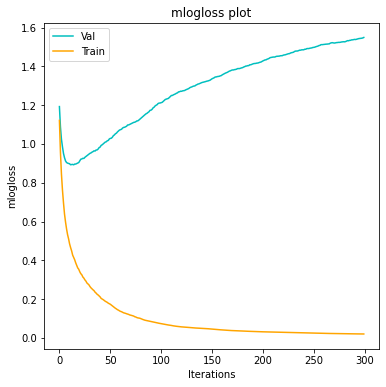

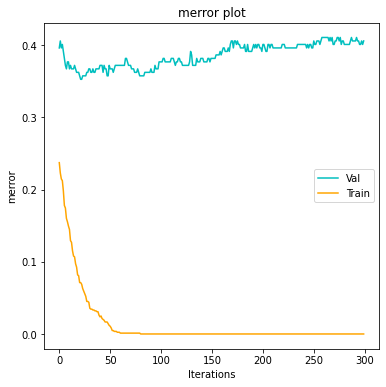

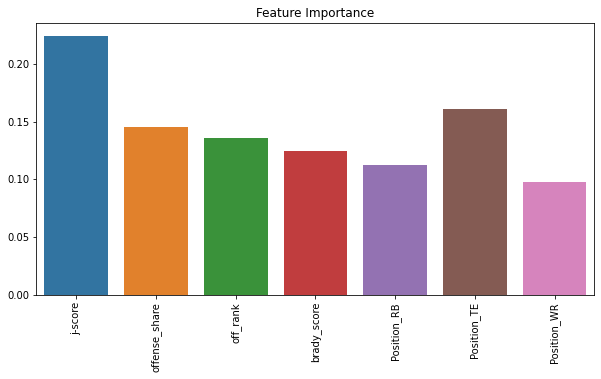

In [176]:
fitXgb(xgb1, training_data)

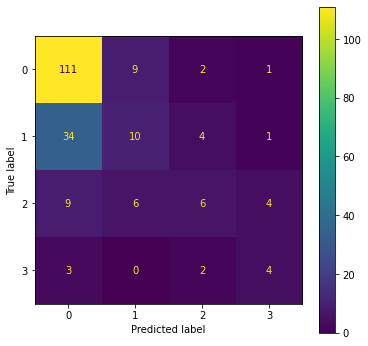

In [177]:
plot_confusion_matrix(xgb1,X_test,
                     Y_test,
                     values_format='d')

### Tune hyperparameters

In [178]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]
}

In [179]:
eval_set = [(X_val, Y_val)]

In [180]:
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_grid,scoring='f1_micro'
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch1.fit(X_train, Y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[20:21:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.31864
[1]	validation_0-mlogloss:1.26285
[2]	validation_0-mlogloss:1.21553
[3]	validation_0-mlogloss:1.17407
[4]	validation_0-mlogloss:1.13762
[5]	validation_0-mlogloss:1.10739
[20:21:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but

[70]	validation_0-mlogloss:0.88016
[60]	validation_0-mlogloss:0.87873
[47]	validation_0-mlogloss:0.85468
[71]	validation_0-mlogloss:0.88060
[47]	validation_0-mlogloss:0.88325
[61]	validation_0-mlogloss:0.87882
[48]	validation_0-mlogloss:0.85407
[72]	validation_0-mlogloss:0.87989
[48]	validation_0-mlogloss:0.88551
[53]	validation_0-mlogloss:0.89065
[54]	validation_0-mlogloss:0.89193
[38]	validation_0-mlogloss:0.86215
[60]	validation_0-mlogloss:0.85464
[62]	validation_0-mlogloss:0.90193
[55]	validation_0-mlogloss:0.89152
[39]	validation_0-mlogloss:0.86140
[61]	validation_0-mlogloss:0.85518
[63]	validation_0-mlogloss:0.90380
[52]	validation_0-mlogloss:0.87434
[64]	validation_0-mlogloss:0.90377
[62]	validation_0-mlogloss:0.85487
[73]	validation_0-mlogloss:0.88081
[49]	validation_0-mlogloss:0.85401
[53]	validation_0-mlogloss:0.87405
[74]	validation_0-mlogloss:0.88304
[50]	validation_0-mlogloss:0.85279
[54]	validation_0-mlogloss:0.87446
[75]	validation_0-mlogloss:0.88309
[49]	validation_0-ml

[91]	validation_0-mlogloss:0.86564
[99]	validation_0-mlogloss:0.87034
[92]	validation_0-mlogloss:0.86591
[99]	validation_0-mlogloss:0.94320
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.3s
[20:21:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.31390
[1]	validation_0-mlogloss:1.25362
[93]	validation_0-mlogloss:0.86676
[94]	validation_0-mlogloss:0.86778
[95]	validation_0-mlogloss:0.86939
[2]	validation_0-mlogloss:1.20303
[3]	validation_0-mlogloss:1.16017
[4]	validation_0-mlogloss:1.12342
[96]	validation_0-mlogloss

[85]	validation_0-mlogloss:0.87174
[86]	validation_0-mlogloss:0.87118
[87]	validation_0-mlogloss:0.87123
[64]	validation_0-mlogloss:0.85970
[81]	validation_0-mlogloss:0.86190
[88]	validation_0-mlogloss:0.87186
[89]	validation_0-mlogloss:0.87274
[82]	validation_0-mlogloss:0.86226
[90]	validation_0-mlogloss:0.87243
[83]	validation_0-mlogloss:0.86272
[76]	validation_0-mlogloss:0.86246
[77]	validation_0-mlogloss:0.86242
[78]	validation_0-mlogloss:0.86151
[61]	validation_0-mlogloss:0.85837
[88]	validation_0-mlogloss:0.87186
[62]	validation_0-mlogloss:0.85816
[89]	validation_0-mlogloss:0.87274
[63]	validation_0-mlogloss:0.85803
[90]	validation_0-mlogloss:0.87243
[64]	validation_0-mlogloss:0.85827
[86]	validation_0-mlogloss:0.87262
[91]	validation_0-mlogloss:0.87231
[46]	validation_0-mlogloss:0.91182
[78]	validation_0-mlogloss:0.86705
[79]	validation_0-mlogloss:0.86772
[47]	validation_0-mlogloss:0.91336
[87]	validation_0-mlogloss:0.87358
[65]	validation_0-mlogloss:0.86001
[48]	validation_0-ml

[86]	validation_0-mlogloss:0.96611
[1]	validation_0-mlogloss:1.25195
[2]	validation_0-mlogloss:1.20502
[3]	validation_0-mlogloss:1.16278
[4]	validation_0-mlogloss:1.12698
[4]	validation_0-mlogloss:1.12698
[5]	validation_0-mlogloss:1.09594
[87]	validation_0-mlogloss:0.96650
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   1.5s
[20:21:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.31849
[88]	validation_0-mlogloss:0.96902
[1]	validation_0-mlogloss:1.26181
[6]	validation_0-mlogloss:1.08077
[8]	validation_0-mlogloss:1

[34]	validation_0-mlogloss:0.90795
[27]	validation_0-mlogloss:0.91259
[32]	validation_0-mlogloss:0.88803
[35]	validation_0-mlogloss:0.90698
[28]	validation_0-mlogloss:0.91139
[33]	validation_0-mlogloss:0.88960
[29]	validation_0-mlogloss:0.91103
[30]	validation_0-mlogloss:0.91072
[16]	validation_0-mlogloss:0.94220
[16]	validation_0-mlogloss:0.92359
[17]	validation_0-mlogloss:0.93640
[17]	validation_0-mlogloss:0.92010
[37]	validation_0-mlogloss:0.89639
[31]	validation_0-mlogloss:0.89022
[30]	validation_0-mlogloss:0.89831
[18]	validation_0-mlogloss:0.93200
[31]	validation_0-mlogloss:0.89616
[32]	validation_0-mlogloss:0.88803
[18]	validation_0-mlogloss:0.91354
[32]	validation_0-mlogloss:0.89644
[38]	validation_0-mlogloss:0.89990
[36]	validation_0-mlogloss:0.90683
[34]	validation_0-mlogloss:0.88827
[39]	validation_0-mlogloss:0.90094
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.6s
[20:21:10] WARNING: /Users/runner/work/xgboost/xgboost/py

[54]	validation_0-mlogloss:0.92640
[55]	validation_0-mlogloss:0.92738
[38]	validation_0-mlogloss:0.89779
[67]	validation_0-mlogloss:0.89498
[39]	validation_0-mlogloss:0.89876
[40]	validation_0-mlogloss:0.89870
[71]	validation_0-mlogloss:0.95257
[68]	validation_0-mlogloss:0.89516
[72]	validation_0-mlogloss:0.95265
[69]	validation_0-mlogloss:0.89608
[51]	validation_0-mlogloss:0.89099
[66]	validation_0-mlogloss:0.89475
[52]	validation_0-mlogloss:0.89151
[74]	validation_0-mlogloss:0.94909
[67]	validation_0-mlogloss:0.89498
[62]	validation_0-mlogloss:0.93690
[75]	validation_0-mlogloss:0.95078
[63]	validation_0-mlogloss:0.93768
[67]	validation_0-mlogloss:0.94026
[76]	validation_0-mlogloss:0.95287
[64]	validation_0-mlogloss:0.93810
[68]	validation_0-mlogloss:0.94135
[73]	validation_0-mlogloss:0.95345
[69]	validation_0-mlogloss:0.94226
[70]	validation_0-mlogloss:0.89572
[71]	validation_0-mlogloss:0.89621
[74]	validation_0-mlogloss:0.95391
[53]	validation_0-mlogloss:0.89043
[75]	validation_0-ml

[94]	validation_0-mlogloss:0.98979
[90]	validation_0-mlogloss:0.92007
[95]	validation_0-mlogloss:0.99098
[91]	validation_0-mlogloss:0.91948
[92]	validation_0-mlogloss:0.92153
[93]	validation_0-mlogloss:0.92300
[94]	validation_0-mlogloss:0.92565
[95]	validation_0-mlogloss:0.92544
[82]	validation_0-mlogloss:0.93619
[96]	validation_0-mlogloss:0.92645
[83]	validation_0-mlogloss:0.93867
[97]	validation_0-mlogloss:0.92802
[84]	validation_0-mlogloss:0.94146
[96]	validation_0-mlogloss:0.99416
[97]	validation_0-mlogloss:0.99660
[98]	validation_0-mlogloss:0.99919
[85]	validation_0-mlogloss:0.94217
[86]	validation_0-mlogloss:0.94243
[87]	validation_0-mlogloss:0.94290
[99]	validation_0-mlogloss:0.99960
[98]	validation_0-mlogloss:0.92913
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.7s
[20:21:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weig

[6]	validation_0-mlogloss:1.09746
[26]	validation_0-mlogloss:0.90429
[15]	validation_0-mlogloss:0.93800
[36]	validation_0-mlogloss:0.89849
[7]	validation_0-mlogloss:1.07361
[27]	validation_0-mlogloss:0.90400
[8]	validation_0-mlogloss:1.05277
[26]	validation_0-mlogloss:0.89699
[33]	validation_0-mlogloss:0.89132
[27]	validation_0-mlogloss:0.89572
[34]	validation_0-mlogloss:0.89158
[28]	validation_0-mlogloss:0.89395
[23]	validation_0-mlogloss:0.91657
[35]	validation_0-mlogloss:0.89094
[24]	validation_0-mlogloss:0.91352
[28]	validation_0-mlogloss:0.90300
[25]	validation_0-mlogloss:0.91066
[15]	validation_0-mlogloss:0.93759
[26]	validation_0-mlogloss:0.90532
[29]	validation_0-mlogloss:0.90239
[33]	validation_0-mlogloss:0.89692
[27]	validation_0-mlogloss:0.90267
[16]	validation_0-mlogloss:0.92903
[37]	validation_0-mlogloss:0.89761
[34]	validation_0-mlogloss:0.89718
[17]	validation_0-mlogloss:0.92229
[16]	validation_0-mlogloss:0.93172
[29]	validation_0-mlogloss:0.87745
[38]	validation_0-mlogl

[49]	validation_0-mlogloss:0.90133
[41]	validation_0-mlogloss:0.87682
[68]	validation_0-mlogloss:0.91584
[68]	validation_0-mlogloss:0.90213
[50]	validation_0-mlogloss:0.90228
[42]	validation_0-mlogloss:0.87723
[69]	validation_0-mlogloss:0.91677
[69]	validation_0-mlogloss:0.90383
[58]	validation_0-mlogloss:0.90696
[69]	validation_0-mlogloss:0.91873
[43]	validation_0-mlogloss:0.87754
[70]	validation_0-mlogloss:0.91955
[59]	validation_0-mlogloss:0.90832
[71]	validation_0-mlogloss:0.92091
[60]	validation_0-mlogloss:0.90979
[60]	validation_0-mlogloss:0.91128
[61]	validation_0-mlogloss:0.91184
[48]	validation_0-mlogloss:0.89393
[62]	validation_0-mlogloss:0.91081
[49]	validation_0-mlogloss:0.89531
[71]	validation_0-mlogloss:0.87638
[60]	validation_0-mlogloss:0.89368
[70]	validation_0-mlogloss:0.90504
[72]	validation_0-mlogloss:0.87639
[44]	validation_0-mlogloss:0.87751
[61]	validation_0-mlogloss:0.89545
[71]	validation_0-mlogloss:0.90513
[73]	validation_0-mlogloss:0.87686
[45]	validation_0-ml

[77]	validation_0-mlogloss:0.88679
[96]	validation_0-mlogloss:0.95481
[78]	validation_0-mlogloss:0.88678
[97]	validation_0-mlogloss:0.95582
[79]	validation_0-mlogloss:0.88720
[83]	validation_0-mlogloss:0.93494
[80]	validation_0-mlogloss:0.88799
[81]	validation_0-mlogloss:0.88914
[84]	validation_0-mlogloss:0.93483
[92]	validation_0-mlogloss:0.91898
[81]	validation_0-mlogloss:0.90995
[93]	validation_0-mlogloss:0.92036
[97]	validation_0-mlogloss:0.95655
[82]	validation_0-mlogloss:0.91126
[94]	validation_0-mlogloss:0.92084
[98]	validation_0-mlogloss:0.95980
[95]	validation_0-mlogloss:0.92124
[98]	validation_0-mlogloss:0.95547
[85]	validation_0-mlogloss:0.93752
[83]	validation_0-mlogloss:0.91206
[99]	validation_0-mlogloss:0.95821
[99]	validation_0-mlogloss:0.96089
[84]	validation_0-mlogloss:0.91267
[86]	validation_0-mlogloss:0.93776
[85]	validation_0-mlogloss:0.91351
[87]	validation_0-mlogloss:0.94026
[96]	validation_0-mlogloss:0.92179
[82]	validation_0-mlogloss:0.88978
[97]	validation_0-ml

[4]	validation_0-mlogloss:1.14034
[10]	validation_0-mlogloss:1.00426
[29]	validation_0-mlogloss:0.89077
[22]	validation_0-mlogloss:0.91064
[5]	validation_0-mlogloss:1.11310
[23]	validation_0-mlogloss:0.90773
[33]	validation_0-mlogloss:0.87481
[34]	validation_0-mlogloss:0.87367
[22]	validation_0-mlogloss:0.89679
[25]	validation_0-mlogloss:0.88814
[23]	validation_0-mlogloss:0.89303
[26]	validation_0-mlogloss:0.88510
[24]	validation_0-mlogloss:0.88978
[32]	validation_0-mlogloss:0.87198
[16]	validation_0-mlogloss:0.93247
[4]	validation_0-mlogloss:1.12287
[11]	validation_0-mlogloss:0.98843
[17]	validation_0-mlogloss:0.92523
[33]	validation_0-mlogloss:0.87077
[12]	validation_0-mlogloss:0.97426
[30]	validation_0-mlogloss:0.88851
[6]	validation_0-mlogloss:1.08759
[31]	validation_0-mlogloss:0.88654
[34]	validation_0-mlogloss:0.87004
[24]	validation_0-mlogloss:0.90466
[7]	validation_0-mlogloss:1.06494
[32]	validation_0-mlogloss:0.88523
[35]	validation_0-mlogloss:0.87281
[25]	validation_0-mloglos

[64]	validation_0-mlogloss:0.88505
[46]	validation_0-mlogloss:0.86798
[55]	validation_0-mlogloss:0.86928
[47]	validation_0-mlogloss:0.86883
[56]	validation_0-mlogloss:0.86945
[48]	validation_0-mlogloss:0.86811
[57]	validation_0-mlogloss:0.87017
[64]	validation_0-mlogloss:0.87411
[65]	validation_0-mlogloss:0.88491
[58]	validation_0-mlogloss:0.88184
[65]	validation_0-mlogloss:0.87472
[32]	validation_0-mlogloss:0.92830
[55]	validation_0-mlogloss:0.86923
[59]	validation_0-mlogloss:0.88244
[33]	validation_0-mlogloss:0.92834
[29]	validation_0-mlogloss:0.91466
[56]	validation_0-mlogloss:0.86917
[60]	validation_0-mlogloss:0.88321
[30]	validation_0-mlogloss:0.91526
[57]	validation_0-mlogloss:0.86914
[65]	validation_0-mlogloss:0.87490
[34]	validation_0-mlogloss:0.92874
[61]	validation_0-mlogloss:0.88389
[31]	validation_0-mlogloss:0.91259
[35]	validation_0-mlogloss:0.92892
[62]	validation_0-mlogloss:0.88464
[66]	validation_0-mlogloss:0.87505
[63]	validation_0-mlogloss:0.88476
[32]	validation_0-ml

[87]	validation_0-mlogloss:0.88065
[96]	validation_0-mlogloss:0.88431
[75]	validation_0-mlogloss:0.88197
[63]	validation_0-mlogloss:0.97964
[76]	validation_0-mlogloss:0.88283
[97]	validation_0-mlogloss:0.88533
[89]	validation_0-mlogloss:0.89246
[98]	validation_0-mlogloss:0.88510
[90]	validation_0-mlogloss:0.89359
[55]	validation_0-mlogloss:0.92693
[94]	validation_0-mlogloss:0.89423
[56]	validation_0-mlogloss:0.92682
[79]	validation_0-mlogloss:0.87972
[98]	validation_0-mlogloss:0.90089
[95]	validation_0-mlogloss:0.89466
[88]	validation_0-mlogloss:0.88147
[80]	validation_0-mlogloss:0.87966
[96]	validation_0-mlogloss:0.89542
[99]	validation_0-mlogloss:0.90111
[89]	validation_0-mlogloss:0.88114
[77]	validation_0-mlogloss:0.88262
[78]	validation_0-mlogloss:0.88345
[99]	validation_0-mlogloss:0.88582
[64]	validation_0-mlogloss:0.98090
[91]	validation_0-mlogloss:0.89463
[65]	validation_0-mlogloss:0.98493
[92]	validation_0-mlogloss:0.89580
[57]	validation_0-mlogloss:0.93053
[81]	validation_0-ml

[21]	validation_0-mlogloss:0.93169
[13]	validation_0-mlogloss:0.98057
[18]	validation_0-mlogloss:0.93407
[14]	validation_0-mlogloss:0.97315
[5]	validation_0-mlogloss:1.10238
[15]	validation_0-mlogloss:0.95230
[6]	validation_0-mlogloss:1.07428
[16]	validation_0-mlogloss:0.94674
[7]	validation_0-mlogloss:1.05051
[3]	validation_0-mlogloss:1.17350
[12]	validation_0-mlogloss:0.97086
[4]	validation_0-mlogloss:1.13987
[20]	validation_0-mlogloss:0.94451
[98]	validation_0-mlogloss:0.98952
[19]	validation_0-mlogloss:0.93011
[21]	validation_0-mlogloss:0.94225
[22]	validation_0-mlogloss:0.92976
[99]	validation_0-mlogloss:0.99105
[23]	validation_0-mlogloss:0.92921
[20]	validation_0-mlogloss:0.92586
[15]	validation_0-mlogloss:0.96440
[17]	validation_0-mlogloss:0.94158
[22]	validation_0-mlogloss:0.94017
[16]	validation_0-mlogloss:0.96002
[18]	validation_0-mlogloss:0.93689
[23]	validation_0-mlogloss:0.93823
[21]	validation_0-mlogloss:0.92337
[19]	validation_0-mlogloss:0.93467
[24]	validation_0-mloglos

[9]	validation_0-mlogloss:1.01393
[17]	validation_0-mlogloss:0.93404
[39]	validation_0-mlogloss:0.91154
[34]	validation_0-mlogloss:0.93470
[10]	validation_0-mlogloss:0.99643
[18]	validation_0-mlogloss:0.92876
[11]	validation_0-mlogloss:0.98444
[45]	validation_0-mlogloss:0.94000
[53]	validation_0-mlogloss:0.95508
[46]	validation_0-mlogloss:0.94063
[54]	validation_0-mlogloss:0.95750
[48]	validation_0-mlogloss:0.92190
[49]	validation_0-mlogloss:0.92294
[50]	validation_0-mlogloss:0.92332
[40]	validation_0-mlogloss:0.91278
[47]	validation_0-mlogloss:0.94863
[37]	validation_0-mlogloss:0.91142
[51]	validation_0-mlogloss:0.92515
[38]	validation_0-mlogloss:0.91359
[41]	validation_0-mlogloss:0.91539
[48]	validation_0-mlogloss:0.94979
[52]	validation_0-mlogloss:0.96102
[39]	validation_0-mlogloss:0.91386
[19]	validation_0-mlogloss:0.92542
[40]	validation_0-mlogloss:0.91376
[53]	validation_0-mlogloss:0.96222
[47]	validation_0-mlogloss:0.94287
[20]	validation_0-mlogloss:0.92206
[12]	validation_0-mlo

[33]	validation_0-mlogloss:0.90755
[61]	validation_0-mlogloss:0.93308
[62]	validation_0-mlogloss:0.93750
[69]	validation_0-mlogloss:1.00071
[63]	validation_0-mlogloss:0.93795
[70]	validation_0-mlogloss:0.99163
[41]	validation_0-mlogloss:0.91500
[70]	validation_0-mlogloss:1.00148
[71]	validation_0-mlogloss:0.99441
[71]	validation_0-mlogloss:1.00256
[56]	validation_0-mlogloss:0.96703
[72]	validation_0-mlogloss:1.00564
[42]	validation_0-mlogloss:0.91580
[71]	validation_0-mlogloss:0.94875
[72]	validation_0-mlogloss:0.94965
[62]	validation_0-mlogloss:0.93419
[79]	validation_0-mlogloss:1.01470
[57]	validation_0-mlogloss:0.97030
[80]	validation_0-mlogloss:1.01641
[63]	validation_0-mlogloss:0.93343
[34]	validation_0-mlogloss:0.90948
[72]	validation_0-mlogloss:0.99838
[64]	validation_0-mlogloss:0.93375
[76]	validation_0-mlogloss:1.01464
[35]	validation_0-mlogloss:0.91034
[73]	validation_0-mlogloss:1.00142
[73]	validation_0-mlogloss:0.94920
[58]	validation_0-mlogloss:0.97427
[77]	validation_0-ml

[95]	validation_0-mlogloss:0.98165
[59]	validation_0-mlogloss:0.93643
[96]	validation_0-mlogloss:0.98383
[97]	validation_0-mlogloss:0.98706
[87]	validation_0-mlogloss:0.97153
[94]	validation_0-mlogloss:1.06701
[95]	validation_0-mlogloss:1.06995
[96]	validation_0-mlogloss:1.05273
[88]	validation_0-mlogloss:0.97182
[97]	validation_0-mlogloss:1.05432
[63]	validation_0-mlogloss:0.92115
[81]	validation_0-mlogloss:1.02856
[82]	validation_0-mlogloss:1.03078
[64]	validation_0-mlogloss:0.92252
[90]	validation_0-mlogloss:0.98846
[60]	validation_0-mlogloss:0.93755
[91]	validation_0-mlogloss:0.99020
[61]	validation_0-mlogloss:0.93966
[96]	validation_0-mlogloss:1.07264
[98]	validation_0-mlogloss:1.05536
[99]	validation_0-mlogloss:1.05471
[97]	validation_0-mlogloss:1.07309
[98]	validation_0-mlogloss:1.07682
[98]	validation_0-mlogloss:0.98952
[89]	validation_0-mlogloss:0.97320
[99]	validation_0-mlogloss:1.07956
[90]	validation_0-mlogloss:0.97420
[91]	validation_0-mlogloss:0.97672
[99]	validation_0-ml

[7]	validation_0-mlogloss:1.05093
[10]	validation_0-mlogloss:0.99643
[8]	validation_0-mlogloss:1.03089
[91]	validation_0-mlogloss:0.98069
[15]	validation_0-mlogloss:0.95430
[12]	validation_0-mlogloss:0.97342
[92]	validation_0-mlogloss:0.98182
[16]	validation_0-mlogloss:0.94720
[11]	validation_0-mlogloss:0.99859
[4]	validation_0-mlogloss:1.13456
[17]	validation_0-mlogloss:0.94167
[13]	validation_0-mlogloss:0.96353
[12]	validation_0-mlogloss:0.98391
[3]	validation_0-mlogloss:1.18783
[96]	validation_0-mlogloss:0.95589
[5]	validation_0-mlogloss:1.10422
[4]	validation_0-mlogloss:1.15368
[97]	validation_0-mlogloss:0.95771
[11]	validation_0-mlogloss:0.98444
[9]	validation_0-mlogloss:1.01330
[12]	validation_0-mlogloss:0.97283
[10]	validation_0-mlogloss:0.99823
[93]	validation_0-mlogloss:0.98416
[13]	validation_0-mlogloss:0.97355
[18]	validation_0-mlogloss:0.93620
[94]	validation_0-mlogloss:0.98564
[14]	validation_0-mlogloss:0.96296
[19]	validation_0-mlogloss:0.93280
[14]	validation_0-mlogloss:

[19]	validation_0-mlogloss:0.91908
[27]	validation_0-mlogloss:0.90674
[42]	validation_0-mlogloss:0.91667
[33]	validation_0-mlogloss:0.90755
[43]	validation_0-mlogloss:0.91715
[28]	validation_0-mlogloss:0.90477
[34]	validation_0-mlogloss:0.90948
[44]	validation_0-mlogloss:0.91732
[37]	validation_0-mlogloss:0.91142
[28]	validation_0-mlogloss:0.90680
[32]	validation_0-mlogloss:0.91122
[3]	validation_0-mlogloss:1.18096
[38]	validation_0-mlogloss:0.91359
[29]	validation_0-mlogloss:0.90593
[33]	validation_0-mlogloss:0.91186
[4]	validation_0-mlogloss:1.14621
[20]	validation_0-mlogloss:0.91441
[35]	validation_0-mlogloss:0.91248
[39]	validation_0-mlogloss:0.91386
[29]	validation_0-mlogloss:0.90368
[36]	validation_0-mlogloss:0.91184
[30]	validation_0-mlogloss:0.90230
[45]	validation_0-mlogloss:0.91824
[35]	validation_0-mlogloss:0.91034
[31]	validation_0-mlogloss:0.90093
[46]	validation_0-mlogloss:0.91776
[36]	validation_0-mlogloss:0.91164
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lam

[59]	validation_0-mlogloss:0.92124
[60]	validation_0-mlogloss:0.92063
[61]	validation_0-mlogloss:0.92086
[73]	validation_0-mlogloss:0.95525
[60]	validation_0-mlogloss:0.93755
[69]	validation_0-mlogloss:0.94961
[43]	validation_0-mlogloss:0.87616
[74]	validation_0-mlogloss:0.95661
[70]	validation_0-mlogloss:0.95230
[44]	validation_0-mlogloss:0.87616
[61]	validation_0-mlogloss:0.93966
[30]	validation_0-mlogloss:0.88930
[26]	validation_0-mlogloss:0.90912
[56]	validation_0-mlogloss:0.90742
[55]	validation_0-mlogloss:0.93197
[31]	validation_0-mlogloss:0.88769
[27]	validation_0-mlogloss:0.90674
[56]	validation_0-mlogloss:0.93428
[57]	validation_0-mlogloss:0.90735
[32]	validation_0-mlogloss:0.88652
[33]	validation_0-mlogloss:0.88559
[75]	validation_0-mlogloss:0.95866
[62]	validation_0-mlogloss:0.94040
[76]	validation_0-mlogloss:0.96182
[34]	validation_0-mlogloss:0.88480
[63]	validation_0-mlogloss:0.94297
[62]	validation_0-mlogloss:0.92128
[71]	validation_0-mlogloss:0.95296
[45]	validation_0-ml

[59]	validation_0-mlogloss:0.89365
[88]	validation_0-mlogloss:0.97611
[60]	validation_0-mlogloss:0.89374
[89]	validation_0-mlogloss:0.97861
[54]	validation_0-mlogloss:0.90583
[85]	validation_0-mlogloss:0.92110
[55]	validation_0-mlogloss:0.90677
[86]	validation_0-mlogloss:0.92210
[85]	validation_0-mlogloss:0.97230
[89]	validation_0-mlogloss:0.95031
[86]	validation_0-mlogloss:0.97403
[90]	validation_0-mlogloss:0.95114
[88]	validation_0-mlogloss:0.94896
[70]	validation_0-mlogloss:0.87976
[89]	validation_0-mlogloss:0.95031
[71]	validation_0-mlogloss:0.87972
[72]	validation_0-mlogloss:0.87940
[73]	validation_0-mlogloss:0.88000
[90]	validation_0-mlogloss:0.97897
[91]	validation_0-mlogloss:0.98069
[56]	validation_0-mlogloss:0.90742
[57]	validation_0-mlogloss:0.90735
[87]	validation_0-mlogloss:0.92221
[88]	validation_0-mlogloss:0.92286
[61]	validation_0-mlogloss:0.89428
[91]	validation_0-mlogloss:0.95245
[62]	validation_0-mlogloss:0.89572
[92]	validation_0-mlogloss:0.95298
[87]	validation_0-ml

[7]	validation_0-mlogloss:1.07409
[20]	validation_0-mlogloss:0.91441
[93]	validation_0-mlogloss:0.92342
[8]	validation_0-mlogloss:1.05366
[5]	validation_0-mlogloss:1.34620
[94]	validation_0-mlogloss:0.92355
[21]	validation_0-mlogloss:0.91224
[6]	validation_0-mlogloss:1.33998
[5]	validation_0-mlogloss:1.10782
[1]	validation_0-mlogloss:1.37112
[7]	validation_0-mlogloss:1.33383
[2]	validation_0-mlogloss:1.36377
[22]	validation_0-mlogloss:0.90803
[6]	validation_0-mlogloss:1.08201
[4]	validation_0-mlogloss:1.14621
[3]	validation_0-mlogloss:1.35655
[8]	validation_0-mlogloss:1.32781
[23]	validation_0-mlogloss:0.90457
[21]	validation_0-mlogloss:0.91031
[9]	validation_0-mlogloss:1.03535
[5]	validation_0-mlogloss:1.11728
[99]	validation_0-mlogloss:0.93878
[22]	validation_0-mlogloss:0.90666
[10]	validation_0-mlogloss:1.01954
[6]	validation_0-mlogloss:1.09139
[95]	validation_0-mlogloss:0.92354
[9]	validation_0-mlogloss:1.32184
[7]	validation_0-mlogloss:1.05864
[10]	validation_0-mlogloss:1.31597
[9

[11]	validation_0-mlogloss:1.31027
[37]	validation_0-mlogloss:0.89495
[12]	validation_0-mlogloss:1.30459
[31]	validation_0-mlogloss:0.88626
[50]	validation_0-mlogloss:0.88857
[38]	validation_0-mlogloss:0.89470
[46]	validation_0-mlogloss:0.87607
[32]	validation_0-mlogloss:0.88437
[47]	validation_0-mlogloss:0.87673
[39]	validation_0-mlogloss:0.89524
[51]	validation_0-mlogloss:0.88946
[51]	validation_0-mlogloss:1.13746
[40]	validation_0-mlogloss:0.89538
[52]	validation_0-mlogloss:1.13429
[13]	validation_0-mlogloss:1.29903
[35]	validation_0-mlogloss:0.88411
[10]	validation_0-mlogloss:1.30935
[53]	validation_0-mlogloss:1.13121
[14]	validation_0-mlogloss:1.29360
[36]	validation_0-mlogloss:0.88397
[15]	validation_0-mlogloss:1.28824
[11]	validation_0-mlogloss:1.30304
[43]	validation_0-mlogloss:1.14789
[26]	validation_0-mlogloss:1.22324
[12]	validation_0-mlogloss:1.29686
[27]	validation_0-mlogloss:1.21858
[44]	validation_0-mlogloss:1.14421
[33]	validation_0-mlogloss:0.88294
[45]	validation_0-ml

[51]	validation_0-mlogloss:1.12500
[69]	validation_0-mlogloss:1.06680
[70]	validation_0-mlogloss:1.06419
[41]	validation_0-mlogloss:1.17171
[71]	validation_0-mlogloss:1.06165
[42]	validation_0-mlogloss:1.16799
[43]	validation_0-mlogloss:1.16433
[54]	validation_0-mlogloss:0.89197
[58]	validation_0-mlogloss:0.90782
[55]	validation_0-mlogloss:0.89286
[36]	validation_0-mlogloss:1.17532
[59]	validation_0-mlogloss:0.90876
[37]	validation_0-mlogloss:1.17123
[70]	validation_0-mlogloss:0.90367
[50]	validation_0-mlogloss:0.87505
[81]	validation_0-mlogloss:1.05890
[71]	validation_0-mlogloss:0.90451
[82]	validation_0-mlogloss:1.05677
[38]	validation_0-mlogloss:1.16723
[65]	validation_0-mlogloss:0.87868
[52]	validation_0-mlogloss:1.12178
[83]	validation_0-mlogloss:1.05475
[53]	validation_0-mlogloss:1.11845
[72]	validation_0-mlogloss:1.05907
[44]	validation_0-mlogloss:1.16084
[66]	validation_0-mlogloss:0.87852
[54]	validation_0-mlogloss:1.11530
[45]	validation_0-mlogloss:1.15746
[73]	validation_0-ml

[81]	validation_0-mlogloss:1.04138
[67]	validation_0-mlogloss:1.07200
[82]	validation_0-mlogloss:1.03903
[68]	validation_0-mlogloss:1.06939
[86]	validation_0-mlogloss:0.88502
[69]	validation_0-mlogloss:1.06680
[70]	validation_0-mlogloss:1.06419
[87]	validation_0-mlogloss:0.88602
[71]	validation_0-mlogloss:1.06165
[84]	validation_0-mlogloss:0.92098
[85]	validation_0-mlogloss:0.92110
[94]	validation_0-mlogloss:0.93042
[95]	validation_0-mlogloss:0.93220
[72]	validation_0-mlogloss:0.87940
[76]	validation_0-mlogloss:0.90817
[73]	validation_0-mlogloss:0.88000
[83]	validation_0-mlogloss:1.03695
[77]	validation_0-mlogloss:0.90977
[77]	validation_0-mlogloss:1.06766
[88]	validation_0-mlogloss:0.88608
[84]	validation_0-mlogloss:1.03471
[78]	validation_0-mlogloss:1.06552
[86]	validation_0-mlogloss:0.92210
[85]	validation_0-mlogloss:1.03252
[79]	validation_0-mlogloss:1.06321
[87]	validation_0-mlogloss:0.92221
[89]	validation_0-mlogloss:0.88745
[80]	validation_0-mlogloss:1.06103
[96]	validation_0-ml

[8]	validation_0-mlogloss:1.32222
[16]	validation_0-mlogloss:1.28296
[28]	validation_0-mlogloss:1.21397
[17]	validation_0-mlogloss:1.27778
[29]	validation_0-mlogloss:1.20947
[18]	validation_0-mlogloss:1.27268
[99]	validation_0-mlogloss:0.89739
[9]	validation_0-mlogloss:1.31572
[19]	validation_0-mlogloss:1.26767
[20]	validation_0-mlogloss:1.26268
[30]	validation_0-mlogloss:1.20492
[10]	validation_0-mlogloss:1.30935
[31]	validation_0-mlogloss:1.20061
[21]	validation_0-mlogloss:1.25778
[32]	validation_0-mlogloss:1.19630
[11]	validation_0-mlogloss:1.30304
[22]	validation_0-mlogloss:1.25300
[12]	validation_0-mlogloss:1.29686
[13]	validation_0-mlogloss:1.29081
[23]	validation_0-mlogloss:1.24814
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.9s
[20:21:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This cou

[7]	validation_0-mlogloss:1.33438
[51]	validation_0-mlogloss:1.12500
[14]	validation_0-mlogloss:1.28683
[15]	validation_0-mlogloss:1.28106
[8]	validation_0-mlogloss:1.32839
[45]	validation_0-mlogloss:1.15746
[30]	validation_0-mlogloss:1.20134
[46]	validation_0-mlogloss:1.15400
[47]	validation_0-mlogloss:1.15050
[31]	validation_0-mlogloss:1.19686
[12]	validation_0-mlogloss:1.29984
[32]	validation_0-mlogloss:1.19234
[13]	validation_0-mlogloss:1.29390
[16]	validation_0-mlogloss:1.27502
[14]	validation_0-mlogloss:1.28817
[2]	validation_0-mlogloss:1.36425
[15]	validation_0-mlogloss:1.28243
[17]	validation_0-mlogloss:1.26943
[3]	validation_0-mlogloss:1.35717
[16]	validation_0-mlogloss:1.27683
[21]	validation_0-mlogloss:1.25869
[18]	validation_0-mlogloss:1.26393
[4]	validation_0-mlogloss:1.35021
[17]	validation_0-mlogloss:1.27128
[22]	validation_0-mlogloss:1.25394
[52]	validation_0-mlogloss:1.12178
[23]	validation_0-mlogloss:1.24924
[53]	validation_0-mlogloss:1.11845
[16]	validation_0-mloglos

[43]	validation_0-mlogloss:1.15467
[74]	validation_0-mlogloss:1.07446
[44]	validation_0-mlogloss:1.15102
[75]	validation_0-mlogloss:1.07218
[45]	validation_0-mlogloss:1.14738
[77]	validation_0-mlogloss:1.05080
[17]	validation_0-mlogloss:1.27128
[43]	validation_0-mlogloss:1.15265
[44]	validation_0-mlogloss:1.14895
[38]	validation_0-mlogloss:1.17079
[18]	validation_0-mlogloss:1.26592
[19]	validation_0-mlogloss:1.26054
[39]	validation_0-mlogloss:1.16680
[56]	validation_0-mlogloss:1.10362
[40]	validation_0-mlogloss:1.16291
[57]	validation_0-mlogloss:1.10055
[31]	validation_0-mlogloss:1.20027
[58]	validation_0-mlogloss:1.09754
[48]	validation_0-mlogloss:1.14987
[32]	validation_0-mlogloss:1.19585
[41]	validation_0-mlogloss:1.15904
[49]	validation_0-mlogloss:1.14656
[33]	validation_0-mlogloss:1.19153
[50]	validation_0-mlogloss:1.14331
[42]	validation_0-mlogloss:1.15525
[45]	validation_0-mlogloss:1.14540
[78]	validation_0-mlogloss:1.04852
[43]	validation_0-mlogloss:1.15153
[38]	validation_0-ml

[80]	validation_0-mlogloss:1.06259
[77]	validation_0-mlogloss:1.05102
[81]	validation_0-mlogloss:1.06039
[82]	validation_0-mlogloss:1.05826
[78]	validation_0-mlogloss:1.04867
[73]	validation_0-mlogloss:1.06047
[54]	validation_0-mlogloss:1.11638
[74]	validation_0-mlogloss:1.05801
[78]	validation_0-mlogloss:1.04852
[75]	validation_0-mlogloss:1.05554
[72]	validation_0-mlogloss:1.08102
[62]	validation_0-mlogloss:1.08966
[76]	validation_0-mlogloss:1.05317
[73]	validation_0-mlogloss:1.07862
[77]	validation_0-mlogloss:1.05079
[63]	validation_0-mlogloss:1.08689
[79]	validation_0-mlogloss:1.04609
[74]	validation_0-mlogloss:1.07629
[64]	validation_0-mlogloss:1.08402
[80]	validation_0-mlogloss:1.04362
[75]	validation_0-mlogloss:1.07386
[83]	validation_0-mlogloss:1.05619
[79]	validation_0-mlogloss:1.04621
[84]	validation_0-mlogloss:1.05401
[80]	validation_0-mlogloss:1.04396
[85]	validation_0-mlogloss:1.05200
[81]	validation_0-mlogloss:1.04147
[81]	validation_0-mlogloss:1.04138
[55]	validation_0-ml

[21]	validation_0-mlogloss:1.24834
[95]	validation_0-mlogloss:1.01266
[19]	validation_0-mlogloss:1.26852
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   2.0s
[20:21:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37895
[20]	validation_0-mlogloss:1.26364
[1]	validation_0-mlogloss:1.37174
[21]	validation_0-mlogloss:1.25869
[89]	validation_0-mlogloss:1.02409
[90]	validation_0-mlogloss:1.02191
[22]	validation_0-mlogloss:1.24320
[91]	validation_0-mlogloss:1.01981
[96]	validation_0-mlogloss:1.01081
[23]	validation_0-mlog

[6]	validation_0-mlogloss:1.34075
[16]	validation_0-mlogloss:1.29109
[7]	validation_0-mlogloss:1.33464
[17]	validation_0-mlogloss:1.28614
[18]	validation_0-mlogloss:1.28133
[47]	validation_0-mlogloss:1.15328
[48]	validation_0-mlogloss:1.14987
[7]	validation_0-mlogloss:1.33502
[8]	validation_0-mlogloss:1.33294
[49]	validation_0-mlogloss:1.14656
[8]	validation_0-mlogloss:1.32907
[50]	validation_0-mlogloss:1.14331
[9]	validation_0-mlogloss:1.32745
[25]	validation_0-mlogloss:1.23048
[51]	validation_0-mlogloss:1.14007
[9]	validation_0-mlogloss:1.32330
[10]	validation_0-mlogloss:1.32203
[26]	validation_0-mlogloss:1.22572
[52]	validation_0-mlogloss:1.13686
[16]	validation_0-mlogloss:1.28386
[8]	validation_0-mlogloss:1.32862
[9]	validation_0-mlogloss:1.32274
[17]	validation_0-mlogloss:1.27866
[18]	validation_0-mlogloss:1.27349
[19]	validation_0-mlogloss:1.27654
[10]	validation_0-mlogloss:1.31761
[20]	validation_0-mlogloss:1.27182
[11]	validation_0-mlogloss:1.31670
[21]	validation_0-mlogloss:1.

[39]	validation_0-mlogloss:1.19405
[46]	validation_0-mlogloss:1.15471
[34]	validation_0-mlogloss:1.20030
[40]	validation_0-mlogloss:1.19050
[77]	validation_0-mlogloss:1.05079
[47]	validation_0-mlogloss:1.15124
[35]	validation_0-mlogloss:1.19624
[41]	validation_0-mlogloss:1.18692
[78]	validation_0-mlogloss:1.04848
[36]	validation_0-mlogloss:1.19223
[79]	validation_0-mlogloss:1.06479
[80]	validation_0-mlogloss:1.06259
[42]	validation_0-mlogloss:1.18345
[81]	validation_0-mlogloss:1.06039
[82]	validation_0-mlogloss:1.05826
[37]	validation_0-mlogloss:1.18824
[38]	validation_0-mlogloss:1.18433
[83]	validation_0-mlogloss:1.05619
[39]	validation_0-mlogloss:1.18045
[84]	validation_0-mlogloss:1.05401
[54]	validation_0-mlogloss:1.11638
[50]	validation_0-mlogloss:1.15704
[38]	validation_0-mlogloss:1.18749
[55]	validation_0-mlogloss:1.11307
[39]	validation_0-mlogloss:1.18371
[51]	validation_0-mlogloss:1.15388
[27]	validation_0-mlogloss:1.23267
[56]	validation_0-mlogloss:1.10988
[52]	validation_0-ml

[76]	validation_0-mlogloss:1.08706
[89]	validation_0-mlogloss:1.05929
[77]	validation_0-mlogloss:1.08482
[88]	validation_0-mlogloss:1.02609
[78]	validation_0-mlogloss:1.08251
[67]	validation_0-mlogloss:1.09001
[89]	validation_0-mlogloss:1.02409
[56]	validation_0-mlogloss:1.13876
[68]	validation_0-mlogloss:1.08734
[90]	validation_0-mlogloss:1.02191
[57]	validation_0-mlogloss:1.13592
[69]	validation_0-mlogloss:1.08473
[58]	validation_0-mlogloss:1.13298
[82]	validation_0-mlogloss:1.05304
[83]	validation_0-mlogloss:1.05081
[79]	validation_0-mlogloss:1.08028
[90]	validation_0-mlogloss:1.05734
[91]	validation_0-mlogloss:1.01981
[76]	validation_0-mlogloss:1.07091
[80]	validation_0-mlogloss:1.07811
[91]	validation_0-mlogloss:1.05535
[81]	validation_0-mlogloss:1.07587
[92]	validation_0-mlogloss:1.01793
[77]	validation_0-mlogloss:1.06845
[92]	validation_0-mlogloss:1.05342
[93]	validation_0-mlogloss:1.01579
[59]	validation_0-mlogloss:1.13010
[60]	validation_0-mlogloss:1.12736
[70]	validation_0-ml

[20]	validation_0-mlogloss:1.26344
[21]	validation_0-mlogloss:1.25851
[94]	validation_0-mlogloss:1.03162
[22]	validation_0-mlogloss:1.25367
[95]	validation_0-mlogloss:1.02965
[99]	validation_0-mlogloss:1.01824
[92]	validation_0-mlogloss:1.05342
[18]	validation_0-mlogloss:1.27486
[93]	validation_0-mlogloss:1.05149
[19]	validation_0-mlogloss:1.26984
[94]	validation_0-mlogloss:1.04953
[20]	validation_0-mlogloss:1.26511
[21]	validation_0-mlogloss:1.26022
[22]	validation_0-mlogloss:1.25542
[23]	validation_0-mlogloss:1.25065
[96]	validation_0-mlogloss:1.02778
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.5s
[20:21:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or 

[15]	validation_0-mlogloss:1.28691
[22]	validation_0-mlogloss:1.25131
[21]	validation_0-mlogloss:1.24784
[16]	validation_0-mlogloss:1.28164
[12]	validation_0-mlogloss:1.30096
[23]	validation_0-mlogloss:1.24650
[10]	validation_0-mlogloss:1.30958
[22]	validation_0-mlogloss:1.24292
[52]	validation_0-mlogloss:1.13443
[13]	validation_0-mlogloss:1.29520
[11]	validation_0-mlogloss:1.30337
[53]	validation_0-mlogloss:1.13117
[1]	validation_0-mlogloss:1.37225
[23]	validation_0-mlogloss:1.23791
[54]	validation_0-mlogloss:1.12799
[2]	validation_0-mlogloss:1.36540
[55]	validation_0-mlogloss:1.12481
[24]	validation_0-mlogloss:1.23322
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   1.3s
[20:21:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language 

[48]	validation_0-mlogloss:1.13767
[40]	validation_0-mlogloss:1.17238
[41]	validation_0-mlogloss:1.16873
[87]	validation_0-mlogloss:1.04587
[35]	validation_0-mlogloss:1.18492
[88]	validation_0-mlogloss:1.04373
[36]	validation_0-mlogloss:1.18092
[89]	validation_0-mlogloss:1.04171
[85]	validation_0-mlogloss:1.04640
[42]	validation_0-mlogloss:1.16871
[37]	validation_0-mlogloss:1.17690
[90]	validation_0-mlogloss:1.03960
[86]	validation_0-mlogloss:1.04421
[24]	validation_0-mlogloss:1.23322
[43]	validation_0-mlogloss:1.16527
[87]	validation_0-mlogloss:1.04208
[33]	validation_0-mlogloss:1.19943
[44]	validation_0-mlogloss:1.16193
[25]	validation_0-mlogloss:1.22849
[34]	validation_0-mlogloss:1.19857
[55]	validation_0-mlogloss:1.12765
[35]	validation_0-mlogloss:1.19461
[56]	validation_0-mlogloss:1.12473
[49]	validation_0-mlogloss:1.13439
[34]	validation_0-mlogloss:1.19545
[36]	validation_0-mlogloss:1.19066
[57]	validation_0-mlogloss:1.12189
[50]	validation_0-mlogloss:1.13108
[42]	validation_0-ml

[70]	validation_0-mlogloss:1.08791
[81]	validation_0-mlogloss:1.04889
[66]	validation_0-mlogloss:1.09298
[71]	validation_0-mlogloss:1.08042
[82]	validation_0-mlogloss:1.04672
[72]	validation_0-mlogloss:1.07800
[83]	validation_0-mlogloss:1.04459
[69]	validation_0-mlogloss:1.07776
[57]	validation_0-mlogloss:1.10985
[70]	validation_0-mlogloss:1.07520
[79]	validation_0-mlogloss:1.06729
[4]	validation_0-mlogloss:1.35310
[58]	validation_0-mlogloss:1.10711
[71]	validation_0-mlogloss:1.07262
[80]	validation_0-mlogloss:1.06526
[5]	validation_0-mlogloss:1.34683
[90]	validation_0-mlogloss:1.04579
[72]	validation_0-mlogloss:1.06993
[91]	validation_0-mlogloss:1.04424
[73]	validation_0-mlogloss:1.06748
[81]	validation_0-mlogloss:1.06307
[71]	validation_0-mlogloss:1.08549
[67]	validation_0-mlogloss:1.09041
[73]	validation_0-mlogloss:1.07536
[92]	validation_0-mlogloss:1.04248
[72]	validation_0-mlogloss:1.08305
[68]	validation_0-mlogloss:1.08788
[59]	validation_0-mlogloss:1.10436
[73]	validation_0-mlog

[99]	validation_0-mlogloss:1.03056
[29]	validation_0-mlogloss:1.21611
[91]	validation_0-mlogloss:1.03616
[33]	validation_0-mlogloss:1.20736
[92]	validation_0-mlogloss:1.03417
[34]	validation_0-mlogloss:1.20346
[30]	validation_0-mlogloss:1.21182
[35]	validation_0-mlogloss:1.19961
[31]	validation_0-mlogloss:1.20768
[98]	validation_0-mlogloss:1.01632
[83]	validation_0-mlogloss:1.04459
[99]	validation_0-mlogloss:1.01453
[84]	validation_0-mlogloss:1.04259
[93]	validation_0-mlogloss:1.03225
[94]	validation_0-mlogloss:1.03050
[32]	validation_0-mlogloss:1.20366
[33]	validation_0-mlogloss:1.19943
[36]	validation_0-mlogloss:1.19584
[37]	validation_0-mlogloss:1.19201
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.8s
[20:21:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some pa

[66]	validation_0-mlogloss:1.09298
[12]	validation_0-mlogloss:1.29834
[72]	validation_0-mlogloss:1.08649
[67]	validation_0-mlogloss:1.09041
[13]	validation_0-mlogloss:1.29246
[68]	validation_0-mlogloss:1.08788
[5]	validation_0-mlogloss:1.34303
[73]	validation_0-mlogloss:1.08408
[6]	validation_0-mlogloss:1.33631
[74]	validation_0-mlogloss:1.08175
[17]	validation_0-mlogloss:1.27308
[16]	validation_0-mlogloss:1.28472
[7]	validation_0-mlogloss:1.32974
[25]	validation_0-mlogloss:1.24112
[18]	validation_0-mlogloss:1.26778
[17]	validation_0-mlogloss:1.27959
[33]	validation_0-mlogloss:1.19528
[26]	validation_0-mlogloss:1.23669
[19]	validation_0-mlogloss:1.26256
[23]	validation_0-mlogloss:1.24244
[34]	validation_0-mlogloss:1.19116
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   2.1s
[20:21:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight

[96]	validation_0-mlogloss:1.02673
[43]	validation_0-mlogloss:1.15645
[53]	validation_0-mlogloss:1.12476
[44]	validation_0-mlogloss:1.15279
[54]	validation_0-mlogloss:1.12163
[45]	validation_0-mlogloss:1.14941
[47]	validation_0-mlogloss:1.15702
[48]	validation_0-mlogloss:1.15386
[49]	validation_0-mlogloss:1.15064
[56]	validation_0-mlogloss:1.12937
[50]	validation_0-mlogloss:1.14743
[47]	validation_0-mlogloss:1.14460
[61]	validation_0-mlogloss:1.10063
[57]	validation_0-mlogloss:1.12637
[48]	validation_0-mlogloss:1.14123
[62]	validation_0-mlogloss:1.09782
[58]	validation_0-mlogloss:1.12350
[49]	validation_0-mlogloss:1.13788
[63]	validation_0-mlogloss:1.09494
[29]	validation_0-mlogloss:1.21458
[37]	validation_0-mlogloss:1.17890
[64]	validation_0-mlogloss:1.09240
[30]	validation_0-mlogloss:1.21026
[38]	validation_0-mlogloss:1.17498
[65]	validation_0-mlogloss:1.08958
[97]	validation_0-mlogloss:1.02493
[51]	validation_0-mlogloss:1.14432
[52]	validation_0-mlogloss:1.14132
[98]	validation_0-ml

[71]	validation_0-mlogloss:1.07362
[91]	validation_0-mlogloss:1.02805
[90]	validation_0-mlogloss:1.04813
[83]	validation_0-mlogloss:1.06195
[91]	validation_0-mlogloss:1.04620
[72]	validation_0-mlogloss:1.07108
[73]	validation_0-mlogloss:1.06850
[74]	validation_0-mlogloss:1.06615
[77]	validation_0-mlogloss:1.05840
[57]	validation_0-mlogloss:1.11242
[58]	validation_0-mlogloss:1.10945
[78]	validation_0-mlogloss:1.05618
[65]	validation_0-mlogloss:1.08958
[6]	validation_0-mlogloss:1.34100
[59]	validation_0-mlogloss:1.10645
[83]	validation_0-mlogloss:1.04469
[66]	validation_0-mlogloss:1.08676
[7]	validation_0-mlogloss:1.33492
[75]	validation_0-mlogloss:1.06358
[8]	validation_0-mlogloss:1.32895
[67]	validation_0-mlogloss:1.08412
[76]	validation_0-mlogloss:1.06112
[18]	validation_0-mlogloss:1.28075
[84]	validation_0-mlogloss:1.04256
[92]	validation_0-mlogloss:1.02610
[84]	validation_0-mlogloss:1.05987
[19]	validation_0-mlogloss:1.27592
[85]	validation_0-mlogloss:1.04030
[85]	validation_0-mlogl

[1]	validation_0-mlogloss:1.37374
[2]	validation_0-mlogloss:1.36759
[96]	validation_0-mlogloss:1.01853
[97]	validation_0-mlogloss:1.01671
[1]	validation_0-mlogloss:1.37287
[2]	validation_0-mlogloss:1.36632
[3]	validation_0-mlogloss:1.35988
[4]	validation_0-mlogloss:1.35354
[88]	validation_0-mlogloss:1.03396
[39]	validation_0-mlogloss:1.18155
[5]	validation_0-mlogloss:1.34729
[89]	validation_0-mlogloss:1.03181
[3]	validation_0-mlogloss:1.36153
[40]	validation_0-mlogloss:1.17778
[4]	validation_0-mlogloss:1.35559
[90]	validation_0-mlogloss:1.02972
[53]	validation_0-mlogloss:1.14630
[5]	validation_0-mlogloss:1.34972
[98]	validation_0-mlogloss:1.01486
[54]	validation_0-mlogloss:1.14323
[55]	validation_0-mlogloss:1.14028
[99]	validation_0-mlogloss:1.01307
[91]	validation_0-mlogloss:1.02781
[41]	validation_0-mlogloss:1.17405
[92]	validation_0-mlogloss:1.02575
[6]	validation_0-mlogloss:1.34122
[42]	validation_0-mlogloss:1.17046
[6]	validation_0-mlogloss:1.34394
[7]	validation_0-mlogloss:1.3351

[86]	validation_0-mlogloss:1.06404
[70]	validation_0-mlogloss:1.08577
[27]	validation_0-mlogloss:1.23253
[87]	validation_0-mlogloss:1.06196
[28]	validation_0-mlogloss:1.22813
[15]	validation_0-mlogloss:1.28967
[16]	validation_0-mlogloss:1.28437
[34]	validation_0-mlogloss:1.20312
[38]	validation_0-mlogloss:1.19651
[35]	validation_0-mlogloss:1.19915
[39]	validation_0-mlogloss:1.19286
[36]	validation_0-mlogloss:1.19527
[7]	validation_0-mlogloss:1.33518
[27]	validation_0-mlogloss:1.23115
[24]	validation_0-mlogloss:1.25296
[8]	validation_0-mlogloss:1.32928
[28]	validation_0-mlogloss:1.22666
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   1.5s
[20:21:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly

[74]	validation_0-mlogloss:1.09041
[43]	validation_0-mlogloss:1.16949
[47]	validation_0-mlogloss:1.15302
[75]	validation_0-mlogloss:1.08809
[69]	validation_0-mlogloss:1.09216
[70]	validation_0-mlogloss:1.08957
[48]	validation_0-mlogloss:1.14961
[59]	validation_0-mlogloss:1.12869
[49]	validation_0-mlogloss:1.14631
[60]	validation_0-mlogloss:1.11261
[61]	validation_0-mlogloss:1.10973
[63]	validation_0-mlogloss:1.10780
[28]	validation_0-mlogloss:1.22320
[50]	validation_0-mlogloss:1.14301
[60]	validation_0-mlogloss:1.12587
[64]	validation_0-mlogloss:1.10507
[29]	validation_0-mlogloss:1.21876
[1]	validation_0-mlogloss:1.37053
[44]	validation_0-mlogloss:1.16597
[76]	validation_0-mlogloss:1.08580
[77]	validation_0-mlogloss:1.08358
[45]	validation_0-mlogloss:1.16253
[2]	validation_0-mlogloss:1.36290
[71]	validation_0-mlogloss:1.08717
[62]	validation_0-mlogloss:1.10694
[61]	validation_0-mlogloss:1.12314
[72]	validation_0-mlogloss:1.08469
[63]	validation_0-mlogloss:1.10423
[62]	validation_0-mlog

[93]	validation_0-mlogloss:1.03494
[80]	validation_0-mlogloss:1.06199
[94]	validation_0-mlogloss:1.03306
[11]	validation_0-mlogloss:1.30480
[76]	validation_0-mlogloss:1.07511
[94]	validation_0-mlogloss:1.04797
[77]	validation_0-mlogloss:1.07279
[95]	validation_0-mlogloss:1.04619
[96]	validation_0-mlogloss:1.04433
[81]	validation_0-mlogloss:1.05971
[54]	validation_0-mlogloss:1.12992
[95]	validation_0-mlogloss:1.03366
[25]	validation_0-mlogloss:1.22353
[55]	validation_0-mlogloss:1.12701
[96]	validation_0-mlogloss:1.03167
[26]	validation_0-mlogloss:1.21881
[97]	validation_0-mlogloss:1.02972
[95]	validation_0-mlogloss:1.03108
[82]	validation_0-mlogloss:1.05755
[12]	validation_0-mlogloss:1.29896
[96]	validation_0-mlogloss:1.02918
[83]	validation_0-mlogloss:1.05532
[78]	validation_0-mlogloss:1.07053
[84]	validation_0-mlogloss:1.05312
[13]	validation_0-mlogloss:1.29306
[56]	validation_0-mlogloss:1.12426
[97]	validation_0-mlogloss:1.04263
[79]	validation_0-mlogloss:1.06814
[98]	validation_0-ml

[4]	validation_0-mlogloss:1.34807
[49]	validation_0-mlogloss:1.13023
[82]	validation_0-mlogloss:1.06355
[5]	validation_0-mlogloss:1.34077
[10]	validation_0-mlogloss:1.30667
[11]	validation_0-mlogloss:1.30028
[83]	validation_0-mlogloss:1.06181
[5]	validation_0-mlogloss:1.34306
[18]	validation_0-mlogloss:1.27055
[50]	validation_0-mlogloss:1.12715
[6]	validation_0-mlogloss:1.33637
[51]	validation_0-mlogloss:1.12374
[19]	validation_0-mlogloss:1.26545
[52]	validation_0-mlogloss:1.12074
[6]	validation_0-mlogloss:1.33914
[6]	validation_0-mlogloss:1.33369
[37]	validation_0-mlogloss:1.18040
[7]	validation_0-mlogloss:1.33280
[7]	validation_0-mlogloss:1.32674
[12]	validation_0-mlogloss:1.29403
[38]	validation_0-mlogloss:1.17655
[84]	validation_0-mlogloss:1.05997
[7]	validation_0-mlogloss:1.32988
[13]	validation_0-mlogloss:1.28791
[85]	validation_0-mlogloss:1.05830
[20]	validation_0-mlogloss:1.26033
[8]	validation_0-mlogloss:1.32658
[21]	validation_0-mlogloss:1.25547
[8]	validation_0-mlogloss:1.31

[30]	validation_0-mlogloss:1.20093
[30]	validation_0-mlogloss:1.20848
[74]	validation_0-mlogloss:1.06316
[35]	validation_0-mlogloss:1.18057
[19]	validation_0-mlogloss:1.26032
[75]	validation_0-mlogloss:1.06071
[36]	validation_0-mlogloss:1.17669
[20]	validation_0-mlogloss:1.25529
[37]	validation_0-mlogloss:1.17270
[20]	validation_0-mlogloss:1.26213
[45]	validation_0-mlogloss:1.15818
[21]	validation_0-mlogloss:1.25717
[61]	validation_0-mlogloss:1.09910
[33]	validation_0-mlogloss:1.20236
[46]	validation_0-mlogloss:1.15484
[31]	validation_0-mlogloss:1.19664
[34]	validation_0-mlogloss:1.19839
[62]	validation_0-mlogloss:1.09668
[31]	validation_0-mlogloss:1.20427
[32]	validation_0-mlogloss:1.19249
[63]	validation_0-mlogloss:1.09395
[35]	validation_0-mlogloss:1.19442
[32]	validation_0-mlogloss:1.20017
[33]	validation_0-mlogloss:1.18847
[64]	validation_0-mlogloss:1.09099
[36]	validation_0-mlogloss:1.19042
[76]	validation_0-mlogloss:1.05843
[22]	validation_0-mlogloss:1.25227
[21]	validation_0-ml

[60]	validation_0-mlogloss:1.11333
[56]	validation_0-mlogloss:1.10885
[72]	validation_0-mlogloss:1.08374
[61]	validation_0-mlogloss:1.11077
[73]	validation_0-mlogloss:1.08172
[86]	validation_0-mlogloss:1.04138
[87]	validation_0-mlogloss:1.03975
[61]	validation_0-mlogloss:1.09530
[51]	validation_0-mlogloss:1.13947
[52]	validation_0-mlogloss:1.13637
[56]	validation_0-mlogloss:1.11418
[62]	validation_0-mlogloss:1.09255
[45]	validation_0-mlogloss:1.15136
[20]	validation_0-mlogloss:1.25271
[57]	validation_0-mlogloss:1.11102
[46]	validation_0-mlogloss:1.14808
[21]	validation_0-mlogloss:1.24768
[57]	validation_0-mlogloss:1.10608
[74]	validation_0-mlogloss:1.07960
[62]	validation_0-mlogloss:1.10815
[88]	validation_0-mlogloss:1.03810
[58]	validation_0-mlogloss:1.10346
[75]	validation_0-mlogloss:1.07731
[63]	validation_0-mlogloss:1.10566
[47]	validation_0-mlogloss:1.14439
[89]	validation_0-mlogloss:1.03614
[76]	validation_0-mlogloss:1.07527
[48]	validation_0-mlogloss:1.14121
[53]	validation_0-ml

[89]	validation_0-mlogloss:1.05140
[85]	validation_0-mlogloss:1.03903
[90]	validation_0-mlogloss:1.04961
[80]	validation_0-mlogloss:1.06644
[81]	validation_0-mlogloss:1.06433
[86]	validation_0-mlogloss:1.03706
[70]	validation_0-mlogloss:1.07468
[46]	validation_0-mlogloss:1.14449
[80]	validation_0-mlogloss:1.05260
[47]	validation_0-mlogloss:1.14103
[71]	validation_0-mlogloss:1.07209
[81]	validation_0-mlogloss:1.05080
[10]	validation_0-mlogloss:1.31220
[82]	validation_0-mlogloss:1.04901
[82]	validation_0-mlogloss:1.04507
[11]	validation_0-mlogloss:1.30621
[83]	validation_0-mlogloss:1.04684
[83]	validation_0-mlogloss:1.04299
[91]	validation_0-mlogloss:1.04815
[82]	validation_0-mlogloss:1.06235
[87]	validation_0-mlogloss:1.03509
[92]	validation_0-mlogloss:1.04655
[83]	validation_0-mlogloss:1.06031
[88]	validation_0-mlogloss:1.03328
[48]	validation_0-mlogloss:1.13772
[72]	validation_0-mlogloss:1.06957
[12]	validation_0-mlogloss:1.30034
[49]	validation_0-mlogloss:1.13444
[73]	validation_0-ml

[10]	validation_0-mlogloss:1.31220
[3]	validation_0-mlogloss:1.35653
[41]	validation_0-mlogloss:1.17270
[42]	validation_0-mlogloss:1.16908
[49]	validation_0-mlogloss:1.14001
[23]	validation_0-mlogloss:1.23776
[24]	validation_0-mlogloss:1.23296
[11]	validation_0-mlogloss:1.30621
[50]	validation_0-mlogloss:1.13675
[12]	validation_0-mlogloss:1.30034
[7]	validation_0-mlogloss:1.33418
[1]	validation_0-mlogloss:1.37173
[84]	validation_0-mlogloss:1.04550
[1]	validation_0-mlogloss:1.37382
[8]	validation_0-mlogloss:1.32810
[2]	validation_0-mlogloss:1.36461
[2]	validation_0-mlogloss:1.36766
[43]	validation_0-mlogloss:1.16559
[3]	validation_0-mlogloss:1.36159
[85]	validation_0-mlogloss:1.04357
[4]	validation_0-mlogloss:1.34951
[44]	validation_0-mlogloss:1.16216
[5]	validation_0-mlogloss:1.34254
[6]	validation_0-mlogloss:1.33568
[13]	validation_0-mlogloss:1.29448
[25]	validation_0-mlogloss:1.22825
[9]	validation_0-mlogloss:1.32214
[51]	validation_0-mlogloss:1.13364
[26]	validation_0-mlogloss:1.223

[70]	validation_0-mlogloss:1.08811
[37]	validation_0-mlogloss:1.18300
[18]	validation_0-mlogloss:1.27407
[71]	validation_0-mlogloss:1.08581
[72]	validation_0-mlogloss:1.08351
[38]	validation_0-mlogloss:1.17932
[73]	validation_0-mlogloss:1.08133
[75]	validation_0-mlogloss:1.06625
[49]	validation_0-mlogloss:1.13444
[36]	validation_0-mlogloss:1.19146
[76]	validation_0-mlogloss:1.06365
[33]	validation_0-mlogloss:1.21540
[37]	validation_0-mlogloss:1.18761
[31]	validation_0-mlogloss:1.20086
[34]	validation_0-mlogloss:1.21148
[28]	validation_0-mlogloss:1.21972
[32]	validation_0-mlogloss:1.19664
[35]	validation_0-mlogloss:1.20761
[19]	validation_0-mlogloss:1.26901
[29]	validation_0-mlogloss:1.21541
[36]	validation_0-mlogloss:1.20379
[39]	validation_0-mlogloss:1.17555
[20]	validation_0-mlogloss:1.26404
[50]	validation_0-mlogloss:1.13120
[37]	validation_0-mlogloss:1.20001
[40]	validation_0-mlogloss:1.17177
[77]	validation_0-mlogloss:1.06133
[51]	validation_0-mlogloss:1.12796
[38]	validation_0-ml

[65]	validation_0-mlogloss:1.11234
[74]	validation_0-mlogloss:1.06653
[54]	validation_0-mlogloss:1.12443
[75]	validation_0-mlogloss:1.06435
[55]	validation_0-mlogloss:1.12148
[64]	validation_0-mlogloss:1.09553
[65]	validation_0-mlogloss:1.09288
[65]	validation_0-mlogloss:1.10030
[56]	validation_0-mlogloss:1.11294
[66]	validation_0-mlogloss:1.09786
[22]	validation_0-mlogloss:1.25796
[57]	validation_0-mlogloss:1.10998
[67]	validation_0-mlogloss:1.09534
[47]	validation_0-mlogloss:1.15133
[23]	validation_0-mlogloss:1.25334
[76]	validation_0-mlogloss:1.06228
[48]	validation_0-mlogloss:1.14802
[56]	validation_0-mlogloss:1.11854
[77]	validation_0-mlogloss:1.06006
[66]	validation_0-mlogloss:1.10980
[57]	validation_0-mlogloss:1.11549
[66]	validation_0-mlogloss:1.09031
[67]	validation_0-mlogloss:1.10722
[67]	validation_0-mlogloss:1.08754
[58]	validation_0-mlogloss:1.10720
[68]	validation_0-mlogloss:1.09293
[24]	validation_0-mlogloss:1.24877
[59]	validation_0-mlogloss:1.10443
[69]	validation_0-ml

[82]	validation_0-mlogloss:1.04985
[95]	validation_0-mlogloss:1.03785
[14]	validation_0-mlogloss:1.30071
[96]	validation_0-mlogloss:1.03613
[94]	validation_0-mlogloss:1.04836
[15]	validation_0-mlogloss:1.29570
[16]	validation_0-mlogloss:1.29069
[95]	validation_0-mlogloss:1.04652
[90]	validation_0-mlogloss:1.03340
[11]	validation_0-mlogloss:1.31161
[91]	validation_0-mlogloss:1.03144
[12]	validation_0-mlogloss:1.30601
[75]	validation_0-mlogloss:1.07314
[51]	validation_0-mlogloss:1.14613
[52]	validation_0-mlogloss:1.14300
[83]	validation_0-mlogloss:1.04754
[76]	validation_0-mlogloss:1.07086
[97]	validation_0-mlogloss:1.03440
[84]	validation_0-mlogloss:1.04550
[84]	validation_0-mlogloss:1.04564
[98]	validation_0-mlogloss:1.03270
[17]	validation_0-mlogloss:1.28574
[85]	validation_0-mlogloss:1.04357
[96]	validation_0-mlogloss:1.04460
[18]	validation_0-mlogloss:1.28092
[99]	validation_0-mlogloss:1.03110
[97]	validation_0-mlogloss:1.04276
[92]	validation_0-mlogloss:1.02956
[13]	validation_0-ml

[3]	validation_0-mlogloss:1.35978
[6]	validation_0-mlogloss:1.34400
[40]	validation_0-mlogloss:1.17667
[4]	validation_0-mlogloss:1.35343
[7]	validation_0-mlogloss:1.33837
[8]	validation_0-mlogloss:1.33276
[5]	validation_0-mlogloss:1.34718
[79]	validation_0-mlogloss:1.07173
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.7s
[20:21:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37962
[11]	validation_0-mlogloss:1.31386
[80]	validation_0-mlogloss:1.06937
[12]	validation_0-mlogloss:1.30843
[48]	validation_0-mloglos

[67]	validation_0-mlogloss:1.09254
[79]	validation_0-mlogloss:1.07901
[28]	validation_0-mlogloss:0.96226
[68]	validation_0-mlogloss:1.09008
[29]	validation_0-mlogloss:0.95667
[40]	validation_0-mlogloss:1.18344
[38]	validation_0-mlogloss:1.19627
[69]	validation_0-mlogloss:1.08751
[70]	validation_0-mlogloss:1.08504
[39]	validation_0-mlogloss:1.19261
[41]	validation_0-mlogloss:1.17979
[40]	validation_0-mlogloss:1.18898
[31]	validation_0-mlogloss:1.21328
[28]	validation_0-mlogloss:1.23112
[25]	validation_0-mlogloss:0.95473
[29]	validation_0-mlogloss:1.22689
[26]	validation_0-mlogloss:0.94846
[32]	validation_0-mlogloss:1.20904
[18]	validation_0-mlogloss:1.01137
[27]	validation_0-mlogloss:0.94235
[19]	validation_0-mlogloss:1.00195
[20]	validation_0-mlogloss:0.99381
[42]	validation_0-mlogloss:1.17622
[30]	validation_0-mlogloss:0.95217
[30]	validation_0-mlogloss:1.22264
[31]	validation_0-mlogloss:0.94798
[41]	validation_0-mlogloss:1.18539
[43]	validation_0-mlogloss:1.17272
[32]	validation_0-ml

[95]	validation_0-mlogloss:1.03178
[69]	validation_0-mlogloss:1.10226
[96]	validation_0-mlogloss:1.02984
[70]	validation_0-mlogloss:1.09977
[59]	validation_0-mlogloss:1.11391
[60]	validation_0-mlogloss:1.11099
[56]	validation_0-mlogloss:1.13116
[57]	validation_0-mlogloss:1.12828
[28]	validation_0-mlogloss:0.96226
[65]	validation_0-mlogloss:0.87213
[29]	validation_0-mlogloss:0.95667
[66]	validation_0-mlogloss:0.87097
[71]	validation_0-mlogloss:1.09111
[30]	validation_0-mlogloss:0.95217
[67]	validation_0-mlogloss:0.87112
[58]	validation_0-mlogloss:0.88165
[72]	validation_0-mlogloss:1.08870
[59]	validation_0-mlogloss:0.88138
[73]	validation_0-mlogloss:0.87534
[71]	validation_0-mlogloss:1.09738
[74]	validation_0-mlogloss:0.87507
[60]	validation_0-mlogloss:0.88091
[97]	validation_0-mlogloss:1.02802
[72]	validation_0-mlogloss:1.09501
[75]	validation_0-mlogloss:0.87408
[61]	validation_0-mlogloss:1.10833
[98]	validation_0-mlogloss:1.02623
[58]	validation_0-mlogloss:1.12534
[73]	validation_0-ml

[22]	validation_0-mlogloss:0.97601
[98]	validation_0-mlogloss:0.88677
[23]	validation_0-mlogloss:0.96898
[24]	validation_0-mlogloss:0.96135
[99]	validation_0-mlogloss:1.03915
[25]	validation_0-mlogloss:0.95473
[26]	validation_0-mlogloss:0.94846
[97]	validation_0-mlogloss:1.03360
[27]	validation_0-mlogloss:0.94235
[6]	validation_0-mlogloss:1.18517
[88]	validation_0-mlogloss:1.04552
[7]	validation_0-mlogloss:1.16503
[85]	validation_0-mlogloss:1.05828
[8]	validation_0-mlogloss:1.14629
[89]	validation_0-mlogloss:1.04347
[71]	validation_0-mlogloss:0.87620
[86]	validation_0-mlogloss:1.05616
[98]	validation_0-mlogloss:1.03168
[72]	validation_0-mlogloss:0.87557
[99]	validation_0-mlogloss:0.88740
[73]	validation_0-mlogloss:0.87534
[9]	validation_0-mlogloss:1.12892
[10]	validation_0-mlogloss:1.11257
[87]	validation_0-mlogloss:1.05406
[11]	validation_0-mlogloss:1.09681
[99]	validation_0-mlogloss:1.02975
[28]	validation_0-mlogloss:0.93713
[88]	validation_0-mlogloss:1.05191
[74]	validation_0-mloglo

[12]	validation_0-mlogloss:1.09836
[29]	validation_0-mlogloss:0.95667
[30]	validation_0-mlogloss:0.95217
[31]	validation_0-mlogloss:0.94798
[32]	validation_0-mlogloss:0.94319
[9]	validation_0-mlogloss:1.12742
[33]	validation_0-mlogloss:0.93754
[10]	validation_0-mlogloss:1.11080
[11]	validation_0-mlogloss:1.09545
[45]	validation_0-mlogloss:0.89310
[65]	validation_0-mlogloss:0.87213
[46]	validation_0-mlogloss:0.89126
[15]	validation_0-mlogloss:1.04346
[66]	validation_0-mlogloss:0.87097
[47]	validation_0-mlogloss:0.89010
[67]	validation_0-mlogloss:0.87112
[19]	validation_0-mlogloss:0.99939
[16]	validation_0-mlogloss:1.03181
[20]	validation_0-mlogloss:0.99102
[13]	validation_0-mlogloss:1.08537
[14]	validation_0-mlogloss:1.07317
[21]	validation_0-mlogloss:0.98352
[15]	validation_0-mlogloss:1.06197
[12]	validation_0-mlogloss:1.08107
[48]	validation_0-mlogloss:0.88888
[16]	validation_0-mlogloss:1.05088
[68]	validation_0-mlogloss:0.87072
[49]	validation_0-mlogloss:0.88742
[13]	validation_0-mlo

[50]	validation_0-mlogloss:0.88702
[69]	validation_0-mlogloss:0.87710
[44]	validation_0-mlogloss:0.89195
[55]	validation_0-mlogloss:0.87780
[70]	validation_0-mlogloss:0.87639
[45]	validation_0-mlogloss:0.89052
[22]	validation_0-mlogloss:0.97951
[46]	validation_0-mlogloss:0.89015
[23]	validation_0-mlogloss:0.97212
[24]	validation_0-mlogloss:0.96580
[50]	validation_0-mlogloss:0.89304
[82]	validation_0-mlogloss:0.88090
[31]	validation_0-mlogloss:0.94558
[32]	validation_0-mlogloss:0.94126
[51]	validation_0-mlogloss:0.89163
[83]	validation_0-mlogloss:0.88161
[84]	validation_0-mlogloss:0.88164
[52]	validation_0-mlogloss:0.89012
[53]	validation_0-mlogloss:0.88884
[51]	validation_0-mlogloss:0.88649
[33]	validation_0-mlogloss:0.93602
[54]	validation_0-mlogloss:0.88714
[52]	validation_0-mlogloss:0.88518
[34]	validation_0-mlogloss:0.93215
[55]	validation_0-mlogloss:0.88592
[33]	validation_0-mlogloss:0.91763
[53]	validation_0-mlogloss:0.88463
[34]	validation_0-mlogloss:0.91416
[56]	validation_0-ml

[94]	validation_0-mlogloss:0.85814
[88]	validation_0-mlogloss:0.88311
[93]	validation_0-mlogloss:0.87015
[95]	validation_0-mlogloss:0.85812
[89]	validation_0-mlogloss:0.88385
[94]	validation_0-mlogloss:0.86998
[84]	validation_0-mlogloss:0.85430
[95]	validation_0-mlogloss:0.86971
[85]	validation_0-mlogloss:0.85327
[62]	validation_0-mlogloss:0.87824
[86]	validation_0-mlogloss:0.85294
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   1.2s
[20:21:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.35227
[1]	validation_0-mlog

[8]	validation_0-mlogloss:1.14820
[41]	validation_0-mlogloss:0.91057
[57]	validation_0-mlogloss:0.87756
[9]	validation_0-mlogloss:1.13101
[58]	validation_0-mlogloss:0.87701
[2]	validation_0-mlogloss:1.29304
[24]	validation_0-mlogloss:0.96580
[3]	validation_0-mlogloss:1.26639
[25]	validation_0-mlogloss:0.95973
[4]	validation_0-mlogloss:1.24193
[26]	validation_0-mlogloss:0.95379
[8]	validation_0-mlogloss:1.17443
[27]	validation_0-mlogloss:0.94754
[9]	validation_0-mlogloss:1.15790
[28]	validation_0-mlogloss:0.94219
[10]	validation_0-mlogloss:1.14262
[29]	validation_0-mlogloss:0.93756
[11]	validation_0-mlogloss:1.12799
[59]	validation_0-mlogloss:0.87641
[10]	validation_0-mlogloss:1.11373
[60]	validation_0-mlogloss:0.87646
[42]	validation_0-mlogloss:0.90816
[11]	validation_0-mlogloss:1.09692
[43]	validation_0-mlogloss:0.90552
[12]	validation_0-mlogloss:1.08273
[44]	validation_0-mlogloss:0.90392
[5]	validation_0-mlogloss:1.21919
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=1

[27]	validation_0-mlogloss:0.98033
[81]	validation_0-mlogloss:0.87148
[44]	validation_0-mlogloss:0.91533
[45]	validation_0-mlogloss:0.91257
[46]	validation_0-mlogloss:0.91061
[47]	validation_0-mlogloss:0.90857
[48]	validation_0-mlogloss:0.90669
[12]	validation_0-mlogloss:1.10057
[82]	validation_0-mlogloss:0.87148
[13]	validation_0-mlogloss:1.08672
[83]	validation_0-mlogloss:0.87095
[84]	validation_0-mlogloss:0.87056
[14]	validation_0-mlogloss:1.07377
[34]	validation_0-mlogloss:0.92348
[32]	validation_0-mlogloss:0.93488
[22]	validation_0-mlogloss:0.99075
[60]	validation_0-mlogloss:0.87973
[35]	validation_0-mlogloss:0.91940
[33]	validation_0-mlogloss:0.93048
[36]	validation_0-mlogloss:0.91535
[23]	validation_0-mlogloss:0.98313
[34]	validation_0-mlogloss:0.92625
[94]	validation_0-mlogloss:0.87425
[24]	validation_0-mlogloss:0.97625
[49]	validation_0-mlogloss:0.90500
[95]	validation_0-mlogloss:0.87476
[61]	validation_0-mlogloss:0.87855
[28]	validation_0-mlogloss:0.97447
[50]	validation_0-ml

[89]	validation_0-mlogloss:0.86925
[6]	validation_0-mlogloss:1.21041
[99]	validation_0-mlogloss:0.84866
[70]	validation_0-mlogloss:0.86049
[90]	validation_0-mlogloss:0.86903
[7]	validation_0-mlogloss:1.19182
[67]	validation_0-mlogloss:0.87946
[71]	validation_0-mlogloss:0.85986
[91]	validation_0-mlogloss:0.86916
[8]	validation_0-mlogloss:1.17443
[68]	validation_0-mlogloss:0.87850
[69]	validation_0-mlogloss:0.87733
[84]	validation_0-mlogloss:0.87313
[70]	validation_0-mlogloss:0.87626
[71]	validation_0-mlogloss:0.87535
[85]	validation_0-mlogloss:0.87258
[72]	validation_0-mlogloss:0.87444
[86]	validation_0-mlogloss:0.87275
[74]	validation_0-mlogloss:0.86157
[73]	validation_0-mlogloss:0.87351
[52]	validation_0-mlogloss:0.87831
[75]	validation_0-mlogloss:0.86083
[53]	validation_0-mlogloss:0.87680
[76]	validation_0-mlogloss:0.86067
[77]	validation_0-mlogloss:0.86002
[62]	validation_0-mlogloss:0.87083
[54]	validation_0-mlogloss:0.87542
[63]	validation_0-mlogloss:0.86981
[72]	validation_0-mlogl

[49]	validation_0-mlogloss:0.90500
[37]	validation_0-mlogloss:0.91171
[50]	validation_0-mlogloss:0.90286
[5]	validation_0-mlogloss:1.21675
[51]	validation_0-mlogloss:0.90103
[15]	validation_0-mlogloss:1.06176
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.2s
[20:21:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.34844
[16]	validation_0-mlogloss:1.05019
[17]	validation_0-mlogloss:1.03984
[93]	validation_0-mlogloss:0.85619
[94]	validation_0-mlogloss:0.85609
[95]	validation_0-mlogloss:0.85622
[6]	validation_0-mlo

[29]	validation_0-mlogloss:0.94727
[37]	validation_0-mlogloss:0.94001
[18]	validation_0-mlogloss:1.02897
[92]	validation_0-mlogloss:0.86885
[38]	validation_0-mlogloss:0.93683
[19]	validation_0-mlogloss:1.01915
[93]	validation_0-mlogloss:0.86857
[94]	validation_0-mlogloss:0.86860
[30]	validation_0-mlogloss:0.94284
[74]	validation_0-mlogloss:0.86157
[75]	validation_0-mlogloss:0.86083
[12]	validation_0-mlogloss:1.09535
[13]	validation_0-mlogloss:1.08232
[76]	validation_0-mlogloss:0.86067
[31]	validation_0-mlogloss:0.93702
[55]	validation_0-mlogloss:0.87403
[77]	validation_0-mlogloss:0.86002
[6]	validation_0-mlogloss:1.19554
[32]	validation_0-mlogloss:0.93374
[56]	validation_0-mlogloss:0.87268
[78]	validation_0-mlogloss:0.85959
[7]	validation_0-mlogloss:1.17578
[57]	validation_0-mlogloss:0.87149
[79]	validation_0-mlogloss:0.85903
[33]	validation_0-mlogloss:0.92947
[20]	validation_0-mlogloss:1.00358
[23]	validation_0-mlogloss:0.99953
[39]	validation_0-mlogloss:0.93402
[20]	validation_0-mlog

[96]	validation_0-mlogloss:0.85623
[61]	validation_0-mlogloss:0.89520
[40]	validation_0-mlogloss:0.93080
[97]	validation_0-mlogloss:0.85662
[57]	validation_0-mlogloss:0.90247
[51]	validation_0-mlogloss:0.89903
[98]	validation_0-mlogloss:0.85655
[41]	validation_0-mlogloss:0.92930
[58]	validation_0-mlogloss:0.90120
[52]	validation_0-mlogloss:0.89806
[59]	validation_0-mlogloss:0.90072
[53]	validation_0-mlogloss:0.89747
[73]	validation_0-mlogloss:0.89733
[7]	validation_0-mlogloss:1.16727
[74]	validation_0-mlogloss:0.89821
[8]	validation_0-mlogloss:1.14802
[75]	validation_0-mlogloss:0.89775
[51]	validation_0-mlogloss:0.91453
[44]	validation_0-mlogloss:0.92136
[62]	validation_0-mlogloss:0.89410
[52]	validation_0-mlogloss:0.91379
[45]	validation_0-mlogloss:0.92001
[63]	validation_0-mlogloss:0.89434
[46]	validation_0-mlogloss:0.91958
[64]	validation_0-mlogloss:0.89298
[53]	validation_0-mlogloss:0.91373
[99]	validation_0-mlogloss:0.85671
[65]	validation_0-mlogloss:0.89253
[54]	validation_0-mlog

[80]	validation_0-mlogloss:0.90870
[73]	validation_0-mlogloss:0.90420
[9]	validation_0-mlogloss:1.14808
[74]	validation_0-mlogloss:0.90449
[10]	validation_0-mlogloss:1.13304
[76]	validation_0-mlogloss:0.89853
[81]	validation_0-mlogloss:0.90941
[77]	validation_0-mlogloss:0.89821
[78]	validation_0-mlogloss:0.89849
[79]	validation_0-mlogloss:0.89931
[91]	validation_0-mlogloss:0.90613
[82]	validation_0-mlogloss:0.88727
[80]	validation_0-mlogloss:0.90064
[93]	validation_0-mlogloss:0.88754
[92]	validation_0-mlogloss:0.90588
[83]	validation_0-mlogloss:0.88700
[37]	validation_0-mlogloss:0.91807
[93]	validation_0-mlogloss:0.90607
[38]	validation_0-mlogloss:0.91455
[94]	validation_0-mlogloss:0.88799
[23]	validation_0-mlogloss:0.98914
[11]	validation_0-mlogloss:1.11904
[82]	validation_0-mlogloss:0.90940
[75]	validation_0-mlogloss:0.90526
[24]	validation_0-mlogloss:0.98259
[83]	validation_0-mlogloss:0.91039
[12]	validation_0-mlogloss:1.10522
[76]	validation_0-mlogloss:0.90530
[25]	validation_0-mlo

[66]	validation_0-mlogloss:0.89135
[52]	validation_0-mlogloss:0.91379
[2]	validation_0-mlogloss:1.28795
[2]	validation_0-mlogloss:1.29343
[67]	validation_0-mlogloss:0.89186
[3]	validation_0-mlogloss:1.26783
[53]	validation_0-mlogloss:0.91373
[3]	validation_0-mlogloss:1.26063
[44]	validation_0-mlogloss:0.91939
[45]	validation_0-mlogloss:0.91790
[68]	validation_0-mlogloss:0.89099
[17]	validation_0-mlogloss:1.02933
[69]	validation_0-mlogloss:0.89037
[70]	validation_0-mlogloss:0.88967
[18]	validation_0-mlogloss:1.01952
[54]	validation_0-mlogloss:0.91297
[4]	validation_0-mlogloss:1.24397
[55]	validation_0-mlogloss:0.91209
[19]	validation_0-mlogloss:1.01100
[4]	validation_0-mlogloss:1.23535
[5]	validation_0-mlogloss:1.22183
[5]	validation_0-mlogloss:1.21219
[6]	validation_0-mlogloss:1.20094
[46]	validation_0-mlogloss:0.91548
[6]	validation_0-mlogloss:1.19091
[47]	validation_0-mlogloss:0.91394
[48]	validation_0-mlogloss:0.91263
[71]	validation_0-mlogloss:0.88972
[72]	validation_0-mlogloss:0.8

[13]	validation_0-mlogloss:1.07639
[14]	validation_0-mlogloss:1.06367
[46]	validation_0-mlogloss:0.90721
[47]	validation_0-mlogloss:0.90675
[84]	validation_0-mlogloss:0.91079
[20]	validation_0-mlogloss:1.02197
[34]	validation_0-mlogloss:0.92653
[21]	validation_0-mlogloss:0.99412
[21]	validation_0-mlogloss:1.01428
[98]	validation_0-mlogloss:0.88888
[35]	validation_0-mlogloss:0.92367
[99]	validation_0-mlogloss:0.88874
[22]	validation_0-mlogloss:0.98743
[36]	validation_0-mlogloss:0.94240
[78]	validation_0-mlogloss:0.89520
[37]	validation_0-mlogloss:0.93987
[23]	validation_0-mlogloss:0.98010
[25]	validation_0-mlogloss:0.96853
[79]	validation_0-mlogloss:0.89521
[15]	validation_0-mlogloss:1.05159
[38]	validation_0-mlogloss:0.93635
[26]	validation_0-mlogloss:0.96296
[16]	validation_0-mlogloss:1.04021
[48]	validation_0-mlogloss:0.90567
[85]	validation_0-mlogloss:0.91075
[22]	validation_0-mlogloss:1.00662
[17]	validation_0-mlogloss:1.02933
[49]	validation_0-mlogloss:0.90526
[36]	validation_0-ml

[43]	validation_0-mlogloss:0.91092
[9]	validation_0-mlogloss:1.13540
[54]	validation_0-mlogloss:0.89641
[51]	validation_0-mlogloss:0.90413
[69]	validation_0-mlogloss:0.89512
[55]	validation_0-mlogloss:0.89610
[70]	validation_0-mlogloss:0.89459
[56]	validation_0-mlogloss:0.89525
[52]	validation_0-mlogloss:0.90291
[71]	validation_0-mlogloss:0.89458
[53]	validation_0-mlogloss:0.90327
[72]	validation_0-mlogloss:0.89441
[54]	validation_0-mlogloss:0.90494
[73]	validation_0-mlogloss:0.89430
[66]	validation_0-mlogloss:0.89192
[77]	validation_0-mlogloss:0.89430
[55]	validation_0-mlogloss:0.90334
[44]	validation_0-mlogloss:0.90880
[67]	validation_0-mlogloss:0.89172
[78]	validation_0-mlogloss:0.89307
[56]	validation_0-mlogloss:0.90167
[45]	validation_0-mlogloss:0.90720
[79]	validation_0-mlogloss:0.89307
[10]	validation_0-mlogloss:1.11895
[57]	validation_0-mlogloss:0.89424
[58]	validation_0-mlogloss:0.89386
[11]	validation_0-mlogloss:1.10442
[68]	validation_0-mlogloss:0.89129
[54]	validation_0-mlo

[41]	validation_0-mlogloss:0.91074
[85]	validation_0-mlogloss:0.89266
[89]	validation_0-mlogloss:0.89390
[23]	validation_0-mlogloss:0.98954
[42]	validation_0-mlogloss:0.90914
[90]	validation_0-mlogloss:0.89410
[90]	validation_0-mlogloss:0.89848
[24]	validation_0-mlogloss:0.98241
[43]	validation_0-mlogloss:0.90752
[25]	validation_0-mlogloss:0.97577
[91]	validation_0-mlogloss:0.89919
[26]	validation_0-mlogloss:0.96967
[92]	validation_0-mlogloss:0.89935
[75]	validation_0-mlogloss:0.89465
[30]	validation_0-mlogloss:0.96469
[76]	validation_0-mlogloss:0.89503
[31]	validation_0-mlogloss:0.95955
[77]	validation_0-mlogloss:0.89430
[86]	validation_0-mlogloss:0.89222
[87]	validation_0-mlogloss:0.89238
[91]	validation_0-mlogloss:0.89426
[93]	validation_0-mlogloss:0.89895
[44]	validation_0-mlogloss:0.90580
[92]	validation_0-mlogloss:0.89499
[78]	validation_0-mlogloss:0.89307
[94]	validation_0-mlogloss:0.89928
[45]	validation_0-mlogloss:0.90477
[79]	validation_0-mlogloss:0.89307
[32]	validation_0-ml

[17]	validation_0-mlogloss:1.05555
[10]	validation_0-mlogloss:1.12730
[18]	validation_0-mlogloss:1.04609
[56]	validation_0-mlogloss:0.88414
[57]	validation_0-mlogloss:0.88336
[58]	validation_0-mlogloss:0.88232
[64]	validation_0-mlogloss:0.88612
[74]	validation_0-mlogloss:0.89223
[4]	validation_0-mlogloss:1.24419
[22]	validation_0-mlogloss:0.99871
[65]	validation_0-mlogloss:0.88563
[5]	validation_0-mlogloss:1.22165
[23]	validation_0-mlogloss:0.99115
[75]	validation_0-mlogloss:0.89242
[66]	validation_0-mlogloss:0.88437
[76]	validation_0-mlogloss:0.89245
[6]	validation_0-mlogloss:1.20089
[11]	validation_0-mlogloss:1.11245
[67]	validation_0-mlogloss:0.88337
[19]	validation_0-mlogloss:1.03683
[12]	validation_0-mlogloss:1.09876
[68]	validation_0-mlogloss:0.88268
[20]	validation_0-mlogloss:1.02874
[69]	validation_0-mlogloss:0.88219
[3]	validation_0-mlogloss:1.27438
[13]	validation_0-mlogloss:1.08528
[21]	validation_0-mlogloss:1.02079
[4]	validation_0-mlogloss:1.25100
[59]	validation_0-mloglos

[52]	validation_0-mlogloss:0.89980
[54]	validation_0-mlogloss:0.88418
[39]	validation_0-mlogloss:0.92715
[53]	validation_0-mlogloss:0.89836
[30]	validation_0-mlogloss:0.94878
[55]	validation_0-mlogloss:0.88295
[31]	validation_0-mlogloss:0.94447
[99]	validation_0-mlogloss:0.87978
[56]	validation_0-mlogloss:0.88158
[37]	validation_0-mlogloss:0.92053
[38]	validation_0-mlogloss:0.91755
[19]	validation_0-mlogloss:1.02440
[87]	validation_0-mlogloss:0.86359
[20]	validation_0-mlogloss:1.01541
[43]	validation_0-mlogloss:0.90543
[88]	validation_0-mlogloss:0.86326
[21]	validation_0-mlogloss:1.00684
[44]	validation_0-mlogloss:0.90320
[89]	validation_0-mlogloss:0.86329
[40]	validation_0-mlogloss:0.92387
[54]	validation_0-mlogloss:0.89702
[45]	validation_0-mlogloss:0.90037
[41]	validation_0-mlogloss:0.92124
[55]	validation_0-mlogloss:0.89558
[32]	validation_0-mlogloss:0.93999
[57]	validation_0-mlogloss:0.88042
[56]	validation_0-mlogloss:0.89442
[42]	validation_0-mlogloss:0.91864
[39]	validation_0-ml

[75]	validation_0-mlogloss:0.87099
[62]	validation_0-mlogloss:0.87953
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   1.4s
[20:21:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.34922
[76]	validation_0-mlogloss:0.87008
[69]	validation_0-mlogloss:0.87077
[17]	validation_0-mlogloss:1.04867
[70]	validation_0-mlogloss:0.87037
[18]	validation_0-mlogloss:1.04063
[52]	validation_0-mlogloss:0.88684
[90]	validation_0-mlogloss:0.86579
[53]	validation_0-mlogloss:0.88560
[88]	validation_0-mlogloss:0.87839
[75]	validation_0-

[92]	validation_0-mlogloss:0.86245
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   1.3s
[20:21:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.34705
[24]	validation_0-mlogloss:0.98691
[1]	validation_0-mlogloss:1.31965
[2]	validation_0-mlogloss:1.29023
[25]	validation_0-mlogloss:0.98118
[35]	validation_0-mlogloss:0.94162
[45]	validation_0-mlogloss:0.94097
[85]	validation_0-mlogloss:0.86586
[93]	validation_0-mlogloss:0.86247
[86]	validation_0-mlogloss:0.86565
[46]	validation_0-mlogloss:0.93994
[36]	validation_0-ml

[73]	validation_0-mlogloss:0.92719
[15]	validation_0-mlogloss:1.05354
[25]	validation_0-mlogloss:0.97756
[74]	validation_0-mlogloss:0.92786
[10]	validation_0-mlogloss:1.11198
[60]	validation_0-mlogloss:0.92042
[11]	validation_0-mlogloss:1.09839
[3]	validation_0-mlogloss:1.25837
[61]	validation_0-mlogloss:0.92110
[4]	validation_0-mlogloss:1.23374
[28]	validation_0-mlogloss:0.97973
[16]	validation_0-mlogloss:1.04418
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   1.4s
[20:21:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-ml

[26]	validation_0-mlogloss:0.97991
[43]	validation_0-mlogloss:0.94317
[54]	validation_0-mlogloss:0.92897
[40]	validation_0-mlogloss:0.93660
[27]	validation_0-mlogloss:0.97509
[55]	validation_0-mlogloss:0.92808
[33]	validation_0-mlogloss:0.94610
[26]	validation_0-mlogloss:0.97641
[27]	validation_0-mlogloss:0.97264
[84]	validation_0-mlogloss:0.92535
[28]	validation_0-mlogloss:0.96802
[49]	validation_0-mlogloss:0.92348
[75]	validation_0-mlogloss:0.93146
[29]	validation_0-mlogloss:0.96473
[76]	validation_0-mlogloss:0.93124
[50]	validation_0-mlogloss:0.92387
[41]	validation_0-mlogloss:0.93566
[56]	validation_0-mlogloss:0.92698
[44]	validation_0-mlogloss:0.94226
[28]	validation_0-mlogloss:0.96974
[85]	validation_0-mlogloss:0.92511
[45]	validation_0-mlogloss:0.94097
[29]	validation_0-mlogloss:0.96495
[57]	validation_0-mlogloss:0.92689
[34]	validation_0-mlogloss:0.94417
[86]	validation_0-mlogloss:0.92581
[51]	validation_0-mlogloss:0.92291
[87]	validation_0-mlogloss:0.92566
[35]	validation_0-ml

[56]	validation_0-mlogloss:0.91657
[72]	validation_0-mlogloss:0.92766
[11]	validation_0-mlogloss:1.10136
[83]	validation_0-mlogloss:0.93453
[73]	validation_0-mlogloss:0.92719
[84]	validation_0-mlogloss:0.93529
[12]	validation_0-mlogloss:1.08858
[57]	validation_0-mlogloss:0.92090
[52]	validation_0-mlogloss:0.93064
[58]	validation_0-mlogloss:0.92130
[53]	validation_0-mlogloss:0.93065
[75]	validation_0-mlogloss:0.92353
[66]	validation_0-mlogloss:0.92850
[57]	validation_0-mlogloss:0.91644
[76]	validation_0-mlogloss:0.92363
[58]	validation_0-mlogloss:0.91587
[67]	validation_0-mlogloss:0.92915
[59]	validation_0-mlogloss:0.91470
[85]	validation_0-mlogloss:0.93579
[74]	validation_0-mlogloss:0.92786
[86]	validation_0-mlogloss:0.93591
[75]	validation_0-mlogloss:0.92850
[13]	validation_0-mlogloss:1.07710
[59]	validation_0-mlogloss:0.92046
[77]	validation_0-mlogloss:0.92481
[14]	validation_0-mlogloss:1.06494
[54]	validation_0-mlogloss:0.93075
[60]	validation_0-mlogloss:0.92042
[68]	validation_0-ml

[75]	validation_0-mlogloss:0.93146
[98]	validation_0-mlogloss:0.92965
[81]	validation_0-mlogloss:0.92585
[12]	validation_0-mlogloss:1.10040
[76]	validation_0-mlogloss:0.93124
[99]	validation_0-mlogloss:0.93026
[85]	validation_0-mlogloss:0.90807
[86]	validation_0-mlogloss:0.90863
[91]	validation_0-mlogloss:0.93840
[37]	validation_0-mlogloss:0.92858
[19]	validation_0-mlogloss:1.01371
[92]	validation_0-mlogloss:0.93944
[82]	validation_0-mlogloss:0.92568
[38]	validation_0-mlogloss:0.92655
[20]	validation_0-mlogloss:1.00552
[77]	validation_0-mlogloss:0.93213
[93]	validation_0-mlogloss:0.94055
[78]	validation_0-mlogloss:0.93230
[83]	validation_0-mlogloss:0.92525
[94]	validation_0-mlogloss:0.94126
[79]	validation_0-mlogloss:0.93359
[13]	validation_0-mlogloss:1.08814
[84]	validation_0-mlogloss:0.92535
[87]	validation_0-mlogloss:0.90893
[14]	validation_0-mlogloss:1.07626
[88]	validation_0-mlogloss:0.90940
[39]	validation_0-mlogloss:0.92461
[80]	validation_0-mlogloss:0.93364
[85]	validation_0-ml

[69]	validation_0-mlogloss:0.90974
[15]	validation_0-mlogloss:1.05357
[3]	validation_0-mlogloss:1.25999
[16]	validation_0-mlogloss:1.04258
[4]	validation_0-mlogloss:1.23512
[5]	validation_0-mlogloss:1.21255
[6]	validation_0-mlogloss:1.19188
[48]	validation_0-mlogloss:0.92091
[54]	validation_0-mlogloss:0.90929
[49]	validation_0-mlogloss:0.92016
[28]	validation_0-mlogloss:0.96134
[55]	validation_0-mlogloss:0.90804
[50]	validation_0-mlogloss:0.91971
[29]	validation_0-mlogloss:0.95756
[70]	validation_0-mlogloss:0.91024
[9]	validation_0-mlogloss:1.13130
[17]	validation_0-mlogloss:1.03265
[71]	validation_0-mlogloss:0.91010
[51]	validation_0-mlogloss:0.91948
[18]	validation_0-mlogloss:1.02266
[19]	validation_0-mlogloss:1.02911
[10]	validation_0-mlogloss:1.11565
[20]	validation_0-mlogloss:1.02107
[11]	validation_0-mlogloss:1.10136
[52]	validation_0-mlogloss:0.91929
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   1.9s
[20:21:46] WARNING: /Users

[95]	validation_0-mlogloss:0.91593
[81]	validation_0-mlogloss:0.91585
[96]	validation_0-mlogloss:0.91618
[82]	validation_0-mlogloss:0.91680
[79]	validation_0-mlogloss:0.90717
[83]	validation_0-mlogloss:0.91729
[22]	validation_0-mlogloss:0.99814
[44]	validation_0-mlogloss:0.91986
[27]	validation_0-mlogloss:0.98368
[28]	validation_0-mlogloss:0.97841
[46]	validation_0-mlogloss:0.92306
[31]	validation_0-mlogloss:0.94841
[45]	validation_0-mlogloss:0.91875
[29]	validation_0-mlogloss:0.97337
[47]	validation_0-mlogloss:0.92204
[46]	validation_0-mlogloss:0.91795
[54]	validation_0-mlogloss:0.91283
[48]	validation_0-mlogloss:0.92091
[34]	validation_0-mlogloss:0.93754
[32]	validation_0-mlogloss:0.94532
[55]	validation_0-mlogloss:0.91245
[35]	validation_0-mlogloss:0.93389
[33]	validation_0-mlogloss:0.94166
[97]	validation_0-mlogloss:0.91635
[80]	validation_0-mlogloss:0.90763
[36]	validation_0-mlogloss:0.93174
[23]	validation_0-mlogloss:0.99108
[98]	validation_0-mlogloss:0.91612
[81]	validation_0-ml

[58]	validation_0-mlogloss:0.91188
[7]	validation_0-mlogloss:1.18484
[59]	validation_0-mlogloss:0.91158
[8]	validation_0-mlogloss:1.16681
[71]	validation_0-mlogloss:0.90820
[74]	validation_0-mlogloss:0.90640
[75]	validation_0-mlogloss:0.90666
[48]	validation_0-mlogloss:0.90394
[57]	validation_0-mlogloss:0.90243
[49]	validation_0-mlogloss:0.90243
[72]	validation_0-mlogloss:0.90863
[58]	validation_0-mlogloss:0.90156
[73]	validation_0-mlogloss:0.90907
[60]	validation_0-mlogloss:0.91113
[59]	validation_0-mlogloss:0.90550
[80]	validation_0-mlogloss:0.91299
[74]	validation_0-mlogloss:0.90970
[61]	validation_0-mlogloss:0.91093
[60]	validation_0-mlogloss:0.90554
[75]	validation_0-mlogloss:0.91053
[81]	validation_0-mlogloss:0.91280
[76]	validation_0-mlogloss:0.90663
[59]	validation_0-mlogloss:0.90097
[50]	validation_0-mlogloss:0.90059
[77]	validation_0-mlogloss:0.90693
[60]	validation_0-mlogloss:0.90010
[51]	validation_0-mlogloss:0.89921
[61]	validation_0-mlogloss:0.89946
[62]	validation_0-mlog

[86]	validation_0-mlogloss:0.91375
[85]	validation_0-mlogloss:0.91831
[74]	validation_0-mlogloss:0.88126
[75]	validation_0-mlogloss:0.88040
[86]	validation_0-mlogloss:0.91854
[86]	validation_0-mlogloss:0.89218
[87]	validation_0-mlogloss:0.91931
[87]	validation_0-mlogloss:0.89276
[88]	validation_0-mlogloss:0.92010
[36]	validation_0-mlogloss:0.93065
[19]	validation_0-mlogloss:1.02193
[88]	validation_0-mlogloss:0.89328
[23]	validation_0-mlogloss:1.00722
[37]	validation_0-mlogloss:0.92791
[89]	validation_0-mlogloss:0.89357
[20]	validation_0-mlogloss:1.01354
[24]	validation_0-mlogloss:1.00061
[90]	validation_0-mlogloss:0.89380
[87]	validation_0-mlogloss:0.91452
[25]	validation_0-mlogloss:0.99452
[88]	validation_0-mlogloss:0.91543
[76]	validation_0-mlogloss:0.87973
[26]	validation_0-mlogloss:0.98890
[21]	validation_0-mlogloss:1.00607
[77]	validation_0-mlogloss:0.87849
[22]	validation_0-mlogloss:0.99814
[27]	validation_0-mlogloss:0.98368
[38]	validation_0-mlogloss:0.92494
[39]	validation_0-ml

[12]	validation_0-mlogloss:0.97641
[57]	validation_0-mlogloss:0.89183
[13]	validation_0-mlogloss:0.96527
[64]	validation_0-mlogloss:0.89787
[29]	validation_0-mlogloss:0.97337
[65]	validation_0-mlogloss:0.89703
[30]	validation_0-mlogloss:0.96857
[21]	validation_0-mlogloss:1.00607
[31]	validation_0-mlogloss:0.96370
[22]	validation_0-mlogloss:0.99814
[28]	validation_0-mlogloss:0.96396
[76]	validation_0-mlogloss:0.88257
[12]	validation_0-mlogloss:0.95206
[29]	validation_0-mlogloss:0.95894
[12]	validation_0-mlogloss:1.10698
[13]	validation_0-mlogloss:0.93954
[77]	validation_0-mlogloss:0.88234
[14]	validation_0-mlogloss:0.93025
[14]	validation_0-mlogloss:0.95305
[13]	validation_0-mlogloss:1.09375
[15]	validation_0-mlogloss:0.94351
[58]	validation_0-mlogloss:0.89072
[14]	validation_0-mlogloss:1.08193
[16]	validation_0-mlogloss:0.93328
[66]	validation_0-mlogloss:0.89631
[15]	validation_0-mlogloss:1.07078
[59]	validation_0-mlogloss:0.88966
[67]	validation_0-mlogloss:0.89620
[23]	validation_0-ml

[51]	validation_0-mlogloss:0.84791
[58]	validation_0-mlogloss:0.87601
[57]	validation_0-mlogloss:0.89211
[32]	validation_0-mlogloss:0.88213
[59]	validation_0-mlogloss:0.87848
[33]	validation_0-mlogloss:0.88223
[82]	validation_0-mlogloss:0.87721
[34]	validation_0-mlogloss:0.88271
[83]	validation_0-mlogloss:0.87709
[48]	validation_0-mlogloss:0.90394
[59]	validation_0-mlogloss:0.90097
[60]	validation_0-mlogloss:0.90010
[49]	validation_0-mlogloss:0.90243
[61]	validation_0-mlogloss:0.89946
[93]	validation_0-mlogloss:0.89439
[40]	validation_0-mlogloss:0.91991
[94]	validation_0-mlogloss:0.89502
[62]	validation_0-mlogloss:0.89902
[52]	validation_0-mlogloss:0.84969
[63]	validation_0-mlogloss:0.89813
[60]	validation_0-mlogloss:0.87836
[41]	validation_0-mlogloss:0.91741
[61]	validation_0-mlogloss:0.87801
[53]	validation_0-mlogloss:0.85059
[62]	validation_0-mlogloss:0.87796
[54]	validation_0-mlogloss:0.84979
[63]	validation_0-mlogloss:0.87746
[58]	validation_0-mlogloss:0.89125
[55]	validation_0-ml

[90]	validation_0-mlogloss:0.86121
[66]	validation_0-mlogloss:0.88583
[19]	validation_0-mlogloss:0.91486
[89]	validation_0-mlogloss:0.89357
[20]	validation_0-mlogloss:0.90944
[91]	validation_0-mlogloss:0.86088
[74]	validation_0-mlogloss:0.88126
[75]	validation_0-mlogloss:0.88040
[84]	validation_0-mlogloss:0.88269
[85]	validation_0-mlogloss:0.88275
[5]	validation_0-mlogloss:1.08800
[6]	validation_0-mlogloss:1.06076
[67]	validation_0-mlogloss:0.88561
[7]	validation_0-mlogloss:1.03549
[73]	validation_0-mlogloss:0.92046
[90]	validation_0-mlogloss:0.89380
[92]	validation_0-mlogloss:0.86138
[74]	validation_0-mlogloss:0.92411
[21]	validation_0-mlogloss:0.90537
[75]	validation_0-mlogloss:0.92780
[68]	validation_0-mlogloss:0.88474
[22]	validation_0-mlogloss:0.90028
[93]	validation_0-mlogloss:0.86095
[23]	validation_0-mlogloss:0.89604
[69]	validation_0-mlogloss:0.88427
[94]	validation_0-mlogloss:0.86187
[91]	validation_0-mlogloss:0.89406
[24]	validation_0-mlogloss:0.89206
[76]	validation_0-mlogl

[7]	validation_0-mlogloss:1.04076
[50]	validation_0-mlogloss:0.84815
[70]	validation_0-mlogloss:0.87934
[23]	validation_0-mlogloss:0.89604
[51]	validation_0-mlogloss:0.84791
[71]	validation_0-mlogloss:0.87983
[52]	validation_0-mlogloss:0.84969
[53]	validation_0-mlogloss:0.85059
[24]	validation_0-mlogloss:0.89206
[25]	validation_0-mlogloss:0.88911
[26]	validation_0-mlogloss:0.88599
[27]	validation_0-mlogloss:0.88347
[99]	validation_0-mlogloss:0.88795
[54]	validation_0-mlogloss:0.84979
[33]	validation_0-mlogloss:0.88223
[55]	validation_0-mlogloss:0.84915
[13]	validation_0-mlogloss:0.93954
[34]	validation_0-mlogloss:0.88271
[56]	validation_0-mlogloss:0.84876
[8]	validation_0-mlogloss:1.01883
[35]	validation_0-mlogloss:0.88318
[72]	validation_0-mlogloss:0.87958
[14]	validation_0-mlogloss:0.93025
[9]	validation_0-mlogloss:1.00032
[73]	validation_0-mlogloss:0.87971
[10]	validation_0-mlogloss:0.98277
[15]	validation_0-mlogloss:0.92319
[74]	validation_0-mlogloss:0.87975
[28]	validation_0-mlogl

[44]	validation_0-mlogloss:0.88472
[21]	validation_0-mlogloss:0.89145
[14]	validation_0-mlogloss:0.95479
[45]	validation_0-mlogloss:0.88634
[22]	validation_0-mlogloss:0.88836
[46]	validation_0-mlogloss:0.88751
[15]	validation_0-mlogloss:0.94565
[47]	validation_0-mlogloss:0.88844
[68]	validation_0-mlogloss:0.88023
[69]	validation_0-mlogloss:0.87951
[70]	validation_0-mlogloss:0.87934
[71]	validation_0-mlogloss:0.87983
[91]	validation_0-mlogloss:0.86088
[36]	validation_0-mlogloss:0.86674
[92]	validation_0-mlogloss:0.86138
[37]	validation_0-mlogloss:0.86536
[93]	validation_0-mlogloss:0.86095
[38]	validation_0-mlogloss:0.86289
[40]	validation_0-mlogloss:0.86778
[74]	validation_0-mlogloss:0.92411
[52]	validation_0-mlogloss:0.84969
[41]	validation_0-mlogloss:0.86775
[75]	validation_0-mlogloss:0.92780
[42]	validation_0-mlogloss:0.86686
[53]	validation_0-mlogloss:0.85059
[16]	validation_0-mlogloss:0.93583
[76]	validation_0-mlogloss:0.92685
[43]	validation_0-mlogloss:0.86631
[54]	validation_0-ml

[61]	validation_0-mlogloss:0.88911
[90]	validation_0-mlogloss:0.86121
[62]	validation_0-mlogloss:0.88971
[91]	validation_0-mlogloss:0.86088
[63]	validation_0-mlogloss:0.89095
[92]	validation_0-mlogloss:0.86138
[56]	validation_0-mlogloss:0.86724
[57]	validation_0-mlogloss:0.86863
[93]	validation_0-mlogloss:0.86095
[87]	validation_0-mlogloss:0.93788
[58]	validation_0-mlogloss:0.86887
[88]	validation_0-mlogloss:0.93966
[89]	validation_0-mlogloss:0.94020
[26]	validation_0-mlogloss:0.88234
[90]	validation_0-mlogloss:0.94026
[27]	validation_0-mlogloss:0.88160
[6]	validation_0-mlogloss:1.06548
[76]	validation_0-mlogloss:0.85988
[28]	validation_0-mlogloss:0.88093
[7]	validation_0-mlogloss:1.04125
[85]	validation_0-mlogloss:0.87696
[77]	validation_0-mlogloss:0.85893
[86]	validation_0-mlogloss:0.87731
[8]	validation_0-mlogloss:1.01878
[87]	validation_0-mlogloss:0.87766
[78]	validation_0-mlogloss:0.86023
[64]	validation_0-mlogloss:0.89254
[79]	validation_0-mlogloss:0.86000
[59]	validation_0-mlogl

[32]	validation_0-mlogloss:0.87315
[5]	validation_0-mlogloss:1.09534
[3]	validation_0-mlogloss:1.18903
[6]	validation_0-mlogloss:1.06548
[4]	validation_0-mlogloss:1.15439
[7]	validation_0-mlogloss:1.04125
[5]	validation_0-mlogloss:1.12449
[6]	validation_0-mlogloss:1.09786
[47]	validation_0-mlogloss:0.87569
[48]	validation_0-mlogloss:0.87607
[49]	validation_0-mlogloss:0.87558
[65]	validation_0-mlogloss:0.85628
[66]	validation_0-mlogloss:0.85631
[26]	validation_0-mlogloss:0.88234
[67]	validation_0-mlogloss:0.85792
[27]	validation_0-mlogloss:0.88160
[33]	validation_0-mlogloss:0.87167
[1]	validation_0-mlogloss:1.26435
[28]	validation_0-mlogloss:0.88093
[34]	validation_0-mlogloss:0.87154
[2]	validation_0-mlogloss:1.21638
[35]	validation_0-mlogloss:0.87065
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.1s
[20:21:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627:

[64]	validation_0-mlogloss:0.85529
[18]	validation_0-mlogloss:0.93230
[74]	validation_0-mlogloss:0.87497
[31]	validation_0-mlogloss:0.86459
[65]	validation_0-mlogloss:0.85628
[19]	validation_0-mlogloss:0.92633
[75]	validation_0-mlogloss:0.87430
[76]	validation_0-mlogloss:0.87429
[20]	validation_0-mlogloss:0.92118
[89]	validation_0-mlogloss:0.92099
[21]	validation_0-mlogloss:0.91599
[90]	validation_0-mlogloss:0.92128
[22]	validation_0-mlogloss:0.91159
[23]	validation_0-mlogloss:0.90748
[91]	validation_0-mlogloss:0.92269
[15]	validation_0-mlogloss:0.93508
[16]	validation_0-mlogloss:0.92605
[17]	validation_0-mlogloss:0.91765
[45]	validation_0-mlogloss:0.87615
[18]	validation_0-mlogloss:0.91042
[46]	validation_0-mlogloss:0.87501
[32]	validation_0-mlogloss:0.86301
[47]	validation_0-mlogloss:0.86904
[47]	validation_0-mlogloss:0.87569
[33]	validation_0-mlogloss:0.86149
[48]	validation_0-mlogloss:0.86880
[41]	validation_0-mlogloss:0.85937
[34]	validation_0-mlogloss:0.86056
[49]	validation_0-ml

[79]	validation_0-mlogloss:0.85683
[62]	validation_0-mlogloss:0.86907
[5]	validation_0-mlogloss:1.12449
[63]	validation_0-mlogloss:0.86967
[6]	validation_0-mlogloss:1.09786
[64]	validation_0-mlogloss:0.87003
[7]	validation_0-mlogloss:1.07504
[8]	validation_0-mlogloss:1.05423
[91]	validation_0-mlogloss:0.87444
[92]	validation_0-mlogloss:0.87435
[93]	validation_0-mlogloss:0.87439
[94]	validation_0-mlogloss:0.87445
[95]	validation_0-mlogloss:0.87506
[73]	validation_0-mlogloss:0.86471
[80]	validation_0-mlogloss:0.85753
[74]	validation_0-mlogloss:0.86485
[81]	validation_0-mlogloss:0.85817
[23]	validation_0-mlogloss:0.88667
[75]	validation_0-mlogloss:0.86545
[82]	validation_0-mlogloss:0.85746
[59]	validation_0-mlogloss:0.85513
[24]	validation_0-mlogloss:0.88286
[60]	validation_0-mlogloss:0.85436
[65]	validation_0-mlogloss:0.86971
[25]	validation_0-mlogloss:0.87912
[66]	validation_0-mlogloss:0.86961
[61]	validation_0-mlogloss:0.85352
[67]	validation_0-mlogloss:0.86973
[90]	validation_0-mloglo

[20]	validation_0-mlogloss:0.90191
[97]	validation_0-mlogloss:0.86175
[98]	validation_0-mlogloss:0.86149
[21]	validation_0-mlogloss:0.89618
[31]	validation_0-mlogloss:0.87030
[32]	validation_0-mlogloss:0.86827
[48]	validation_0-mlogloss:0.86880
[33]	validation_0-mlogloss:0.86731
[1]	validation_0-mlogloss:1.25194
[49]	validation_0-mlogloss:0.86893
[6]	validation_0-mlogloss:1.08266
[2]	validation_0-mlogloss:1.20499
[63]	validation_0-mlogloss:0.85979
[50]	validation_0-mlogloss:0.86909
[7]	validation_0-mlogloss:1.06216
[51]	validation_0-mlogloss:0.86942
[64]	validation_0-mlogloss:0.86014
[3]	validation_0-mlogloss:1.16272
[8]	validation_0-mlogloss:1.04293
[65]	validation_0-mlogloss:0.86019
[22]	validation_0-mlogloss:0.89116
[99]	validation_0-mlogloss:0.86172
[23]	validation_0-mlogloss:0.88667
[24]	validation_0-mlogloss:0.88286
[34]	validation_0-mlogloss:0.86568
[66]	validation_0-mlogloss:0.86107
[52]	validation_0-mlogloss:0.86922
[35]	validation_0-mlogloss:0.86411
[67]	validation_0-mlogloss

[26]	validation_0-mlogloss:0.91242
[8]	validation_0-mlogloss:1.03470
[62]	validation_0-mlogloss:0.85896
[9]	validation_0-mlogloss:1.01756
[16]	validation_0-mlogloss:0.92383
[23]	validation_0-mlogloss:0.91804
[24]	validation_0-mlogloss:0.91504
[17]	validation_0-mlogloss:0.92029
[25]	validation_0-mlogloss:0.91031
[92]	validation_0-mlogloss:0.87435
[71]	validation_0-mlogloss:0.85605
[93]	validation_0-mlogloss:0.87439
[32]	validation_0-mlogloss:0.88273
[72]	validation_0-mlogloss:0.85604
[94]	validation_0-mlogloss:0.87445
[33]	validation_0-mlogloss:0.88360
[73]	validation_0-mlogloss:0.85613
[34]	validation_0-mlogloss:0.88431
[40]	validation_0-mlogloss:0.90696
[27]	validation_0-mlogloss:0.91236
[41]	validation_0-mlogloss:0.90917
[10]	validation_0-mlogloss:1.00183
[42]	validation_0-mlogloss:0.91182
[28]	validation_0-mlogloss:0.91151
[63]	validation_0-mlogloss:0.85979
[64]	validation_0-mlogloss:0.86014
[18]	validation_0-mlogloss:0.91363
[11]	validation_0-mlogloss:0.98664
[74]	validation_0-mlog

[57]	validation_0-mlogloss:0.93375
[63]	validation_0-mlogloss:0.88847
[75]	validation_0-mlogloss:0.94641
[58]	validation_0-mlogloss:0.93568
[76]	validation_0-mlogloss:0.94662
[58]	validation_0-mlogloss:0.92235
[77]	validation_0-mlogloss:0.94797
[41]	validation_0-mlogloss:0.91557
[78]	validation_0-mlogloss:0.95042
[50]	validation_0-mlogloss:0.88541
[59]	validation_0-mlogloss:0.92453
[42]	validation_0-mlogloss:0.91632
[16]	validation_0-mlogloss:0.95383
[60]	validation_0-mlogloss:0.92574
[51]	validation_0-mlogloss:0.88531
[64]	validation_0-mlogloss:0.88965
[43]	validation_0-mlogloss:0.91790
[17]	validation_0-mlogloss:0.94758
[65]	validation_0-mlogloss:0.88934
[18]	validation_0-mlogloss:0.94175
[59]	validation_0-mlogloss:0.93791
[8]	validation_0-mlogloss:1.02391
[66]	validation_0-mlogloss:0.89070
[60]	validation_0-mlogloss:0.93891
[9]	validation_0-mlogloss:1.00468
[10]	validation_0-mlogloss:0.98816
[61]	validation_0-mlogloss:0.92895
[44]	validation_0-mlogloss:0.91750
[62]	validation_0-mlog

[48]	validation_0-mlogloss:0.91602
[74]	validation_0-mlogloss:0.95480
[15]	validation_0-mlogloss:0.95936
[92]	validation_0-mlogloss:0.98455
[49]	validation_0-mlogloss:0.91428
[16]	validation_0-mlogloss:0.95387
[20]	validation_0-mlogloss:0.92422
[81]	validation_0-mlogloss:0.90916
[82]	validation_0-mlogloss:0.90885
[21]	validation_0-mlogloss:0.92131
[75]	validation_0-mlogloss:0.95686
[36]	validation_0-mlogloss:0.88521
[76]	validation_0-mlogloss:0.95814
[77]	validation_0-mlogloss:0.95900
[37]	validation_0-mlogloss:0.88617
[94]	validation_0-mlogloss:0.96804
[38]	validation_0-mlogloss:0.88642
[97]	validation_0-mlogloss:0.93078
[95]	validation_0-mlogloss:0.96966
[93]	validation_0-mlogloss:0.98339
[98]	validation_0-mlogloss:0.93056
[96]	validation_0-mlogloss:0.97069
[99]	validation_0-mlogloss:0.92983
[94]	validation_0-mlogloss:0.98643
[50]	validation_0-mlogloss:0.91512
[95]	validation_0-mlogloss:0.98808
[51]	validation_0-mlogloss:0.91581
[17]	validation_0-mlogloss:0.94812
[22]	validation_0-ml

[5]	validation_0-mlogloss:1.09900
[49]	validation_0-mlogloss:0.89775
[84]	validation_0-mlogloss:0.95577
[6]	validation_0-mlogloss:1.07374
[50]	validation_0-mlogloss:0.89895
[85]	validation_0-mlogloss:0.95699
[7]	validation_0-mlogloss:1.04975
[51]	validation_0-mlogloss:0.89972
[68]	validation_0-mlogloss:0.89302
[6]	validation_0-mlogloss:1.08890
[8]	validation_0-mlogloss:1.02872
[7]	validation_0-mlogloss:1.06610
[69]	validation_0-mlogloss:0.89342
[8]	validation_0-mlogloss:1.04666
[52]	validation_0-mlogloss:0.92633
[70]	validation_0-mlogloss:0.89460
[8]	validation_0-mlogloss:1.02751
[53]	validation_0-mlogloss:0.92890
[9]	validation_0-mlogloss:1.00892
[54]	validation_0-mlogloss:0.92919
[10]	validation_0-mlogloss:0.99194
[86]	validation_0-mlogloss:0.95783
[22]	validation_0-mlogloss:0.91082
[55]	validation_0-mlogloss:0.92862
[87]	validation_0-mlogloss:0.95770
[23]	validation_0-mlogloss:0.90800
[56]	validation_0-mlogloss:0.93087
[88]	validation_0-mlogloss:0.95854
[11]	validation_0-mlogloss:0.

[24]	validation_0-mlogloss:0.91174
[37]	validation_0-mlogloss:0.89282
[38]	validation_0-mlogloss:0.89167
[42]	validation_0-mlogloss:0.89264
[25]	validation_0-mlogloss:0.90979
[43]	validation_0-mlogloss:0.89353
[27]	validation_0-mlogloss:0.89551
[26]	validation_0-mlogloss:0.90741
[28]	validation_0-mlogloss:0.89389
[27]	validation_0-mlogloss:0.90547
[54]	validation_0-mlogloss:0.89463
[87]	validation_0-mlogloss:0.97735
[29]	validation_0-mlogloss:0.89291
[40]	validation_0-mlogloss:0.89303
[55]	validation_0-mlogloss:0.89534
[88]	validation_0-mlogloss:0.97996
[41]	validation_0-mlogloss:0.89370
[56]	validation_0-mlogloss:0.89636
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.3s
[20:21:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language

[14]	validation_0-mlogloss:0.94500
[70]	validation_0-mlogloss:0.90375
[15]	validation_0-mlogloss:0.93710
[71]	validation_0-mlogloss:0.90481
[61]	validation_0-mlogloss:0.90980
[59]	validation_0-mlogloss:0.90576
[62]	validation_0-mlogloss:0.91115
[74]	validation_0-mlogloss:0.92612
[63]	validation_0-mlogloss:0.91091
[75]	validation_0-mlogloss:0.92836
[60]	validation_0-mlogloss:0.90614
[76]	validation_0-mlogloss:0.93106
[89]	validation_0-mlogloss:0.91981
[1]	validation_0-mlogloss:1.27231
[90]	validation_0-mlogloss:0.91980
[79]	validation_0-mlogloss:0.92439
[31]	validation_0-mlogloss:0.89939
[91]	validation_0-mlogloss:0.92042
[2]	validation_0-mlogloss:1.22715
[92]	validation_0-mlogloss:0.92116
[32]	validation_0-mlogloss:0.89637
[80]	validation_0-mlogloss:0.92562
[3]	validation_0-mlogloss:1.18740
[93]	validation_0-mlogloss:0.92172
[33]	validation_0-mlogloss:0.89693
[81]	validation_0-mlogloss:0.92772
[16]	validation_0-mlogloss:0.92862
[34]	validation_0-mlogloss:0.89527
[61]	validation_0-mlogl

[61]	validation_0-mlogloss:0.89999
[95]	validation_0-mlogloss:0.95333
[1]	validation_0-mlogloss:1.26562
[46]	validation_0-mlogloss:0.89617
[62]	validation_0-mlogloss:0.89991
[47]	validation_0-mlogloss:0.89554
[63]	validation_0-mlogloss:0.89978
[64]	validation_0-mlogloss:0.90002
[48]	validation_0-mlogloss:0.89723
[65]	validation_0-mlogloss:0.90091
[31]	validation_0-mlogloss:0.87963
[95]	validation_0-mlogloss:0.94421
[2]	validation_0-mlogloss:1.21865
[96]	validation_0-mlogloss:0.95442
[32]	validation_0-mlogloss:0.87769
[96]	validation_0-mlogloss:0.94415
[3]	validation_0-mlogloss:1.17749
[97]	validation_0-mlogloss:0.95504
[97]	validation_0-mlogloss:0.94538
[4]	validation_0-mlogloss:1.14257
[98]	validation_0-mlogloss:0.95645
[36]	validation_0-mlogloss:0.88060
[99]	validation_0-mlogloss:0.95854
[37]	validation_0-mlogloss:0.87971
[38]	validation_0-mlogloss:0.87931
[66]	validation_0-mlogloss:0.90033
[33]	validation_0-mlogloss:0.87586
[49]	validation_0-mlogloss:0.89811
[67]	validation_0-mloglo

[92]	validation_0-mlogloss:0.92116
[30]	validation_0-mlogloss:0.87384
[78]	validation_0-mlogloss:0.93175
[93]	validation_0-mlogloss:0.92172
[94]	validation_0-mlogloss:0.92257
[79]	validation_0-mlogloss:0.93428
[31]	validation_0-mlogloss:0.87224
[16]	validation_0-mlogloss:0.93394
[65]	validation_0-mlogloss:0.88094
[17]	validation_0-mlogloss:0.92658
[66]	validation_0-mlogloss:0.88119
[67]	validation_0-mlogloss:0.88160
[59]	validation_0-mlogloss:0.86610
[95]	validation_0-mlogloss:0.92375
[6]	validation_0-mlogloss:1.09586
[12]	validation_0-mlogloss:0.97289
[96]	validation_0-mlogloss:0.92372
[60]	validation_0-mlogloss:0.86547
[7]	validation_0-mlogloss:1.07197
[13]	validation_0-mlogloss:0.96056
[61]	validation_0-mlogloss:0.86577
[8]	validation_0-mlogloss:1.05236
[14]	validation_0-mlogloss:0.95065
[23]	validation_0-mlogloss:0.90722
[80]	validation_0-mlogloss:0.93565
[32]	validation_0-mlogloss:0.87083
[5]	validation_0-mlogloss:1.10821
[81]	validation_0-mlogloss:0.93816
[33]	validation_0-mloglo

[40]	validation_0-mlogloss:0.87904
[55]	validation_0-mlogloss:0.88176
[43]	validation_0-mlogloss:0.86418
[63]	validation_0-mlogloss:0.86858
[56]	validation_0-mlogloss:0.88104
[41]	validation_0-mlogloss:0.87879
[44]	validation_0-mlogloss:0.86439
[64]	validation_0-mlogloss:0.86856
[57]	validation_0-mlogloss:0.88072
[6]	validation_0-mlogloss:1.08560
[7]	validation_0-mlogloss:1.06195
[49]	validation_0-mlogloss:0.86575
[8]	validation_0-mlogloss:1.03982
[50]	validation_0-mlogloss:0.86547
[45]	validation_0-mlogloss:0.86456
[46]	validation_0-mlogloss:0.86448
[51]	validation_0-mlogloss:0.86616
[36]	validation_0-mlogloss:0.87228
[92]	validation_0-mlogloss:0.87512
[47]	validation_0-mlogloss:0.86414
[42]	validation_0-mlogloss:0.87889
[65]	validation_0-mlogloss:0.86833
[93]	validation_0-mlogloss:0.87538
[43]	validation_0-mlogloss:0.87930
[37]	validation_0-mlogloss:0.87138
[94]	validation_0-mlogloss:0.87644
[58]	validation_0-mlogloss:0.88144
[66]	validation_0-mlogloss:0.86862
[38]	validation_0-mlogl

[79]	validation_0-mlogloss:0.87190
[96]	validation_0-mlogloss:0.89139
[76]	validation_0-mlogloss:0.88422
[20]	validation_0-mlogloss:0.94715
[97]	validation_0-mlogloss:0.89264
[80]	validation_0-mlogloss:0.87253
[10]	validation_0-mlogloss:0.99276
[81]	validation_0-mlogloss:0.87394
[21]	validation_0-mlogloss:0.94491
[98]	validation_0-mlogloss:0.89358
[82]	validation_0-mlogloss:0.87391
[11]	validation_0-mlogloss:0.98245
[83]	validation_0-mlogloss:0.87404
[84]	validation_0-mlogloss:0.87350
[39]	validation_0-mlogloss:0.86497
[94]	validation_0-mlogloss:0.89254
[78]	validation_0-mlogloss:0.87675
[3]	validation_0-mlogloss:1.16704
[95]	validation_0-mlogloss:0.89306
[40]	validation_0-mlogloss:0.86470
[79]	validation_0-mlogloss:0.87668
[96]	validation_0-mlogloss:0.89313
[80]	validation_0-mlogloss:0.87799
[68]	validation_0-mlogloss:0.86760
[4]	validation_0-mlogloss:1.13028
[77]	validation_0-mlogloss:0.88446
[99]	validation_0-mlogloss:0.89484
[69]	validation_0-mlogloss:0.86780
[78]	validation_0-mlog

[35]	validation_0-mlogloss:0.90996
[4]	validation_0-mlogloss:1.12239
[97]	validation_0-mlogloss:0.87821
[98]	validation_0-mlogloss:0.87863
[99]	validation_0-mlogloss:0.87836
[6]	validation_0-mlogloss:1.08718
[28]	validation_0-mlogloss:0.93543
[7]	validation_0-mlogloss:1.06493
[8]	validation_0-mlogloss:1.04611
[29]	validation_0-mlogloss:0.93549
[72]	validation_0-mlogloss:0.87175
[9]	validation_0-mlogloss:1.02925
[73]	validation_0-mlogloss:0.87284
[36]	validation_0-mlogloss:0.90972
[50]	validation_0-mlogloss:0.95449
[37]	validation_0-mlogloss:0.91124
[5]	validation_0-mlogloss:1.09203
[51]	validation_0-mlogloss:0.95659
[6]	validation_0-mlogloss:1.06934
[74]	validation_0-mlogloss:0.87350
[30]	validation_0-mlogloss:0.93634
[75]	validation_0-mlogloss:0.87482
[31]	validation_0-mlogloss:0.93580
[76]	validation_0-mlogloss:0.87518
[38]	validation_0-mlogloss:0.91037
[52]	validation_0-mlogloss:0.95847
[39]	validation_0-mlogloss:0.90958
[53]	validation_0-mlogloss:0.95991
[7]	validation_0-mlogloss:1

[78]	validation_0-mlogloss:1.00996
[17]	validation_0-mlogloss:0.95763
[61]	validation_0-mlogloss:0.92761
[15]	validation_0-mlogloss:0.94767
[79]	validation_0-mlogloss:1.01289
[18]	validation_0-mlogloss:0.95262
[16]	validation_0-mlogloss:0.94348
[34]	validation_0-mlogloss:0.93389
[18]	validation_0-mlogloss:0.94476
[19]	validation_0-mlogloss:0.94001
[35]	validation_0-mlogloss:0.93320
[27]	validation_0-mlogloss:0.91665
[28]	validation_0-mlogloss:0.91416
[9]	validation_0-mlogloss:1.01820
[55]	validation_0-mlogloss:0.96546
[62]	validation_0-mlogloss:0.92873
[56]	validation_0-mlogloss:0.96781
[63]	validation_0-mlogloss:0.92937
[80]	validation_0-mlogloss:1.01424
[81]	validation_0-mlogloss:1.01757
[19]	validation_0-mlogloss:0.94969
[17]	validation_0-mlogloss:0.93992
[20]	validation_0-mlogloss:0.94715
[36]	validation_0-mlogloss:0.93302
[20]	validation_0-mlogloss:0.93923
[18]	validation_0-mlogloss:0.93564
[10]	validation_0-mlogloss:1.00554
[29]	validation_0-mlogloss:0.91520
[37]	validation_0-mlo

[41]	validation_0-mlogloss:0.91155
[46]	validation_0-mlogloss:0.94727
[64]	validation_0-mlogloss:0.98123
[47]	validation_0-mlogloss:0.94883
[53]	validation_0-mlogloss:0.91559
[65]	validation_0-mlogloss:0.98230
[54]	validation_0-mlogloss:0.91733
[84]	validation_0-mlogloss:1.04410
[45]	validation_0-mlogloss:0.94699
[85]	validation_0-mlogloss:1.04542
[90]	validation_0-mlogloss:0.96728
[46]	validation_0-mlogloss:0.94722
[34]	validation_0-mlogloss:0.93448
[91]	validation_0-mlogloss:0.97007
[42]	validation_0-mlogloss:0.91137
[15]	validation_0-mlogloss:0.95546
[35]	validation_0-mlogloss:0.93522
[16]	validation_0-mlogloss:0.94866
[66]	validation_0-mlogloss:0.98610
[48]	validation_0-mlogloss:0.94862
[43]	validation_0-mlogloss:0.91242
[55]	validation_0-mlogloss:0.91926
[67]	validation_0-mlogloss:0.98779
[86]	validation_0-mlogloss:1.04924
[49]	validation_0-mlogloss:0.95045
[68]	validation_0-mlogloss:0.98974
[56]	validation_0-mlogloss:0.91915
[87]	validation_0-mlogloss:1.05124
[92]	validation_0-ml

[88]	validation_0-mlogloss:0.96249
[51]	validation_0-mlogloss:0.92747
[79]	validation_0-mlogloss:1.02926
[3]	validation_0-mlogloss:1.17454
[85]	validation_0-mlogloss:1.02015
[89]	validation_0-mlogloss:0.96407
[80]	validation_0-mlogloss:1.03329
[4]	validation_0-mlogloss:1.14009
[86]	validation_0-mlogloss:1.02242
[76]	validation_0-mlogloss:0.94308
[77]	validation_0-mlogloss:0.94500
[24]	validation_0-mlogloss:0.91621
[25]	validation_0-mlogloss:0.91398
[6]	validation_0-mlogloss:1.07630
[69]	validation_0-mlogloss:1.00179
[7]	validation_0-mlogloss:1.05217
[52]	validation_0-mlogloss:0.92883
[90]	validation_0-mlogloss:0.96728
[70]	validation_0-mlogloss:1.00596
[53]	validation_0-mlogloss:0.92952
[91]	validation_0-mlogloss:0.97007
[5]	validation_0-mlogloss:1.11120
[81]	validation_0-mlogloss:1.03575
[87]	validation_0-mlogloss:1.02461
[6]	validation_0-mlogloss:1.08525
[82]	validation_0-mlogloss:1.03816
[88]	validation_0-mlogloss:1.02526
[78]	validation_0-mlogloss:0.94346
[89]	validation_0-mlogloss

[50]	validation_0-mlogloss:0.92098
[11]	validation_0-mlogloss:0.98416
[32]	validation_0-mlogloss:0.91427
[33]	validation_0-mlogloss:0.91351
[33]	validation_0-mlogloss:0.90451
[34]	validation_0-mlogloss:0.90576
[98]	validation_0-mlogloss:1.07546
[82]	validation_0-mlogloss:0.97329
[51]	validation_0-mlogloss:0.92001
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.9s
[20:21:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.31508
[99]	validation_0-mlogloss:1.07796
[83]	validation_0-mlogloss:0.97641
[1]	validation_0-ml

[6]	validation_0-mlogloss:1.09643
[15]	validation_0-mlogloss:0.94742
[24]	validation_0-mlogloss:0.92305
[37]	validation_0-mlogloss:0.91517
[7]	validation_0-mlogloss:1.07344
[25]	validation_0-mlogloss:0.92150
[8]	validation_0-mlogloss:1.05255
[11]	validation_0-mlogloss:0.98494
[60]	validation_0-mlogloss:0.94149
[61]	validation_0-mlogloss:0.94445
[12]	validation_0-mlogloss:0.97316
[26]	validation_0-mlogloss:0.92156
[13]	validation_0-mlogloss:0.96333
[24]	validation_0-mlogloss:0.91369
[27]	validation_0-mlogloss:0.91993
[61]	validation_0-mlogloss:0.93097
[25]	validation_0-mlogloss:0.91361
[79]	validation_0-mlogloss:0.93540
[62]	validation_0-mlogloss:0.93340
[80]	validation_0-mlogloss:0.93675
[16]	validation_0-mlogloss:0.94079
[9]	validation_0-mlogloss:1.03467
[62]	validation_0-mlogloss:0.94473
[17]	validation_0-mlogloss:0.93444
[10]	validation_0-mlogloss:1.01820
[63]	validation_0-mlogloss:0.94624
[14]	validation_0-mlogloss:0.95459
[38]	validation_0-mlogloss:0.91569
[15]	validation_0-mloglo

[48]	validation_0-mlogloss:0.91721
[35]	validation_0-mlogloss:0.89193
[38]	validation_0-mlogloss:0.90972
[88]	validation_0-mlogloss:0.98218
[49]	validation_0-mlogloss:0.91790
[36]	validation_0-mlogloss:0.89130
[89]	validation_0-mlogloss:0.98374
[61]	validation_0-mlogloss:0.92123
[37]	validation_0-mlogloss:0.89042
[38]	validation_0-mlogloss:0.89068
[62]	validation_0-mlogloss:0.92114
[17]	validation_0-mlogloss:0.92830
[63]	validation_0-mlogloss:0.92046
[18]	validation_0-mlogloss:0.92261
[40]	validation_0-mlogloss:0.91603
[54]	validation_0-mlogloss:0.93225
[50]	validation_0-mlogloss:0.91860
[87]	validation_0-mlogloss:0.96692
[41]	validation_0-mlogloss:0.91577
[55]	validation_0-mlogloss:0.93376
[51]	validation_0-mlogloss:0.91954
[88]	validation_0-mlogloss:0.96932
[42]	validation_0-mlogloss:0.91490
[19]	validation_0-mlogloss:0.91807
[39]	validation_0-mlogloss:0.91100
[43]	validation_0-mlogloss:0.91545
[90]	validation_0-mlogloss:0.98548
[20]	validation_0-mlogloss:0.91383
[40]	validation_0-ml

[65]	validation_0-mlogloss:0.90222
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.6s
[20:21:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.32514
[80]	validation_0-mlogloss:0.95753
[81]	validation_0-mlogloss:0.95996
[66]	validation_0-mlogloss:0.93561
[90]	validation_0-mlogloss:0.94926
[67]	validation_0-mlogloss:0.92336
[91]	validation_0-mlogloss:0.94979
[43]	validation_0-mlogloss:0.87814
[85]	validation_0-mlogloss:0.97839
[16]	validation_0-mlogloss:0.93543
[68]	validation_0-mlogloss:0.92437
[86]	validation_0

[22]	validation_0-mlogloss:0.90764
[93]	validation_0-mlogloss:0.97879
[23]	validation_0-mlogloss:0.90424
[94]	validation_0-mlogloss:0.91922
[42]	validation_0-mlogloss:0.88585
[95]	validation_0-mlogloss:0.91971
[94]	validation_0-mlogloss:0.95217
[94]	validation_0-mlogloss:0.98063
[43]	validation_0-mlogloss:0.88608
[29]	validation_0-mlogloss:0.89800
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.7s
[20:22:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.32143
[24]	validation_0-mlogloss:0.90129
[69]	validation_0

[5]	validation_0-mlogloss:1.34612
[4]	validation_0-mlogloss:1.14446
[23]	validation_0-mlogloss:0.91247
[16]	validation_0-mlogloss:0.93500
[24]	validation_0-mlogloss:0.90990
[25]	validation_0-mlogloss:0.90641
[5]	validation_0-mlogloss:1.11456
[6]	validation_0-mlogloss:1.33988
[7]	validation_0-mlogloss:1.33372
[6]	validation_0-mlogloss:1.08780
[8]	validation_0-mlogloss:1.32768
[7]	validation_0-mlogloss:1.06480
[9]	validation_0-mlogloss:1.32170
[6]	validation_0-mlogloss:1.33553
[69]	validation_0-mlogloss:0.89955
[10]	validation_0-mlogloss:1.31581
[8]	validation_0-mlogloss:1.04249
[11]	validation_0-mlogloss:1.31010
[7]	validation_0-mlogloss:1.32881
[70]	validation_0-mlogloss:0.90035
[12]	validation_0-mlogloss:1.30446
[50]	validation_0-mlogloss:0.87483
[8]	validation_0-mlogloss:1.32214
[13]	validation_0-mlogloss:1.29889
[58]	validation_0-mlogloss:0.89973
[28]	validation_0-mlogloss:0.88925
[51]	validation_0-mlogloss:0.87435
[59]	validation_0-mlogloss:0.89953
[29]	validation_0-mlogloss:0.8879

[87]	validation_0-mlogloss:0.91512
[43]	validation_0-mlogloss:0.87814
[31]	validation_0-mlogloss:0.88630
[48]	validation_0-mlogloss:1.14654
[49]	validation_0-mlogloss:1.14328
[32]	validation_0-mlogloss:0.88644
[50]	validation_0-mlogloss:1.14003
[53]	validation_0-mlogloss:0.89718
[46]	validation_0-mlogloss:1.13688
[54]	validation_0-mlogloss:0.89742
[47]	validation_0-mlogloss:1.13327
[97]	validation_0-mlogloss:0.92128
[48]	validation_0-mlogloss:1.12979
[76]	validation_0-mlogloss:0.87727
[9]	validation_0-mlogloss:1.31700
[98]	validation_0-mlogloss:0.92251
[10]	validation_0-mlogloss:1.31069
[88]	validation_0-mlogloss:0.91564
[77]	validation_0-mlogloss:0.87754
[99]	validation_0-mlogloss:0.92237
[11]	validation_0-mlogloss:1.30448
[56]	validation_0-mlogloss:0.89010
[89]	validation_0-mlogloss:0.91600
[55]	validation_0-mlogloss:0.89842
[57]	validation_0-mlogloss:0.89043
[56]	validation_0-mlogloss:0.89938
[44]	validation_0-mlogloss:0.87678
[57]	validation_0-mlogloss:0.89904
[51]	validation_0-mlo

[47]	validation_0-mlogloss:1.13841
[59]	validation_0-mlogloss:0.89111
[48]	validation_0-mlogloss:1.13499
[49]	validation_0-mlogloss:1.13165
[69]	validation_0-mlogloss:0.87788
[50]	validation_0-mlogloss:1.12825
[90]	validation_0-mlogloss:1.03968
[15]	validation_0-mlogloss:1.28803
[16]	validation_0-mlogloss:1.28273
[91]	validation_0-mlogloss:1.03780
[92]	validation_0-mlogloss:1.03603
[93]	validation_0-mlogloss:1.03434
[94]	validation_0-mlogloss:1.03268
[17]	validation_0-mlogloss:1.27754
[83]	validation_0-mlogloss:0.91226
[84]	validation_0-mlogloss:1.03113
[85]	validation_0-mlogloss:1.02889
[86]	validation_0-mlogloss:1.02683
[87]	validation_0-mlogloss:1.02480
[84]	validation_0-mlogloss:0.91338
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.5s
[20:22:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  T

[36]	validation_0-mlogloss:1.17516
[95]	validation_0-mlogloss:0.88573
[87]	validation_0-mlogloss:1.02819
[88]	validation_0-mlogloss:1.02602
[96]	validation_0-mlogloss:0.88621
[89]	validation_0-mlogloss:1.02382
[97]	validation_0-mlogloss:0.88642
[37]	validation_0-mlogloss:1.17105
[8]	validation_0-mlogloss:1.32768
[98]	validation_0-mlogloss:0.88770
[9]	validation_0-mlogloss:1.32170
[58]	validation_0-mlogloss:1.11527
[86]	validation_0-mlogloss:0.91395
[19]	validation_0-mlogloss:1.25852
[10]	validation_0-mlogloss:1.31581
[59]	validation_0-mlogloss:1.11230
[20]	validation_0-mlogloss:1.25317
[87]	validation_0-mlogloss:0.91477
[60]	validation_0-mlogloss:1.10951
[21]	validation_0-mlogloss:1.24792
[61]	validation_0-mlogloss:1.10668
[38]	validation_0-mlogloss:1.16703
[90]	validation_0-mlogloss:1.02177
[39]	validation_0-mlogloss:1.16304
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.2s
[20:22:01] WARNING: /Users/runner/work/xgboost/xgboost/

[1]	validation_0-mlogloss:1.37176
[48]	validation_0-mlogloss:1.14654
[56]	validation_0-mlogloss:1.10909
[28]	validation_0-mlogloss:1.21397
[49]	validation_0-mlogloss:1.14328
[50]	validation_0-mlogloss:1.14003
[29]	validation_0-mlogloss:1.20947
[57]	validation_0-mlogloss:1.10595
[30]	validation_0-mlogloss:1.20492
[73]	validation_0-mlogloss:1.05650
[6]	validation_0-mlogloss:1.33655
[74]	validation_0-mlogloss:1.05412
[7]	validation_0-mlogloss:1.32994
[75]	validation_0-mlogloss:1.05158
[8]	validation_0-mlogloss:1.32342
[35]	validation_0-mlogloss:1.17935
[36]	validation_0-mlogloss:1.17516
[30]	validation_0-mlogloss:1.21793
[37]	validation_0-mlogloss:1.17105
[2]	validation_0-mlogloss:1.36469
[31]	validation_0-mlogloss:1.21385
[3]	validation_0-mlogloss:1.35775
[32]	validation_0-mlogloss:1.20967
[51]	validation_0-mlogloss:1.13676
[4]	validation_0-mlogloss:1.35094
[58]	validation_0-mlogloss:1.10293
[31]	validation_0-mlogloss:1.20061
[52]	validation_0-mlogloss:1.13356
[59]	validation_0-mlogloss:

[36]	validation_0-mlogloss:1.19354
[90]	validation_0-mlogloss:1.03968
[39]	validation_0-mlogloss:1.17030
[40]	validation_0-mlogloss:1.16638
[41]	validation_0-mlogloss:1.16255
[91]	validation_0-mlogloss:1.03780
[68]	validation_0-mlogloss:1.07401
[92]	validation_0-mlogloss:1.03603
[69]	validation_0-mlogloss:1.07123
[73]	validation_0-mlogloss:1.07817
[70]	validation_0-mlogloss:1.06864
[74]	validation_0-mlogloss:1.05412
[74]	validation_0-mlogloss:1.07585
[16]	validation_0-mlogloss:1.27522
[46]	validation_0-mlogloss:1.14018
[75]	validation_0-mlogloss:1.05158
[75]	validation_0-mlogloss:1.07341
[17]	validation_0-mlogloss:1.26965
[76]	validation_0-mlogloss:1.04917
[97]	validation_0-mlogloss:1.00806
[47]	validation_0-mlogloss:1.13663
[18]	validation_0-mlogloss:1.26414
[37]	validation_0-mlogloss:1.18959
[98]	validation_0-mlogloss:1.00618
[38]	validation_0-mlogloss:1.18577
[42]	validation_0-mlogloss:1.15882
[93]	validation_0-mlogloss:1.03434
[99]	validation_0-mlogloss:1.00441
[39]	validation_0-ml

[84]	validation_0-mlogloss:1.03415
[11]	validation_0-mlogloss:1.31105
[85]	validation_0-mlogloss:1.03204
[12]	validation_0-mlogloss:1.30547
[86]	validation_0-mlogloss:1.02993
[13]	validation_0-mlogloss:1.29989
[14]	validation_0-mlogloss:1.29443
[31]	validation_0-mlogloss:1.20330
[32]	validation_0-mlogloss:1.19893
[55]	validation_0-mlogloss:1.10994
[33]	validation_0-mlogloss:1.19461
[80]	validation_0-mlogloss:1.06214
[81]	validation_0-mlogloss:1.05994
[82]	validation_0-mlogloss:1.05785
[56]	validation_0-mlogloss:1.10679
[8]	validation_0-mlogloss:1.32342
[82]	validation_0-mlogloss:1.04008
[57]	validation_0-mlogloss:1.10372
[9]	validation_0-mlogloss:1.31703
[83]	validation_0-mlogloss:1.03792
[87]	validation_0-mlogloss:1.02783
[10]	validation_0-mlogloss:1.31074
[84]	validation_0-mlogloss:1.03563
[88]	validation_0-mlogloss:1.02575
[15]	validation_0-mlogloss:1.28902
[89]	validation_0-mlogloss:1.02366
[34]	validation_0-mlogloss:1.19048
[16]	validation_0-mlogloss:1.28377
[90]	validation_0-mlog

[25]	validation_0-mlogloss:1.24922
[39]	validation_0-mlogloss:1.16649
[45]	validation_0-mlogloss:1.16000
[40]	validation_0-mlogloss:1.16260
[46]	validation_0-mlogloss:1.15652
[41]	validation_0-mlogloss:1.15870
[47]	validation_0-mlogloss:1.15305
[22]	validation_0-mlogloss:1.24532
[23]	validation_0-mlogloss:1.24040
[24]	validation_0-mlogloss:1.23545
[87]	validation_0-mlogloss:1.02783
[16]	validation_0-mlogloss:1.28392
[88]	validation_0-mlogloss:1.02575
[17]	validation_0-mlogloss:1.27875
[89]	validation_0-mlogloss:1.02366
[18]	validation_0-mlogloss:1.27358
[90]	validation_0-mlogloss:1.02170
[19]	validation_0-mlogloss:1.26856
[91]	validation_0-mlogloss:1.01965
[20]	validation_0-mlogloss:1.26359
[26]	validation_0-mlogloss:1.24499
[65]	validation_0-mlogloss:1.08328
[27]	validation_0-mlogloss:1.24070
[66]	validation_0-mlogloss:1.08046
[28]	validation_0-mlogloss:1.23653
[48]	validation_0-mlogloss:1.14959
[67]	validation_0-mlogloss:1.07774
[49]	validation_0-mlogloss:1.14625
[25]	validation_0-ml

[52]	validation_0-mlogloss:1.12338
[67]	validation_0-mlogloss:1.07517
[46]	validation_0-mlogloss:1.15514
[77]	validation_0-mlogloss:1.06886
[68]	validation_0-mlogloss:1.07241
[47]	validation_0-mlogloss:1.15164
[78]	validation_0-mlogloss:1.06657
[53]	validation_0-mlogloss:1.12002
[69]	validation_0-mlogloss:1.06982
[48]	validation_0-mlogloss:1.14818
[91]	validation_0-mlogloss:1.02073
[56]	validation_0-mlogloss:1.13851
[15]	validation_0-mlogloss:1.28919
[23]	validation_0-mlogloss:1.25061
[57]	validation_0-mlogloss:1.13558
[92]	validation_0-mlogloss:1.01876
[16]	validation_0-mlogloss:1.28392
[24]	validation_0-mlogloss:1.24607
[58]	validation_0-mlogloss:1.13278
[93]	validation_0-mlogloss:1.01673
[25]	validation_0-mlogloss:1.24151
[17]	validation_0-mlogloss:1.27875
[59]	validation_0-mlogloss:1.12988
[26]	validation_0-mlogloss:1.23689
[19]	validation_0-mlogloss:1.27652
[79]	validation_0-mlogloss:1.06436
[54]	validation_0-mlogloss:1.11676
[20]	validation_0-mlogloss:1.27178
[55]	validation_0-ml

[6]	validation_0-mlogloss:1.34418
[83]	validation_0-mlogloss:1.05148
[96]	validation_0-mlogloss:1.04553
[7]	validation_0-mlogloss:1.33850
[84]	validation_0-mlogloss:1.04925
[97]	validation_0-mlogloss:1.04364
[58]	validation_0-mlogloss:1.13278
[85]	validation_0-mlogloss:1.04707
[98]	validation_0-mlogloss:1.04183
[59]	validation_0-mlogloss:1.12988
[60]	validation_0-mlogloss:1.12708
[62]	validation_0-mlogloss:1.10808
[63]	validation_0-mlogloss:1.10521
[64]	validation_0-mlogloss:1.10227
[56]	validation_0-mlogloss:1.12227
[92]	validation_0-mlogloss:1.01876
[57]	validation_0-mlogloss:1.11918
[93]	validation_0-mlogloss:1.01673
[86]	validation_0-mlogloss:1.04491
[58]	validation_0-mlogloss:1.11619
[8]	validation_0-mlogloss:1.33293
[94]	validation_0-mlogloss:1.01467
[87]	validation_0-mlogloss:1.04273
[9]	validation_0-mlogloss:1.32744
[95]	validation_0-mlogloss:1.01287
[10]	validation_0-mlogloss:1.32201
[88]	validation_0-mlogloss:1.04063
[96]	validation_0-mlogloss:1.01085
[99]	validation_0-mloglo

[29]	validation_0-mlogloss:1.22173
[3]	validation_0-mlogloss:1.35639
[30]	validation_0-mlogloss:1.21740
[4]	validation_0-mlogloss:1.34936
[92]	validation_0-mlogloss:1.03246
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   1.4s
[20:22:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37891
[93]	validation_0-mlogloss:1.03049
[73]	validation_0-mlogloss:1.07812
[94]	validation_0-mlogloss:1.02855
[74]	validation_0-mlogloss:1.07561
[48]	validation_0-mlogloss:1.16319
[75]	validation_0-mlogloss:1.07308
[49]	validation_0

[40]	validation_0-mlogloss:1.17579
[7]	validation_0-mlogloss:1.33123
[90]	validation_0-mlogloss:1.05714
[13]	validation_0-mlogloss:1.29790
[41]	validation_0-mlogloss:1.17214
[11]	validation_0-mlogloss:1.30337
[42]	validation_0-mlogloss:1.16866
[12]	validation_0-mlogloss:1.29730
[13]	validation_0-mlogloss:1.29135
[58]	validation_0-mlogloss:1.11987
[59]	validation_0-mlogloss:1.11691
[60]	validation_0-mlogloss:1.11390
[33]	validation_0-mlogloss:1.19290
[30]	validation_0-mlogloss:1.21163
[34]	validation_0-mlogloss:1.18879
[68]	validation_0-mlogloss:1.08803
[61]	validation_0-mlogloss:1.11102
[69]	validation_0-mlogloss:1.08537
[31]	validation_0-mlogloss:1.20747
[91]	validation_0-mlogloss:1.05509
[14]	validation_0-mlogloss:1.29234
[70]	validation_0-mlogloss:1.08279
[92]	validation_0-mlogloss:1.05315
[15]	validation_0-mlogloss:1.28685
[93]	validation_0-mlogloss:1.05120
[14]	validation_0-mlogloss:1.28557
[16]	validation_0-mlogloss:1.28162
[43]	validation_0-mlogloss:1.16522
[94]	validation_0-mlo

[5]	validation_0-mlogloss:1.34236
[44]	validation_0-mlogloss:1.15091
[23]	validation_0-mlogloss:1.24654
[45]	validation_0-mlogloss:1.14734
[76]	validation_0-mlogloss:1.07388
[46]	validation_0-mlogloss:1.14410
[59]	validation_0-mlogloss:1.11250
[36]	validation_0-mlogloss:1.18732
[47]	validation_0-mlogloss:1.15192
[64]	validation_0-mlogloss:1.09047
[37]	validation_0-mlogloss:1.18357
[48]	validation_0-mlogloss:1.14867
[65]	validation_0-mlogloss:1.08794
[77]	validation_0-mlogloss:1.07171
[49]	validation_0-mlogloss:1.14554
[60]	validation_0-mlogloss:1.10958
[78]	validation_0-mlogloss:1.06939
[61]	validation_0-mlogloss:1.10678
[6]	validation_0-mlogloss:1.33555
[79]	validation_0-mlogloss:1.06726
[62]	validation_0-mlogloss:1.10385
[24]	validation_0-mlogloss:1.24176
[7]	validation_0-mlogloss:1.32891
[38]	validation_0-mlogloss:1.17978
[25]	validation_0-mlogloss:1.23718
[66]	validation_0-mlogloss:1.08529
[39]	validation_0-mlogloss:1.17599
[40]	validation_0-mlogloss:1.17221
[67]	validation_0-mlogl

[79]	validation_0-mlogloss:1.06726
[16]	validation_0-mlogloss:1.27845
[90]	validation_0-mlogloss:1.03859
[34]	validation_0-mlogloss:1.18879
[55]	validation_0-mlogloss:1.12748
[35]	validation_0-mlogloss:1.18473
[56]	validation_0-mlogloss:1.12450
[80]	validation_0-mlogloss:1.06516
[73]	validation_0-mlogloss:1.06718
[66]	validation_0-mlogloss:1.09317
[74]	validation_0-mlogloss:1.06463
[67]	validation_0-mlogloss:1.09053
[17]	validation_0-mlogloss:1.27312
[18]	validation_0-mlogloss:1.26780
[16]	validation_0-mlogloss:1.28460
[94]	validation_0-mlogloss:1.02308
[19]	validation_0-mlogloss:1.26266
[17]	validation_0-mlogloss:1.27947
[95]	validation_0-mlogloss:1.02128
[91]	validation_0-mlogloss:1.03665
[18]	validation_0-mlogloss:1.27425
[36]	validation_0-mlogloss:1.18073
[81]	validation_0-mlogloss:1.06301
[57]	validation_0-mlogloss:1.12172
[92]	validation_0-mlogloss:1.03461
[37]	validation_0-mlogloss:1.17670
[82]	validation_0-mlogloss:1.06099
[58]	validation_0-mlogloss:1.11886
[75]	validation_0-ml

[48]	validation_0-mlogloss:1.15360
[19]	validation_0-mlogloss:1.25968
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.5s
[20:22:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37947
[20]	validation_0-mlogloss:1.25450
[49]	validation_0-mlogloss:1.15032
[88]	validation_0-mlogloss:1.04920
[96]	validation_0-mlogloss:1.02703
[89]	validation_0-mlogloss:1.04760
[97]	validation_0-mlogloss:1.02524
[90]	validation_0-mlogloss:1.04600
[5]	validation_0-mlogloss:1.34454
[6]	validation_0-mlogloss:1.33795
[50]	validation_0-ml

[49]	validation_0-mlogloss:1.13648
[23]	validation_0-mlogloss:1.23953
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.4s
[20:22:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37876
[84]	validation_0-mlogloss:1.05935
[1]	validation_0-mlogloss:1.37133
[50]	validation_0-mlogloss:1.13336
[34]	validation_0-mlogloss:1.20332
[35]	validation_0-mlogloss:1.19944
[51]	validation_0-mlogloss:1.13019
[15]	validation_0-mlogloss:1.28402
[95]	validation_0-mlogloss:1.02128
[96]	validation_0-mlogloss:1.01934
[16]	validation_0-m

[53]	validation_0-mlogloss:1.12401
[70]	validation_0-mlogloss:1.09041
[6]	validation_0-mlogloss:1.33795
[7]	validation_0-mlogloss:1.33152
[45]	validation_0-mlogloss:1.16355
[46]	validation_0-mlogloss:1.14765
[46]	validation_0-mlogloss:1.16016
[47]	validation_0-mlogloss:1.14425
[68]	validation_0-mlogloss:1.08114
[48]	validation_0-mlogloss:1.14084
[69]	validation_0-mlogloss:1.07849
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.3s
[20:22:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37997
[33]	validation_0-

[80]	validation_0-mlogloss:1.06768
[98]	validation_0-mlogloss:1.01387
[32]	validation_0-mlogloss:1.21923
[81]	validation_0-mlogloss:1.06549
[99]	validation_0-mlogloss:1.01216
[33]	validation_0-mlogloss:1.21525
[34]	validation_0-mlogloss:1.21136
[18]	validation_0-mlogloss:1.27429
[19]	validation_0-mlogloss:1.26922
[61]	validation_0-mlogloss:1.10080
[20]	validation_0-mlogloss:1.26422
[62]	validation_0-mlogloss:1.09814
[78]	validation_0-mlogloss:1.05551
[37]	validation_0-mlogloss:1.18100
[82]	validation_0-mlogloss:1.04742
[79]	validation_0-mlogloss:1.05331
[38]	validation_0-mlogloss:1.17705
[83]	validation_0-mlogloss:1.04521
[35]	validation_0-mlogloss:1.20753
[82]	validation_0-mlogloss:1.06351
[63]	validation_0-mlogloss:1.09539
[36]	validation_0-mlogloss:1.20372
[83]	validation_0-mlogloss:1.06139
[64]	validation_0-mlogloss:1.09265
[84]	validation_0-mlogloss:1.05935
[65]	validation_0-mlogloss:1.09018
[21]	validation_0-mlogloss:1.25935
[80]	validation_0-mlogloss:1.05097
[84]	validation_0-ml

[23]	validation_0-mlogloss:1.25078
[17]	validation_0-mlogloss:1.28553
[67]	validation_0-mlogloss:1.10669
[18]	validation_0-mlogloss:1.28068
[68]	validation_0-mlogloss:1.10417
[50]	validation_0-mlogloss:1.14317
[69]	validation_0-mlogloss:1.07849
[51]	validation_0-mlogloss:1.13998
[70]	validation_0-mlogloss:1.07569
[52]	validation_0-mlogloss:1.13677
[24]	validation_0-mlogloss:1.24609
[69]	validation_0-mlogloss:1.10169
[25]	validation_0-mlogloss:1.24146
[19]	validation_0-mlogloss:1.27585
[70]	validation_0-mlogloss:1.09922
[26]	validation_0-mlogloss:1.23693
[20]	validation_0-mlogloss:1.27109
[93]	validation_0-mlogloss:1.02453
[11]	validation_0-mlogloss:1.31174
[71]	validation_0-mlogloss:1.09668
[21]	validation_0-mlogloss:1.26645
[94]	validation_0-mlogloss:1.02251
[12]	validation_0-mlogloss:1.30618
[13]	validation_0-mlogloss:1.30064
[95]	validation_0-mlogloss:1.02074
[71]	validation_0-mlogloss:1.07300
[53]	validation_0-mlogloss:1.13361
[72]	validation_0-mlogloss:1.07043
[27]	validation_0-ml

[29]	validation_0-mlogloss:1.23143
[27]	validation_0-mlogloss:1.23240
[82]	validation_0-mlogloss:1.05720
[3]	validation_0-mlogloss:1.35988
[83]	validation_0-mlogloss:1.05498
[4]	validation_0-mlogloss:1.35353
[58]	validation_0-mlogloss:1.12109
[59]	validation_0-mlogloss:1.11820
[60]	validation_0-mlogloss:1.11537
[21]	validation_0-mlogloss:1.25935
[22]	validation_0-mlogloss:1.25450
[44]	validation_0-mlogloss:1.16341
[61]	validation_0-mlogloss:1.11261
[23]	validation_0-mlogloss:1.24969
[45]	validation_0-mlogloss:1.15990
[30]	validation_0-mlogloss:1.22732
[62]	validation_0-mlogloss:1.10985
[31]	validation_0-mlogloss:1.22322
[63]	validation_0-mlogloss:1.10713
[55]	validation_0-mlogloss:1.13980
[28]	validation_0-mlogloss:1.22807
[32]	validation_0-mlogloss:1.21923
[56]	validation_0-mlogloss:1.13680
[29]	validation_0-mlogloss:1.22370
[5]	validation_0-mlogloss:1.34729
[84]	validation_0-mlogloss:1.05282
[6]	validation_0-mlogloss:1.34121
[85]	validation_0-mlogloss:1.05073
[24]	validation_0-mloglo

[87]	validation_0-mlogloss:1.04931
[71]	validation_0-mlogloss:1.08290
[57]	validation_0-mlogloss:1.12397
[88]	validation_0-mlogloss:1.04712
[10]	validation_0-mlogloss:1.31445
[49]	validation_0-mlogloss:1.14641
[72]	validation_0-mlogloss:1.08041
[89]	validation_0-mlogloss:1.04492
[73]	validation_0-mlogloss:1.07798
[50]	validation_0-mlogloss:1.14317
[84]	validation_0-mlogloss:1.06725
[7]	validation_0-mlogloss:1.32678
[85]	validation_0-mlogloss:1.06520
[86]	validation_0-mlogloss:1.06312
[8]	validation_0-mlogloss:1.32006
[59]	validation_0-mlogloss:1.12815
[33]	validation_0-mlogloss:1.20699
[60]	validation_0-mlogloss:1.12533
[34]	validation_0-mlogloss:1.20299
[61]	validation_0-mlogloss:1.12253
[11]	validation_0-mlogloss:1.30876
[35]	validation_0-mlogloss:1.19898
[58]	validation_0-mlogloss:1.12109
[12]	validation_0-mlogloss:1.30301
[51]	validation_0-mlogloss:1.13998
[59]	validation_0-mlogloss:1.11820
[90]	validation_0-mlogloss:1.04284
[74]	validation_0-mlogloss:1.07555
[60]	validation_0-mlog

[83]	validation_0-mlogloss:1.05498
[84]	validation_0-mlogloss:1.05282
[17]	validation_0-mlogloss:1.27091
[91]	validation_0-mlogloss:1.04074
[92]	validation_0-mlogloss:1.03883
[93]	validation_0-mlogloss:1.03675
[36]	validation_0-mlogloss:1.19037
[69]	validation_0-mlogloss:1.09151
[94]	validation_0-mlogloss:1.04731
[37]	validation_0-mlogloss:1.18654
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   1.4s
[20:22:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37932
[95]	validation_0-mlogloss:1.04544
[70]	validation

[51]	validation_0-mlogloss:1.12431
[18]	validation_0-mlogloss:1.25922
[52]	validation_0-mlogloss:1.12106
[22]	validation_0-mlogloss:1.25049
[23]	validation_0-mlogloss:1.24578
[37]	validation_0-mlogloss:1.18038
[97]	validation_0-mlogloss:1.02860
[38]	validation_0-mlogloss:1.17652
[98]	validation_0-mlogloss:1.02665
[8]	validation_0-mlogloss:1.32340
[58]	validation_0-mlogloss:1.11851
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   1.4s
[20:22:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37831
[99]	validation_

[84]	validation_0-mlogloss:1.05984
[27]	validation_0-mlogloss:1.22746
[85]	validation_0-mlogloss:1.05812
[42]	validation_0-mlogloss:1.15453
[62]	validation_0-mlogloss:1.09612
[49]	validation_0-mlogloss:1.14497
[43]	validation_0-mlogloss:1.15122
[63]	validation_0-mlogloss:1.09340
[75]	validation_0-mlogloss:1.06102
[50]	validation_0-mlogloss:1.14172
[51]	validation_0-mlogloss:1.13855
[76]	validation_0-mlogloss:1.05864
[8]	validation_0-mlogloss:1.32809
[33]	validation_0-mlogloss:1.19607
[23]	validation_0-mlogloss:1.23340
[86]	validation_0-mlogloss:1.05628
[9]	validation_0-mlogloss:1.32216
[16]	validation_0-mlogloss:1.27628
[28]	validation_0-mlogloss:1.22319
[24]	validation_0-mlogloss:1.22841
[17]	validation_0-mlogloss:1.27091
[87]	validation_0-mlogloss:1.05457
[29]	validation_0-mlogloss:1.21881
[44]	validation_0-mlogloss:1.14748
[30]	validation_0-mlogloss:1.21449
[64]	validation_0-mlogloss:1.09081
[77]	validation_0-mlogloss:1.05636
[52]	validation_0-mlogloss:1.13553
[31]	validation_0-mlog

[67]	validation_0-mlogloss:1.08051
[57]	validation_0-mlogloss:1.11094
[88]	validation_0-mlogloss:1.03841
[58]	validation_0-mlogloss:1.10788
[89]	validation_0-mlogloss:1.03634
[37]	validation_0-mlogloss:1.18758
[41]	validation_0-mlogloss:1.16544
[38]	validation_0-mlogloss:1.18379
[42]	validation_0-mlogloss:1.16199
[47]	validation_0-mlogloss:1.13718
[56]	validation_0-mlogloss:1.12405
[79]	validation_0-mlogloss:1.06924
[48]	validation_0-mlogloss:1.13388
[57]	validation_0-mlogloss:1.12132
[80]	validation_0-mlogloss:1.06733
[68]	validation_0-mlogloss:1.07816
[90]	validation_0-mlogloss:1.03478
[69]	validation_0-mlogloss:1.07562
[59]	validation_0-mlogloss:1.10493
[39]	validation_0-mlogloss:1.18014
[91]	validation_0-mlogloss:1.03326
[70]	validation_0-mlogloss:1.07313
[40]	validation_0-mlogloss:1.17631
[60]	validation_0-mlogloss:1.10202
[43]	validation_0-mlogloss:1.15827
[71]	validation_0-mlogloss:1.07094
[41]	validation_0-mlogloss:1.17266
[49]	validation_0-mlogloss:1.13063
[44]	validation_0-ml

[82]	validation_0-mlogloss:1.06360
[22]	validation_0-mlogloss:1.24258
[69]	validation_0-mlogloss:1.07562
[10]	validation_0-mlogloss:1.31212
[70]	validation_0-mlogloss:1.07313
[11]	validation_0-mlogloss:1.30610
[90]	validation_0-mlogloss:1.02944
[91]	validation_0-mlogloss:1.02761
[23]	validation_0-mlogloss:1.23776
[82]	validation_0-mlogloss:1.04917
[24]	validation_0-mlogloss:1.23283
[67]	validation_0-mlogloss:1.09496
[25]	validation_0-mlogloss:1.22820
[83]	validation_0-mlogloss:1.04732
[68]	validation_0-mlogloss:1.09246
[26]	validation_0-mlogloss:1.22357
[83]	validation_0-mlogloss:1.06168
[66]	validation_0-mlogloss:1.08555
[12]	validation_0-mlogloss:1.30021
[84]	validation_0-mlogloss:1.05984
[67]	validation_0-mlogloss:1.08276
[71]	validation_0-mlogloss:1.07094
[13]	validation_0-mlogloss:1.29441
[92]	validation_0-mlogloss:1.02568
[84]	validation_0-mlogloss:1.04563
[72]	validation_0-mlogloss:1.06848
[93]	validation_0-mlogloss:1.02390
[85]	validation_0-mlogloss:1.04393
[69]	validation_0-ml

[88]	validation_0-mlogloss:1.03841
[12]	validation_0-mlogloss:1.29726
[94]	validation_0-mlogloss:1.03964
[89]	validation_0-mlogloss:1.03634
[25]	validation_0-mlogloss:1.23817
[95]	validation_0-mlogloss:1.03786
[36]	validation_0-mlogloss:1.18663
[26]	validation_0-mlogloss:1.23364
[37]	validation_0-mlogloss:1.18289
[49]	validation_0-mlogloss:1.13408
[13]	validation_0-mlogloss:1.29128
[93]	validation_0-mlogloss:1.02390
[50]	validation_0-mlogloss:1.13081
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.8s
[20:22:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find 

[54]	validation_0-mlogloss:1.13011
[26]	validation_0-mlogloss:1.22845
[55]	validation_0-mlogloss:1.12711
[63]	validation_0-mlogloss:1.09757
[19]	validation_0-mlogloss:1.26728
[64]	validation_0-mlogloss:1.09502
[20]	validation_0-mlogloss:1.26218
[16]	validation_0-mlogloss:1.27404
[74]	validation_0-mlogloss:1.06762
[1]	validation_0-mlogloss:1.37379
[40]	validation_0-mlogloss:1.16536
[75]	validation_0-mlogloss:1.06542
[2]	validation_0-mlogloss:1.36761
[17]	validation_0-mlogloss:1.26866
[41]	validation_0-mlogloss:1.16177
[5]	validation_0-mlogloss:1.34397
[3]	validation_0-mlogloss:1.36153
[27]	validation_0-mlogloss:1.22396
[6]	validation_0-mlogloss:1.33735
[18]	validation_0-mlogloss:1.26321
[28]	validation_0-mlogloss:1.21956
[56]	validation_0-mlogloss:1.12416
[65]	validation_0-mlogloss:1.09231
[21]	validation_0-mlogloss:1.25714
[76]	validation_0-mlogloss:1.06316
[57]	validation_0-mlogloss:1.12136
[66]	validation_0-mlogloss:1.08942
[22]	validation_0-mlogloss:1.25242
[77]	validation_0-mloglos

[82]	validation_0-mlogloss:1.06213
[63]	validation_0-mlogloss:1.09386
[42]	validation_0-mlogloss:1.15825
[89]	validation_0-mlogloss:1.03494
[30]	validation_0-mlogloss:1.21091
[64]	validation_0-mlogloss:1.09137
[90]	validation_0-mlogloss:1.03318
[31]	validation_0-mlogloss:1.20673
[47]	validation_0-mlogloss:1.15195
[31]	validation_0-mlogloss:1.22310
[32]	validation_0-mlogloss:1.21906
[33]	validation_0-mlogloss:1.21506
[34]	validation_0-mlogloss:1.21116
[48]	validation_0-mlogloss:1.14869
[99]	validation_0-mlogloss:1.01883
[83]	validation_0-mlogloss:1.06016
[23]	validation_0-mlogloss:1.24981
[84]	validation_0-mlogloss:1.05815
[24]	validation_0-mlogloss:1.24504
[43]	validation_0-mlogloss:1.15469
[85]	validation_0-mlogloss:1.05622
[65]	validation_0-mlogloss:1.08881
[53]	validation_0-mlogloss:1.12679
[32]	validation_0-mlogloss:1.20258
[44]	validation_0-mlogloss:1.15118
[66]	validation_0-mlogloss:1.08641
[54]	validation_0-mlogloss:1.12371
[91]	validation_0-mlogloss:1.03134
[33]	validation_0-ml

[7]	validation_0-mlogloss:1.33608
[78]	validation_0-mlogloss:1.05832
[8]	validation_0-mlogloss:1.33032
[79]	validation_0-mlogloss:1.05577
[56]	validation_0-mlogloss:1.11775
[88]	validation_0-mlogloss:1.03845
[57]	validation_0-mlogloss:1.11483
[89]	validation_0-mlogloss:1.03651
[90]	validation_0-mlogloss:1.03462
[63]	validation_0-mlogloss:1.11718
[64]	validation_0-mlogloss:1.11455
[77]	validation_0-mlogloss:1.07238
[50]	validation_0-mlogloss:1.14165
[78]	validation_0-mlogloss:1.07026
[68]	validation_0-mlogloss:1.08156
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   1.7s
[20:22:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used

[77]	validation_0-mlogloss:1.06829
[37]	validation_0-mlogloss:1.19350
[93]	validation_0-mlogloss:1.02910
[93]	validation_0-mlogloss:1.04986
[20]	validation_0-mlogloss:1.26446
[83]	validation_0-mlogloss:1.04704
[21]	validation_0-mlogloss:1.25959
[94]	validation_0-mlogloss:1.04790
[95]	validation_0-mlogloss:1.04608
[22]	validation_0-mlogloss:1.25466
[23]	validation_0-mlogloss:1.24981
[31]	validation_0-mlogloss:1.22310
[78]	validation_0-mlogloss:1.06609
[32]	validation_0-mlogloss:1.21906
[38]	validation_0-mlogloss:1.18961
[39]	validation_0-mlogloss:1.18586
[79]	validation_0-mlogloss:1.06382
[94]	validation_0-mlogloss:1.02729
[33]	validation_0-mlogloss:1.21506
[84]	validation_0-mlogloss:1.04501
[96]	validation_0-mlogloss:1.04428
[95]	validation_0-mlogloss:1.02555
[34]	validation_0-mlogloss:1.21116
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.8s
[20:22:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macos

[14]	validation_0-mlogloss:1.29532
[49]	validation_0-mlogloss:1.14490
[64]	validation_0-mlogloss:1.10662
[50]	validation_0-mlogloss:1.14165
[65]	validation_0-mlogloss:1.10401
[60]	validation_0-mlogloss:1.12534
[61]	validation_0-mlogloss:1.12260
[15]	validation_0-mlogloss:1.29000
[16]	validation_0-mlogloss:1.28477
[28]	validation_0-mlogloss:1.23033
[4]	validation_0-mlogloss:1.24109
[5]	validation_0-mlogloss:1.21795
[29]	validation_0-mlogloss:1.22597
[18]	validation_0-mlogloss:1.28074
[6]	validation_0-mlogloss:1.19672
[30]	validation_0-mlogloss:1.22166
[19]	validation_0-mlogloss:1.27591
[66]	validation_0-mlogloss:1.10142
[7]	validation_0-mlogloss:1.33608
[31]	validation_0-mlogloss:1.21749
[62]	validation_0-mlogloss:1.11989
[67]	validation_0-mlogloss:1.09873
[63]	validation_0-mlogloss:1.11718
[8]	validation_0-mlogloss:1.33032
[68]	validation_0-mlogloss:1.09620
[17]	validation_0-mlogloss:1.27956
[64]	validation_0-mlogloss:1.11455
[51]	validation_0-mlogloss:1.13834
[7]	validation_0-mlogloss

[92]	validation_0-mlogloss:1.04064
[23]	validation_0-mlogloss:0.96830
[29]	validation_0-mlogloss:1.22597
[24]	validation_0-mlogloss:0.96131
[30]	validation_0-mlogloss:1.22166
[52]	validation_0-mlogloss:1.14118
[53]	validation_0-mlogloss:1.13814
[44]	validation_0-mlogloss:1.17462
[41]	validation_0-mlogloss:1.17311
[45]	validation_0-mlogloss:1.17120
[72]	validation_0-mlogloss:1.08000
[88]	validation_0-mlogloss:1.05955
[42]	validation_0-mlogloss:1.16937
[89]	validation_0-mlogloss:1.05758
[90]	validation_0-mlogloss:1.05561
[73]	validation_0-mlogloss:1.07754
[40]	validation_0-mlogloss:0.91366
[41]	validation_0-mlogloss:0.91133
[15]	validation_0-mlogloss:1.04347
[93]	validation_0-mlogloss:1.03858
[25]	validation_0-mlogloss:0.95496
[16]	validation_0-mlogloss:1.03180
[26]	validation_0-mlogloss:0.94932
[42]	validation_0-mlogloss:0.90870
[94]	validation_0-mlogloss:1.03651
[17]	validation_0-mlogloss:1.02175
[27]	validation_0-mlogloss:0.94247
[31]	validation_0-mlogloss:1.21749
[43]	validation_0-ml

[73]	validation_0-mlogloss:1.09217
[98]	validation_0-mlogloss:1.02622
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   1.6s
[20:22:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.35174
[1]	validation_0-mlogloss:1.32052
[2]	validation_0-mlogloss:1.29164
[58]	validation_0-mlogloss:1.12331
[3]	validation_0-mlogloss:1.26545
[80]	validation_0-mlogloss:0.87363
[59]	validation_0-mlogloss:1.12041
[81]	validation_0-mlogloss:0.87336
[60]	validation_0-mlogloss:1.11759
[80]	validation_0-mlogloss:1.06676
[61]	validation_0-

[41]	validation_0-mlogloss:0.91133
[7]	validation_0-mlogloss:1.16503
[85]	validation_0-mlogloss:1.05552
[42]	validation_0-mlogloss:0.90870
[98]	validation_0-mlogloss:0.85622
[8]	validation_0-mlogloss:1.14629
[99]	validation_0-mlogloss:0.85607
[86]	validation_0-mlogloss:1.05329
[9]	validation_0-mlogloss:1.12893
[92]	validation_0-mlogloss:0.88309
[93]	validation_0-mlogloss:0.88239
[94]	validation_0-mlogloss:1.03363
[95]	validation_0-mlogloss:1.03169
[34]	validation_0-mlogloss:0.91135
[94]	validation_0-mlogloss:0.88332
[35]	validation_0-mlogloss:0.90758
[43]	validation_0-mlogloss:0.90645
[36]	validation_0-mlogloss:0.90513
[87]	validation_0-mlogloss:1.05116
[37]	validation_0-mlogloss:0.90270
[88]	validation_0-mlogloss:1.04907
[89]	validation_0-mlogloss:1.04693
[96]	validation_0-mlogloss:1.02975
[95]	validation_0-mlogloss:0.88381
[96]	validation_0-mlogloss:0.88438
[97]	validation_0-mlogloss:0.88472
[97]	validation_0-mlogloss:1.02796
[44]	validation_0-mlogloss:0.90388
[10]	validation_0-mlogl

[32]	validation_0-mlogloss:0.94238
[10]	validation_0-mlogloss:1.11257
[33]	validation_0-mlogloss:0.93705
[34]	validation_0-mlogloss:0.93250
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   1.7s
[20:22:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.35016
[78]	validation_0-mlogloss:0.87359
[11]	validation_0-mlogloss:1.09682
[79]	validation_0-mlogloss:0.87359
[68]	validation_0-mlogloss:0.86610
[80]	validation_0-mlogloss:0.87363
[81]	validation_0-mlogloss:0.87336
[69]	validation_0-mlogloss:0.86537
[11]	validation

[55]	validation_0-mlogloss:0.87596
[39]	validation_0-mlogloss:0.90093
[50]	validation_0-mlogloss:0.88679
[40]	validation_0-mlogloss:0.89847
[41]	validation_0-mlogloss:0.89708
[56]	validation_0-mlogloss:0.87635
[37]	validation_0-mlogloss:0.90448
[79]	validation_0-mlogloss:0.88044
[38]	validation_0-mlogloss:0.90154
[80]	validation_0-mlogloss:0.88056
[39]	validation_0-mlogloss:0.89857
[81]	validation_0-mlogloss:0.88017
[33]	validation_0-mlogloss:0.93705
[34]	validation_0-mlogloss:0.93219
[54]	validation_0-mlogloss:0.88691
[75]	validation_0-mlogloss:0.87375
[76]	validation_0-mlogloss:0.87392
[57]	validation_0-mlogloss:0.87537
[55]	validation_0-mlogloss:0.88564
[77]	validation_0-mlogloss:0.87362
[58]	validation_0-mlogloss:0.87521
[56]	validation_0-mlogloss:0.88380
[59]	validation_0-mlogloss:0.87425
[57]	validation_0-mlogloss:0.88290
[42]	validation_0-mlogloss:0.89501
[40]	validation_0-mlogloss:0.89617
[58]	validation_0-mlogloss:0.88212
[59]	validation_0-mlogloss:0.88081
[41]	validation_0-ml

[72]	validation_0-mlogloss:0.87341
[33]	validation_0-mlogloss:0.92007
[22]	validation_0-mlogloss:0.97788
[34]	validation_0-mlogloss:0.91590
[73]	validation_0-mlogloss:0.87279
[74]	validation_0-mlogloss:0.87248
[75]	validation_0-mlogloss:0.87256
[94]	validation_0-mlogloss:0.85709
[95]	validation_0-mlogloss:0.85649
[96]	validation_0-mlogloss:0.85694
[76]	validation_0-mlogloss:0.87212
[97]	validation_0-mlogloss:0.85666
[77]	validation_0-mlogloss:0.87167
[78]	validation_0-mlogloss:0.85878
[88]	validation_0-mlogloss:0.88273
[78]	validation_0-mlogloss:0.87074
[78]	validation_0-mlogloss:0.87065
[89]	validation_0-mlogloss:0.88261
[79]	validation_0-mlogloss:0.85790
[79]	validation_0-mlogloss:0.87088
[79]	validation_0-mlogloss:0.87031
[90]	validation_0-mlogloss:0.88179
[80]	validation_0-mlogloss:0.87041
[80]	validation_0-mlogloss:0.85705
[97]	validation_0-mlogloss:0.86952
[23]	validation_0-mlogloss:0.97056
[35]	validation_0-mlogloss:0.91231
[98]	validation_0-mlogloss:0.86898
[24]	validation_0-ml

[34]	validation_0-mlogloss:0.93219
[25]	validation_0-mlogloss:0.95904
[35]	validation_0-mlogloss:0.92841
[26]	validation_0-mlogloss:0.95256
[72]	validation_0-mlogloss:0.86283
[73]	validation_0-mlogloss:0.86226
[11]	validation_0-mlogloss:1.12748
[12]	validation_0-mlogloss:1.11368
[74]	validation_0-mlogloss:0.86174
[59]	validation_0-mlogloss:0.87445
[13]	validation_0-mlogloss:1.10107
[60]	validation_0-mlogloss:0.87409
[61]	validation_0-mlogloss:0.87357
[11]	validation_0-mlogloss:1.09742
[12]	validation_0-mlogloss:1.08327
[3]	validation_0-mlogloss:1.26653
[13]	validation_0-mlogloss:1.06971
[4]	validation_0-mlogloss:1.24214
[14]	validation_0-mlogloss:1.05662
[5]	validation_0-mlogloss:1.21943
[36]	validation_0-mlogloss:0.92424
[15]	validation_0-mlogloss:1.04395
[27]	validation_0-mlogloss:0.94693
[37]	validation_0-mlogloss:0.92160
[16]	validation_0-mlogloss:1.03292
[28]	validation_0-mlogloss:0.94174
[38]	validation_0-mlogloss:0.91842
[62]	validation_0-mlogloss:0.87317
[29]	validation_0-mlogl

[32]	validation_0-mlogloss:0.95389
[50]	validation_0-mlogloss:0.88133
[79]	validation_0-mlogloss:0.87088
[33]	validation_0-mlogloss:0.94934
[63]	validation_0-mlogloss:0.87460
[51]	validation_0-mlogloss:0.88052
[34]	validation_0-mlogloss:0.94556
[52]	validation_0-mlogloss:0.87927
[64]	validation_0-mlogloss:0.87290
[65]	validation_0-mlogloss:0.87184
[53]	validation_0-mlogloss:0.87842
[54]	validation_0-mlogloss:0.87797
[55]	validation_0-mlogloss:0.87714
[30]	validation_0-mlogloss:0.94210
[54]	validation_0-mlogloss:0.89530
[31]	validation_0-mlogloss:0.93732
[55]	validation_0-mlogloss:0.89375
[42]	validation_0-mlogloss:0.89655
[32]	validation_0-mlogloss:0.93259
[56]	validation_0-mlogloss:0.89215
[33]	validation_0-mlogloss:0.93028
[43]	validation_0-mlogloss:0.89419
[35]	validation_0-mlogloss:0.94121
[34]	validation_0-mlogloss:0.92603
[80]	validation_0-mlogloss:0.87041
[44]	validation_0-mlogloss:0.89193
[36]	validation_0-mlogloss:0.93781
[35]	validation_0-mlogloss:0.92191
[81]	validation_0-ml

[73]	validation_0-mlogloss:0.87478
[99]	validation_0-mlogloss:0.84972
[65]	validation_0-mlogloss:0.86931
[74]	validation_0-mlogloss:0.87423
[22]	validation_0-mlogloss:0.99435
[75]	validation_0-mlogloss:0.87388
[23]	validation_0-mlogloss:0.98655
[13]	validation_0-mlogloss:1.10107
[24]	validation_0-mlogloss:0.97991
[14]	validation_0-mlogloss:1.08903
[15]	validation_0-mlogloss:1.07790
[67]	validation_0-mlogloss:0.85979
[68]	validation_0-mlogloss:0.85919
[69]	validation_0-mlogloss:0.85889
[88]	validation_0-mlogloss:0.87081
[70]	validation_0-mlogloss:0.85824
[90]	validation_0-mlogloss:0.86936
[71]	validation_0-mlogloss:0.85797
[91]	validation_0-mlogloss:0.86921
[66]	validation_0-mlogloss:0.86862
[72]	validation_0-mlogloss:0.85762
[92]	validation_0-mlogloss:0.86916
[67]	validation_0-mlogloss:0.86769
[93]	validation_0-mlogloss:0.86915
[89]	validation_0-mlogloss:0.87111
[68]	validation_0-mlogloss:0.86663
[25]	validation_0-mlogloss:0.97294
[76]	validation_0-mlogloss:0.87307
[90]	validation_0-ml

[56]	validation_0-mlogloss:0.89215
[1]	validation_0-mlogloss:1.31410
[12]	validation_0-mlogloss:1.09994
[57]	validation_0-mlogloss:0.89061
[2]	validation_0-mlogloss:1.29063
[13]	validation_0-mlogloss:1.08611
[58]	validation_0-mlogloss:0.88947
[59]	validation_0-mlogloss:0.88821
[60]	validation_0-mlogloss:0.88702
[61]	validation_0-mlogloss:0.88562
[3]	validation_0-mlogloss:1.26424
[61]	validation_0-mlogloss:0.86461
[4]	validation_0-mlogloss:1.23945
[62]	validation_0-mlogloss:0.86351
[5]	validation_0-mlogloss:1.21684
[6]	validation_0-mlogloss:1.19566
[7]	validation_0-mlogloss:1.17592
[8]	validation_0-mlogloss:1.15838
[9]	validation_0-mlogloss:1.14195
[10]	validation_0-mlogloss:1.12691
[11]	validation_0-mlogloss:1.11249
[28]	validation_0-mlogloss:0.95247
[12]	validation_0-mlogloss:1.09905
[2]	validation_0-mlogloss:1.28367
[29]	validation_0-mlogloss:0.94702
[63]	validation_0-mlogloss:0.86262
[13]	validation_0-mlogloss:1.08692
[30]	validation_0-mlogloss:0.94210
[3]	validation_0-mlogloss:1.25

[96]	validation_0-mlogloss:0.85488
[18]	validation_0-mlogloss:1.03681
[46]	validation_0-mlogloss:0.88795
[61]	validation_0-mlogloss:0.87190
[17]	validation_0-mlogloss:1.03793
[19]	validation_0-mlogloss:1.02848
[47]	validation_0-mlogloss:0.88572
[62]	validation_0-mlogloss:0.87159
[63]	validation_0-mlogloss:0.87058
[20]	validation_0-mlogloss:1.02091
[18]	validation_0-mlogloss:1.02846
[48]	validation_0-mlogloss:0.88388
[9]	validation_0-mlogloss:1.13880
[49]	validation_0-mlogloss:0.88182
[95]	validation_0-mlogloss:0.86913
[50]	validation_0-mlogloss:0.87982
[96]	validation_0-mlogloss:0.86920
[97]	validation_0-mlogloss:0.86929
[27]	validation_0-mlogloss:0.95554
[39]	validation_0-mlogloss:0.93499
[97]	validation_0-mlogloss:0.85480
[28]	validation_0-mlogloss:0.95068
[98]	validation_0-mlogloss:0.85498
[40]	validation_0-mlogloss:0.93279
[10]	validation_0-mlogloss:1.12383
[13]	validation_0-mlogloss:1.07419
[99]	validation_0-mlogloss:0.85511
[41]	validation_0-mlogloss:0.93031
[64]	validation_0-mlo

[73]	validation_0-mlogloss:0.89849
[42]	validation_0-mlogloss:0.90537
[10]	validation_0-mlogloss:1.12691
[53]	validation_0-mlogloss:0.90827
[43]	validation_0-mlogloss:0.90538
[11]	validation_0-mlogloss:1.11249
[12]	validation_0-mlogloss:1.09905
[7]	validation_0-mlogloss:1.16687
[13]	validation_0-mlogloss:1.08692
[47]	validation_0-mlogloss:0.91799
[8]	validation_0-mlogloss:1.14762
[48]	validation_0-mlogloss:0.91687
[9]	validation_0-mlogloss:1.13102
[49]	validation_0-mlogloss:0.91603
[90]	validation_0-mlogloss:0.85465
[58]	validation_0-mlogloss:0.89458
[41]	validation_0-mlogloss:0.92570
[91]	validation_0-mlogloss:0.85486
[59]	validation_0-mlogloss:0.89525
[74]	validation_0-mlogloss:0.89883
[42]	validation_0-mlogloss:0.92470
[92]	validation_0-mlogloss:0.85477
[44]	validation_0-mlogloss:0.90386
[54]	validation_0-mlogloss:0.90752
[75]	validation_0-mlogloss:0.90052
[45]	validation_0-mlogloss:0.90224
[10]	validation_0-mlogloss:1.11434
[76]	validation_0-mlogloss:0.90084
[55]	validation_0-mlogl

[85]	validation_0-mlogloss:0.90905
[11]	validation_0-mlogloss:1.10919
[69]	validation_0-mlogloss:0.90623
[37]	validation_0-mlogloss:0.91656
[78]	validation_0-mlogloss:0.90672
[86]	validation_0-mlogloss:0.88765
[70]	validation_0-mlogloss:0.90646
[79]	validation_0-mlogloss:0.90691
[71]	validation_0-mlogloss:0.90677
[1]	validation_0-mlogloss:1.32136
[87]	validation_0-mlogloss:0.88720
[2]	validation_0-mlogloss:1.29334
[88]	validation_0-mlogloss:0.88742
[73]	validation_0-mlogloss:0.88895
[86]	validation_0-mlogloss:0.90944
[74]	validation_0-mlogloss:0.88897
[42]	validation_0-mlogloss:0.92806
[12]	validation_0-mlogloss:1.09481
[87]	validation_0-mlogloss:0.90911
[43]	validation_0-mlogloss:0.92645
[13]	validation_0-mlogloss:1.08201
[80]	validation_0-mlogloss:0.90685
[38]	validation_0-mlogloss:0.91383
[72]	validation_0-mlogloss:0.90626
[81]	validation_0-mlogloss:0.90729
[39]	validation_0-mlogloss:0.91125
[73]	validation_0-mlogloss:0.90587
[82]	validation_0-mlogloss:0.90771
[3]	validation_0-mlogl

[37]	validation_0-mlogloss:0.93951
[40]	validation_0-mlogloss:0.92625
[41]	validation_0-mlogloss:0.92570
[67]	validation_0-mlogloss:0.89030
[68]	validation_0-mlogloss:0.89014
[16]	validation_0-mlogloss:1.04090
[17]	validation_0-mlogloss:1.03057
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.3s
[20:22:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.35045
[69]	validation_0-mlogloss:0.88952
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.6s
[20:22:19] WARNI

[20]	validation_0-mlogloss:1.00294
[69]	validation_0-mlogloss:0.89311
[13]	validation_0-mlogloss:1.07611
[27]	validation_0-mlogloss:0.95724
[11]	validation_0-mlogloss:1.11695
[21]	validation_0-mlogloss:0.99583
[14]	validation_0-mlogloss:1.06330
[28]	validation_0-mlogloss:0.95202
[12]	validation_0-mlogloss:1.10316
[13]	validation_0-mlogloss:1.09037
[71]	validation_0-mlogloss:0.90677
[72]	validation_0-mlogloss:0.90626
[73]	validation_0-mlogloss:0.90587
[98]	validation_0-mlogloss:0.88720
[99]	validation_0-mlogloss:0.88729
[46]	validation_0-mlogloss:0.90803
[30]	validation_0-mlogloss:0.96323
[47]	validation_0-mlogloss:0.90707
[31]	validation_0-mlogloss:0.95991
[70]	validation_0-mlogloss:0.89276
[32]	validation_0-mlogloss:0.95682
[48]	validation_0-mlogloss:0.90655
[22]	validation_0-mlogloss:0.98873
[71]	validation_0-mlogloss:0.89286
[15]	validation_0-mlogloss:1.05094
[72]	validation_0-mlogloss:0.89408
[23]	validation_0-mlogloss:0.98176
[16]	validation_0-mlogloss:1.03979
[14]	validation_0-ml

[9]	validation_0-mlogloss:1.13515
[51]	validation_0-mlogloss:0.90549
[63]	validation_0-mlogloss:0.89446
[10]	validation_0-mlogloss:1.11945
[11]	validation_0-mlogloss:1.10405
[52]	validation_0-mlogloss:0.90501
[76]	validation_0-mlogloss:0.89684
[46]	validation_0-mlogloss:0.91678
[77]	validation_0-mlogloss:0.89716
[47]	validation_0-mlogloss:0.91522
[48]	validation_0-mlogloss:0.91347
[18]	validation_0-mlogloss:1.02081
[59]	validation_0-mlogloss:0.89472
[19]	validation_0-mlogloss:1.01174
[60]	validation_0-mlogloss:0.89433
[47]	validation_0-mlogloss:0.90344
[20]	validation_0-mlogloss:1.00294
[64]	validation_0-mlogloss:0.89471
[53]	validation_0-mlogloss:0.90414
[48]	validation_0-mlogloss:0.90248
[65]	validation_0-mlogloss:0.89481
[54]	validation_0-mlogloss:0.90447
[78]	validation_0-mlogloss:0.89685
[49]	validation_0-mlogloss:0.90180
[66]	validation_0-mlogloss:0.89363
[55]	validation_0-mlogloss:0.90461
[79]	validation_0-mlogloss:0.89595
[50]	validation_0-mlogloss:0.90079
[49]	validation_0-mlo

[14]	validation_0-mlogloss:1.07288
[91]	validation_0-mlogloss:0.89668
[80]	validation_0-mlogloss:0.89359
[18]	validation_0-mlogloss:1.04540
[77]	validation_0-mlogloss:0.89191
[47]	validation_0-mlogloss:0.90707
[78]	validation_0-mlogloss:0.89198
[48]	validation_0-mlogloss:0.90655
[79]	validation_0-mlogloss:0.89188
[83]	validation_0-mlogloss:0.89619
[41]	validation_0-mlogloss:0.91072
[84]	validation_0-mlogloss:0.89630
[42]	validation_0-mlogloss:0.90947
[43]	validation_0-mlogloss:0.90795
[44]	validation_0-mlogloss:0.90661
[92]	validation_0-mlogloss:0.89679
[45]	validation_0-mlogloss:0.90552
[81]	validation_0-mlogloss:0.89370
[15]	validation_0-mlogloss:1.06112
[19]	validation_0-mlogloss:1.03669
[93]	validation_0-mlogloss:0.89728
[82]	validation_0-mlogloss:0.89433
[16]	validation_0-mlogloss:1.05031
[20]	validation_0-mlogloss:1.02834
[94]	validation_0-mlogloss:0.89792
[17]	validation_0-mlogloss:1.04001
[49]	validation_0-mlogloss:0.90597
[21]	validation_0-mlogloss:1.02048
[80]	validation_0-ml

[73]	validation_0-mlogloss:0.89100
[11]	validation_0-mlogloss:1.12601
[19]	validation_0-mlogloss:1.02234
[45]	validation_0-mlogloss:0.89973
[74]	validation_0-mlogloss:0.89128
[46]	validation_0-mlogloss:0.89779
[12]	validation_0-mlogloss:1.11218
[75]	validation_0-mlogloss:0.89148
[79]	validation_0-mlogloss:0.89595
[80]	validation_0-mlogloss:0.89620
[54]	validation_0-mlogloss:0.89574
[13]	validation_0-mlogloss:1.09946
[55]	validation_0-mlogloss:0.89451
[20]	validation_0-mlogloss:1.01297
[4]	validation_0-mlogloss:1.24298
[14]	validation_0-mlogloss:1.08669
[21]	validation_0-mlogloss:1.00513
[15]	validation_0-mlogloss:1.07547
[47]	validation_0-mlogloss:0.89550
[5]	validation_0-mlogloss:1.22031
[48]	validation_0-mlogloss:0.89369
[76]	validation_0-mlogloss:0.89206
[49]	validation_0-mlogloss:0.89202
[81]	validation_0-mlogloss:0.89619
[77]	validation_0-mlogloss:0.89191
[50]	validation_0-mlogloss:0.89007
[82]	validation_0-mlogloss:0.89680
[83]	validation_0-mlogloss:0.89619
[56]	validation_0-mlog

[77]	validation_0-mlogloss:0.87062
[34]	validation_0-mlogloss:0.93160
[78]	validation_0-mlogloss:0.87078
[35]	validation_0-mlogloss:0.92802
[79]	validation_0-mlogloss:0.87103
[28]	validation_0-mlogloss:0.97450
[23]	validation_0-mlogloss:0.98895
[27]	validation_0-mlogloss:0.96332
[29]	validation_0-mlogloss:0.96908
[28]	validation_0-mlogloss:0.95786
[24]	validation_0-mlogloss:0.98177
[53]	validation_0-mlogloss:0.88282
[25]	validation_0-mlogloss:0.97521
[29]	validation_0-mlogloss:0.95237
[47]	validation_0-mlogloss:0.90679
[89]	validation_0-mlogloss:0.87917
[54]	validation_0-mlogloss:0.88155
[36]	validation_0-mlogloss:0.92432
[48]	validation_0-mlogloss:0.90467
[90]	validation_0-mlogloss:0.87924
[37]	validation_0-mlogloss:0.92054
[49]	validation_0-mlogloss:0.90312
[91]	validation_0-mlogloss:0.87947
[30]	validation_0-mlogloss:0.96393
[38]	validation_0-mlogloss:0.91752
[31]	validation_0-mlogloss:0.95853
[30]	validation_0-mlogloss:0.94736
[80]	validation_0-mlogloss:0.87124
[31]	validation_0-ml

[65]	validation_0-mlogloss:0.87779
[52]	validation_0-mlogloss:0.88731
[59]	validation_0-mlogloss:0.87594
[20]	validation_0-mlogloss:1.01297
[53]	validation_0-mlogloss:0.88576
[21]	validation_0-mlogloss:1.00513
[22]	validation_0-mlogloss:0.99707
[15]	validation_0-mlogloss:1.06881
[59]	validation_0-mlogloss:0.88961
[60]	validation_0-mlogloss:0.88852
[16]	validation_0-mlogloss:1.05871
[61]	validation_0-mlogloss:0.88740
[83]	validation_0-mlogloss:0.86326
[62]	validation_0-mlogloss:0.88635
[79]	validation_0-mlogloss:0.87919
[84]	validation_0-mlogloss:0.86281
[63]	validation_0-mlogloss:0.88540
[80]	validation_0-mlogloss:0.87921
[85]	validation_0-mlogloss:0.86296
[64]	validation_0-mlogloss:0.88459
[81]	validation_0-mlogloss:0.87887
[54]	validation_0-mlogloss:0.88475
[60]	validation_0-mlogloss:0.87490
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   1.3s
[20:22:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

[90]	validation_0-mlogloss:0.86306
[23]	validation_0-mlogloss:0.98822
[13]	validation_0-mlogloss:1.07732
[91]	validation_0-mlogloss:0.86327
[83]	validation_0-mlogloss:0.86910
[24]	validation_0-mlogloss:0.98367
[92]	validation_0-mlogloss:0.86331
[84]	validation_0-mlogloss:0.86884
[43]	validation_0-mlogloss:0.94726
[44]	validation_0-mlogloss:0.94584
[94]	validation_0-mlogloss:0.87918
[94]	validation_0-mlogloss:0.86789
[95]	validation_0-mlogloss:0.87909
[53]	validation_0-mlogloss:0.88282
[95]	validation_0-mlogloss:0.86767
[54]	validation_0-mlogloss:0.88155
[14]	validation_0-mlogloss:1.06445
[15]	validation_0-mlogloss:1.05268
[93]	validation_0-mlogloss:0.86335
[16]	validation_0-mlogloss:1.04347
[94]	validation_0-mlogloss:0.86338
[25]	validation_0-mlogloss:0.97898
[96]	validation_0-mlogloss:0.86716
[95]	validation_0-mlogloss:0.86345
[17]	validation_0-mlogloss:1.03360
[85]	validation_0-mlogloss:0.86856
[97]	validation_0-mlogloss:0.86758
[45]	validation_0-mlogloss:0.94587
[86]	validation_0-ml

[70]	validation_0-mlogloss:0.93397
[3]	validation_0-mlogloss:1.26428
[37]	validation_0-mlogloss:0.93988
[4]	validation_0-mlogloss:1.23377
[4]	validation_0-mlogloss:1.23960
[5]	validation_0-mlogloss:1.21024
[38]	validation_0-mlogloss:0.93808
[5]	validation_0-mlogloss:1.21691
[6]	validation_0-mlogloss:1.19625
[3]	validation_0-mlogloss:1.25126
[47]	validation_0-mlogloss:0.92569
[4]	validation_0-mlogloss:1.22564
[16]	validation_0-mlogloss:1.03966
[48]	validation_0-mlogloss:0.92398
[86]	validation_0-mlogloss:0.86313
[22]	validation_0-mlogloss:1.01349
[17]	validation_0-mlogloss:1.03015
[87]	validation_0-mlogloss:0.86318
[23]	validation_0-mlogloss:1.00796
[71]	validation_0-mlogloss:0.93518
[6]	validation_0-mlogloss:1.18928
[39]	validation_0-mlogloss:0.93637
[72]	validation_0-mlogloss:0.93598
[40]	validation_0-mlogloss:0.93481
[7]	validation_0-mlogloss:1.17059
[49]	validation_0-mlogloss:0.92437
[18]	validation_0-mlogloss:1.02193
[5]	validation_0-mlogloss:1.20314
[50]	validation_0-mlogloss:0.92

[30]	validation_0-mlogloss:0.97357
[26]	validation_0-mlogloss:0.97472
[71]	validation_0-mlogloss:0.91514
[31]	validation_0-mlogloss:0.97081
[97]	validation_0-mlogloss:0.95334
[72]	validation_0-mlogloss:0.91643
[98]	validation_0-mlogloss:0.95388
[17]	validation_0-mlogloss:1.03360
[62]	validation_0-mlogloss:0.92889
[18]	validation_0-mlogloss:1.02592
[41]	validation_0-mlogloss:0.92993
[63]	validation_0-mlogloss:0.92900
[28]	validation_0-mlogloss:0.96782
[42]	validation_0-mlogloss:0.92918
[29]	validation_0-mlogloss:0.96353
[49]	validation_0-mlogloss:0.94222
[27]	validation_0-mlogloss:0.97029
[19]	validation_0-mlogloss:1.01647
[50]	validation_0-mlogloss:0.94183
[32]	validation_0-mlogloss:0.96781
[28]	validation_0-mlogloss:0.96511
[20]	validation_0-mlogloss:1.00925
[99]	validation_0-mlogloss:0.95405
[33]	validation_0-mlogloss:0.96508
[73]	validation_0-mlogloss:0.91644
[74]	validation_0-mlogloss:0.91626
[64]	validation_0-mlogloss:0.92837
[43]	validation_0-mlogloss:0.92793
[30]	validation_0-ml

[75]	validation_0-mlogloss:0.93696
[42]	validation_0-mlogloss:0.93203
[52]	validation_0-mlogloss:0.93011
[58]	validation_0-mlogloss:0.93590
[76]	validation_0-mlogloss:0.93725
[43]	validation_0-mlogloss:0.93147
[59]	validation_0-mlogloss:0.93526
[7]	validation_0-mlogloss:1.16562
[88]	validation_0-mlogloss:0.93804
[8]	validation_0-mlogloss:1.14799
[89]	validation_0-mlogloss:0.93870
[24]	validation_0-mlogloss:0.99235
[97]	validation_0-mlogloss:0.92474
[25]	validation_0-mlogloss:0.98529
[98]	validation_0-mlogloss:0.92556
[60]	validation_0-mlogloss:0.93397
[52]	validation_0-mlogloss:0.92272
[26]	validation_0-mlogloss:0.98014
[67]	validation_0-mlogloss:0.91507
[61]	validation_0-mlogloss:0.93347
[27]	validation_0-mlogloss:0.97450
[53]	validation_0-mlogloss:0.92094
[68]	validation_0-mlogloss:0.91549
[53]	validation_0-mlogloss:0.92995
[28]	validation_0-mlogloss:0.96973
[54]	validation_0-mlogloss:0.92118
[77]	validation_0-mlogloss:0.93875
[54]	validation_0-mlogloss:0.92996
[44]	validation_0-mlog

[67]	validation_0-mlogloss:0.92821
[91]	validation_0-mlogloss:0.92216
[68]	validation_0-mlogloss:0.92817
[55]	validation_0-mlogloss:0.91654
[87]	validation_0-mlogloss:0.94579
[56]	validation_0-mlogloss:0.91676
[69]	validation_0-mlogloss:0.92795
[88]	validation_0-mlogloss:0.94706
[70]	validation_0-mlogloss:0.92851
[79]	validation_0-mlogloss:0.93238
[32]	validation_0-mlogloss:0.94579
[6]	validation_0-mlogloss:1.19190
[78]	validation_0-mlogloss:0.91602
[33]	validation_0-mlogloss:0.94340
[79]	validation_0-mlogloss:0.91757
[92]	validation_0-mlogloss:0.92249
[7]	validation_0-mlogloss:1.17257
[80]	validation_0-mlogloss:0.91787
[93]	validation_0-mlogloss:0.92340
[80]	validation_0-mlogloss:0.93279
[81]	validation_0-mlogloss:0.91873
[71]	validation_0-mlogloss:0.92813
[57]	validation_0-mlogloss:0.91620
[89]	validation_0-mlogloss:0.94800
[72]	validation_0-mlogloss:0.92919
[58]	validation_0-mlogloss:0.91534
[90]	validation_0-mlogloss:0.94839
[94]	validation_0-mlogloss:0.92383
[34]	validation_0-mlog

[82]	validation_0-mlogloss:0.91228
[25]	validation_0-mlogloss:0.98529
[83]	validation_0-mlogloss:0.91242
[26]	validation_0-mlogloss:0.98014
[30]	validation_0-mlogloss:0.95151
[94]	validation_0-mlogloss:0.94340
[13]	validation_0-mlogloss:1.07670
[95]	validation_0-mlogloss:0.94436
[14]	validation_0-mlogloss:1.06440
[31]	validation_0-mlogloss:0.94791
[32]	validation_0-mlogloss:0.94412
[57]	validation_0-mlogloss:0.91848
[33]	validation_0-mlogloss:0.94083
[58]	validation_0-mlogloss:0.91842
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.8s
[20:22:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here

[55]	validation_0-mlogloss:0.91654
[25]	validation_0-mlogloss:0.97409
[82]	validation_0-mlogloss:0.91771
[3]	validation_0-mlogloss:1.27418
[26]	validation_0-mlogloss:0.96901
[83]	validation_0-mlogloss:0.91798
[4]	validation_0-mlogloss:1.25113
[5]	validation_0-mlogloss:1.22944
[38]	validation_0-mlogloss:0.92897
[13]	validation_0-mlogloss:1.07670
[39]	validation_0-mlogloss:0.92803
[25]	validation_0-mlogloss:0.98529
[26]	validation_0-mlogloss:0.98014
[59]	validation_0-mlogloss:0.90661
[27]	validation_0-mlogloss:0.97450
[60]	validation_0-mlogloss:0.90619
[13]	validation_0-mlogloss:1.07769
[28]	validation_0-mlogloss:0.96973
[14]	validation_0-mlogloss:1.06481
[29]	validation_0-mlogloss:0.96420
[56]	validation_0-mlogloss:0.91676
[30]	validation_0-mlogloss:0.95908
[15]	validation_0-mlogloss:1.05275
[84]	validation_0-mlogloss:0.91750
[31]	validation_0-mlogloss:0.95544
[16]	validation_0-mlogloss:1.04282
[85]	validation_0-mlogloss:0.91836
[27]	validation_0-mlogloss:0.96419
[57]	validation_0-mlogl

[54]	validation_0-mlogloss:0.91033
[22]	validation_0-mlogloss:0.99875
[39]	validation_0-mlogloss:0.92685
[83]	validation_0-mlogloss:0.91242
[84]	validation_0-mlogloss:0.91277
[55]	validation_0-mlogloss:0.90954
[34]	validation_0-mlogloss:0.94977
[55]	validation_0-mlogloss:0.91654
[56]	validation_0-mlogloss:0.90865
[38]	validation_0-mlogloss:0.92897
[35]	validation_0-mlogloss:0.94617
[56]	validation_0-mlogloss:0.91676
[57]	validation_0-mlogloss:0.90706
[39]	validation_0-mlogloss:0.92803
[87]	validation_0-mlogloss:0.91580
[64]	validation_0-mlogloss:0.91767
[57]	validation_0-mlogloss:0.91620
[88]	validation_0-mlogloss:0.91623
[23]	validation_0-mlogloss:0.99093
[65]	validation_0-mlogloss:0.91736
[40]	validation_0-mlogloss:0.92506
[24]	validation_0-mlogloss:0.98389
[85]	validation_0-mlogloss:0.91330
[41]	validation_0-mlogloss:0.92370
[36]	validation_0-mlogloss:0.94253
[86]	validation_0-mlogloss:0.91386
[58]	validation_0-mlogloss:0.91534
[87]	validation_0-mlogloss:0.91444
[37]	validation_0-ml

[20]	validation_0-mlogloss:1.01599
[62]	validation_0-mlogloss:0.91712
[89]	validation_0-mlogloss:0.91763
[21]	validation_0-mlogloss:1.00735
[90]	validation_0-mlogloss:0.91751
[63]	validation_0-mlogloss:0.91765
[48]	validation_0-mlogloss:0.90169
[81]	validation_0-mlogloss:0.91190
[82]	validation_0-mlogloss:0.91273
[65]	validation_0-mlogloss:0.90576
[85]	validation_0-mlogloss:0.91330
[66]	validation_0-mlogloss:0.90516
[49]	validation_0-mlogloss:0.90053
[86]	validation_0-mlogloss:0.91386
[67]	validation_0-mlogloss:0.90561
[63]	validation_0-mlogloss:0.89636
[64]	validation_0-mlogloss:0.91767
[64]	validation_0-mlogloss:0.89577
[91]	validation_0-mlogloss:0.91772
[65]	validation_0-mlogloss:0.91736
[22]	validation_0-mlogloss:0.99918
[83]	validation_0-mlogloss:0.91352
[92]	validation_0-mlogloss:0.91738
[50]	validation_0-mlogloss:0.89933
[23]	validation_0-mlogloss:0.99168
[84]	validation_0-mlogloss:0.91389
[51]	validation_0-mlogloss:0.89800
[65]	validation_0-mlogloss:0.89497
[87]	validation_0-ml

[90]	validation_0-mlogloss:0.89428
[74]	validation_0-mlogloss:0.88202
[92]	validation_0-mlogloss:0.91716
[75]	validation_0-mlogloss:0.88187
[91]	validation_0-mlogloss:0.89465
[21]	validation_0-mlogloss:1.00612
[48]	validation_0-mlogloss:0.89868
[91]	validation_0-mlogloss:0.91772
[28]	validation_0-mlogloss:0.97752
[49]	validation_0-mlogloss:0.89683
[92]	validation_0-mlogloss:0.91738
[22]	validation_0-mlogloss:0.99875
[29]	validation_0-mlogloss:0.97237
[23]	validation_0-mlogloss:0.99093
[93]	validation_0-mlogloss:0.91749
[76]	validation_0-mlogloss:0.88133
[94]	validation_0-mlogloss:0.91774
[92]	validation_0-mlogloss:0.89484
[77]	validation_0-mlogloss:0.88031
[95]	validation_0-mlogloss:0.91838
[93]	validation_0-mlogloss:0.89491
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.8s
[20:22:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_po

[3]	validation_0-mlogloss:1.17374
[27]	validation_0-mlogloss:0.96483
[28]	validation_0-mlogloss:0.95898
[3]	validation_0-mlogloss:1.26942
[4]	validation_0-mlogloss:1.24573
[20]	validation_0-mlogloss:1.01366
[49]	validation_0-mlogloss:0.90053
[5]	validation_0-mlogloss:1.22354
[21]	validation_0-mlogloss:1.00612
[50]	validation_0-mlogloss:0.89933
[6]	validation_0-mlogloss:1.20280
[78]	validation_0-mlogloss:0.88193
[58]	validation_0-mlogloss:0.90029
[25]	validation_0-mlogloss:0.99372
[79]	validation_0-mlogloss:0.88211
[4]	validation_0-mlogloss:1.13768
[59]	validation_0-mlogloss:0.89937
[26]	validation_0-mlogloss:0.98815
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   1.8s
[20:22:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bi

[89]	validation_0-mlogloss:0.89428
[38]	validation_0-mlogloss:0.85909
[42]	validation_0-mlogloss:0.86900
[39]	validation_0-mlogloss:0.85799
[43]	validation_0-mlogloss:0.86794
[54]	validation_0-mlogloss:0.89066
[55]	validation_0-mlogloss:0.88973
[44]	validation_0-mlogloss:0.86919
[45]	validation_0-mlogloss:0.86896
[31]	validation_0-mlogloss:0.94467
[17]	validation_0-mlogloss:0.91435
[18]	validation_0-mlogloss:0.90846
[32]	validation_0-mlogloss:0.94049
[19]	validation_0-mlogloss:0.90411
[75]	validation_0-mlogloss:0.88187
[47]	validation_0-mlogloss:0.90337
[40]	validation_0-mlogloss:0.85935
[55]	validation_0-mlogloss:0.90313
[76]	validation_0-mlogloss:0.88133
[56]	validation_0-mlogloss:0.90222
[48]	validation_0-mlogloss:0.90169
[41]	validation_0-mlogloss:0.85691
[42]	validation_0-mlogloss:0.85842
[46]	validation_0-mlogloss:0.86840
[56]	validation_0-mlogloss:0.88875
[47]	validation_0-mlogloss:0.86757
[48]	validation_0-mlogloss:0.86718
[57]	validation_0-mlogloss:0.88778
[33]	validation_0-ml

[99]	validation_0-mlogloss:0.87425
[56]	validation_0-mlogloss:0.88109
[87]	validation_0-mlogloss:0.87158
[59]	validation_0-mlogloss:0.88639
[78]	validation_0-mlogloss:0.85205
[88]	validation_0-mlogloss:0.87161
[89]	validation_0-mlogloss:0.87175
[79]	validation_0-mlogloss:0.85123
[60]	validation_0-mlogloss:0.88626
[21]	validation_0-mlogloss:0.90696
[83]	validation_0-mlogloss:0.89245
[22]	validation_0-mlogloss:0.90258
[84]	validation_0-mlogloss:0.89282
[23]	validation_0-mlogloss:0.89789
[80]	validation_0-mlogloss:0.85118
[82]	validation_0-mlogloss:0.88164
[73]	validation_0-mlogloss:0.88255
[57]	validation_0-mlogloss:0.88163
[58]	validation_0-mlogloss:0.88179
[74]	validation_0-mlogloss:0.88202
[83]	validation_0-mlogloss:0.88154
[59]	validation_0-mlogloss:0.88201
[90]	validation_0-mlogloss:0.87191
[85]	validation_0-mlogloss:0.89306
[61]	validation_0-mlogloss:0.88564
[91]	validation_0-mlogloss:0.87179
[92]	validation_0-mlogloss:0.87337
[86]	validation_0-mlogloss:0.89327
[62]	validation_0-ml

[98]	validation_0-mlogloss:0.87382
[87]	validation_0-mlogloss:0.88195
[65]	validation_0-mlogloss:0.86808
[12]	validation_0-mlogloss:0.95672
[13]	validation_0-mlogloss:0.94619
[66]	validation_0-mlogloss:0.86805
[14]	validation_0-mlogloss:0.93554
[67]	validation_0-mlogloss:0.86823
[88]	validation_0-mlogloss:0.88188
[68]	validation_0-mlogloss:0.86756
[3]	validation_0-mlogloss:1.17374
[4]	validation_0-mlogloss:1.13768
[5]	validation_0-mlogloss:1.10765
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.1s
[20:22:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any s

[32]	validation_0-mlogloss:0.86650
[8]	validation_0-mlogloss:1.01709
[26]	validation_0-mlogloss:0.88697
[27]	validation_0-mlogloss:0.88408
[33]	validation_0-mlogloss:0.86677
[28]	validation_0-mlogloss:0.88135
[9]	validation_0-mlogloss:0.99858
[43]	validation_0-mlogloss:0.86794
[44]	validation_0-mlogloss:0.86919
[45]	validation_0-mlogloss:0.86896
[26]	validation_0-mlogloss:0.88443
[27]	validation_0-mlogloss:0.88435
[28]	validation_0-mlogloss:0.88272
[74]	validation_0-mlogloss:0.85252
[34]	validation_0-mlogloss:0.86510
[29]	validation_0-mlogloss:0.88032
[75]	validation_0-mlogloss:0.85219
[35]	validation_0-mlogloss:0.86146
[76]	validation_0-mlogloss:0.85232
[30]	validation_0-mlogloss:0.87829
[10]	validation_0-mlogloss:0.98240
[46]	validation_0-mlogloss:0.86840
[31]	validation_0-mlogloss:0.87768
[10]	validation_0-mlogloss:0.98449
[11]	validation_0-mlogloss:0.96709
[47]	validation_0-mlogloss:0.86757
[11]	validation_0-mlogloss:0.97086
[12]	validation_0-mlogloss:0.95437
[48]	validation_0-mlog

[44]	validation_0-mlogloss:0.86796
[22]	validation_0-mlogloss:0.88614
[63]	validation_0-mlogloss:0.88179
[71]	validation_0-mlogloss:0.85278
[45]	validation_0-mlogloss:0.86780
[64]	validation_0-mlogloss:0.88199
[72]	validation_0-mlogloss:0.85272
[65]	validation_0-mlogloss:0.88234
[73]	validation_0-mlogloss:0.85266
[46]	validation_0-mlogloss:0.86766
[71]	validation_0-mlogloss:0.85952
[47]	validation_0-mlogloss:0.85664
[72]	validation_0-mlogloss:0.85949
[48]	validation_0-mlogloss:0.85635
[49]	validation_0-mlogloss:0.85595
[73]	validation_0-mlogloss:0.85945
[87]	validation_0-mlogloss:0.88296
[38]	validation_0-mlogloss:0.87104
[88]	validation_0-mlogloss:0.88296
[23]	validation_0-mlogloss:0.88326
[39]	validation_0-mlogloss:0.87023
[40]	validation_0-mlogloss:0.86953
[24]	validation_0-mlogloss:0.88058
[89]	validation_0-mlogloss:0.88296
[41]	validation_0-mlogloss:0.86832
[25]	validation_0-mlogloss:0.88002
[66]	validation_0-mlogloss:0.88280
[74]	validation_0-mlogloss:0.85252
[47]	validation_0-ml

[80]	validation_0-mlogloss:0.85924
[87]	validation_0-mlogloss:0.85014
[61]	validation_0-mlogloss:0.85174
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   1.2s
[20:22:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.31396
[62]	validation_0-mlogloss:0.85153
[1]	validation_0-mlogloss:1.25330
[81]	validation_0-mlogloss:0.85922
[63]	validation_0-mlogloss:0.85132
[64]	validation_0-mlogloss:0.85115
[27]	validation_0-mlogloss:0.87820
[86]	validation_0-mlogloss:0.86520
[87]	validation_0-mlogloss:0.86520
[88]	validation_0-mlo

[28]	validation_0-mlogloss:0.88371
[66]	validation_0-mlogloss:0.86537
[27]	validation_0-mlogloss:0.87820
[17]	validation_0-mlogloss:0.91485
[29]	validation_0-mlogloss:0.88151
[67]	validation_0-mlogloss:0.86555
[28]	validation_0-mlogloss:0.87656
[68]	validation_0-mlogloss:0.86588
[30]	validation_0-mlogloss:0.87911
[29]	validation_0-mlogloss:0.87534
[30]	validation_0-mlogloss:0.87441
[69]	validation_0-mlogloss:0.86585
[70]	validation_0-mlogloss:0.86583
[71]	validation_0-mlogloss:0.86580
[72]	validation_0-mlogloss:0.86578
[73]	validation_0-mlogloss:0.86577
[74]	validation_0-mlogloss:0.86560
[31]	validation_0-mlogloss:0.87293
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.2s
[20:22:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by languag

[46]	validation_0-mlogloss:0.86551
[42]	validation_0-mlogloss:0.85316
[56]	validation_0-mlogloss:0.84509
[33]	validation_0-mlogloss:0.86142
[57]	validation_0-mlogloss:0.84468
[76]	validation_0-mlogloss:0.85054
[58]	validation_0-mlogloss:0.84419
[77]	validation_0-mlogloss:0.85051
[34]	validation_0-mlogloss:0.85960
[78]	validation_0-mlogloss:0.85048
[35]	validation_0-mlogloss:0.85810
[71]	validation_0-mlogloss:0.86580
[72]	validation_0-mlogloss:0.86578
[73]	validation_0-mlogloss:0.86577
[74]	validation_0-mlogloss:0.86560
[71]	validation_0-mlogloss:0.86491
[72]	validation_0-mlogloss:0.86484
[79]	validation_0-mlogloss:0.85045
[18]	validation_0-mlogloss:0.91209
[73]	validation_0-mlogloss:0.86478
[88]	validation_0-mlogloss:0.85906
[80]	validation_0-mlogloss:0.85042
[47]	validation_0-mlogloss:0.86550
[81]	validation_0-mlogloss:0.85027
[89]	validation_0-mlogloss:0.85904
[19]	validation_0-mlogloss:0.90523
[48]	validation_0-mlogloss:0.86487
[90]	validation_0-mlogloss:0.85925
[43]	validation_0-ml

[96]	validation_0-mlogloss:0.83980
[1]	validation_0-mlogloss:1.26429
[57]	validation_0-mlogloss:0.84690
[2]	validation_0-mlogloss:1.21660
[58]	validation_0-mlogloss:0.84656
[3]	validation_0-mlogloss:1.17515
[89]	validation_0-mlogloss:0.86369
[81]	validation_0-mlogloss:0.84290
[82]	validation_0-mlogloss:0.84272
[83]	validation_0-mlogloss:0.84269
[90]	validation_0-mlogloss:0.86338
[91]	validation_0-mlogloss:0.86335
[73]	validation_0-mlogloss:0.84169
[74]	validation_0-mlogloss:0.84159
[75]	validation_0-mlogloss:0.84141
[28]	validation_0-mlogloss:0.88371
[97]	validation_0-mlogloss:0.83968
[98]	validation_0-mlogloss:0.83965
[59]	validation_0-mlogloss:0.84655
[99]	validation_0-mlogloss:0.83962
[60]	validation_0-mlogloss:0.84580
[4]	validation_0-mlogloss:1.13864
[61]	validation_0-mlogloss:0.84529
[29]	validation_0-mlogloss:0.88151
[5]	validation_0-mlogloss:1.10700
[84]	validation_0-mlogloss:0.84266
[92]	validation_0-mlogloss:0.86333
[30]	validation_0-mlogloss:0.87911
[6]	validation_0-mlogloss

[19]	validation_0-mlogloss:0.90791
[95]	validation_0-mlogloss:0.84202
[96]	validation_0-mlogloss:0.84201
[5]	validation_0-mlogloss:1.10740
[20]	validation_0-mlogloss:0.90418
[7]	validation_0-mlogloss:1.05751
[68]	validation_0-mlogloss:0.86515
[8]	validation_0-mlogloss:1.03500
[69]	validation_0-mlogloss:0.86507
[9]	validation_0-mlogloss:1.01625
[70]	validation_0-mlogloss:0.86498
[40]	validation_0-mlogloss:0.85339
[22]	validation_0-mlogloss:0.91101
[41]	validation_0-mlogloss:0.85265
[97]	validation_0-mlogloss:0.84243
[23]	validation_0-mlogloss:0.90642
[42]	validation_0-mlogloss:0.85199
[98]	validation_0-mlogloss:0.84264
[99]	validation_0-mlogloss:0.84314
[21]	validation_0-mlogloss:0.90153
[6]	validation_0-mlogloss:1.07915
[32]	validation_0-mlogloss:0.86163
[7]	validation_0-mlogloss:1.05752
[22]	validation_0-mlogloss:0.89877
[33]	validation_0-mlogloss:0.86060
[8]	validation_0-mlogloss:1.03818
[34]	validation_0-mlogloss:0.85905
[71]	validation_0-mlogloss:0.86491
[10]	validation_0-mlogloss:

[51]	validation_0-mlogloss:0.86525
[19]	validation_0-mlogloss:0.92786
[69]	validation_0-mlogloss:0.84303
[38]	validation_0-mlogloss:0.88282
[70]	validation_0-mlogloss:0.84282
[39]	validation_0-mlogloss:0.88244
[71]	validation_0-mlogloss:0.84275
[20]	validation_0-mlogloss:0.92358
[52]	validation_0-mlogloss:0.86380
[53]	validation_0-mlogloss:0.86413
[54]	validation_0-mlogloss:0.86403
[55]	validation_0-mlogloss:0.86419
[27]	validation_0-mlogloss:0.88635
[38]	validation_0-mlogloss:0.90062
[56]	validation_0-mlogloss:0.88295
[28]	validation_0-mlogloss:0.88341
[39]	validation_0-mlogloss:0.89973
[57]	validation_0-mlogloss:0.88251
[10]	validation_0-mlogloss:1.00751
[40]	validation_0-mlogloss:0.89830
[29]	validation_0-mlogloss:0.88176
[72]	validation_0-mlogloss:0.84269
[58]	validation_0-mlogloss:0.88197
[11]	validation_0-mlogloss:0.99358
[80]	validation_0-mlogloss:0.84094
[73]	validation_0-mlogloss:0.84263
[21]	validation_0-mlogloss:0.92045
[81]	validation_0-mlogloss:0.84087
[74]	validation_0-ml

[51]	validation_0-mlogloss:0.89744
[85]	validation_0-mlogloss:0.86049
[58]	validation_0-mlogloss:0.86356
[91]	validation_0-mlogloss:0.88241
[52]	validation_0-mlogloss:0.89717
[92]	validation_0-mlogloss:0.88240
[86]	validation_0-mlogloss:0.86095
[53]	validation_0-mlogloss:0.89684
[72]	validation_0-mlogloss:0.89582
[87]	validation_0-mlogloss:0.86038
[41]	validation_0-mlogloss:0.88275
[73]	validation_0-mlogloss:0.89582
[74]	validation_0-mlogloss:0.89582
[75]	validation_0-mlogloss:0.89582
[42]	validation_0-mlogloss:0.88286
[43]	validation_0-mlogloss:0.88125
[73]	validation_0-mlogloss:0.88141
[20]	validation_0-mlogloss:0.90418
[59]	validation_0-mlogloss:0.86381
[21]	validation_0-mlogloss:0.90153
[74]	validation_0-mlogloss:0.88231
[60]	validation_0-mlogloss:0.86367
[93]	validation_0-mlogloss:0.88239
[75]	validation_0-mlogloss:0.88207
[61]	validation_0-mlogloss:0.86382
[94]	validation_0-mlogloss:0.88238
[62]	validation_0-mlogloss:0.86345
[54]	validation_0-mlogloss:0.89650
[88]	validation_0-ml

[4]	validation_0-mlogloss:1.12768
[77]	validation_0-mlogloss:0.88184
[78]	validation_0-mlogloss:0.88182
[5]	validation_0-mlogloss:1.09784
[79]	validation_0-mlogloss:0.88179
[85]	validation_0-mlogloss:0.89625
[24]	validation_0-mlogloss:0.91299
[25]	validation_0-mlogloss:0.91093
[86]	validation_0-mlogloss:0.89626
[26]	validation_0-mlogloss:0.90866
[94]	validation_0-mlogloss:0.86154
[95]	validation_0-mlogloss:0.86199
[51]	validation_0-mlogloss:0.86525
[22]	validation_0-mlogloss:0.91109
[52]	validation_0-mlogloss:0.86380
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.4s
[20:22:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  b

[52]	validation_0-mlogloss:0.87744
[25]	validation_0-mlogloss:0.89761
[16]	validation_0-mlogloss:0.94852
[26]	validation_0-mlogloss:0.89524
[17]	validation_0-mlogloss:0.94212
[18]	validation_0-mlogloss:0.93568
[32]	validation_0-mlogloss:0.88553
[53]	validation_0-mlogloss:0.87791
[33]	validation_0-mlogloss:0.88339
[5]	validation_0-mlogloss:1.10155
[54]	validation_0-mlogloss:0.87730
[82]	validation_0-mlogloss:0.86059
[83]	validation_0-mlogloss:0.86055
[54]	validation_0-mlogloss:0.89650
[15]	validation_0-mlogloss:0.93544
[84]	validation_0-mlogloss:0.86052
[55]	validation_0-mlogloss:0.89621
[85]	validation_0-mlogloss:0.86049
[16]	validation_0-mlogloss:0.92989
[56]	validation_0-mlogloss:0.89593
[27]	validation_0-mlogloss:0.89418
[86]	validation_0-mlogloss:0.86095
[57]	validation_0-mlogloss:0.89567
[28]	validation_0-mlogloss:0.89258
[58]	validation_0-mlogloss:0.89542
[34]	validation_0-mlogloss:0.88194
[29]	validation_0-mlogloss:0.89127
[55]	validation_0-mlogloss:0.87726
[6]	validation_0-mlog

[20]	validation_0-mlogloss:0.91048
[86]	validation_0-mlogloss:0.89626
[29]	validation_0-mlogloss:0.88886
[21]	validation_0-mlogloss:0.90842
[87]	validation_0-mlogloss:0.89626
[88]	validation_0-mlogloss:0.89627
[22]	validation_0-mlogloss:0.90559
[89]	validation_0-mlogloss:0.89610
[23]	validation_0-mlogloss:0.90276
[90]	validation_0-mlogloss:0.89619
[24]	validation_0-mlogloss:0.90008
[65]	validation_0-mlogloss:0.86973
[36]	validation_0-mlogloss:0.88826
[66]	validation_0-mlogloss:0.86952
[37]	validation_0-mlogloss:0.88824
[38]	validation_0-mlogloss:0.88800
[59]	validation_0-mlogloss:0.88195
[89]	validation_0-mlogloss:0.87399
[44]	validation_0-mlogloss:0.87545
[52]	validation_0-mlogloss:0.87744
[60]	validation_0-mlogloss:0.88216
[90]	validation_0-mlogloss:0.87397
[45]	validation_0-mlogloss:0.87470
[53]	validation_0-mlogloss:0.87791
[61]	validation_0-mlogloss:0.88193
[91]	validation_0-mlogloss:0.87386
[30]	validation_0-mlogloss:0.88677
[54]	validation_0-mlogloss:0.87730
[31]	validation_0-ml

[54]	validation_0-mlogloss:0.87202
[88]	validation_0-mlogloss:0.87400
[25]	validation_0-mlogloss:0.89761
[26]	validation_0-mlogloss:0.89524
[95]	validation_0-mlogloss:0.88068
[96]	validation_0-mlogloss:0.88068
[99]	validation_0-mlogloss:0.86844
[71]	validation_0-mlogloss:0.88087
[72]	validation_0-mlogloss:0.88086
[3]	validation_0-mlogloss:1.18851
[78]	validation_0-mlogloss:0.86848
[4]	validation_0-mlogloss:1.15493
[65]	validation_0-mlogloss:0.87531
[97]	validation_0-mlogloss:0.88069
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.4s
[20:22:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Pl

[96]	validation_0-mlogloss:0.87381
[54]	validation_0-mlogloss:0.88179
[1]	validation_0-mlogloss:1.27246
[2]	validation_0-mlogloss:1.22753
[32]	validation_0-mlogloss:0.87910
[99]	validation_0-mlogloss:0.88069
[33]	validation_0-mlogloss:0.87774
[34]	validation_0-mlogloss:0.87656
[5]	validation_0-mlogloss:1.11145
[35]	validation_0-mlogloss:0.87531
[97]	validation_0-mlogloss:0.87380
[6]	validation_0-mlogloss:1.08416
[28]	validation_0-mlogloss:0.87352
[55]	validation_0-mlogloss:0.88169
[98]	validation_0-mlogloss:0.87380
[29]	validation_0-mlogloss:0.87238
[83]	validation_0-mlogloss:0.86902
[99]	validation_0-mlogloss:0.87379
[3]	validation_0-mlogloss:1.18851
[84]	validation_0-mlogloss:0.86899
[4]	validation_0-mlogloss:1.15493
[85]	validation_0-mlogloss:0.86897
[5]	validation_0-mlogloss:1.12542
[7]	validation_0-mlogloss:1.05795
[56]	validation_0-mlogloss:0.88090
[36]	validation_0-mlogloss:0.87509
[8]	validation_0-mlogloss:1.03584
[57]	validation_0-mlogloss:0.88141
[37]	validation_0-mlogloss:0.

[7]	validation_0-mlogloss:1.05554
[56]	validation_0-mlogloss:0.84909
[27]	validation_0-mlogloss:0.87522
[57]	validation_0-mlogloss:0.84850
[8]	validation_0-mlogloss:1.03343
[35]	validation_0-mlogloss:0.87531
[58]	validation_0-mlogloss:0.84820
[36]	validation_0-mlogloss:0.87509
[37]	validation_0-mlogloss:0.87499
[87]	validation_0-mlogloss:0.88067
[19]	validation_0-mlogloss:0.90733
[88]	validation_0-mlogloss:0.88067
[89]	validation_0-mlogloss:0.88067
[20]	validation_0-mlogloss:0.90173
[68]	validation_0-mlogloss:0.86083
[69]	validation_0-mlogloss:0.86074
[39]	validation_0-mlogloss:0.85808
[15]	validation_0-mlogloss:0.95693
[70]	validation_0-mlogloss:0.86038
[16]	validation_0-mlogloss:0.94833
[40]	validation_0-mlogloss:0.85674
[17]	validation_0-mlogloss:0.93993
[28]	validation_0-mlogloss:0.87352
[41]	validation_0-mlogloss:0.85630
[29]	validation_0-mlogloss:0.87238
[42]	validation_0-mlogloss:0.85635
[59]	validation_0-mlogloss:0.84792
[38]	validation_0-mlogloss:0.87429
[9]	validation_0-mlogl

[57]	validation_0-mlogloss:0.84850
[49]	validation_0-mlogloss:0.86801
[50]	validation_0-mlogloss:0.86687
[29]	validation_0-mlogloss:0.87080
[71]	validation_0-mlogloss:0.86029
[58]	validation_0-mlogloss:0.84820
[72]	validation_0-mlogloss:0.86022
[73]	validation_0-mlogloss:0.86015
[88]	validation_0-mlogloss:0.83995
[39]	validation_0-mlogloss:0.86054
[89]	validation_0-mlogloss:0.83992
[40]	validation_0-mlogloss:0.85919
[90]	validation_0-mlogloss:0.83989
[41]	validation_0-mlogloss:0.85879
[42]	validation_0-mlogloss:0.85895
[1]	validation_0-mlogloss:1.26074
[72]	validation_0-mlogloss:0.84947
[52]	validation_0-mlogloss:0.85314
[2]	validation_0-mlogloss:1.21316
[73]	validation_0-mlogloss:0.84928
[53]	validation_0-mlogloss:0.85282
[51]	validation_0-mlogloss:0.86560
[30]	validation_0-mlogloss:0.86877
[54]	validation_0-mlogloss:0.85220
[52]	validation_0-mlogloss:0.86490
[3]	validation_0-mlogloss:1.17225
[53]	validation_0-mlogloss:0.86402
[4]	validation_0-mlogloss:1.13967
[55]	validation_0-mloglo

[81]	validation_0-mlogloss:0.85932
[57]	validation_0-mlogloss:0.85154
[65]	validation_0-mlogloss:0.84584
[97]	validation_0-mlogloss:0.84895
[85]	validation_0-mlogloss:0.84015
[98]	validation_0-mlogloss:0.84894
[86]	validation_0-mlogloss:0.84012
[99]	validation_0-mlogloss:0.84892
[66]	validation_0-mlogloss:0.84506
[67]	validation_0-mlogloss:0.84441
[24]	validation_0-mlogloss:0.92118
[80]	validation_0-mlogloss:0.84962
[25]	validation_0-mlogloss:0.91905
[9]	validation_0-mlogloss:1.00799
[81]	validation_0-mlogloss:0.84959
[82]	validation_0-mlogloss:0.85928
[82]	validation_0-mlogloss:0.84955
[58]	validation_0-mlogloss:0.85199
[83]	validation_0-mlogloss:0.85924
[59]	validation_0-mlogloss:0.85169
[84]	validation_0-mlogloss:0.85921
[87]	validation_0-mlogloss:0.84008
[88]	validation_0-mlogloss:0.83995
[68]	validation_0-mlogloss:0.84394
[10]	validation_0-mlogloss:0.99354
[26]	validation_0-mlogloss:0.91508
[69]	validation_0-mlogloss:0.84345
[11]	validation_0-mlogloss:0.98321
[27]	validation_0-mlo

[97]	validation_0-mlogloss:0.83962
[32]	validation_0-mlogloss:0.90142
[89]	validation_0-mlogloss:0.84923
[51]	validation_0-mlogloss:0.90654
[33]	validation_0-mlogloss:0.90010
[52]	validation_0-mlogloss:0.90620
[7]	validation_0-mlogloss:1.04504
[12]	validation_0-mlogloss:0.98794
[8]	validation_0-mlogloss:1.02606
[13]	validation_0-mlogloss:0.97987
[22]	validation_0-mlogloss:0.92381
[90]	validation_0-mlogloss:0.84920
[34]	validation_0-mlogloss:0.89838
[98]	validation_0-mlogloss:0.83959
[23]	validation_0-mlogloss:0.92687
[35]	validation_0-mlogloss:0.89678
[99]	validation_0-mlogloss:0.83957
[91]	validation_0-mlogloss:0.84918
[53]	validation_0-mlogloss:0.90589
[54]	validation_0-mlogloss:0.90559
[9]	validation_0-mlogloss:1.00799
[14]	validation_0-mlogloss:0.97167
[10]	validation_0-mlogloss:0.99354
[15]	validation_0-mlogloss:0.96384
[11]	validation_0-mlogloss:0.98321
[24]	validation_0-mlogloss:0.92547
[36]	validation_0-mlogloss:0.89571
[92]	validation_0-mlogloss:0.84917
[25]	validation_0-mlogl

[58]	validation_0-mlogloss:0.88987
[4]	validation_0-mlogloss:1.12836
[17]	validation_0-mlogloss:0.95331
[5]	validation_0-mlogloss:1.10189
[31]	validation_0-mlogloss:0.90378
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   1.5s
[20:22:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.32042
[20]	validation_0-mlogloss:0.92835
[17]	validation_0-mlogloss:0.93488
[21]	validation_0-mlogloss:0.92604
[18]	validation_0-mlogloss:0.93100
[81]	validation_0-mlogloss:0.90524
[38]	validation_0-mlogloss:0.90604
[22]	validation_0-m

[41]	validation_0-mlogloss:0.89351
[84]	validation_0-mlogloss:0.88965
[43]	validation_0-mlogloss:0.90481
[73]	validation_0-mlogloss:0.91725
[42]	validation_0-mlogloss:0.89317
[57]	validation_0-mlogloss:0.89019
[85]	validation_0-mlogloss:0.88963
[74]	validation_0-mlogloss:0.91725
[58]	validation_0-mlogloss:0.88987
[75]	validation_0-mlogloss:0.91725
[29]	validation_0-mlogloss:0.92168
[30]	validation_0-mlogloss:0.92217
[28]	validation_0-mlogloss:0.89432
[46]	validation_0-mlogloss:0.91900
[29]	validation_0-mlogloss:0.89127
[47]	validation_0-mlogloss:0.91809
[86]	validation_0-mlogloss:0.88961
[30]	validation_0-mlogloss:0.88890
[44]	validation_0-mlogloss:0.90493
[68]	validation_0-mlogloss:0.90488
[43]	validation_0-mlogloss:0.89258
[87]	validation_0-mlogloss:0.88958
[45]	validation_0-mlogloss:0.90463
[69]	validation_0-mlogloss:0.90504
[88]	validation_0-mlogloss:0.88956
[44]	validation_0-mlogloss:0.89332
[70]	validation_0-mlogloss:0.90557
[76]	validation_0-mlogloss:0.91726
[59]	validation_0-ml

[99]	validation_0-mlogloss:0.90528
[59]	validation_0-mlogloss:0.87901
[18]	validation_0-mlogloss:0.92816
[85]	validation_0-mlogloss:0.88963
[75]	validation_0-mlogloss:0.91725
[19]	validation_0-mlogloss:0.92492
[57]	validation_0-mlogloss:0.91865
[86]	validation_0-mlogloss:0.88961
[76]	validation_0-mlogloss:0.91726
[58]	validation_0-mlogloss:0.91839
[77]	validation_0-mlogloss:0.91726
[74]	validation_0-mlogloss:0.90564
[75]	validation_0-mlogloss:0.90542
[71]	validation_0-mlogloss:0.88919
[76]	validation_0-mlogloss:0.90530
[72]	validation_0-mlogloss:0.88892
[60]	validation_0-mlogloss:0.87849
[20]	validation_0-mlogloss:0.91998
[87]	validation_0-mlogloss:0.88958
[61]	validation_0-mlogloss:0.87831
[21]	validation_0-mlogloss:0.91485
[59]	validation_0-mlogloss:0.91815
[88]	validation_0-mlogloss:0.88956
[78]	validation_0-mlogloss:0.91727
[60]	validation_0-mlogloss:0.91792
[77]	validation_0-mlogloss:0.90529
[79]	validation_0-mlogloss:0.91833
[78]	validation_0-mlogloss:0.90528
[73]	validation_0-ml

[46]	validation_0-mlogloss:0.89024
[87]	validation_0-mlogloss:0.91837
[91]	validation_0-mlogloss:0.87885
[92]	validation_0-mlogloss:0.87884
[14]	validation_0-mlogloss:0.95770
[99]	validation_0-mlogloss:0.88941
[15]	validation_0-mlogloss:0.95038
[10]	validation_0-mlogloss:0.99386
[24]	validation_0-mlogloss:0.90999
[11]	validation_0-mlogloss:0.98039
[47]	validation_0-mlogloss:0.89066
[25]	validation_0-mlogloss:0.90794
[88]	validation_0-mlogloss:0.91838
[93]	validation_0-mlogloss:0.87911
[48]	validation_0-mlogloss:0.88976
[89]	validation_0-mlogloss:0.91838
[94]	validation_0-mlogloss:0.87916
[95]	validation_0-mlogloss:0.87849
[16]	validation_0-mlogloss:0.94435
[17]	validation_0-mlogloss:0.93904
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.7s
[20:22:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This 

[17]	validation_0-mlogloss:0.93904
[3]	validation_0-mlogloss:1.18905
[18]	validation_0-mlogloss:0.93089
[19]	validation_0-mlogloss:0.92380
[36]	validation_0-mlogloss:0.89236
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   1.6s
[20:22:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.31993
[37]	validation_0-mlogloss:0.89112
[43]	validation_0-mlogloss:0.88073
[52]	validation_0-mlogloss:0.89601
[53]	validation_0-mlogloss:0.89543
[44]	validation_0-mlogloss:0.88176
[8]	validation_0-mlogloss:1.02789
[14]	validation_0-mlog

[26]	validation_0-mlogloss:0.87883
[54]	validation_0-mlogloss:0.89510
[75]	validation_0-mlogloss:0.87794
[36]	validation_0-mlogloss:0.89719
[64]	validation_0-mlogloss:0.88594
[65]	validation_0-mlogloss:0.88585
[37]	validation_0-mlogloss:0.89724
[76]	validation_0-mlogloss:0.87790
[77]	validation_0-mlogloss:0.87877
[41]	validation_0-mlogloss:0.88953
[82]	validation_0-mlogloss:0.89313
[42]	validation_0-mlogloss:0.89005
[83]	validation_0-mlogloss:0.89313
[50]	validation_0-mlogloss:0.88115
[27]	validation_0-mlogloss:0.87648
[35]	validation_0-mlogloss:0.87606
[51]	validation_0-mlogloss:0.88079
[36]	validation_0-mlogloss:0.87557
[28]	validation_0-mlogloss:0.87477
[52]	validation_0-mlogloss:0.88048
[66]	validation_0-mlogloss:0.88598
[78]	validation_0-mlogloss:0.87874
[53]	validation_0-mlogloss:0.88020
[55]	validation_0-mlogloss:0.89479
[67]	validation_0-mlogloss:0.88620
[79]	validation_0-mlogloss:0.87871
[54]	validation_0-mlogloss:0.87993
[38]	validation_0-mlogloss:0.89777
[56]	validation_0-ml

[67]	validation_0-mlogloss:0.88620
[93]	validation_0-mlogloss:0.88577
[68]	validation_0-mlogloss:0.88612
[64]	validation_0-mlogloss:0.86332
[13]	validation_0-mlogloss:0.96219
[14]	validation_0-mlogloss:0.95189
[15]	validation_0-mlogloss:0.94169
[69]	validation_0-mlogloss:0.88559
[80]	validation_0-mlogloss:0.87906
[70]	validation_0-mlogloss:0.88552
[83]	validation_0-mlogloss:0.89313
[81]	validation_0-mlogloss:0.87904
[84]	validation_0-mlogloss:0.89314
[82]	validation_0-mlogloss:0.87901
[85]	validation_0-mlogloss:0.89314
[83]	validation_0-mlogloss:0.87899
[94]	validation_0-mlogloss:0.88575
[66]	validation_0-mlogloss:0.89327
[84]	validation_0-mlogloss:0.87897
[95]	validation_0-mlogloss:0.88573
[53]	validation_0-mlogloss:0.85490
[67]	validation_0-mlogloss:0.89326
[16]	validation_0-mlogloss:0.93347
[65]	validation_0-mlogloss:0.86319
[54]	validation_0-mlogloss:0.85431
[17]	validation_0-mlogloss:0.92468
[96]	validation_0-mlogloss:0.88571
[66]	validation_0-mlogloss:0.86298
[86]	validation_0-ml

[92]	validation_0-mlogloss:0.86088
[3]	validation_0-mlogloss:1.17555
[42]	validation_0-mlogloss:0.86543
[93]	validation_0-mlogloss:0.86057
[4]	validation_0-mlogloss:1.14139
[16]	validation_0-mlogloss:0.92589
[43]	validation_0-mlogloss:0.86434
[17]	validation_0-mlogloss:0.91773
[80]	validation_0-mlogloss:0.84904
[81]	validation_0-mlogloss:0.84897
[82]	validation_0-mlogloss:0.84891
[94]	validation_0-mlogloss:0.86054
[97]	validation_0-mlogloss:0.88570
[23]	validation_0-mlogloss:0.90260
[96]	validation_0-mlogloss:0.89317
[98]	validation_0-mlogloss:0.88568
[24]	validation_0-mlogloss:0.89935
[97]	validation_0-mlogloss:0.89317
[5]	validation_0-mlogloss:1.11192
[18]	validation_0-mlogloss:0.91008
[44]	validation_0-mlogloss:0.86354
[95]	validation_0-mlogloss:0.86052
[6]	validation_0-mlogloss:1.08548
[19]	validation_0-mlogloss:0.90422
[45]	validation_0-mlogloss:0.86319
[96]	validation_0-mlogloss:0.86050
[46]	validation_0-mlogloss:0.86248
[83]	validation_0-mlogloss:0.84884
[47]	validation_0-mloglo

[22]	validation_0-mlogloss:0.89015
[52]	validation_0-mlogloss:0.86731
[32]	validation_0-mlogloss:0.87484
[53]	validation_0-mlogloss:0.86669
[8]	validation_0-mlogloss:1.32776
[54]	validation_0-mlogloss:0.86614
[9]	validation_0-mlogloss:1.32180
[70]	validation_0-mlogloss:0.85579
[10]	validation_0-mlogloss:1.31592
[43]	validation_0-mlogloss:0.86021
[71]	validation_0-mlogloss:0.85594
[44]	validation_0-mlogloss:0.86036
[25]	validation_0-mlogloss:0.89593
[26]	validation_0-mlogloss:0.89305
[7]	validation_0-mlogloss:1.32901
[7]	validation_0-mlogloss:1.06235
[23]	validation_0-mlogloss:0.88652
[8]	validation_0-mlogloss:1.32236
[8]	validation_0-mlogloss:1.04095
[9]	validation_0-mlogloss:1.31589
[24]	validation_0-mlogloss:0.88329
[45]	validation_0-mlogloss:0.85914
[33]	validation_0-mlogloss:0.87332
[46]	validation_0-mlogloss:0.85851
[55]	validation_0-mlogloss:0.86581
[11]	validation_0-mlogloss:1.31016
[34]	validation_0-mlogloss:0.87257
[12]	validation_0-mlogloss:1.30453
[72]	validation_0-mlogloss:

[35]	validation_0-mlogloss:0.87037
[24]	validation_0-mlogloss:1.23328
[60]	validation_0-mlogloss:0.85848
[68]	validation_0-mlogloss:0.85058
[47]	validation_0-mlogloss:0.85754
[61]	validation_0-mlogloss:0.85819
[50]	validation_0-mlogloss:1.14066
[48]	validation_0-mlogloss:0.85648
[51]	validation_0-mlogloss:1.13738
[52]	validation_0-mlogloss:1.13422
[99]	validation_0-mlogloss:0.85356
[83]	validation_0-mlogloss:0.86108
[84]	validation_0-mlogloss:0.86104
[55]	validation_0-mlogloss:0.86581
[47]	validation_0-mlogloss:1.13380
[69]	validation_0-mlogloss:0.85045
[48]	validation_0-mlogloss:1.13034
[56]	validation_0-mlogloss:0.86553
[36]	validation_0-mlogloss:0.86931
[70]	validation_0-mlogloss:0.85033
[49]	validation_0-mlogloss:1.12690
[25]	validation_0-mlogloss:1.22849
[37]	validation_0-mlogloss:0.86912
[62]	validation_0-mlogloss:0.85792
[49]	validation_0-mlogloss:0.85629
[26]	validation_0-mlogloss:1.22375
[53]	validation_0-mlogloss:1.13114
[63]	validation_0-mlogloss:0.85745
[27]	validation_0-ml

[94]	validation_0-mlogloss:0.84780
[84]	validation_0-mlogloss:0.86104
[62]	validation_0-mlogloss:0.85792
[89]	validation_0-mlogloss:0.85434
[95]	validation_0-mlogloss:0.84776
[90]	validation_0-mlogloss:0.85432
[62]	validation_0-mlogloss:1.09230
[63]	validation_0-mlogloss:0.85745
[63]	validation_0-mlogloss:1.08939
[74]	validation_0-mlogloss:0.84952
[93]	validation_0-mlogloss:1.03570
[64]	validation_0-mlogloss:1.08638
[65]	validation_0-mlogloss:1.08356
[75]	validation_0-mlogloss:0.84965
[66]	validation_0-mlogloss:1.08078
[67]	validation_0-mlogloss:1.07796
[94]	validation_0-mlogloss:1.03394
[14]	validation_0-mlogloss:1.29353
[87]	validation_0-mlogloss:1.02567
[15]	validation_0-mlogloss:1.28818
[95]	validation_0-mlogloss:1.03219
[88]	validation_0-mlogloss:1.02362
[16]	validation_0-mlogloss:1.28287
[96]	validation_0-mlogloss:1.03048
[85]	validation_0-mlogloss:0.86119
[17]	validation_0-mlogloss:1.27769
[91]	validation_0-mlogloss:0.85430
[64]	validation_0-mlogloss:0.85720
[96]	validation_0-ml

[10]	validation_0-mlogloss:1.31091
[56]	validation_0-mlogloss:1.12198
[90]	validation_0-mlogloss:0.85432
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.6s
[20:22:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37879
[91]	validation_0-mlogloss:0.85430
[92]	validation_0-mlogloss:0.85428
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.1s
[20:22:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learn

[16]	validation_0-mlogloss:1.27508
[34]	validation_0-mlogloss:1.20169
[69]	validation_0-mlogloss:1.06752
[99]	validation_0-mlogloss:1.02563
[17]	validation_0-mlogloss:1.26946
[36]	validation_0-mlogloss:1.18024
[70]	validation_0-mlogloss:1.06495
[35]	validation_0-mlogloss:1.19767
[18]	validation_0-mlogloss:1.26391
[36]	validation_0-mlogloss:1.19365
[37]	validation_0-mlogloss:1.17627
[47]	validation_0-mlogloss:1.13925
[38]	validation_0-mlogloss:1.17228
[48]	validation_0-mlogloss:1.13589
[49]	validation_0-mlogloss:1.13249
[2]	validation_0-mlogloss:1.36592
[17]	validation_0-mlogloss:1.27171
[3]	validation_0-mlogloss:1.35940
[18]	validation_0-mlogloss:1.26627
[4]	validation_0-mlogloss:1.35300
[19]	validation_0-mlogloss:1.26101
[39]	validation_0-mlogloss:1.16374
[51]	validation_0-mlogloss:1.13738
[40]	validation_0-mlogloss:1.15978
[52]	validation_0-mlogloss:1.13422
[71]	validation_0-mlogloss:1.06242
[41]	validation_0-mlogloss:1.15591
[53]	validation_0-mlogloss:1.13114
[72]	validation_0-mlogl

[75]	validation_0-mlogloss:1.05702
[54]	validation_0-mlogloss:1.11707
[76]	validation_0-mlogloss:1.05465
[55]	validation_0-mlogloss:1.11384
[77]	validation_0-mlogloss:1.05225
[56]	validation_0-mlogloss:1.11077
[56]	validation_0-mlogloss:1.10620
[57]	validation_0-mlogloss:1.10318
[58]	validation_0-mlogloss:1.10008
[59]	validation_0-mlogloss:1.09717
[60]	validation_0-mlogloss:1.09414
[61]	validation_0-mlogloss:1.09133
[87]	validation_0-mlogloss:1.02956
[79]	validation_0-mlogloss:1.04303
[78]	validation_0-mlogloss:1.06730
[88]	validation_0-mlogloss:1.02746
[16]	validation_0-mlogloss:1.27508
[79]	validation_0-mlogloss:1.06504
[80]	validation_0-mlogloss:1.04078
[89]	validation_0-mlogloss:1.02543
[17]	validation_0-mlogloss:1.26946
[80]	validation_0-mlogloss:1.06284
[81]	validation_0-mlogloss:1.03860
[94]	validation_0-mlogloss:1.03394
[90]	validation_0-mlogloss:1.02332
[18]	validation_0-mlogloss:1.26391
[95]	validation_0-mlogloss:1.03219
[45]	validation_0-mlogloss:1.16029
[57]	validation_0-ml

[95]	validation_0-mlogloss:1.01192
[53]	validation_0-mlogloss:1.11563
[54]	validation_0-mlogloss:1.11249
[96]	validation_0-mlogloss:1.01012
[97]	validation_0-mlogloss:1.00828
[93]	validation_0-mlogloss:1.01770
[8]	validation_0-mlogloss:1.32845
[94]	validation_0-mlogloss:1.01565
[9]	validation_0-mlogloss:1.32257
[10]	validation_0-mlogloss:1.31679
[95]	validation_0-mlogloss:1.01383
[11]	validation_0-mlogloss:1.31110
[1]	validation_0-mlogloss:1.37148
[12]	validation_0-mlogloss:1.30552
[25]	validation_0-mlogloss:1.23097
[2]	validation_0-mlogloss:1.36428
[13]	validation_0-mlogloss:1.29994
[3]	validation_0-mlogloss:1.35720
[26]	validation_0-mlogloss:1.22611
[55]	validation_0-mlogloss:1.10934
[27]	validation_0-mlogloss:1.22146
[98]	validation_0-mlogloss:1.00654
[56]	validation_0-mlogloss:1.10620
[99]	validation_0-mlogloss:1.00469
[57]	validation_0-mlogloss:1.10318
[88]	validation_0-mlogloss:1.04615
[96]	validation_0-mlogloss:1.01181
[89]	validation_0-mlogloss:1.04413
[90]	validation_0-mloglos

[34]	validation_0-mlogloss:1.21334
[50]	validation_0-mlogloss:1.14336
[92]	validation_0-mlogloss:1.01757
[11]	validation_0-mlogloss:1.31164
[35]	validation_0-mlogloss:1.20951
[36]	validation_0-mlogloss:1.20574
[12]	validation_0-mlogloss:1.30608
[93]	validation_0-mlogloss:1.01568
[13]	validation_0-mlogloss:1.30057
[28]	validation_0-mlogloss:1.22612
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   1.1s
[20:22:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37947
[29]	validation_0-mlogloss:1.22173
[1]	validation_0-

[70]	validation_0-mlogloss:1.07014
[93]	validation_0-mlogloss:1.03636
[76]	validation_0-mlogloss:1.08754
[78]	validation_0-mlogloss:1.04707
[71]	validation_0-mlogloss:1.06749
[72]	validation_0-mlogloss:1.06496
[79]	validation_0-mlogloss:1.04481
[77]	validation_0-mlogloss:1.08521
[53]	validation_0-mlogloss:1.14891
[54]	validation_0-mlogloss:1.14585
[52]	validation_0-mlogloss:1.13783
[55]	validation_0-mlogloss:1.14278
[56]	validation_0-mlogloss:1.13982
[53]	validation_0-mlogloss:1.13486
[57]	validation_0-mlogloss:1.13681
[54]	validation_0-mlogloss:1.13169
[58]	validation_0-mlogloss:1.13396
[6]	validation_0-mlogloss:1.34075
[59]	validation_0-mlogloss:1.13116
[7]	validation_0-mlogloss:1.33481
[67]	validation_0-mlogloss:1.09010
[40]	validation_0-mlogloss:1.17682
[8]	validation_0-mlogloss:1.32888
[41]	validation_0-mlogloss:1.17305
[68]	validation_0-mlogloss:1.08741
[42]	validation_0-mlogloss:1.16930
[69]	validation_0-mlogloss:1.08474
[94]	validation_0-mlogloss:1.03445
[78]	validation_0-mlogl

[94]	validation_0-mlogloss:1.04906
[17]	validation_0-mlogloss:1.28640
[6]	validation_0-mlogloss:1.34075
[78]	validation_0-mlogloss:1.06205
[95]	validation_0-mlogloss:1.04707
[18]	validation_0-mlogloss:1.28160
[7]	validation_0-mlogloss:1.33464
[8]	validation_0-mlogloss:1.32862
[9]	validation_0-mlogloss:1.32274
[10]	validation_0-mlogloss:1.31696
[11]	validation_0-mlogloss:1.31125
[12]	validation_0-mlogloss:1.30560
[13]	validation_0-mlogloss:1.30005
[14]	validation_0-mlogloss:1.29458
[48]	validation_0-mlogloss:1.15103
[93]	validation_0-mlogloss:1.03249
[96]	validation_0-mlogloss:1.04516
[79]	validation_0-mlogloss:1.05969
[97]	validation_0-mlogloss:1.04334
[19]	validation_0-mlogloss:1.27683
[98]	validation_0-mlogloss:1.04150
[80]	validation_0-mlogloss:1.05736
[20]	validation_0-mlogloss:1.27216
[49]	validation_0-mlogloss:1.14770
[94]	validation_0-mlogloss:1.03052
[21]	validation_0-mlogloss:1.26756
[81]	validation_0-mlogloss:1.05503
[50]	validation_0-mlogloss:1.14435
[95]	validation_0-mloglo

[45]	validation_0-mlogloss:1.15841
[58]	validation_0-mlogloss:1.13396
[4]	validation_0-mlogloss:1.35218
[13]	validation_0-mlogloss:1.29518
[59]	validation_0-mlogloss:1.13116
[46]	validation_0-mlogloss:1.15489
[5]	validation_0-mlogloss:1.34572
[47]	validation_0-mlogloss:1.15137
[83]	validation_0-mlogloss:1.05349
[2]	validation_0-mlogloss:1.36387
[84]	validation_0-mlogloss:1.05125
[85]	validation_0-mlogloss:1.04902
[3]	validation_0-mlogloss:1.35666
[86]	validation_0-mlogloss:1.04684
[31]	validation_0-mlogloss:1.21486
[16]	validation_0-mlogloss:1.27497
[32]	validation_0-mlogloss:1.21089
[17]	validation_0-mlogloss:1.26951
[33]	validation_0-mlogloss:1.20673
[23]	validation_0-mlogloss:1.24616
[14]	validation_0-mlogloss:1.28954
[60]	validation_0-mlogloss:1.12839
[34]	validation_0-mlogloss:1.20267
[24]	validation_0-mlogloss:1.24141
[61]	validation_0-mlogloss:1.12554
[15]	validation_0-mlogloss:1.28399
[48]	validation_0-mlogloss:1.14793
[49]	validation_0-mlogloss:1.14455
[25]	validation_0-mloglo

[31]	validation_0-mlogloss:1.20235
[43]	validation_0-mlogloss:1.16144
[56]	validation_0-mlogloss:1.12268
[84]	validation_0-mlogloss:1.04825
[45]	validation_0-mlogloss:1.14797
[37]	validation_0-mlogloss:1.18642
[46]	validation_0-mlogloss:1.14467
[38]	validation_0-mlogloss:1.18276
[47]	validation_0-mlogloss:1.14108
[39]	validation_0-mlogloss:1.17892
[85]	validation_0-mlogloss:1.04602
[86]	validation_0-mlogloss:1.04386
[72]	validation_0-mlogloss:1.08016
[20]	validation_0-mlogloss:1.25767
[73]	validation_0-mlogloss:1.07759
[21]	validation_0-mlogloss:1.25274
[57]	validation_0-mlogloss:1.11976
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   1.2s
[20:22:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[49]	validation_0-mlogloss:1.14153
[90]	validation_0-mlogloss:1.04146
[50]	validation_0-mlogloss:1.13835
[74]	validation_0-mlogloss:1.06463
[51]	validation_0-mlogloss:1.13539
[75]	validation_0-mlogloss:1.06225
[61]	validation_0-mlogloss:1.09875
[33]	validation_0-mlogloss:1.20211
[62]	validation_0-mlogloss:1.09594
[34]	validation_0-mlogloss:1.19800
[72]	validation_0-mlogloss:1.07730
[73]	validation_0-mlogloss:1.07497
[74]	validation_0-mlogloss:1.07240
[71]	validation_0-mlogloss:1.08205
[11]	validation_0-mlogloss:1.30405
[72]	validation_0-mlogloss:1.07969
[12]	validation_0-mlogloss:1.29797
[91]	validation_0-mlogloss:1.03960
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   1.2s
[20:22:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by langu

[27]	validation_0-mlogloss:1.22461
[66]	validation_0-mlogloss:1.09474
[39]	validation_0-mlogloss:1.16994
[77]	validation_0-mlogloss:1.06546
[67]	validation_0-mlogloss:1.09218
[28]	validation_0-mlogloss:1.22021
[40]	validation_0-mlogloss:1.16620
[68]	validation_0-mlogloss:1.08959
[78]	validation_0-mlogloss:1.06303
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.4s
[20:22:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37878
[1]	validation_0-mlogloss:1.37137
[91]	validation_0-mlogloss:1.02933
[2]	validation_0-mlo

[1]	validation_0-mlogloss:1.37192
[15]	validation_0-mlogloss:1.28992
[12]	validation_0-mlogloss:1.29843
[69]	validation_0-mlogloss:1.07730
[12]	validation_0-mlogloss:1.30119
[97]	validation_0-mlogloss:1.02905
[98]	validation_0-mlogloss:1.02734
[13]	validation_0-mlogloss:1.29538
[70]	validation_0-mlogloss:1.07469
[99]	validation_0-mlogloss:1.02569
[71]	validation_0-mlogloss:1.07212
[31]	validation_0-mlogloss:1.20206
[58]	validation_0-mlogloss:1.11451
[59]	validation_0-mlogloss:1.11174
[60]	validation_0-mlogloss:1.10872
[32]	validation_0-mlogloss:1.19781
[33]	validation_0-mlogloss:1.19358
[14]	validation_0-mlogloss:1.28967
[56]	validation_0-mlogloss:1.12753
[16]	validation_0-mlogloss:1.28484
[15]	validation_0-mlogloss:1.28413
[2]	validation_0-mlogloss:1.36493
[57]	validation_0-mlogloss:1.12445
[3]	validation_0-mlogloss:1.35807
[16]	validation_0-mlogloss:1.27857
[17]	validation_0-mlogloss:1.27970
[58]	validation_0-mlogloss:1.12137
[13]	validation_0-mlogloss:1.29250
[17]	validation_0-mlogl

[20]	validation_0-mlogloss:1.26458
[42]	validation_0-mlogloss:1.15892
[60]	validation_0-mlogloss:1.10196
[43]	validation_0-mlogloss:1.15529
[44]	validation_0-mlogloss:1.15184
[61]	validation_0-mlogloss:1.09916
[43]	validation_0-mlogloss:1.15869
[48]	validation_0-mlogloss:1.15304
[44]	validation_0-mlogloss:1.15510
[49]	validation_0-mlogloss:1.14972
[45]	validation_0-mlogloss:1.15155
[99]	validation_0-mlogloss:1.01492
[9]	validation_0-mlogloss:1.31697
[91]	validation_0-mlogloss:1.04284
[89]	validation_0-mlogloss:1.04005
[92]	validation_0-mlogloss:1.04097
[10]	validation_0-mlogloss:1.31071
[90]	validation_0-mlogloss:1.03798
[93]	validation_0-mlogloss:1.03902
[33]	validation_0-mlogloss:1.19753
[21]	validation_0-mlogloss:1.25960
[62]	validation_0-mlogloss:1.09642
[91]	validation_0-mlogloss:1.03621
[34]	validation_0-mlogloss:1.19339
[22]	validation_0-mlogloss:1.25473
[63]	validation_0-mlogloss:1.09379
[45]	validation_0-mlogloss:1.14845
[50]	validation_0-mlogloss:1.14653
[35]	validation_0-mlo

[91]	validation_0-mlogloss:1.02822
[54]	validation_0-mlogloss:1.13377
[74]	validation_0-mlogloss:1.06505
[63]	validation_0-mlogloss:1.09425
[75]	validation_0-mlogloss:1.06274
[83]	validation_0-mlogloss:1.05863
[64]	validation_0-mlogloss:1.09139
[84]	validation_0-mlogloss:1.05659
[40]	validation_0-mlogloss:1.16619
[75]	validation_0-mlogloss:1.06175
[41]	validation_0-mlogloss:1.16253
[76]	validation_0-mlogloss:1.05915
[3]	validation_0-mlogloss:1.36154
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.5s
[20:22:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find an

[93]	validation_0-mlogloss:1.02281
[30]	validation_0-mlogloss:1.21812
[39]	validation_0-mlogloss:1.17352
[31]	validation_0-mlogloss:1.21388
[40]	validation_0-mlogloss:1.16979
[1]	validation_0-mlogloss:1.37256
[40]	validation_0-mlogloss:1.19136
[41]	validation_0-mlogloss:1.18785
[2]	validation_0-mlogloss:1.36586
[88]	validation_0-mlogloss:1.04855
[42]	validation_0-mlogloss:1.18446
[94]	validation_0-mlogloss:1.02091
[89]	validation_0-mlogloss:1.04660
[95]	validation_0-mlogloss:1.01913
[71]	validation_0-mlogloss:1.07246
[41]	validation_0-mlogloss:1.16595
[96]	validation_0-mlogloss:1.01725
[72]	validation_0-mlogloss:1.06994
[32]	validation_0-mlogloss:1.20961
[42]	validation_0-mlogloss:1.16234
[3]	validation_0-mlogloss:1.35927
[33]	validation_0-mlogloss:1.20537
[43]	validation_0-mlogloss:1.18101
[4]	validation_0-mlogloss:1.35277
[44]	validation_0-mlogloss:1.17765
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   1.3s
[20:22:45] WARNING: /

[72]	validation_0-mlogloss:1.09745
[30]	validation_0-mlogloss:1.22874
[32]	validation_0-mlogloss:1.20935
[73]	validation_0-mlogloss:1.09498
[33]	validation_0-mlogloss:1.20532
[74]	validation_0-mlogloss:1.09261
[34]	validation_0-mlogloss:1.20125
[31]	validation_0-mlogloss:1.22473
[69]	validation_0-mlogloss:1.07724
[62]	validation_0-mlogloss:1.10581
[70]	validation_0-mlogloss:1.07464
[63]	validation_0-mlogloss:1.10297
[71]	validation_0-mlogloss:1.07197
[99]	validation_0-mlogloss:1.01294
[4]	validation_0-mlogloss:1.35560
[16]	validation_0-mlogloss:1.28446
[5]	validation_0-mlogloss:1.34973
[17]	validation_0-mlogloss:1.27927
[6]	validation_0-mlogloss:1.34395
[14]	validation_0-mlogloss:1.29416
[32]	validation_0-mlogloss:1.22086
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   1.4s
[20:22:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_we

[10]	validation_0-mlogloss:1.31647
[93]	validation_0-mlogloss:1.03231
[65]	validation_0-mlogloss:1.11535
[46]	validation_0-mlogloss:1.15609
[11]	validation_0-mlogloss:1.31074
[66]	validation_0-mlogloss:1.11262
[45]	validation_0-mlogloss:1.16058
[46]	validation_0-mlogloss:1.15711
[47]	validation_0-mlogloss:1.15268
[47]	validation_0-mlogloss:1.15375
[31]	validation_0-mlogloss:1.21388
[32]	validation_0-mlogloss:1.20961
[66]	validation_0-mlogloss:1.09664
[67]	validation_0-mlogloss:1.09394
[40]	validation_0-mlogloss:1.19136
[68]	validation_0-mlogloss:1.09119
[41]	validation_0-mlogloss:1.18785
[94]	validation_0-mlogloss:1.03034
[12]	validation_0-mlogloss:1.30513
[42]	validation_0-mlogloss:1.18446
[95]	validation_0-mlogloss:1.02845
[13]	validation_0-mlogloss:1.29961
[96]	validation_0-mlogloss:1.02652
[67]	validation_0-mlogloss:1.10999
[48]	validation_0-mlogloss:1.15045
[48]	validation_0-mlogloss:1.14926
[68]	validation_0-mlogloss:1.10741
[49]	validation_0-mlogloss:1.14718
[49]	validation_0-ml

[75]	validation_0-mlogloss:1.09027
[99]	validation_0-mlogloss:1.02211
[62]	validation_0-mlogloss:1.10581
[8]	validation_0-mlogloss:1.32019
[4]	validation_0-mlogloss:1.34993
[9]	validation_0-mlogloss:1.31359
[5]	validation_0-mlogloss:1.34321
[79]	validation_0-mlogloss:1.06356
[63]	validation_0-mlogloss:1.10297
[64]	validation_0-mlogloss:1.10017
[80]	validation_0-mlogloss:1.06121
[81]	validation_0-mlogloss:1.05887
[43]	validation_0-mlogloss:1.16749
[78]	validation_0-mlogloss:1.06458
[44]	validation_0-mlogloss:1.16396
[15]	validation_0-mlogloss:1.28611
[76]	validation_0-mlogloss:1.08784
[79]	validation_0-mlogloss:1.06219
[45]	validation_0-mlogloss:1.16058
[77]	validation_0-mlogloss:1.08550
[16]	validation_0-mlogloss:1.28074
[80]	validation_0-mlogloss:1.05991
[78]	validation_0-mlogloss:1.08324
[82]	validation_0-mlogloss:1.05669
[10]	validation_0-mlogloss:1.30714
[83]	validation_0-mlogloss:1.05444
[11]	validation_0-mlogloss:1.30068
[65]	validation_0-mlogloss:1.09738
[6]	validation_0-mloglos

[96]	validation_0-mlogloss:1.02652
[40]	validation_0-mlogloss:1.17487
[28]	validation_0-mlogloss:1.21733
[97]	validation_0-mlogloss:1.02465
[32]	validation_0-mlogloss:1.19270
[41]	validation_0-mlogloss:1.17145
[7]	validation_0-mlogloss:1.32701
[8]	validation_0-mlogloss:1.32019
[33]	validation_0-mlogloss:1.18865
[10]	validation_0-mlogloss:1.31422
[77]	validation_0-mlogloss:1.06833
[78]	validation_0-mlogloss:1.06593
[11]	validation_0-mlogloss:1.30855
[79]	validation_0-mlogloss:1.06356
[29]	validation_0-mlogloss:1.21293
[42]	validation_0-mlogloss:1.16798
[30]	validation_0-mlogloss:1.20856
[34]	validation_0-mlogloss:1.18443
[43]	validation_0-mlogloss:1.16452
[35]	validation_0-mlogloss:1.18047
[98]	validation_0-mlogloss:1.02274
[9]	validation_0-mlogloss:1.31359
[99]	validation_0-mlogloss:1.02090
[12]	validation_0-mlogloss:1.30269
[10]	validation_0-mlogloss:1.30714
[80]	validation_0-mlogloss:1.06121
[81]	validation_0-mlogloss:1.05887
[13]	validation_0-mlogloss:1.29702
[31]	validation_0-mlogl

[53]	validation_0-mlogloss:1.12718
[57]	validation_0-mlogloss:1.10642
[19]	validation_0-mlogloss:1.26528
[54]	validation_0-mlogloss:1.12432
[20]	validation_0-mlogloss:1.26018
[55]	validation_0-mlogloss:1.12143
[31]	validation_0-mlogloss:1.19701
[17]	validation_0-mlogloss:1.27090
[32]	validation_0-mlogloss:1.19270
[18]	validation_0-mlogloss:1.26556
[7]	validation_0-mlogloss:1.32997
[16]	validation_0-mlogloss:1.27065
[37]	validation_0-mlogloss:1.18605
[70]	validation_0-mlogloss:1.08836
[8]	validation_0-mlogloss:1.32358
[71]	validation_0-mlogloss:1.08620
[17]	validation_0-mlogloss:1.26502
[58]	validation_0-mlogloss:1.10361
[33]	validation_0-mlogloss:1.18865
[19]	validation_0-mlogloss:1.26038
[59]	validation_0-mlogloss:1.10086
[34]	validation_0-mlogloss:1.18443
[20]	validation_0-mlogloss:1.25531
[38]	validation_0-mlogloss:1.18214
[60]	validation_0-mlogloss:1.09823
[21]	validation_0-mlogloss:1.25529
[39]	validation_0-mlogloss:1.17853
[22]	validation_0-mlogloss:1.25050
[61]	validation_0-mlog

[97]	validation_0-mlogloss:1.03733
[57]	validation_0-mlogloss:1.10642
[40]	validation_0-mlogloss:1.16160
[98]	validation_0-mlogloss:1.03578
[41]	validation_0-mlogloss:1.15772
[77]	validation_0-mlogloss:1.06278
[47]	validation_0-mlogloss:1.15110
[78]	validation_0-mlogloss:1.06063
[42]	validation_0-mlogloss:1.16244
[48]	validation_0-mlogloss:1.14792
[20]	validation_0-mlogloss:1.26253
[43]	validation_0-mlogloss:1.15897
[21]	validation_0-mlogloss:1.25755
[64]	validation_0-mlogloss:1.10236
[22]	validation_0-mlogloss:1.25262
[83]	validation_0-mlogloss:1.04497
[44]	validation_0-mlogloss:1.15562
[65]	validation_0-mlogloss:1.09984
[58]	validation_0-mlogloss:1.10361
[32]	validation_0-mlogloss:1.20012
[84]	validation_0-mlogloss:1.04300
[45]	validation_0-mlogloss:1.15220
[59]	validation_0-mlogloss:1.10086
[33]	validation_0-mlogloss:1.19600
[42]	validation_0-mlogloss:1.15426
[99]	validation_0-mlogloss:1.03434
[79]	validation_0-mlogloss:1.05820
[43]	validation_0-mlogloss:1.15075
[49]	validation_0-ml

[82]	validation_0-mlogloss:1.04688
[48]	validation_0-mlogloss:1.14942
[6]	validation_0-mlogloss:1.33577
[55]	validation_0-mlogloss:1.12143
[49]	validation_0-mlogloss:1.14623
[7]	validation_0-mlogloss:1.32915
[56]	validation_0-mlogloss:1.11860
[8]	validation_0-mlogloss:1.32255
[67]	validation_0-mlogloss:1.08735
[9]	validation_0-mlogloss:1.31601
[68]	validation_0-mlogloss:1.08463
[74]	validation_0-mlogloss:1.07980
[65]	validation_0-mlogloss:1.08551
[50]	validation_0-mlogloss:1.14292
[83]	validation_0-mlogloss:1.04497
[75]	validation_0-mlogloss:1.07771
[66]	validation_0-mlogloss:1.08303
[51]	validation_0-mlogloss:1.13984
[69]	validation_0-mlogloss:1.08195
[93]	validation_0-mlogloss:1.04398
[57]	validation_0-mlogloss:1.11552
[70]	validation_0-mlogloss:1.07938
[58]	validation_0-mlogloss:1.11247
[94]	validation_0-mlogloss:1.04219
[59]	validation_0-mlogloss:1.10970
[60]	validation_0-mlogloss:1.10677
[10]	validation_0-mlogloss:1.30961
[76]	validation_0-mlogloss:1.07574
[11]	validation_0-mloglo

[32]	validation_0-mlogloss:1.19537
[10]	validation_0-mlogloss:1.31633
[91]	validation_0-mlogloss:1.03350
[33]	validation_0-mlogloss:1.19122
[99]	validation_0-mlogloss:1.03434
[76]	validation_0-mlogloss:1.07262
[77]	validation_0-mlogloss:1.07040
[78]	validation_0-mlogloss:1.06816
[11]	validation_0-mlogloss:1.31052
[79]	validation_0-mlogloss:1.05820
[12]	validation_0-mlogloss:1.30487
[89]	validation_0-mlogloss:1.03378
[80]	validation_0-mlogloss:1.05584
[17]	validation_0-mlogloss:1.27315
[92]	validation_0-mlogloss:1.03203
[90]	validation_0-mlogloss:1.03207
[93]	validation_0-mlogloss:1.03014
[18]	validation_0-mlogloss:1.26786
[34]	validation_0-mlogloss:1.18704
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.7s
[20:22:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some 

[8]	validation_0-mlogloss:1.32806
[42]	validation_0-mlogloss:1.16302
[39]	validation_0-mlogloss:1.18047
[40]	validation_0-mlogloss:1.17682
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.8s
[20:22:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37863
[57]	validation_0-mlogloss:1.10785
[58]	validation_0-mlogloss:1.10508
[9]	validation_0-mlogloss:1.32223
[24]	validation_0-mlogloss:1.23201
[43]	validation_0-mlogloss:1.15920
[15]	validation_0-mlogloss:1.28398
[10]	validation_0-mlogloss:1.31633
[25]	validation_0-mlo

[67]	validation_0-mlogloss:1.09443
[17]	validation_0-mlogloss:1.28623
[68]	validation_0-mlogloss:1.09185
[69]	validation_0-mlogloss:1.08952
[70]	validation_0-mlogloss:1.08700
[40]	validation_0-mlogloss:1.17070
[48]	validation_0-mlogloss:1.13508
[41]	validation_0-mlogloss:1.16686
[67]	validation_0-mlogloss:1.08211
[49]	validation_0-mlogloss:1.13190
[36]	validation_0-mlogloss:1.19177
[68]	validation_0-mlogloss:1.07939
[13]	validation_0-mlogloss:1.30071
[25]	validation_0-mlogloss:1.22723
[37]	validation_0-mlogloss:1.18798
[14]	validation_0-mlogloss:1.29529
[21]	validation_0-mlogloss:1.25251
[69]	validation_0-mlogloss:1.07643
[82]	validation_0-mlogloss:1.04797
[26]	validation_0-mlogloss:1.22236
[22]	validation_0-mlogloss:1.24771
[70]	validation_0-mlogloss:1.07393
[18]	validation_0-mlogloss:1.28140
[83]	validation_0-mlogloss:1.04595
[19]	validation_0-mlogloss:1.27663
[42]	validation_0-mlogloss:1.16302
[50]	validation_0-mlogloss:1.12877
[38]	validation_0-mlogloss:1.18422
[20]	validation_0-ml

[50]	validation_0-mlogloss:1.12877
[94]	validation_0-mlogloss:1.02055
[96]	validation_0-mlogloss:1.03287
[95]	validation_0-mlogloss:1.01875
[97]	validation_0-mlogloss:1.03113
[47]	validation_0-mlogloss:1.16705
[66]	validation_0-mlogloss:1.09709
[48]	validation_0-mlogloss:1.16387
[67]	validation_0-mlogloss:1.09443
[67]	validation_0-mlogloss:1.08211
[49]	validation_0-mlogloss:1.16067
[40]	validation_0-mlogloss:1.17679
[48]	validation_0-mlogloss:1.14101
[74]	validation_0-mlogloss:1.06526
[68]	validation_0-mlogloss:1.07939
[41]	validation_0-mlogloss:1.17304
[49]	validation_0-mlogloss:1.13764
[75]	validation_0-mlogloss:1.06294
[42]	validation_0-mlogloss:1.16936
[51]	validation_0-mlogloss:1.12565
[96]	validation_0-mlogloss:1.01698
[98]	validation_0-mlogloss:1.02934
[97]	validation_0-mlogloss:1.01501
[99]	validation_0-mlogloss:1.02765
[50]	validation_0-mlogloss:1.15747
[68]	validation_0-mlogloss:1.09185
[69]	validation_0-mlogloss:1.07643
[51]	validation_0-mlogloss:1.15439
[69]	validation_0-ml

[17]	validation_0-mlogloss:1.27819
[8]	validation_0-mlogloss:1.33280
[75]	validation_0-mlogloss:1.06294
[74]	validation_0-mlogloss:1.06381
[4]	validation_0-mlogloss:1.35342
[96]	validation_0-mlogloss:1.03287
[78]	validation_0-mlogloss:1.08207
[79]	validation_0-mlogloss:1.07975
[94]	validation_0-mlogloss:1.02055
[68]	validation_0-mlogloss:1.08894
[99]	validation_0-mlogloss:1.01621
[95]	validation_0-mlogloss:1.01875
[69]	validation_0-mlogloss:1.08636
[5]	validation_0-mlogloss:1.34717
[96]	validation_0-mlogloss:1.01698
[97]	validation_0-mlogloss:1.03113
[6]	validation_0-mlogloss:1.34102
[97]	validation_0-mlogloss:1.01501
[98]	validation_0-mlogloss:1.02934
[9]	validation_0-mlogloss:1.32730
[18]	validation_0-mlogloss:1.27317
[99]	validation_0-mlogloss:1.02765
[76]	validation_0-mlogloss:1.06083
[10]	validation_0-mlogloss:1.32187
[19]	validation_0-mlogloss:1.26821
[75]	validation_0-mlogloss:1.06147
[77]	validation_0-mlogloss:1.05868
[11]	validation_0-mlogloss:1.31661
[20]	validation_0-mloglos

[43]	validation_0-mlogloss:1.16798
[99]	validation_0-mlogloss:1.01621
[3]	validation_0-mlogloss:1.36160
[4]	validation_0-mlogloss:1.35567
[44]	validation_0-mlogloss:1.16452
[7]	validation_0-mlogloss:1.33445
[1]	validation_0-mlogloss:1.37278
[8]	validation_0-mlogloss:1.32843
[5]	validation_0-mlogloss:1.34982
[9]	validation_0-mlogloss:1.32252
[2]	validation_0-mlogloss:1.36622
[93]	validation_0-mlogloss:1.03244
[6]	validation_0-mlogloss:1.34405
[99]	validation_0-mlogloss:1.01157
[94]	validation_0-mlogloss:1.03044
[7]	validation_0-mlogloss:1.33839
[38]	validation_0-mlogloss:1.19793
[31]	validation_0-mlogloss:1.21337
[32]	validation_0-mlogloss:1.20914
[39]	validation_0-mlogloss:1.19431
[45]	validation_0-mlogloss:1.16116
[40]	validation_0-mlogloss:1.19073
[46]	validation_0-mlogloss:1.15779
[41]	validation_0-mlogloss:1.18722
[3]	validation_0-mlogloss:1.35977
[42]	validation_0-mlogloss:1.18376
[4]	validation_0-mlogloss:1.35342
[95]	validation_0-mlogloss:1.02859
[10]	validation_0-mlogloss:1.316

[54]	validation_0-mlogloss:1.12900
[63]	validation_0-mlogloss:1.11945
[33]	validation_0-mlogloss:1.21671
[7]	validation_0-mlogloss:1.17652
[64]	validation_0-mlogloss:1.11680
[8]	validation_0-mlogloss:1.15768
[34]	validation_0-mlogloss:1.21287
[9]	validation_0-mlogloss:1.14158
[69]	validation_0-mlogloss:1.09111
[65]	validation_0-mlogloss:1.11418
[13]	validation_0-mlogloss:1.29969
[70]	validation_0-mlogloss:1.08847
[14]	validation_0-mlogloss:1.29421
[66]	validation_0-mlogloss:1.11166
[15]	validation_0-mlogloss:1.28880
[67]	validation_0-mlogloss:1.10897
[34]	validation_0-mlogloss:1.20150
[68]	validation_0-mlogloss:1.10638
[35]	validation_0-mlogloss:1.19753
[69]	validation_0-mlogloss:1.10388
[5]	validation_0-mlogloss:1.20367
[27]	validation_0-mlogloss:1.23108
[35]	validation_0-mlogloss:1.20904
[6]	validation_0-mlogloss:1.18145
[70]	validation_0-mlogloss:1.10139
[28]	validation_0-mlogloss:1.22649
[7]	validation_0-mlogloss:1.16048
[71]	validation_0-mlogloss:1.09885
[36]	validation_0-mlogloss

[43]	validation_0-mlogloss:0.88812
[54]	validation_0-mlogloss:1.12900
[63]	validation_0-mlogloss:1.11945
[82]	validation_0-mlogloss:1.05530
[64]	validation_0-mlogloss:1.11680
[42]	validation_0-mlogloss:1.17155
[97]	validation_0-mlogloss:1.04284
[43]	validation_0-mlogloss:1.16798
[98]	validation_0-mlogloss:1.04100
[44]	validation_0-mlogloss:1.16452
[44]	validation_0-mlogloss:0.88711
[63]	validation_0-mlogloss:1.10711
[55]	validation_0-mlogloss:1.12597
[38]	validation_0-mlogloss:0.90694
[39]	validation_0-mlogloss:0.90371
[45]	validation_0-mlogloss:0.88537
[56]	validation_0-mlogloss:1.12286
[40]	validation_0-mlogloss:0.90197
[46]	validation_0-mlogloss:0.88386
[64]	validation_0-mlogloss:1.10451
[47]	validation_0-mlogloss:0.88251
[53]	validation_0-mlogloss:0.88685
[65]	validation_0-mlogloss:1.11418
[83]	validation_0-mlogloss:1.05308
[99]	validation_0-mlogloss:1.03923
[54]	validation_0-mlogloss:0.88523
[84]	validation_0-mlogloss:1.05091
[55]	validation_0-mlogloss:0.88312
[66]	validation_0-ml

[81]	validation_0-mlogloss:1.05749
[12]	validation_0-mlogloss:1.09608
[81]	validation_0-mlogloss:0.85600
[94]	validation_0-mlogloss:1.04847
[13]	validation_0-mlogloss:1.08316
[14]	validation_0-mlogloss:1.07157
[95]	validation_0-mlogloss:1.04662
[82]	validation_0-mlogloss:0.85565
[82]	validation_0-mlogloss:1.05530
[83]	validation_0-mlogloss:0.85470
[78]	validation_0-mlogloss:0.87693
[93]	validation_0-mlogloss:0.86900
[9]	validation_0-mlogloss:1.12376
[79]	validation_0-mlogloss:0.87697
[80]	validation_0-mlogloss:0.87665
[81]	validation_0-mlogloss:0.87668
[94]	validation_0-mlogloss:0.86849
[95]	validation_0-mlogloss:0.86833
[96]	validation_0-mlogloss:0.86775
[71]	validation_0-mlogloss:1.08599
[10]	validation_0-mlogloss:1.10718
[91]	validation_0-mlogloss:1.04087
[72]	validation_0-mlogloss:1.08347
[11]	validation_0-mlogloss:1.09225
[92]	validation_0-mlogloss:1.03895
[12]	validation_0-mlogloss:1.07751
[93]	validation_0-mlogloss:1.03695
[83]	validation_0-mlogloss:1.05308
[84]	validation_0-mlo

[4]	validation_0-mlogloss:1.22778
[52]	validation_0-mlogloss:0.88812
[9]	validation_0-mlogloss:1.14158
[53]	validation_0-mlogloss:0.88685
[10]	validation_0-mlogloss:1.12520
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.6s
[20:22:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.34936
[1]	validation_0-mlogloss:1.31589
[11]	validation_0-mlogloss:1.10993
[25]	validation_0-mlogloss:0.96011
[26]	validation_0-mlogloss:0.95471
[27]	validation_0-mlogloss:0.94861
[47]	validation_0-mlogloss:0.88251
[48]	validation_0-m

[97]	validation_0-mlogloss:0.86770
[25]	validation_0-mlogloss:0.95882
[41]	validation_0-mlogloss:0.89203
[42]	validation_0-mlogloss:0.88908
[51]	validation_0-mlogloss:0.88968
[43]	validation_0-mlogloss:0.88812
[52]	validation_0-mlogloss:0.88812
[64]	validation_0-mlogloss:0.88071
[53]	validation_0-mlogloss:0.88685
[39]	validation_0-mlogloss:0.90371
[40]	validation_0-mlogloss:0.90197
[65]	validation_0-mlogloss:0.88035
[41]	validation_0-mlogloss:0.89960
[66]	validation_0-mlogloss:0.88019
[31]	validation_0-mlogloss:0.92473
[12]	validation_0-mlogloss:1.09903
[32]	validation_0-mlogloss:0.92136
[13]	validation_0-mlogloss:1.08560
[85]	validation_0-mlogloss:0.85515
[37]	validation_0-mlogloss:0.92138
[14]	validation_0-mlogloss:1.07371
[33]	validation_0-mlogloss:0.91718
[26]	validation_0-mlogloss:0.95327
[86]	validation_0-mlogloss:0.85495
[38]	validation_0-mlogloss:0.91834
[98]	validation_0-mlogloss:0.86759
[27]	validation_0-mlogloss:0.94731
[39]	validation_0-mlogloss:0.91551
[87]	validation_0-ml

[51]	validation_0-mlogloss:0.88828
[81]	validation_0-mlogloss:0.85600
[76]	validation_0-mlogloss:0.87781
[10]	validation_0-mlogloss:1.10944
[82]	validation_0-mlogloss:0.85565
[77]	validation_0-mlogloss:0.87723
[78]	validation_0-mlogloss:0.87693
[11]	validation_0-mlogloss:1.09422
[52]	validation_0-mlogloss:0.88648
[53]	validation_0-mlogloss:0.88498
[77]	validation_0-mlogloss:0.86936
[78]	validation_0-mlogloss:0.86872
[79]	validation_0-mlogloss:0.86828
[94]	validation_0-mlogloss:0.86849
[95]	validation_0-mlogloss:0.86833
[63]	validation_0-mlogloss:0.87240
[96]	validation_0-mlogloss:0.86775
[64]	validation_0-mlogloss:0.87213
[97]	validation_0-mlogloss:0.86770
[12]	validation_0-mlogloss:1.07954
[79]	validation_0-mlogloss:0.87697
[65]	validation_0-mlogloss:0.87178
[80]	validation_0-mlogloss:0.87665
[81]	validation_0-mlogloss:0.87668
[13]	validation_0-mlogloss:1.06634
[70]	validation_0-mlogloss:0.86489
[83]	validation_0-mlogloss:0.85470
[54]	validation_0-mlogloss:0.88321
[14]	validation_0-ml

[47]	validation_0-mlogloss:0.88430
[35]	validation_0-mlogloss:0.91095
[48]	validation_0-mlogloss:0.88362
[15]	validation_0-mlogloss:1.06227
[16]	validation_0-mlogloss:1.05158
[36]	validation_0-mlogloss:0.90799
[17]	validation_0-mlogloss:1.04166
[37]	validation_0-mlogloss:0.90485
[6]	validation_0-mlogloss:1.18374
[7]	validation_0-mlogloss:1.16282
[94]	validation_0-mlogloss:0.86421
[95]	validation_0-mlogloss:0.86350
[96]	validation_0-mlogloss:0.86302
[8]	validation_0-mlogloss:1.14376
[9]	validation_0-mlogloss:1.12604
[97]	validation_0-mlogloss:0.86352
[49]	validation_0-mlogloss:0.88277
[50]	validation_0-mlogloss:0.88206
[18]	validation_0-mlogloss:1.03252
[38]	validation_0-mlogloss:0.90191
[19]	validation_0-mlogloss:1.02346
[10]	validation_0-mlogloss:1.10944
[20]	validation_0-mlogloss:1.01569
[39]	validation_0-mlogloss:0.89934
[21]	validation_0-mlogloss:1.00749
[40]	validation_0-mlogloss:0.89675
[98]	validation_0-mlogloss:0.86320
[11]	validation_0-mlogloss:1.09422
[99]	validation_0-mloglo

[21]	validation_0-mlogloss:1.00157
[32]	validation_0-mlogloss:0.95209
[19]	validation_0-mlogloss:1.03773
[22]	validation_0-mlogloss:0.99407
[7]	validation_0-mlogloss:1.17813
[23]	validation_0-mlogloss:0.98633
[8]	validation_0-mlogloss:1.15949
[9]	validation_0-mlogloss:1.14202
[33]	validation_0-mlogloss:0.94748
[34]	validation_0-mlogloss:0.94313
[32]	validation_0-mlogloss:0.92299
[42]	validation_0-mlogloss:0.89285
[33]	validation_0-mlogloss:0.91874
[43]	validation_0-mlogloss:0.89033
[34]	validation_0-mlogloss:0.91501
[44]	validation_0-mlogloss:0.88970
[85]	validation_0-mlogloss:0.85671
[26]	validation_0-mlogloss:0.96196
[57]	validation_0-mlogloss:0.87962
[86]	validation_0-mlogloss:0.85656
[27]	validation_0-mlogloss:0.95561
[87]	validation_0-mlogloss:0.85625
[28]	validation_0-mlogloss:0.95002
[75]	validation_0-mlogloss:0.86822
[88]	validation_0-mlogloss:0.85602
[58]	validation_0-mlogloss:0.87846
[76]	validation_0-mlogloss:0.86820
[20]	validation_0-mlogloss:1.02871
[10]	validation_0-mlogl

[45]	validation_0-mlogloss:0.88695
[70]	validation_0-mlogloss:0.87013
[1]	validation_0-mlogloss:1.32172
[73]	validation_0-mlogloss:0.87276
[71]	validation_0-mlogloss:0.86964
[2]	validation_0-mlogloss:1.29369
[3]	validation_0-mlogloss:1.26824
[46]	validation_0-mlogloss:0.88520
[74]	validation_0-mlogloss:0.87226
[47]	validation_0-mlogloss:0.88344
[48]	validation_0-mlogloss:0.88178
[63]	validation_0-mlogloss:0.86507
[64]	validation_0-mlogloss:0.86426
[58]	validation_0-mlogloss:0.86819
[65]	validation_0-mlogloss:0.86333
[82]	validation_0-mlogloss:0.85784
[59]	validation_0-mlogloss:0.86712
[60]	validation_0-mlogloss:0.86583
[61]	validation_0-mlogloss:0.86501
[83]	validation_0-mlogloss:0.85718
[60]	validation_0-mlogloss:0.88146
[62]	validation_0-mlogloss:0.86427
[84]	validation_0-mlogloss:0.85710
[61]	validation_0-mlogloss:0.88018
[63]	validation_0-mlogloss:0.86347
[62]	validation_0-mlogloss:0.87941
[72]	validation_0-mlogloss:0.86903
[99]	validation_0-mlogloss:0.86289
[75]	validation_0-mlogl

[11]	validation_0-mlogloss:1.11017
[99]	validation_0-mlogloss:0.84819
[98]	validation_0-mlogloss:0.85036
[12]	validation_0-mlogloss:1.09573
[99]	validation_0-mlogloss:0.84997
[35]	validation_0-mlogloss:0.92028
[36]	validation_0-mlogloss:0.91687
[37]	validation_0-mlogloss:0.91259
[83]	validation_0-mlogloss:0.85204
[84]	validation_0-mlogloss:0.85168
[85]	validation_0-mlogloss:0.85166
[26]	validation_0-mlogloss:0.98458
[27]	validation_0-mlogloss:0.97857
[28]	validation_0-mlogloss:0.97273
[38]	validation_0-mlogloss:0.90930
[39]	validation_0-mlogloss:0.90638
[13]	validation_0-mlogloss:1.08215
[40]	validation_0-mlogloss:0.90361
[41]	validation_0-mlogloss:0.90061
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.2s
[20:22:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with som

[48]	validation_0-mlogloss:0.88178
[75]	validation_0-mlogloss:0.85637
[16]	validation_0-mlogloss:1.03931
[49]	validation_0-mlogloss:0.88040
[17]	validation_0-mlogloss:1.02904
[50]	validation_0-mlogloss:0.87889
[51]	validation_0-mlogloss:0.87768
[76]	validation_0-mlogloss:0.85599
[10]	validation_0-mlogloss:1.12305
[77]	validation_0-mlogloss:0.85585
[35]	validation_0-mlogloss:0.92028
[11]	validation_0-mlogloss:1.10920
[36]	validation_0-mlogloss:0.91687
[68]	validation_0-mlogloss:0.87471
[23]	validation_0-mlogloss:0.99400
[69]	validation_0-mlogloss:0.87441
[24]	validation_0-mlogloss:0.98786
[37]	validation_0-mlogloss:0.91259
[10]	validation_0-mlogloss:1.11485
[70]	validation_0-mlogloss:0.87408
[38]	validation_0-mlogloss:0.90930
[11]	validation_0-mlogloss:1.10044
[11]	validation_0-mlogloss:1.11175
[39]	validation_0-mlogloss:0.90638
[18]	validation_0-mlogloss:1.02034
[12]	validation_0-mlogloss:1.08677
[78]	validation_0-mlogloss:0.85530
[12]	validation_0-mlogloss:1.09742
[79]	validation_0-ml

[40]	validation_0-mlogloss:0.90946
[75]	validation_0-mlogloss:0.85637
[48]	validation_0-mlogloss:0.89544
[76]	validation_0-mlogloss:0.85599
[30]	validation_0-mlogloss:0.95241
[77]	validation_0-mlogloss:0.85585
[31]	validation_0-mlogloss:0.94809
[88]	validation_0-mlogloss:0.85092
[89]	validation_0-mlogloss:0.85060
[90]	validation_0-mlogloss:0.85035
[40]	validation_0-mlogloss:0.92671
[41]	validation_0-mlogloss:0.92459
[45]	validation_0-mlogloss:0.90557
[57]	validation_0-mlogloss:0.88440
[46]	validation_0-mlogloss:0.90344
[58]	validation_0-mlogloss:0.88316
[41]	validation_0-mlogloss:0.90786
[49]	validation_0-mlogloss:0.89398
[47]	validation_0-mlogloss:0.90149
[59]	validation_0-mlogloss:0.88255
[42]	validation_0-mlogloss:0.90577
[78]	validation_0-mlogloss:0.85530
[50]	validation_0-mlogloss:0.89271
[43]	validation_0-mlogloss:0.90408
[79]	validation_0-mlogloss:0.85506
[32]	validation_0-mlogloss:0.94529
[91]	validation_0-mlogloss:0.85004
[80]	validation_0-mlogloss:0.85459
[33]	validation_0-ml

[66]	validation_0-mlogloss:0.87880
[71]	validation_0-mlogloss:0.87944
[14]	validation_0-mlogloss:1.06124
[72]	validation_0-mlogloss:0.87879
[67]	validation_0-mlogloss:0.87893
[73]	validation_0-mlogloss:0.87853
[68]	validation_0-mlogloss:0.87806
[74]	validation_0-mlogloss:0.87858
[69]	validation_0-mlogloss:0.87736
[21]	validation_0-mlogloss:1.00752
[57]	validation_0-mlogloss:0.90664
[75]	validation_0-mlogloss:0.87852
[22]	validation_0-mlogloss:1.00029
[75]	validation_0-mlogloss:0.87508
[58]	validation_0-mlogloss:0.90613
[76]	validation_0-mlogloss:0.87362
[59]	validation_0-mlogloss:0.90530
[77]	validation_0-mlogloss:0.87323
[86]	validation_0-mlogloss:0.87776
[69]	validation_0-mlogloss:0.90091
[70]	validation_0-mlogloss:0.90055
[87]	validation_0-mlogloss:0.87725
[71]	validation_0-mlogloss:0.89944
[88]	validation_0-mlogloss:0.87673
[89]	validation_0-mlogloss:0.87722
[15]	validation_0-mlogloss:1.05040
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; 

[92]	validation_0-mlogloss:0.87036
[93]	validation_0-mlogloss:0.87027
[48]	validation_0-mlogloss:0.89954
[18]	validation_0-mlogloss:1.03595
[86]	validation_0-mlogloss:0.90073
[19]	validation_0-mlogloss:1.02709
[49]	validation_0-mlogloss:0.89807
[87]	validation_0-mlogloss:0.90061
[24]	validation_0-mlogloss:0.98267
[50]	validation_0-mlogloss:0.89566
[25]	validation_0-mlogloss:0.97634
[26]	validation_0-mlogloss:0.97062
[51]	validation_0-mlogloss:0.89365
[52]	validation_0-mlogloss:0.89199
[27]	validation_0-mlogloss:0.96492
[97]	validation_0-mlogloss:0.89974
[41]	validation_0-mlogloss:0.90786
[28]	validation_0-mlogloss:0.96034
[98]	validation_0-mlogloss:0.89962
[42]	validation_0-mlogloss:0.90577
[20]	validation_0-mlogloss:1.01897
[94]	validation_0-mlogloss:0.86961
[21]	validation_0-mlogloss:1.01121
[95]	validation_0-mlogloss:0.86951
[43]	validation_0-mlogloss:0.90408
[99]	validation_0-mlogloss:0.90029
[88]	validation_0-mlogloss:0.90104
[22]	validation_0-mlogloss:1.00353
[89]	validation_0-ml

[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.8s
[20:22:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.35061
[8]	validation_0-mlogloss:1.15235
[53]	validation_0-mlogloss:0.89531
[5]	validation_0-mlogloss:1.20841
[1]	validation_0-mlogloss:1.31767
[9]	validation_0-mlogloss:1.13515
[54]	validation_0-mlogloss:0.89362
[10]	validation_0-mlogloss:1.11904
[67]	validation_0-mlogloss:0.87893
[6]	validation_0-mlogloss:1.18651
[9]	validation_0-mlogloss:1.14780
[68]	validation_0-mlogloss:0.87806
[69]	validation_0-mloglos

[26]	validation_0-mlogloss:0.95788
[27]	validation_0-mlogloss:0.95298
[74]	validation_0-mlogloss:0.89797
[24]	validation_0-mlogloss:0.97321
[25]	validation_0-mlogloss:0.96732
[75]	validation_0-mlogloss:0.89799
[33]	validation_0-mlogloss:0.93210
[77]	validation_0-mlogloss:0.87751
[26]	validation_0-mlogloss:0.96177
[34]	validation_0-mlogloss:0.92874
[78]	validation_0-mlogloss:0.87717
[44]	validation_0-mlogloss:0.90348
[79]	validation_0-mlogloss:0.87639
[22]	validation_0-mlogloss:1.00353
[92]	validation_0-mlogloss:0.87036
[45]	validation_0-mlogloss:0.90230
[93]	validation_0-mlogloss:0.87027
[46]	validation_0-mlogloss:0.90089
[94]	validation_0-mlogloss:0.86961
[23]	validation_0-mlogloss:0.99592
[95]	validation_0-mlogloss:0.86951
[47]	validation_0-mlogloss:0.89905
[48]	validation_0-mlogloss:0.89831
[49]	validation_0-mlogloss:0.89692
[96]	validation_0-mlogloss:0.86883
[28]	validation_0-mlogloss:0.94784
[38]	validation_0-mlogloss:0.92972
[39]	validation_0-mlogloss:0.92657
[76]	validation_0-ml

[55]	validation_0-mlogloss:0.89117
[54]	validation_0-mlogloss:0.89362
[60]	validation_0-mlogloss:0.89102
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.8s
[20:22:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.35061
[56]	validation_0-mlogloss:0.89036
[11]	validation_0-mlogloss:1.10174
[61]	validation_0-mlogloss:0.89076
[12]	validation_0-mlogloss:1.08838
[71]	validation_0-mlogloss:0.87906
[72]	validation_0-mlogloss:0.87867
[68]	validation_0-mlogloss:0.88150
[69]	validation_0-mlogloss:0.88068
[54]	validation_0-m

[88]	validation_0-mlogloss:0.87486
[22]	validation_0-mlogloss:1.01429
[15]	validation_0-mlogloss:1.05885
[97]	validation_0-mlogloss:0.88652
[89]	validation_0-mlogloss:0.87493
[23]	validation_0-mlogloss:1.00680
[98]	validation_0-mlogloss:0.88640
[90]	validation_0-mlogloss:0.87494
[24]	validation_0-mlogloss:1.00001
[99]	validation_0-mlogloss:0.88604
[25]	validation_0-mlogloss:0.99332
[26]	validation_0-mlogloss:0.98694
[27]	validation_0-mlogloss:0.98088
[28]	validation_0-mlogloss:0.97531
[29]	validation_0-mlogloss:0.96946
[86]	validation_0-mlogloss:0.86798
[87]	validation_0-mlogloss:0.86736
[31]	validation_0-mlogloss:0.93898
[88]	validation_0-mlogloss:0.86671
[41]	validation_0-mlogloss:0.90779
[32]	validation_0-mlogloss:0.93566
[16]	validation_0-mlogloss:1.04758
[42]	validation_0-mlogloss:0.90638
[33]	validation_0-mlogloss:0.93210
[17]	validation_0-mlogloss:1.03720
[18]	validation_0-mlogloss:1.02734
[91]	validation_0-mlogloss:0.87467
[89]	validation_0-mlogloss:0.86646
[92]	validation_0-ml

[61]	validation_0-mlogloss:0.89076
[57]	validation_0-mlogloss:0.88813
[62]	validation_0-mlogloss:0.89009
[58]	validation_0-mlogloss:0.88659
[13]	validation_0-mlogloss:1.08594
[59]	validation_0-mlogloss:0.88503
[14]	validation_0-mlogloss:1.07336
[45]	validation_0-mlogloss:0.88864
[46]	validation_0-mlogloss:0.88686
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   1.5s
[20:22:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.35508
[13]	validation_0-mlogloss:1.10242
[47]	validation_0-mlogloss:0.88492
[14]	validation_0

[99]	validation_0-mlogloss:0.88604
[23]	validation_0-mlogloss:0.98427
[31]	validation_0-mlogloss:0.95907
[74]	validation_0-mlogloss:0.86197
[75]	validation_0-mlogloss:0.86158
[32]	validation_0-mlogloss:0.95420
[45]	validation_0-mlogloss:0.90947
[46]	validation_0-mlogloss:0.90695
[33]	validation_0-mlogloss:0.95000
[47]	validation_0-mlogloss:0.90453
[92]	validation_0-mlogloss:0.86806
[93]	validation_0-mlogloss:0.86779
[38]	validation_0-mlogloss:0.90679
[94]	validation_0-mlogloss:0.86744
[39]	validation_0-mlogloss:0.90370
[46]	validation_0-mlogloss:0.89066
[33]	validation_0-mlogloss:0.93103
[76]	validation_0-mlogloss:0.86125
[47]	validation_0-mlogloss:0.88869
[34]	validation_0-mlogloss:0.92663
[24]	validation_0-mlogloss:0.97682
[77]	validation_0-mlogloss:0.86128
[48]	validation_0-mlogloss:0.88681
[25]	validation_0-mlogloss:0.97012
[48]	validation_0-mlogloss:0.90231
[34]	validation_0-mlogloss:0.94575
[95]	validation_0-mlogloss:0.86686
[49]	validation_0-mlogloss:0.90040
[35]	validation_0-ml

[67]	validation_0-mlogloss:0.86616
[79]	validation_0-mlogloss:0.85794
[64]	validation_0-mlogloss:0.86690
[53]	validation_0-mlogloss:0.87605
[68]	validation_0-mlogloss:0.86550
[65]	validation_0-mlogloss:0.86616
[54]	validation_0-mlogloss:0.87529
[65]	validation_0-mlogloss:0.87878
[80]	validation_0-mlogloss:0.87250
[66]	validation_0-mlogloss:0.87794
[67]	validation_0-mlogloss:0.87737
[68]	validation_0-mlogloss:0.87672
[81]	validation_0-mlogloss:0.87206
[82]	validation_0-mlogloss:0.87172
[2]	validation_0-mlogloss:1.28010
[8]	validation_0-mlogloss:1.15953
[15]	validation_0-mlogloss:1.06121
[80]	validation_0-mlogloss:0.85764
[9]	validation_0-mlogloss:1.14313
[81]	validation_0-mlogloss:0.85752
[16]	validation_0-mlogloss:1.04981
[69]	validation_0-mlogloss:0.86470
[3]	validation_0-mlogloss:1.25165
[55]	validation_0-mlogloss:0.87409
[70]	validation_0-mlogloss:0.86424
[66]	validation_0-mlogloss:0.86554
[69]	validation_0-mlogloss:0.87591
[56]	validation_0-mlogloss:0.87318
[67]	validation_0-mloglo

[97]	validation_0-mlogloss:0.85363
[96]	validation_0-mlogloss:0.85524
[43]	validation_0-mlogloss:0.89782
[81]	validation_0-mlogloss:0.85994
[44]	validation_0-mlogloss:0.89532
[25]	validation_0-mlogloss:0.97621
[82]	validation_0-mlogloss:0.85921
[26]	validation_0-mlogloss:0.97175
[83]	validation_0-mlogloss:0.85870
[33]	validation_0-mlogloss:0.95947
[97]	validation_0-mlogloss:0.85517
[98]	validation_0-mlogloss:0.85327
[99]	validation_0-mlogloss:0.85307
[45]	validation_0-mlogloss:0.89311
[98]	validation_0-mlogloss:0.85496
[46]	validation_0-mlogloss:0.89066
[99]	validation_0-mlogloss:0.85504
[84]	validation_0-mlogloss:0.85842
[85]	validation_0-mlogloss:0.85766
[34]	validation_0-mlogloss:0.95655
[12]	validation_0-mlogloss:1.09116
[35]	validation_0-mlogloss:0.95336
[27]	validation_0-mlogloss:0.96706
[13]	validation_0-mlogloss:1.07897
[28]	validation_0-mlogloss:0.96201
[47]	validation_0-mlogloss:0.88869
[86]	validation_0-mlogloss:0.85735
[48]	validation_0-mlogloss:0.88681
[87]	validation_0-ml

[3]	validation_0-mlogloss:1.25165
[58]	validation_0-mlogloss:0.90779
[13]	validation_0-mlogloss:1.07267
[48]	validation_0-mlogloss:0.91395
[49]	validation_0-mlogloss:0.91236
[14]	validation_0-mlogloss:1.06105
[4]	validation_0-mlogloss:1.23926
[34]	validation_0-mlogloss:0.94206
[7]	validation_0-mlogloss:1.17029
[5]	validation_0-mlogloss:1.21645
[59]	validation_0-mlogloss:0.90733
[8]	validation_0-mlogloss:1.15269
[18]	validation_0-mlogloss:1.03831
[75]	validation_0-mlogloss:0.85969
[4]	validation_0-mlogloss:1.22601
[19]	validation_0-mlogloss:1.02987
[76]	validation_0-mlogloss:0.85914
[5]	validation_0-mlogloss:1.20261
[77]	validation_0-mlogloss:0.85864
[20]	validation_0-mlogloss:1.02323
[35]	validation_0-mlogloss:0.93928
[50]	validation_0-mlogloss:0.91191
[60]	validation_0-mlogloss:0.90657
[15]	validation_0-mlogloss:1.05053
[51]	validation_0-mlogloss:0.91157
[61]	validation_0-mlogloss:0.90519
[36]	validation_0-mlogloss:0.93636
[16]	validation_0-mlogloss:1.04083
[6]	validation_0-mlogloss:1

[17]	validation_0-mlogloss:1.03320
[85]	validation_0-mlogloss:0.89557
[36]	validation_0-mlogloss:0.93317
[18]	validation_0-mlogloss:1.02341
[37]	validation_0-mlogloss:0.93090
[86]	validation_0-mlogloss:0.89488
[44]	validation_0-mlogloss:0.92877
[45]	validation_0-mlogloss:0.92688
[87]	validation_0-mlogloss:0.89457
[27]	validation_0-mlogloss:0.96706
[88]	validation_0-mlogloss:0.89430
[28]	validation_0-mlogloss:0.96201
[74]	validation_0-mlogloss:0.89455
[32]	validation_0-mlogloss:0.94855
[59]	validation_0-mlogloss:0.91775
[75]	validation_0-mlogloss:0.89398
[32]	validation_0-mlogloss:0.96314
[33]	validation_0-mlogloss:0.94565
[60]	validation_0-mlogloss:0.91797
[33]	validation_0-mlogloss:0.95947
[19]	validation_0-mlogloss:1.01678
[38]	validation_0-mlogloss:0.92895
[46]	validation_0-mlogloss:0.92602
[20]	validation_0-mlogloss:1.00833
[47]	validation_0-mlogloss:0.92493
[39]	validation_0-mlogloss:0.92811
[29]	validation_0-mlogloss:0.95672
[89]	validation_0-mlogloss:0.89408
[30]	validation_0-ml

[24]	validation_0-mlogloss:0.98780
[58]	validation_0-mlogloss:0.90382
[25]	validation_0-mlogloss:0.98119
[4]	validation_0-mlogloss:1.22937
[59]	validation_0-mlogloss:0.90316
[66]	validation_0-mlogloss:0.90196
[92]	validation_0-mlogloss:0.91336
[67]	validation_0-mlogloss:0.90175
[81]	validation_0-mlogloss:0.89785
[93]	validation_0-mlogloss:0.91343
[69]	validation_0-mlogloss:0.89822
[82]	validation_0-mlogloss:0.89701
[64]	validation_0-mlogloss:0.91723
[50]	validation_0-mlogloss:0.91610
[83]	validation_0-mlogloss:0.89670
[70]	validation_0-mlogloss:0.89734
[65]	validation_0-mlogloss:0.91728
[71]	validation_0-mlogloss:0.89603
[51]	validation_0-mlogloss:0.91588
[5]	validation_0-mlogloss:1.20606
[60]	validation_0-mlogloss:0.90112
[6]	validation_0-mlogloss:1.18411
[61]	validation_0-mlogloss:0.90222
[26]	validation_0-mlogloss:0.97569
[68]	validation_0-mlogloss:0.90163
[94]	validation_0-mlogloss:0.91314
[27]	validation_0-mlogloss:0.97052
[95]	validation_0-mlogloss:0.91299
[69]	validation_0-mlogl

[95]	validation_0-mlogloss:0.88883
[64]	validation_0-mlogloss:0.88625
[87]	validation_0-mlogloss:0.91431
[11]	validation_0-mlogloss:1.11257
[12]	validation_0-mlogloss:1.09884
[1]	validation_0-mlogloss:1.31481
[13]	validation_0-mlogloss:1.08640
[2]	validation_0-mlogloss:1.28336
[26]	validation_0-mlogloss:0.96438
[38]	validation_0-mlogloss:0.92723
[65]	validation_0-mlogloss:0.88478
[27]	validation_0-mlogloss:0.95921
[39]	validation_0-mlogloss:0.92564
[66]	validation_0-mlogloss:0.88387
[88]	validation_0-mlogloss:0.91392
[96]	validation_0-mlogloss:0.88912
[14]	validation_0-mlogloss:1.07432
[89]	validation_0-mlogloss:0.91395
[97]	validation_0-mlogloss:0.88919
[15]	validation_0-mlogloss:1.06337
[3]	validation_0-mlogloss:1.25472
[4]	validation_0-mlogloss:1.22937
[28]	validation_0-mlogloss:0.95394
[40]	validation_0-mlogloss:0.92384
[67]	validation_0-mlogloss:0.88342
[29]	validation_0-mlogloss:0.94997
[68]	validation_0-mlogloss:0.88251
[41]	validation_0-mlogloss:0.92265
[90]	validation_0-mloglo

[25]	validation_0-mlogloss:0.97326
[13]	validation_0-mlogloss:1.07426
[52]	validation_0-mlogloss:0.90577
[63]	validation_0-mlogloss:0.89812
[14]	validation_0-mlogloss:1.06170
[64]	validation_0-mlogloss:0.89688
[92]	validation_0-mlogloss:0.87510
[93]	validation_0-mlogloss:0.87464
[11]	validation_0-mlogloss:1.09874
[94]	validation_0-mlogloss:0.87462
[12]	validation_0-mlogloss:1.08518
[41]	validation_0-mlogloss:0.92318
[4]	validation_0-mlogloss:1.23537
[42]	validation_0-mlogloss:0.91988
[14]	validation_0-mlogloss:1.07432
[26]	validation_0-mlogloss:0.96804
[43]	validation_0-mlogloss:0.91782
[15]	validation_0-mlogloss:1.06337
[53]	validation_0-mlogloss:0.90446
[27]	validation_0-mlogloss:0.96276
[15]	validation_0-mlogloss:1.05061
[54]	validation_0-mlogloss:0.90431
[28]	validation_0-mlogloss:0.95747
[16]	validation_0-mlogloss:1.03949
[65]	validation_0-mlogloss:0.89625
[66]	validation_0-mlogloss:0.89613
[95]	validation_0-mlogloss:0.87409
[96]	validation_0-mlogloss:0.87425
[13]	validation_0-mlo

[52]	validation_0-mlogloss:0.90112
[36]	validation_0-mlogloss:0.93646
[49]	validation_0-mlogloss:0.90732
[45]	validation_0-mlogloss:0.91659
[88]	validation_0-mlogloss:0.89292
[46]	validation_0-mlogloss:0.91523
[89]	validation_0-mlogloss:0.89287
[81]	validation_0-mlogloss:0.87731
[59]	validation_0-mlogloss:0.90078
[82]	validation_0-mlogloss:0.87741
[60]	validation_0-mlogloss:0.89999
[39]	validation_0-mlogloss:0.92165
[14]	validation_0-mlogloss:1.07013
[40]	validation_0-mlogloss:0.91950
[53]	validation_0-mlogloss:0.89966
[15]	validation_0-mlogloss:1.05833
[37]	validation_0-mlogloss:0.93245
[54]	validation_0-mlogloss:0.89839
[50]	validation_0-mlogloss:0.90670
[51]	validation_0-mlogloss:0.90662
[38]	validation_0-mlogloss:0.92913
[47]	validation_0-mlogloss:0.91374
[90]	validation_0-mlogloss:0.89266
[61]	validation_0-mlogloss:0.89822
[83]	validation_0-mlogloss:0.87786
[91]	validation_0-mlogloss:0.89200
[62]	validation_0-mlogloss:0.89783
[84]	validation_0-mlogloss:0.87736
[41]	validation_0-ml

[45]	validation_0-mlogloss:0.89105
[87]	validation_0-mlogloss:0.87726
[71]	validation_0-mlogloss:0.89588
[72]	validation_0-mlogloss:0.89546
[14]	validation_0-mlogloss:1.07630
[15]	validation_0-mlogloss:1.06440
[82]	validation_0-mlogloss:0.89232
[88]	validation_0-mlogloss:0.87660
[83]	validation_0-mlogloss:0.89246
[89]	validation_0-mlogloss:0.87623
[84]	validation_0-mlogloss:0.89242
[4]	validation_0-mlogloss:1.25211
[5]	validation_0-mlogloss:1.23069
[46]	validation_0-mlogloss:0.88876
[71]	validation_0-mlogloss:0.87715
[6]	validation_0-mlogloss:1.21063
[91]	validation_0-mlogloss:0.88603
[77]	validation_0-mlogloss:0.89162
[72]	validation_0-mlogloss:0.87676
[78]	validation_0-mlogloss:0.89077
[92]	validation_0-mlogloss:0.88555
[73]	validation_0-mlogloss:0.89474
[47]	validation_0-mlogloss:0.88705
[16]	validation_0-mlogloss:1.05326
[93]	validation_0-mlogloss:0.88577
[74]	validation_0-mlogloss:0.89463
[48]	validation_0-mlogloss:0.88529
[17]	validation_0-mlogloss:1.04277
[90]	validation_0-mlogl

[10]	validation_0-mlogloss:1.14299
[11]	validation_0-mlogloss:1.12859
[53]	validation_0-mlogloss:0.88350
[4]	validation_0-mlogloss:1.24303
[54]	validation_0-mlogloss:0.88205
[5]	validation_0-mlogloss:1.22013
[46]	validation_0-mlogloss:0.90763
[36]	validation_0-mlogloss:0.91470
[37]	validation_0-mlogloss:0.91087
[83]	validation_0-mlogloss:0.86029
[38]	validation_0-mlogloss:0.90743
[47]	validation_0-mlogloss:0.90553
[12]	validation_0-mlogloss:1.10178
[84]	validation_0-mlogloss:0.85979
[39]	validation_0-mlogloss:0.90495
[13]	validation_0-mlogloss:1.08911
[12]	validation_0-mlogloss:1.11446
[55]	validation_0-mlogloss:0.88095
[48]	validation_0-mlogloss:0.90356
[13]	validation_0-mlogloss:1.10175
[6]	validation_0-mlogloss:1.19830
[56]	validation_0-mlogloss:0.87973
[85]	validation_0-mlogloss:0.85948
[49]	validation_0-mlogloss:0.90166
[7]	validation_0-mlogloss:1.17793
[50]	validation_0-mlogloss:0.90024
[86]	validation_0-mlogloss:0.85879
[14]	validation_0-mlogloss:1.07630
[15]	validation_0-mloglo

[86]	validation_0-mlogloss:0.86115
[28]	validation_0-mlogloss:0.95748
[36]	validation_0-mlogloss:0.91470
[44]	validation_0-mlogloss:0.91205
[87]	validation_0-mlogloss:0.86075
[29]	validation_0-mlogloss:0.95240
[45]	validation_0-mlogloss:0.90981
[37]	validation_0-mlogloss:0.91087
[67]	validation_0-mlogloss:0.86935
[68]	validation_0-mlogloss:0.86930
[46]	validation_0-mlogloss:0.90763
[44]	validation_0-mlogloss:0.89857
[47]	validation_0-mlogloss:0.90553
[48]	validation_0-mlogloss:0.90356
[45]	validation_0-mlogloss:0.89644
[83]	validation_0-mlogloss:0.87455
[84]	validation_0-mlogloss:0.87380
[46]	validation_0-mlogloss:0.89397
[85]	validation_0-mlogloss:0.87369
[30]	validation_0-mlogloss:0.94728
[88]	validation_0-mlogloss:0.86064
[47]	validation_0-mlogloss:0.89195
[38]	validation_0-mlogloss:0.90743
[31]	validation_0-mlogloss:0.94219
[39]	validation_0-mlogloss:0.90495
[89]	validation_0-mlogloss:0.86024
[69]	validation_0-mlogloss:0.86821
[40]	validation_0-mlogloss:0.90239
[70]	validation_0-ml

[20:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37957
[1]	validation_0-mlogloss:1.37295
[2]	validation_0-mlogloss:1.36646
[3]	validation_0-mlogloss:1.36008
[4]	validation_0-mlogloss:1.35380
[5]	validation_0-mlogloss:1.34761
[6]	validation_0-mlogloss:1.34153
[7]	validation_0-mlogloss:1.33554
[8]	validation_0-mlogloss:1.32965
[9]	validation_0-mlogloss:1.32385
[10]	validation_0-mlogloss:1.31813
[11]	validation_0-mlogloss:1.31248
[12]	validation_0-mlogloss:1.30693
[13]	validation_0-mlogloss:1.30147
[14]	validation_0-mlogloss:1.29605
[15]	validation_0-mlogloss:1.

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=100,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat...
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0, num_class=4,
                                  

In [181]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return best, results

In [182]:
getTrainScores(gsearch1)

({'best_mean': 0.6346381969157769,
  'best_param': {'gamma': 1.0,
   'learning_rate': 0.01,
   'max_depth': 4,
   'reg_lambda': 10.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.6168446026097273params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  1: "mean:0.6168446026097273params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 3}",
  2: "mean:0.6168446026097273params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}",
  3: "mean:0.6132858837485172params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.6132858837485172params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 3}",
  5: "mean:0.6132858837485172params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 5}",
  6: "mean:0.6168446026097271params{'gamma': 0, 'learning_rate':

In [184]:
xgb2 = XGBClassifier(learning_rate=0.01,
                    max_depth=4,
                     gamma=1.0,
                     reg_lambda=10.0,
                    objective='multi:softprob',
                    num_class=4,
                     early_stopping_rounds=24,
                                          scale_pos_weight=1,
                    seed=24)

Fitting model...
[20:25:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.37957
[1]	validation_0-mlogloss:1.37295
[2]	validation_0-mlogloss:1.36646
[3]	validation_0-mlogloss:1.36008
[4]	validation_0-mlogloss:1.35380
[5]	validation_0-mlogloss:1.34761
[6]	validation_0-mlogloss:1.34153
[7]	validation_0-mlogloss:1.33554
[8]	validation_0-mlogloss:1.32965
[9]	validation_0-mlogloss:1.32385
[10]	validation_0-mlogloss:1.31813
[11]	validation_0-mlogloss:1.31248
[12]	validation_0-mlogloss:1.30693
[13]	validation_0-mlogloss:1.30147
[14]	validation_0-mlogloss:1.29605
[15]	validat

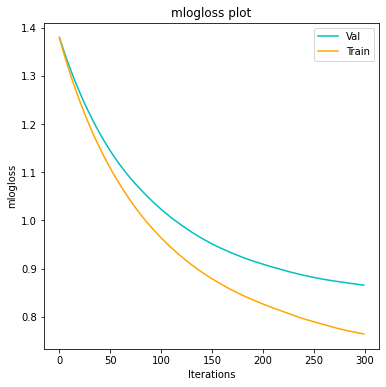

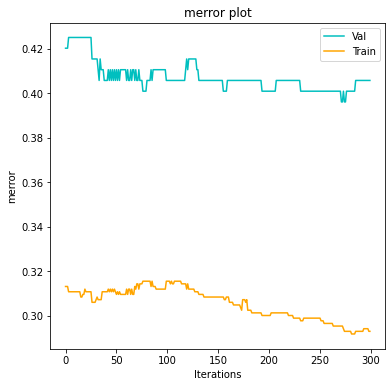

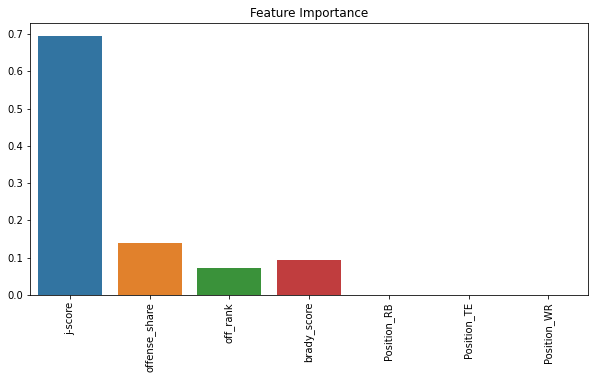

In [185]:
fitXgb(xgb2, training_data)

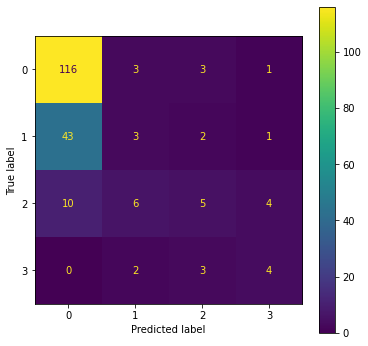

In [186]:
plot_confusion_matrix(xgb2,X_test,
                     Y_test,
                     values_format='d')

## Score 2022

In [187]:
df_2022

id   j-score                   Team Position  team_score  \
0    Jonathan Taylor  0.869047     Indianapolis Colts       RB    1.086018   
1        Cooper Kupp  0.846279       Los Angeles Rams       WR    1.323825   
2      Davante Adams  0.828549      Las Vegas Raiders       WR    2.085839   
3         Nick Chubb  0.827943       Cleveland Browns       RB    1.233409   
4       Deebo Samuel  0.782741    San Francisco 49ers       WR    1.651133   
..               ...       ...                    ...      ...         ...   
614     Kene Nwangwu  0.001846      Minnesota Vikings       RB    1.782206   
615       Derek Watt  0.001824    Pittsburgh Steelers       RB    1.297139   
616    Marken Michel  0.001824  Washington Commanders       WR    0.472501   
617      Mike Burton  0.001824     Kansas City Chiefs       RB    1.250220   
618    Kyle Juszczyk  0.001824    San Francisco 49ers       RB    1.651133   

     offense_share  off_rank  brady_score  
0         0.800215      17.0     0.231495  
1         0.639268      10.0     0.102849  
2         0.397226       1.0     0.167599  
3         0.671263      13.0     0.866762  
4         0.474063       7.0     0.172711  
..             ...       ...          ...  
614       0.001036       5.0     0.392088  
615       0.001407      11.0     0.313993  
616       0.003861      30.0     0.071028  
617       0.001459      12.0     0.775345  
618       0.001105       7.0     0.172711  

[619 rows x 8 columns]

In [191]:
df_2022_X = df_2022.drop(columns=['id','Team','team_score'])
df_2022_X

j-score Position  offense_share  off_rank  brady_score
0    0.869047       RB       0.800215      17.0     0.231495
1    0.846279       WR       0.639268      10.0     0.102849
2    0.828549       WR       0.397226       1.0     0.167599
3    0.827943       RB       0.671263      13.0     0.866762
4    0.782741       WR       0.474063       7.0     0.172711
..        ...      ...            ...       ...          ...
614  0.001846       RB       0.001036       5.0     0.392088
615  0.001824       RB       0.001407      11.0     0.313993
616  0.001824       WR       0.003861      30.0     0.071028
617  0.001824       RB       0.001459      12.0     0.775345
618  0.001824       RB       0.001105       7.0     0.172711

[619 rows x 5 columns]

In [192]:
df_2022_X2 = pd.get_dummies(df_2022_X)
df_2022_X2

j-score  offense_share  off_rank  brady_score  Position_RB  Position_TE  \
0    0.869047       0.800215      17.0     0.231495            1            0   
1    0.846279       0.639268      10.0     0.102849            0            0   
2    0.828549       0.397226       1.0     0.167599            0            0   
3    0.827943       0.671263      13.0     0.866762            1            0   
4    0.782741       0.474063       7.0     0.172711            0            0   
..        ...            ...       ...          ...          ...          ...   
614  0.001846       0.001036       5.0     0.392088            1            0   
615  0.001824       0.001407      11.0     0.313993            1            0   
616  0.001824       0.003861      30.0     0.071028            0            0   
617  0.001824       0.001459      12.0     0.775345            1            0   
618  0.001824       0.001105       7.0     0.172711            1            0   

     Position_WR  
0              0  
1              1  
2              1  
3              0  
4              1  
..           ...  
614            0  
615            0  
616            1  
617            0  
618            0  

[619 rows x 7 columns]

In [209]:
pd.DataFrame(xgb2.predict(df_2022_X2))

0
0    3
1    2
2    2
3    3
4    2
..  ..
614  0
615  0
616  0
617  0
618  0

[619 rows x 1 columns]

In [210]:
ash_2022 = pd.DataFrame(xgb2.predict(df_2022_X2)).set_index(df_2022['id']).sort_values(
    0, axis=0, ascending=False)
ash_2022.to_csv('final_ash_rankings.csv')

In [211]:
ash_2022

0
id                     
Jonathan Taylor       3
Austin Ekeler         3
Najee Harris          3
Aaron Jones           3
Javonte Williams      3
...                  ..
Ihmir Smith-Marsette  0
Tyrion Davis-Price    0
Rex Burkhead          0
Tyler Allgeier        0
Kyle Juszczyk         0

[619 rows x 1 columns]

In [205]:
ash_2022['rank_score'] = 275*ash_2022[3] + 200*ash_2022[2] + 125*ash_2022[1]
ash_2022.to_csv('final_ash_rankings.csv')

### Backtest

#### 2021

In [67]:
df_2021

Unnamed: 0       Full Name   j-score         y                  Team  \
0             0    Alvin Kamara  0.964549  234.6994    New Orleans Saints   
1             1     Tyreek Hill  0.954797  296.5004    Kansas City Chiefs   
2             2   Tyler Lockett  0.953681  241.4000      Seattle Seahawks   
3             3    D.K. Metcalf  0.939311  244.3002      Seattle Seahawks   
4             4     Dalvin Cook  0.928772  206.2996     Minnesota Vikings   
..          ...             ...       ...       ...                   ...   
245         343    Randall Cobb  0.007228   93.6000     Green Bay Packers   
246         387   Justin Watson  0.005264    0.0000  Tampa Bay Buccaneers   
247         399  Rob Gronkowski  0.004572  171.2004  Tampa Bay Buccaneers   
248         438   Derek Carrier  0.003570    3.3000     Las Vegas Raiders   
249         439    Ashton Dulin  0.003562   45.5005    Indianapolis Colts   

    Position  team_score  offense_share  brady_score  
0         RB    1.143686       0.843369     0.014095  
1         WR    2.393712       0.398877     0.812182  
2         WR    2.391899       0.398713     0.369529  
3         WR    2.391899       0.392705     0.369529  
4         RB    2.103923       0.441448     0.637825  
..       ...         ...            ...          ...  
245       WR    2.246761       0.003217     0.678502  
246       WR    3.130573       0.001681     0.500734  
247       TE    3.130573       0.001460     0.500734  
248       TE    1.975811       0.001807     0.038124  
249       WR    1.526852       0.002333     0.034822  

[250 rows x 9 columns]

In [70]:
df_2021_X = df_2021.drop(columns=['Unnamed: 0','Full Name','Team','y'])
df_2021_X

df_2021_X2 = pd.get_dummies(df_2021_X)
df_2021_X2

ash_2021 = pd.DataFrame(clf_xgb2.predict_proba(df_2021_X2)).set_index(df_2021['Full Name']).sort_values(1, axis=0, ascending=False)
ash_2021.head(30)

0         1
Full Name                            
Cooper Kupp        0.114820  0.885180
Joe Mixon          0.228544  0.771456
Justin Jefferson   0.256889  0.743111
Ja'Marr Chase      0.370959  0.629041
Jonathan Taylor    0.451714  0.548286
Nick Chubb         0.515156  0.484844
Davante Adams      0.610340  0.389660
Tee Higgins        0.690127  0.309873
D'Andre Swift      0.753741  0.246259
Dalvin Cook        0.807322  0.192678
Travis Kelce       0.846894  0.153106
Deebo Samuel       0.848668  0.151332
Derrick Henry      0.856928  0.143072
James Conner       0.859414  0.140586
Aaron Jones        0.867178  0.132822
D.J. Moore         0.871218  0.128782
Alvin Kamara       0.873669  0.126331
Leonard Fournette  0.878988  0.121012
Calvin Ridley      0.884617  0.115383
Brandin Cooks      0.891465  0.108535
Stefon Diggs       0.892007  0.107994
Tyreek Hill        0.892007  0.107994
Josh Jacobs        0.895937  0.104063
D.K. Metcalf       0.897893  0.102107
Kareem Hunt        0.907106  0.092895
Corey Davis        0.910660  0.089340
Tyler Lockett      0.911195  0.088805
Elijah Moore       0.915025  0.084975
Melvin Gordon      0.916720  0.083280
Antonio Gibson     0.918568  0.081432

[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   0.7s
[CV] END gamma=0.25, learning_rate=0.01, max_depth=7, reg_lambda=1.0, scale_pos_weight=1; total time=   0.7s
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   0.5s
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   0.5s
[CV] END gamma=0.25, learning_rate=0.05, max_depth=6, reg_lambda=1.0, scale_pos_weight=1; total time=   0.5s
[CV] END gamma=0.25, learning_rate=0.05, max_depth=6, reg_lambda=1.0, scale_pos_weight=1; total time=   0.6s
[CV] END gamma=0.25, learning_rate=0.05, max_depth=7, reg_lambda=1.0, scale_pos_weight=1; total time=   0.5s
[CV] END gamma=0.25, learning_rate=0.05, max_depth=6, reg_lambda=1.0, scale_pos_weight=1; total time=   0.5s
[CV] END gamma=0.25, learning_rate=0.05, max_depth=7, reg_lambda=1.0, scale_pos_weight=1; total time=   0.5s
[CV] END gamma=0.25

## Create rankings

In [76]:
ash_2022_df = ash_2022.reset_index().drop(columns=[0]).rename(columns={1:'ash'})
ash_2022_df

id       ash
0       Derrick Henry  0.892371
1         Aaron Jones  0.771608
2    Javonte Williams  0.732731
3        Najee Harris  0.703188
4          A.J. Brown  0.573586
..                ...       ...
614     Robert Foster  0.005566
615       Jerome Ford  0.005566
616   Keaontay Ingram  0.005566
617       Ty Chandler  0.005566
618   D.J. Montgomery  0.005566

[619 rows x 2 columns]

In [79]:
rank_df = ash_2022_df.merge(j_2022_df[['id','1']],on='id',how='inner').rename(columns={'1':'j'})
rank_df

id       ash         j
0       Derrick Henry  0.892371  0.748303
1         Aaron Jones  0.771608  0.774779
2    Javonte Williams  0.732731  0.736081
3        Najee Harris  0.703188  0.899684
4          A.J. Brown  0.573586  0.707224
..                ...       ...       ...
782     Robert Foster  0.005566  0.012706
783       Jerome Ford  0.005566  0.012743
784   Keaontay Ingram  0.005566  0.012743
785       Ty Chandler  0.005566  0.012743
786   D.J. Montgomery  0.005566  0.001060

[787 rows x 3 columns]

In [81]:
brady_rank = brady_2022[['id','1']].rename(columns={'1':'brady'})
brady_rank

id     brady
0        Josh Allen  0.889367
1     Lamar Jackson  0.874803
2    Deshaun Watson  0.866762
3      Kyler Murray  0.841153
4    Justin Herbert  0.829764
..              ...       ...
88   Logan Woodside  0.006365
89     Nate Sudfeld  0.006365
90        Tim Boyle  0.006365
91  Nathan Peterman  0.006365
92     Brett Rypien  0.006365

[93 rows x 2 columns]

In [82]:
rank_df['projected_points'] = 275*rank_df['ash'] + 200*rank_df['j']
rank_df

id       ash         j  projected_points
0       Derrick Henry  0.892371  0.748303        395.062714
1         Aaron Jones  0.771608  0.774779        367.148103
2    Javonte Williams  0.732731  0.736081        348.717304
3        Najee Harris  0.703188  0.899684        373.313574
4          A.J. Brown  0.573586  0.707224        299.180896
..                ...       ...       ...               ...
782     Robert Foster  0.005566  0.012706          4.071823
783       Jerome Ford  0.005566  0.012743          4.079170
784   Keaontay Ingram  0.005566  0.012743          4.079170
785       Ty Chandler  0.005566  0.012743          4.079170
786   D.J. Montgomery  0.005566  0.001060          1.742768

[787 rows x 4 columns]

In [99]:
brady_rank['projected_points'] = 300*brady_rank['brady']
brady_rank

id     brady  projected_points
0          Josh Allen  0.889367        266.810061
1       Lamar Jackson  0.874803        262.441050
2      Deshaun Watson  0.866762        260.028510
3        Kyler Murray  0.841153        252.345960
4      Justin Herbert  0.829764        248.929110
5     Patrick Mahomes  0.775345        232.603530
6       Aaron Rodgers  0.701457        210.437232
7         Jalen Hurts  0.624278        187.283511
8      Russell Wilson  0.586580        175.974102
9          Joe Burrow  0.546255        163.876440
10       Dak Prescott  0.526876        158.062800
11       Kirk Cousins  0.392088        117.626418
12          Tom Brady  0.348020        104.406006
13  Mitchell Trubisky  0.313993         94.197939
14     Ryan Tannehill  0.239301         71.790294
15          Matt Ryan  0.231495         69.448476
16         Trey Lance  0.172711         51.813312
17         Derek Carr  0.167599         50.279796
18     Tua Tagovailoa  0.160556         48.166899
19   Matthew Stafford  0.102849         30.854682
20         Geno Smith  0.081036         24.310683
21       Carson Wentz  0.071028         21.308477
22        Sam Darnold  0.068397         20.519078
23     Marcus Mariota  0.035736         10.720687
24     Blaine Gabbert  0.032328          9.698457
25      Justin Fields  0.031568          9.470475
26         Jared Goff  0.031231          9.369420
27      Kenny Pickett  0.029731          8.919407
28        Zach Wilson  0.029704          8.911212
29       Ryan Griffin  0.024153          7.245983
30      Brandon Allen  0.022152          6.645468
31       Nick Mullens  0.022152          6.645468
32      Mason Rudolph  0.022152          6.645468
33          Mac Jones  0.020180          6.054016
34    Jarrett Stidham  0.020146          6.043778
35       Daniel Jones  0.018313          5.494015
36        Davis Mills  0.016308          4.892253
37     Jameis Winston  0.016002          4.800658
38        Kellen Mond  0.015744          4.723303
39        Jacob Eason  0.015510          4.653010
40    Trevor Lawrence  0.014761          4.428187
41         Jake Luton  0.014062          4.218661
42         Will Grier  0.013971          4.191346
43          Drew Lock  0.013604          4.081072
44  Teddy Bridgewater  0.012697          3.809149
45         Colt McCoy  0.011558          3.467272
46        Cooper Rush  0.010265          3.079642
47       Sean Mannion  0.010265          3.079642
48     Trace McSorley  0.009326          2.797726
49        Ben DiNucci  0.009326          2.797726
50    Jacoby Brissett  0.009086          2.725819
51        Jordan Love  0.008609          2.582813
52     Trevor Siemian  0.008516          2.554894
53           Ian Book  0.008018          2.405305
54       Easton Stick  0.008018          2.405305
55       Kurt Benkert  0.008018          2.405305
56         Davis Webb  0.008018          2.405305
57         Joe Flacco  0.007946          2.383718
58         Chad Henne  0.007873          2.361918
59       Tyrod Taylor  0.007873          2.361918
60       Malik Willis  0.007769          2.330720
61        Matt Corral  0.007769          2.330720
62     Desmond Ridder  0.007769          2.330720
63      C.J. Beathard  0.007653          2.295758
64        Andy Dalton  0.007379          2.213642
65      Tyler Huntley  0.007293          2.187923
66        Case Keenum  0.007170          2.150917
67         Nick Foles  0.007170          2.150917
68       Chase Daniel  0.007170          2.150917
69        Brian Hoyer  0.007170          2.150917
70       Josh Johnson  0.007170          2.150917
71     Baker Mayfield  0.006759          2.027835
72       Jeff Driskel  0.006551          1.965235
73    Jimmy Garoppolo  0.006551          1.965235
74         Kyle Allen  0.006551          1.965235
75        Kevin Hogan  0.006365          1.909504
76         Mike White  0.006365          1.909504
77    Taylor Heinicke  0.006365          1.909504
78       Joshua Dobbs  0.006365          1.909504
79     Kendall Hint

In [100]:
final_rank_df = rank_df[['id','projected_points']].append(brady_rank[['id','projected_points']])
final_rank_df

id  projected_points
0      Derrick Henry        395.062714
1        Aaron Jones        367.148103
2   Javonte Williams        348.717304
3       Najee Harris        373.313574
4         A.J. Brown        299.180896
..               ...               ...
88    Logan Woodside          1.909504
89      Nate Sudfeld          1.909504
90         Tim Boyle          1.909504
91   Nathan Peterman          1.909504
92      Brett Rypien          1.909504

[880 rows x 2 columns]

In [101]:
final_rank_df = final_rank_df.sort_values('projected_points',ascending=False)
final_rank_df

id  projected_points
0       Derrick Henry        395.062714
3        Najee Harris        373.313574
1         Aaron Jones        367.148103
2    Javonte Williams        348.717304
6         Cooper Kupp        325.984974
..                ...               ...
455     Jordan Franks          1.760345
456     Chris Myarick          1.760345
448   Kendall Blanton          1.760345
445       Greg Dortch          1.746724
786   D.J. Montgomery          1.742768

[880 rows x 2 columns]

In [103]:
adp = pd.read_csv('underdog_adp_updated.csv')
adp

id  firstName   lastName  \
0     fa2fcc47-5a09-458e-82b6-656b030ad88a   Jonathan     Taylor   
1     70580da9-7858-462f-a1fd-4ff47a7b1172     Cooper       Kupp   
2     715fd9c0-eb4b-494a-ac9f-d5c53579db72  Christian  McCaffrey   
3     62154a84-9ad4-41f8-b3f3-23801013ebc8     Justin  Jefferson   
4     6022e5bc-a85c-471a-b78b-a66066f24ce4    Ja'Marr      Chase   
...                                    ...        ...        ...   
1341  fe0e8f2b-0c6a-4764-af60-f88b65958b00     Gerrit      Price   
1342  fdfad131-7592-4ff7-b2f1-ef64bb479839     Dwayne     Harris   
1343  fd41d8ef-2fdb-4f01-b241-eedcfe69e13b       Alex     Tanney   
1344  fb9b8ff0-bbe4-4272-9e17-8880942b7167       Josh    Johnson   
1345  fb7ee484-44f3-454a-8a06-fd8b4d9c9827      Andre     Patton   

                     id.1  adp  projectedPoints positionRank slotName  \
0         Jonathan Taylor  1.2            383.1          RB1       RB   
1             Cooper Kupp  2.5            330.1          WR1       WR   
2     Christian McCaffrey  3.2            270.3          RB2       RB   
3        Justin Jefferson  4.1            266.5          WR2       WR   
4           Ja'Marr Chase  5.1            276.2          WR3       WR   
...                   ...  ...              ...          ...      ...   
1341         Gerrit Price    -              0.0          NaN       TE   
1342        Dwayne Harris    -              0.0          NaN       WR   
1343          Alex Tanney    -              0.0          NaN       QB   
1344         Josh Johnson    -              0.0          NaN       RB   
1345         Andre Patton    -              0.0          NaN       WR   

                  teamName  lineupStatus  byeWeek  
0       Indianapolis Colts           NaN      NaN  
1         Los Angeles Rams           NaN      NaN  
2        Carolina Panthers           NaN      NaN  
3        Minnesota Vikings           NaN      NaN  
4       Cincinnati Bengals           NaN      NaN  
...                    ...           ...      ...  
1341  Jacksonville Jaguars           NaN      NaN  
1342                   NaN           NaN      NaN  
1343                   NaN           NaN      NaN  
1344      Seattle Seahawks           NaN      NaN  
1345                   NaN           NaN      NaN  

[1346 rows x 11 columns]

In [107]:
adp2 = adp.merge(final_rank_df, left_on='id.1',right_on='id',how='inner')
adp2

id_x  firstName    lastName  \
0     fa2fcc47-5a09-458e-82b6-656b030ad88a   Jonathan      Taylor   
1     70580da9-7858-462f-a1fd-4ff47a7b1172     Cooper        Kupp   
2     715fd9c0-eb4b-494a-ac9f-d5c53579db72  Christian   McCaffrey   
3     62154a84-9ad4-41f8-b3f3-23801013ebc8     Justin   Jefferson   
4     6022e5bc-a85c-471a-b78b-a66066f24ce4    Ja'Marr       Chase   
...                                    ...        ...         ...   
1185  5653dcbc-f3d6-4fbf-b85d-626357756d22     Miller  Forristall   
1186  e16fd0ac-6df1-44fa-a65f-64b421533ce5    Kendall     Blanton   
1187  e3b379c9-ba35-46db-915e-3d0962932112       T.J.      Yeldon   
1188  e2f7abbc-7cff-4bc0-bc9e-a40f1cf66025    Kendall      Hinton   
1189  fc1c73c1-9033-49ae-bf12-1afddc789f63       Deon     Jackson   

                     id.1  adp  projectedPoints positionRank slotName  \
0         Jonathan Taylor  1.2            383.1          RB1       RB   
1             Cooper Kupp  2.5            330.1          WR1       WR   
2     Christian McCaffrey  3.2            270.3          RB2       RB   
3        Justin Jefferson  4.1            266.5          WR2       WR   
4           Ja'Marr Chase  5.1            276.2          WR3       WR   
...                   ...  ...              ...          ...      ...   
1185    Miller Forristall    -              0.0          NaN       TE   
1186      Kendall Blanton    -              0.0          NaN       TE   
1187          T.J. Yeldon    -              0.0          NaN       RB   
1188       Kendall Hinton    -              0.0          NaN       WR   
1189         Deon Jackson    -              0.0          NaN       RB   

                teamName  lineupStatus  byeWeek                 id_y  \
0     Indianapolis Colts           NaN      NaN      Jonathan Taylor   
1       Los Angeles Rams           NaN      NaN          Cooper Kupp   
2      Carolina Panthers           NaN      NaN  Christian McCaffrey   
3      Minnesota Vikings           NaN      NaN     Justin Jefferson   
4     Cincinnati Bengals           NaN      NaN        Ja'Marr Chase   
...                  ...           ...      ...                  ...   
1185    Cleveland Browns           NaN      NaN    Miller Forristall   
1186    Los Angeles Rams           NaN      NaN      Kendall Blanton   
1187                 NaN           NaN      NaN          T.J. Yeldon   
1188      Denver Broncos           NaN      NaN       Kendall Hinton   
1189  Indianapolis Colts           NaN      NaN         Deon Jackson   

      projected_points  
0           323.074702  
1           325.984974  
2           100.425435  
3           214.412486  
4           205.304185  
...                ...  
1185          1.760345  
1186          1.760345  
1187         15.560250  
1188          1.909504  
1189          1.892482  

[1190 rows x 13 columns]

In [112]:
final_ud_rank = adp2.sort_values('projected_points',ascending=False)
final_ud_rank

id_x firstName    lastName  \
6     69687967-146f-40b7-9dc9-851995c3f4ac   Derrick       Henry   
8     f015ede6-d975-495c-ac72-4e01ec70fee8     Najee      Harris   
17    1fe3abfa-791d-4477-800e-d08243134ce7     Aaron       Jones   
26    032962ab-fc10-45ea-92c4-24f0ae80de63   Javonte    Williams   
1     70580da9-7858-462f-a1fd-4ff47a7b1172    Cooper        Kupp   
...                                    ...       ...         ...   
289   201d9f0c-3426-4ecb-863d-515dd5f54ab7      Eric   Tomlinson   
1124  334c5deb-7a4f-470b-b1ff-cfcb99ef6700    Jordan      Franks   
1094  cfa96f21-29f6-43eb-999d-79c9280d03a7      Jack       Stoll   
1144  6fd32a5f-b5df-477c-91dc-cc0cfd09c76e      Greg      Dortch   
1159  bf22fac3-0229-43f2-a7bb-645470eb4151      D.J.  Montgomery   

                  id.1    adp  projectedPoints positionRank slotName  \
6        Derrick Henry    7.6            318.9          RB4       RB   
8         Najee Harris    8.7            221.6          RB5       RB   
17         Aaron Jones   18.3            175.5          RB9       RB   
26    Javonte Williams   26.6            208.4         RB14       RB   
1          Cooper Kupp    2.5            330.1          WR1       WR   
...                ...    ...              ...          ...      ...   
289     Eric Tomlinson  215.9              0.0         TE44       TE   
1124     Jordan Franks      -              0.0          NaN       TE   
1094        Jack Stoll      -              0.0          NaN       TE   
1144       Greg Dortch      -              0.0          NaN       WR   
1159   D.J. Montgomery      -              0.0          NaN       WR   

                 teamName  lineupStatus  byeWeek              id_y  \
6        Tennessee Titans           NaN      NaN     Derrick Henry   
8     Pittsburgh Steelers           NaN      NaN      Najee Harris   
17      Green Bay Packers           NaN      NaN       Aaron Jones   
26         Denver Broncos           NaN      NaN  Javonte Williams   
1        Los Angeles Rams           NaN      NaN       Cooper Kupp   
...                   ...           ...      ...               ...   
289        Denver Broncos           NaN      NaN    Eric Tomlinson   
1124                  NaN           NaN      NaN     Jordan Franks   
1094  Philadelphia Eagles           NaN      NaN        Jack Stoll   
1144    Arizona Cardinals           NaN      NaN       Greg Dortch   
1159              NY Jets           NaN      NaN   D.J. Montgomery   

      projected_points  
6           395.062714  
8           373.313574  
17          367.148103  
26          348.717304  
1           325.984974  
...                ...  
289           1.760345  
1124          1.760345  
1094          1.760345  
1144          1.746724  
1159          1.742768  

[1190 rows x 13 columns]

In [113]:
final_ud_rank['projectedPoints'] = final_ud_rank['projected_points']
final_ud_rank2 = final_ud_rank.drop(columns=['id.1','id_y','projected_points'])
final_ud_rank2.to_csv('final_ud_rank.csv')

In [105]:
pd.set_option('display.max_rows',500)

underdog_rankings = final_rank_df.merge(adp[['id','id.1','adp','teamName']], how='left',left_on='id',right_on='id.1')
underdog_rankings.head(50)

id_x  projected_points                                  id_y  \
0       Derrick Henry        395.062714  69687967-146f-40b7-9dc9-851995c3f4ac   
1        Najee Harris        373.313574  f015ede6-d975-495c-ac72-4e01ec70fee8   
2         Aaron Jones        367.148103  1fe3abfa-791d-4477-800e-d08243134ce7   
3    Javonte Williams        348.717304  032962ab-fc10-45ea-92c4-24f0ae80de63   
4         Cooper Kupp        325.984974  70580da9-7858-462f-a1fd-4ff47a7b1172   
5     Jonathan Taylor        323.074702  fa2fcc47-5a09-458e-82b6-656b030ad88a   
6        Travis Kelce        305.837310  ff866ea0-6a39-4843-8a53-523c7b6e16e3   
7          A.J. Brown        299.180896  03f17ad2-f686-42e3-bc73-343f72f24d01   
8        Stefon Diggs        283.710110  ca6b7b2f-cdba-40cd-86ec-851629b8890b   
9       Devonta Smith        277.192893  56644f6b-3c3b-41e0-9e97-e8a9ec3c84be   
10         Josh Allen        266.810061  a02e9e01-0185-4a4b-a692-cdd006d9ddf0   
11      Lamar Jackson        262.441050  72e44052-5065-4bd4-a2db-c3f9949ec20e   
12     Deshaun Watson        260.028510  07be9979-34f6-41ca-a078-54e1ec22699e   
13        Josh Jacobs        253.524593  775a2782-c1e2-40f7-983c-2cf0e7863edb   
14       Kyler Murray        252.345960  2933617f-a121-459c-9714-35bd8345303a   
15     Justin Herbert        248.929110  cd07ea39-bbc8-40f5-a61e-d16963f518a3   
16      D'Andre Swift        241.536807  eddbec45-5a29-4976-af96-176858468bcb   
17        Dalvin Cook        238.465327  f40693b0-68e6-4360-b90c-b55bc425147b   
18    Michael Pittman        234.792880  aa962038-90f9-43d6-9b87-b49999168b25   
19    Patrick Mahomes        232.603530  117bf732-d2a0-4094-b84b-5bb028010eb0   
20         D.J. Moore        230.288716  74bdf837-4480-49f7-b623-8420b98cd303   
21     Hunter Renfrow        229.836838  f9a916a9-1045-4fca-a4d4-fd9ed9b65b09   
22      Davante Adams        226.626223  afce47e8-89bb-48d5-bc3a-5fc67a0ce50b   
23    Diontae Johnson        226.112062  63335fc3-4ab9-4ebe-8a5c-dee868f45036   
24       Mark Andrews        221.218615  2cd9ecbb-3f8a-4dda-b918-10163b9bf749   
25       Alvin Kamara        215.499766  0424f7b7-948a-4e64-a462-1915a53c51e6   
26   Justin Jefferson        214.412486  62154a84-9ad4-41f8-b3f3-23801013ebc8   
27         Nick Chubb        213.750966  8d9ff2b9-d63f-4645-84c8-e5e05413b93e   
28      Aaron Rodgers        210.437232  fffb17af-f368-4b09-8aa4-e119998f6e01   
29     Antonio Gibson        207.320995  a1309c81-c3c7-41bd-a8fc-4482a1bed951   
30      Ja'Marr Chase        205.304185  6022e5bc-a85c-471a-b78b-a66066f24ce4   
31          Joe Mixon        203.963004  72a1b950-f005-419c-b67f-08d7f7f5df27   
32       James Conner        202.859271  4a165d4b-b5f1-4d10-863f-4df84cd90fd2   
33     Marquise Brown        202.188943  6a60f97f-e16f-44dd-bcc1-da885f8ae2b0   
34        Tee Higgins        197.677425  aa6f212c-a39b-441d-b9ed-4c4f76a9e718   
35        Tyreek Hill        195.318778  f76e9085-98bd-4a81-ab2c-aaf7310d9a6d   
36      Tyler Lockett        191.532464  6d236cf4-3026-4dad-aa5e-e2ed3a3dcad2   
37      Jaylen Waddle        189.279874  5c9f516c-4bf7-40b2-b9e1-50675a5b8988   
38       D.K. Metcalf        187.678184  78b2ca61-7ec2-43fc-8456-607b0cb95a89   
39        Jalen Hurts        187.283511  59109372-112c-4226-8a1e-bdb13389e7d8   
40  Leonard Fournette        185.783621  8be0f709-c335-4e99-aca6-a2a6e9eae205   
41        CeeDee Lamb        182.849592  fce90658-25d8-4bc2-aec4-242a8784e910   
42     Terry McLaurin        180.989622  e7711ec6-eee2-4df3-bf09-58166bcfba99   
43       Chris Godwin        179.443009  464cf22b-8a6e-486c-bd56-ba38b76a7d1c   
44    Ezekiel Elliott        178.764450  d014ebbf-3fb8-4c05-8526-8c1de9009261   
45     Russell Wilson        175.974102  96100e46-cf7b-4e90-9254-59245d37fe31   
46         Mike Evans        169.657165  fb9af657-c47a-4d72-8146-20b8bd6e5f49   
47         Joe Burrow        163.876440  1a6e0e13-cfeb-46f6-a9e8-c7483f2b7bb3   
48       Amari Cooper        161.497023  9196bc1

In [106]:
underdog_rankings_df = underdog_rankings[['id_y','id_x']]
underdog_rankings_df.to_csv('underdog_rankings.csv')
underdog_rankings_df

id_y              id_x
0     69687967-146f-40b7-9dc9-851995c3f4ac     Derrick Henry
1     f015ede6-d975-495c-ac72-4e01ec70fee8      Najee Harris
2     1fe3abfa-791d-4477-800e-d08243134ce7       Aaron Jones
3     032962ab-fc10-45ea-92c4-24f0ae80de63  Javonte Williams
4     70580da9-7858-462f-a1fd-4ff47a7b1172       Cooper Kupp
...                                    ...               ...
1203  334c5deb-7a4f-470b-b1ff-cfcb99ef6700     Jordan Franks
1204  4113e1e4-ab90-4ad1-a522-868a9f2d4cf1     Chris Myarick
1205  e16fd0ac-6df1-44fa-a65f-64b421533ce5   Kendall Blanton
1206  6fd32a5f-b5df-477c-91dc-cc0cfd09c76e       Greg Dortch
1207  bf22fac3-0229-43f2-a7bb-645470eb4151   D.J. Montgomery

[1208 rows x 2 columns]

In [119]:
underdog_rankings.groupby(['teamName']).agg({'projected_points':'sum'}).sort_values('projected_points',
                                                                                    ascending=False)

projected_points
teamName                               
Seattle Seahawks            1224.795262
Philadelphia Eagles         1069.004899
Denver Broncos              1026.615738
Pittsburgh Steelers         1015.546888
Detroit Lions                960.770868
Cincinnati Bengals           958.702916
Buffalo Bills                934.124112
Arizona Cardinals            914.941904
Las Vegas Raiders            882.143015
Kansas City Chiefs           865.430252
Dallas Cowboys               831.896457
Los Angeles Chargers         805.928205
Tampa Bay Buccaneers         802.767698
Green Bay Packers            781.966743
Baltimore Ravens             768.094289
Cleveland Browns             745.152986
Miami Dolphins               723.166318
Indianapolis Colts           716.488592
Minnesota Vikings            701.603016
Tennessee Titans             678.151610
San Francisco 49ers          625.496791
Washington Commanders        553.470839
NY Jets                      553.341675
Jacksonville Jaguars         519.018243
Carolina Panthers            512.293051
Los Angeles Rams             505.423815
New Orleans Saints           477.072246
New England Patriots         399.064630
Chicago Bears                360.884168
Atlanta Falcons              319.336918
Houston Texans               247.227672
NY Giants                    214.966156

In [120]:
ash_2022 = pd.read_csv('ash_2022_rank.csv')
ash_2022

Unnamed: 0                                    id    firstName  \
0             1  69687967-146f-40b7-9dc9-851995c3f4ac      Derrick   
1             2  f015ede6-d975-495c-ac72-4e01ec70fee8        Najee   
2             3  1fe3abfa-791d-4477-800e-d08243134ce7        Aaron   
3             4  032962ab-fc10-45ea-92c4-24f0ae80de63      Javonte   
4             5  70580da9-7858-462f-a1fd-4ff47a7b1172       Cooper   
5             6  fa2fcc47-5a09-458e-82b6-656b030ad88a     Jonathan   
6             7  ff866ea0-6a39-4843-8a53-523c7b6e16e3       Travis   
7             8  03f17ad2-f686-42e3-bc73-343f72f24d01         A.J.   
8             9  ca6b7b2f-cdba-40cd-86ec-851629b8890b       Stefon   
9            10  56644f6b-3c3b-41e0-9e97-e8a9ec3c84be      Devonta   
10           11  a02e9e01-0185-4a4b-a692-cdd006d9ddf0         Josh   
11           12  72e44052-5065-4bd4-a2db-c3f9949ec20e        Lamar   
12           13  07be9979-34f6-41ca-a078-54e1ec22699e      Deshaun   
13           14  775a2782-c1e2-40f7-983c-2cf0e7863edb         Josh   
14           15  2933617f-a121-459c-9714-35bd8345303a        Kyler   
15           16  cd07ea39-bbc8-40f5-a61e-d16963f518a3       Justin   
16           17  eddbec45-5a29-4976-af96-176858468bcb      D'Andre   
17           18  f40693b0-68e6-4360-b90c-b55bc425147b       Dalvin   
18           19  aa962038-90f9-43d6-9b87-b49999168b25      Michael   
19           20  117bf732-d2a0-4094-b84b-5bb028010eb0      Patrick   
20           21  74bdf837-4480-49f7-b623-8420b98cd303         D.J.   
21           22  f9a916a9-1045-4fca-a4d4-fd9ed9b65b09       Hunter   
22           23  afce47e8-89bb-48d5-bc3a-5fc67a0ce50b      Davante   
23           24  63335fc3-4ab9-4ebe-8a5c-dee868f45036      Diontae   
24           25  2cd9ecbb-3f8a-4dda-b918-10163b9bf749         Mark   
25           26  0424f7b7-948a-4e64-a462-1915a53c51e6        Alvin   
26           27  62154a84-9ad4-41f8-b3f3-23801013ebc8       Justin   
27           28  8d9ff2b9-d63f-4645-84c8-e5e05413b93e         Nick   
28           29  fffb17af-f368-4b09-8aa4-e119998f6e01        Aaron   
29           30  a1309c81-c3c7-41bd-a8fc-4482a1bed951      Antonio   
30           31  6022e5bc-a85c-471a-b78b-a66066f24ce4      Ja'Marr   
31           32  72a1b950-f005-419c-b67f-08d7f7f5df27          Joe   
32           33  4a165d4b-b5f1-4d10-863f-4df84cd90fd2        James   
33           34  6a60f97f-e16f-44dd-bcc1-da885f8ae2b0     Marquise   
34           35  aa6f212c-a39b-441d-b9ed-4c4f76a9e718          Tee   
35           36  f76e9085-98bd-4a81-ab2c-aaf7310d9a6d       Tyreek   
36           37  6d236cf4-3026-4dad-aa5e-e2ed3a3dcad2        Tyler   
37           38  5c9f516c-4bf7-40b2-b9e1-50675a5b8988       Jaylen   
38           39  78b2ca61-7ec2-43fc-8456-607b0cb95a89         D.K.   
39           40  59109372-112c-4226-8a1e-bdb13389e7d8        Jalen   
40           41  8be0f709-c335-4e99-aca6-a2a6e9eae205      Leonard   
41           42  fce90658-25d8-4bc2-aec4-242a8784e910       CeeDee   
42           43  e7711ec6-eee2-4df3-bf09-58166bcfba99        Terry   
43           44  464cf22b-8a6e-486c-bd56-ba38b76a7d1c        Chris   
44           45  d014ebbf-3fb8-4c05-8526-8c1de9009261      Ezekiel   
45           46  96100e46-cf7b-4e90-9254-59245d37fe31      Russell   
46           47  fb9af657-c47a-4d72-8146-20b8bd6e5f49         Mike   
47           48  1a6e0e13-cfeb-46f6-a9e8-c7483f2b7bb3          Joe   
48           49  9196bc1d-374f-4701-8e8a-1646e4e2e65a        Amari   
49           50  319fcf5c-6a5f-4598-93da-1f287ce6ba54       Keenan   
50           51  36f843c7-40b3-43bd-84b8-14274e0d4e98          Dak   
51           52  40f907c8-711d-4f93-93f7-e268d966fe42       Austin   
52           53  7fde70e8-ab8e-4064-99fb-3ddd88e5dc9f        Deebo   
53           54  799e8f24-9514-4aa6-8bb7-dcbcd3a385b7        Tyler   
54           55  a629f60e-bb1c-4252-a852-9317c61ce37d       Dalton   
55           56  0e88b6cc-b68a-4329-a6f9-6964990e29d7    Christian   
56           57

In [126]:
ash_2022['adp'] = ash_2022['adp'].apply(lambda x: pd.to_numeric(x,errors='coerce'))
ash_2022_df = ash_2022.head(250)
ash_2022_df

Unnamed: 0                                    id    firstName  \
0             1  69687967-146f-40b7-9dc9-851995c3f4ac      Derrick   
1             2  f015ede6-d975-495c-ac72-4e01ec70fee8        Najee   
2             3  1fe3abfa-791d-4477-800e-d08243134ce7        Aaron   
3             4  032962ab-fc10-45ea-92c4-24f0ae80de63      Javonte   
4             5  70580da9-7858-462f-a1fd-4ff47a7b1172       Cooper   
5             6  fa2fcc47-5a09-458e-82b6-656b030ad88a     Jonathan   
6             7  ff866ea0-6a39-4843-8a53-523c7b6e16e3       Travis   
7             8  03f17ad2-f686-42e3-bc73-343f72f24d01         A.J.   
8             9  ca6b7b2f-cdba-40cd-86ec-851629b8890b       Stefon   
9            10  56644f6b-3c3b-41e0-9e97-e8a9ec3c84be      Devonta   
10           11  a02e9e01-0185-4a4b-a692-cdd006d9ddf0         Josh   
11           12  72e44052-5065-4bd4-a2db-c3f9949ec20e        Lamar   
12           13  07be9979-34f6-41ca-a078-54e1ec22699e      Deshaun   
13           14  775a2782-c1e2-40f7-983c-2cf0e7863edb         Josh   
14           15  2933617f-a121-459c-9714-35bd8345303a        Kyler   
15           16  cd07ea39-bbc8-40f5-a61e-d16963f518a3       Justin   
16           17  eddbec45-5a29-4976-af96-176858468bcb      D'Andre   
17           18  f40693b0-68e6-4360-b90c-b55bc425147b       Dalvin   
18           19  aa962038-90f9-43d6-9b87-b49999168b25      Michael   
19           20  117bf732-d2a0-4094-b84b-5bb028010eb0      Patrick   
20           21  74bdf837-4480-49f7-b623-8420b98cd303         D.J.   
21           22  f9a916a9-1045-4fca-a4d4-fd9ed9b65b09       Hunter   
22           23  afce47e8-89bb-48d5-bc3a-5fc67a0ce50b      Davante   
23           24  63335fc3-4ab9-4ebe-8a5c-dee868f45036      Diontae   
24           25  2cd9ecbb-3f8a-4dda-b918-10163b9bf749         Mark   
25           26  0424f7b7-948a-4e64-a462-1915a53c51e6        Alvin   
26           27  62154a84-9ad4-41f8-b3f3-23801013ebc8       Justin   
27           28  8d9ff2b9-d63f-4645-84c8-e5e05413b93e         Nick   
28           29  fffb17af-f368-4b09-8aa4-e119998f6e01        Aaron   
29           30  a1309c81-c3c7-41bd-a8fc-4482a1bed951      Antonio   
30           31  6022e5bc-a85c-471a-b78b-a66066f24ce4      Ja'Marr   
31           32  72a1b950-f005-419c-b67f-08d7f7f5df27          Joe   
32           33  4a165d4b-b5f1-4d10-863f-4df84cd90fd2        James   
33           34  6a60f97f-e16f-44dd-bcc1-da885f8ae2b0     Marquise   
34           35  aa6f212c-a39b-441d-b9ed-4c4f76a9e718          Tee   
35           36  f76e9085-98bd-4a81-ab2c-aaf7310d9a6d       Tyreek   
36           37  6d236cf4-3026-4dad-aa5e-e2ed3a3dcad2        Tyler   
37           38  5c9f516c-4bf7-40b2-b9e1-50675a5b8988       Jaylen   
38           39  78b2ca61-7ec2-43fc-8456-607b0cb95a89         D.K.   
39           40  59109372-112c-4226-8a1e-bdb13389e7d8        Jalen   
40           41  8be0f709-c335-4e99-aca6-a2a6e9eae205      Leonard   
41           42  fce90658-25d8-4bc2-aec4-242a8784e910       CeeDee   
42           43  e7711ec6-eee2-4df3-bf09-58166bcfba99        Terry   
43           44  464cf22b-8a6e-486c-bd56-ba38b76a7d1c        Chris   
44           45  d014ebbf-3fb8-4c05-8526-8c1de9009261      Ezekiel   
45           46  96100e46-cf7b-4e90-9254-59245d37fe31      Russell   
46           47  fb9af657-c47a-4d72-8146-20b8bd6e5f49         Mike   
47           48  1a6e0e13-cfeb-46f6-a9e8-c7483f2b7bb3          Joe   
48           49  9196bc1d-374f-4701-8e8a-1646e4e2e65a        Amari   
49           50  319fcf5c-6a5f-4598-93da-1f287ce6ba54       Keenan   
50           51  36f843c7-40b3-43bd-84b8-14274e0d4e98          Dak   
51           52  40f907c8-711d-4f93-93f7-e268d966fe42       Austin   
52           53  7fde70e8-ab8e-4064-99fb-3ddd88e5dc9f        Deebo   
53           54  799e8f24-9514-4aa6-8bb7-dcbcd3a385b7        Tyler   
54           55  a629f60e-bb1c-4252-a852-9317c61ce37d       Dalton   
55           56  0e88b6cc-b68a-4329-a6f9-6964990e29d7    Christian   
56           57

In [130]:
stack = ash_2022_df.groupby(['teamName']).agg({'projectedPoints':'sum','adp':'sum'}).sort_values('projectedPoints',
                                                                                    ascending=False)
stack['value'] = stack['projectedPoints'] + stack['adp']
stack.sort_values('projectedPoints',ascending=False)

projectedPoints     adp        value
teamName                                                   
Philadelphia Eagles        1029.308056   926.2  1955.508056
Pittsburgh Steelers         975.171643  1080.4  2055.571643
Cincinnati Bengals          920.761580   404.8  1325.561580
Buffalo Bills               898.239324   971.0  1869.239324
Arizona Cardinals           863.368782   709.5  1572.868782
Las Vegas Raiders           835.516442   517.8  1353.316442
Seattle Seahawks            833.080901  1245.6  2078.680901
Kansas City Chiefs          815.803844   523.1  1338.903844
Dallas Cowboys              801.338056   766.9  1568.238056
Tampa Bay Buccaneers        770.815616  1041.6  1812.415616
Los Angeles Chargers        755.309636   656.6  1411.909636
Green Bay Packers           734.820298   721.0  1455.820298
Cleveland Browns            702.004421   810.2  1512.204421
Indianapolis Colts          687.025585   715.4  1402.425585
Miami Dolphins              685.906759  1040.0  1725.906759
Minnesota Vikings           659.845203   487.4  1147.245203
Denver Broncos              656.293908   512.7  1168.993908
Tennessee Titans            635.642925   782.3  1417.942925
Baltimore Ravens            627.131455   601.4  1228.531455
Detroit Lions               593.109303  1026.0  1619.109303
San Francisco 49ers         591.435899   902.2  1493.635899
NY Jets                     523.733719  1327.0  1850.733719
Washington Commanders       516.701896  1040.7  1557.401896
Carolina Panthers           485.966886  1267.7  1753.666886
Los Angeles Rams            481.301968   851.9  1333.201968
Jacksonville Jaguars        479.720016  1287.5  1767.220016
New Orleans Saints          416.432249   529.3   945.732249
New England Patriots        351.929795  1479.0  1830.929795
Chicago Bears               329.994851   609.6   939.594851
Atlanta Falcons             288.592568  1044.3  1332.892568
Houston Texans              184.133337   245.0   429.133337
NY Giants                   165.692799   640.9   806.592799